In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, concatenate, Input
from tensorflow.keras import Model
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")


In [3]:
path=  '/content/drive/My Drive/Colab Notebooks/train.zip'

In [4]:
zip_file = zipfile.ZipFile(path)
zip_file.extractall('.')



In [5]:
zip_file = zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/test.zip')
zip_file.extractall('./test/')

In [6]:
train_files = glob.glob('/content/train/*.npy')
len(train_files)

62735

In [7]:
def trainGenerator():
    for file in tqdm(train_files):
        dataset = np.load(file)
        target= dataset[:,:,-1].reshape(120,120,1)
        remove_minus = np.where(target < 0, 0, target)
        feature = dataset[:,:,:4]

        yield (feature, remove_minus)
        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([120,120,4]),tf.TensorShape([120,120,1])))
train_dataset = train_dataset.batch(100).prefetch(1)

In [8]:
train_dataset

<PrefetchDataset shapes: ((None, 120, 120, 4), (None, 120, 120, 1)), types: (tf.float32, tf.float32)>

In [12]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()
image_sample = np.load(train_files[500])


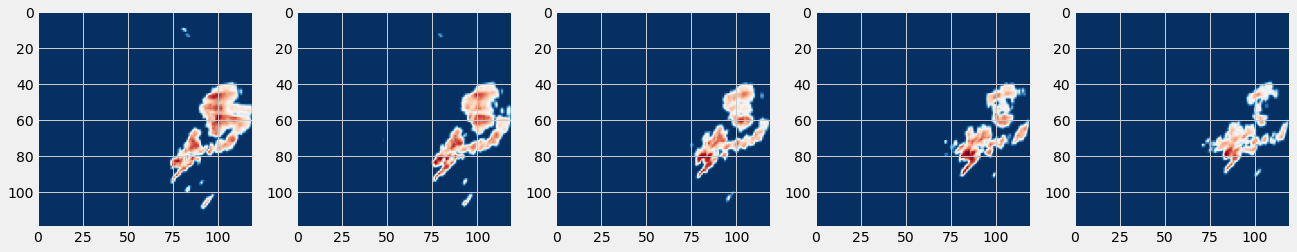

In [13]:

plt.figure(figsize=(20, 20))

for i in range(4):
    plt.subplot(1,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,5,5)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

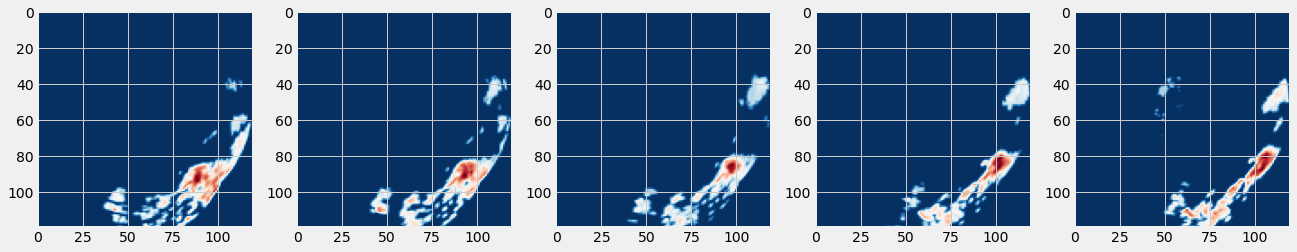

In [14]:
image_sample = np.load(train_files[240])
plt.figure(figsize=(20, 20))

for i in range(4):
    plt.subplot(1,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(1,5,5)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

In [ ]:
test_path = '/content/test'
test_files = sorted(glob.glob(test_path + '/*.npy'))

X_test = []

for file in tqdm(test_files, desc = 'test'):
    data = np.load(file)
    X_test.append(data)

X_test = np.array(X_test)

test: 100%|██████████| 2674/2674 [00:00<00:00, 2926.24it/s]


In [ ]:
def base_model(input_layer, start_neurons):

    # conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    # pool1 = BatchNormalization()(conv1)
    # pool1 = keras.layers.Dropout(0.8)(pool1)
    # pool1 = MaxPooling2D((2, 2))(pool1)

    # conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    # pool2 = BatchNormalization()(conv2)
    # pool2 = keras.layers.Dropout(0.8)(pool2)
    # pool2 = MaxPooling2D((2, 2))(pool2)

    # convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    # uconv2 = concatenate([deconv2, conv2])
    # uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    # uconv2 = BatchNormalization()(uconv2)

    # deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    # uconv1 = concatenate([deconv1, conv1])
    # uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    # uconv1 = BatchNormalization()(uconv1)
    # output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    # return output_layer
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    pool1 = BatchNormalization()(conv1)
    pool1 = keras.layers.Dropout(0.8)(pool1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    


    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    pool2 = BatchNormalization()(conv2)
    pool2 = keras.layers.Dropout(0.6)(pool2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    


    conv3 = Conv2D(start_neurons * 3, (3, 3), activation="relu", padding="same")(pool2)
    pool3 = BatchNormalization()(conv3)
    pool3 = keras.layers.Dropout(0.6)(pool3)
    pool3 = MaxPooling2D((2, 2))(pool2)
    



    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool3)

    deconv3 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)



    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)


    


    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((120, 120, 4))
output_layer = base_model(input_layer,64)

In [ ]:
model = Model(input_layer, output_layer)
model.compile(loss='mae', optimizer='adam')

In [ ]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 120, 120, 4) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 120, 120, 64) 2368        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 120, 120, 64) 256         conv2d_12[0][0]                  
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 120, 120, 64) 0           batch_normalization_8[0][0]      
_______________________________________________________________________________________

In [ ]:
my_model=model.fit(train_dataset, epochs = 5, verbose=1)

Epoch 1/5





  0%|          | 0/62735 [00:00<?, ?it/s]


  0%|          | 100/62735 [00:00<01:07, 930.69it/s]


  0%|          | 191/62735 [00:00<01:07, 922.50it/s]

      1/Unknown - 0s 73ms/step - loss: 12.1356




  0%|          | 238/62735 [00:01<07:33, 137.93it/s]

      2/Unknown - 1s 301ms/step - loss: 12.6493WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2095s vs `on_train_batch_end` time: 0.3187s). Check your callbacks.





  0%|          | 300/62735 [00:01<07:41, 135.42it/s]


  1%|          | 389/62735 [00:01<05:43, 181.53it/s]

      3/Unknown - 1s 377ms/step - loss: 12.1211




  1%|          | 435/62735 [00:02<07:11, 144.32it/s]

      4/Unknown - 2s 415ms/step - loss: 11.5350




  1%|          | 500/62735 [00:02<07:22, 140.73it/s]


  1%|          | 585/62735 [00:02<05:31, 187.66it/s]

      5/Unknown - 2s 436ms/step - loss: 11.5871




  1%|          | 631/62735 [00:03<06:56, 149.13it/s]

      6/Unknown - 3s 451ms/step - loss: 11.4296




  1%|          | 700/62735 [00:03<07:04, 146.25it/s]


  1%|          | 783/62735 [00:03<05:19, 194.16it/s]

      7/Unknown - 3s 461ms/step - loss: 11.3997




  1%|▏         | 828/62735 [00:04<06:49, 151.33it/s]

      8/Unknown - 4s 469ms/step - loss: 11.6834




  1%|▏         | 900/62735 [00:04<06:52, 149.84it/s]


  2%|▏         | 979/62735 [00:04<05:12, 197.86it/s]

      9/Unknown - 4s 476ms/step - loss: 11.6994




  2%|▏         | 1023/62735 [00:05<06:48, 150.89it/s]

     10/Unknown - 5s 480ms/step - loss: 11.8360




  2%|▏         | 1100/62735 [00:05<06:46, 151.56it/s]


  2%|▏         | 1190/62735 [00:06<05:04, 201.87it/s]

     11/Unknown - 5s 484ms/step - loss: 11.7337




  2%|▏         | 1237/62735 [00:06<06:34, 155.80it/s]

     12/Unknown - 6s 488ms/step - loss: 11.8047




  2%|▏         | 1300/62735 [00:06<06:57, 147.15it/s]


  2%|▏         | 1389/62735 [00:07<05:12, 196.28it/s]

     13/Unknown - 6s 490ms/step - loss: 11.7702




  2%|▏         | 1436/62735 [00:07<06:38, 153.91it/s]

     14/Unknown - 7s 493ms/step - loss: 11.7610




  2%|▏         | 1500/62735 [00:08<06:57, 146.82it/s]


  3%|▎         | 1588/62735 [00:08<05:12, 195.62it/s]

     15/Unknown - 7s 496ms/step - loss: 11.7190




  3%|▎         | 1635/62735 [00:08<06:44, 150.98it/s]

     16/Unknown - 8s 498ms/step - loss: 11.6671




  3%|▎         | 1700/62735 [00:09<07:00, 145.28it/s]


  3%|▎         | 1789/62735 [00:09<05:14, 193.91it/s]

     17/Unknown - 8s 499ms/step - loss: 11.4576




  3%|▎         | 1836/62735 [00:09<06:41, 151.86it/s]

     18/Unknown - 9s 501ms/step - loss: 11.4128




  3%|▎         | 1900/62735 [00:10<07:00, 144.64it/s]


  3%|▎         | 1993/62735 [00:10<05:13, 193.67it/s]

     19/Unknown - 10s 502ms/step - loss: 11.4412




  3%|▎         | 2042/62735 [00:10<06:31, 154.98it/s]

     20/Unknown - 10s 503ms/step - loss: 11.4792




  3%|▎         | 2100/62735 [00:11<07:04, 142.78it/s]


  3%|▎         | 2189/62735 [00:11<05:17, 190.83it/s]

     21/Unknown - 11s 505ms/step - loss: 11.3555




  4%|▎         | 2237/62735 [00:11<06:39, 151.32it/s]

     22/Unknown - 11s 506ms/step - loss: 11.4146




  4%|▎         | 2300/62735 [00:12<07:00, 143.72it/s]


  4%|▍         | 2391/62735 [00:12<05:13, 192.19it/s]

     23/Unknown - 12s 507ms/step - loss: 11.4288




  4%|▍         | 2439/62735 [00:12<06:39, 150.98it/s]

     24/Unknown - 12s 508ms/step - loss: 11.4888




  4%|▍         | 2500/62735 [00:13<07:03, 142.12it/s]


  4%|▍         | 2560/62735 [00:13<05:26, 184.15it/s]

     25/Unknown - 13s 508ms/step - loss: 11.4304




  4%|▍         | 2600/62735 [00:13<06:56, 144.34it/s]


  4%|▍         | 2653/62735 [00:13<05:25, 184.54it/s]

     26/Unknown - 13s 509ms/step - loss: 11.3591




  4%|▍         | 2700/62735 [00:14<06:34, 152.15it/s]


  4%|▍         | 2760/62735 [00:14<05:06, 195.96it/s]

     27/Unknown - 14s 510ms/step - loss: 11.3037




  4%|▍         | 2800/62735 [00:14<06:40, 149.79it/s]


  5%|▍         | 2864/62735 [00:14<05:07, 194.41it/s]

     28/Unknown - 14s 510ms/step - loss: 11.3738




  5%|▍         | 2904/62735 [00:15<06:55, 143.84it/s]


  5%|▍         | 2973/62735 [00:15<05:17, 188.26it/s]

     29/Unknown - 15s 511ms/step - loss: 11.3257




  5%|▍         | 3015/62735 [00:15<06:45, 147.14it/s]


  5%|▍         | 3080/62735 [00:16<05:11, 191.42it/s]

     30/Unknown - 15s 511ms/step - loss: 11.2598




  5%|▍         | 3122/62735 [00:16<06:44, 147.30it/s]


  5%|▌         | 3184/62735 [00:16<05:12, 190.43it/s]

     31/Unknown - 16s 512ms/step - loss: 11.2371




  5%|▌         | 3225/62735 [00:17<06:45, 146.93it/s]


  5%|▌         | 3284/62735 [00:17<05:13, 189.50it/s]

     32/Unknown - 16s 512ms/step - loss: 11.1738




  5%|▌         | 3324/62735 [00:17<06:46, 146.12it/s]


  5%|▌         | 3382/62735 [00:17<05:15, 188.22it/s]

     33/Unknown - 17s 513ms/step - loss: 11.1089




  5%|▌         | 3421/62735 [00:18<06:54, 143.06it/s]


  6%|▌         | 3486/62735 [00:18<05:17, 186.60it/s]

     34/Unknown - 17s 513ms/step - loss: 11.1589




  6%|▌         | 3527/62735 [00:18<06:58, 141.35it/s]


  6%|▌         | 3591/62735 [00:18<05:20, 184.38it/s]

     35/Unknown - 18s 514ms/step - loss: 11.1056




  6%|▌         | 3632/62735 [00:19<06:46, 145.38it/s]


  6%|▌         | 3695/62735 [00:19<05:12, 188.84it/s]

     36/Unknown - 19s 514ms/step - loss: 11.1003




  6%|▌         | 3736/62735 [00:19<06:42, 146.56it/s]

     37/Unknown - 19s 515ms/step - loss: 11.0160




  6%|▌         | 3800/62735 [00:20<06:54, 142.19it/s]


  6%|▌         | 3856/62735 [00:20<05:21, 183.11it/s]

     38/Unknown - 20s 515ms/step - loss: 10.9350




  6%|▌         | 3900/62735 [00:20<06:39, 147.44it/s]


  6%|▋         | 3968/62735 [00:20<05:05, 192.28it/s]

     39/Unknown - 20s 515ms/step - loss: 10.9479




  6%|▋         | 4008/62735 [00:21<06:45, 144.83it/s]


  6%|▋         | 4063/62735 [00:21<05:16, 185.66it/s]

     40/Unknown - 21s 516ms/step - loss: 10.9341




  7%|▋         | 4101/62735 [00:21<06:52, 142.10it/s]


  7%|▋         | 4163/62735 [00:21<05:16, 184.82it/s]

     41/Unknown - 21s 516ms/step - loss: 10.8652




  7%|▋         | 4202/62735 [00:22<07:03, 138.22it/s]


  7%|▋         | 4263/62735 [00:22<05:25, 179.88it/s]

     42/Unknown - 22s 517ms/step - loss: 10.8168




  7%|▋         | 4303/62735 [00:22<07:05, 137.49it/s]


  7%|▋         | 4360/62735 [00:22<05:28, 177.74it/s]

     43/Unknown - 22s 518ms/step - loss: 10.7413




  7%|▋         | 4400/62735 [00:23<06:57, 139.58it/s]


  7%|▋         | 4466/62735 [00:23<05:19, 182.58it/s]

     44/Unknown - 23s 518ms/step - loss: 10.7363




  7%|▋         | 4506/62735 [00:23<07:14, 134.16it/s]


  7%|▋         | 4571/62735 [00:24<05:30, 175.87it/s]

     45/Unknown - 23s 519ms/step - loss: 10.7395




  7%|▋         | 4612/62735 [00:24<06:47, 142.57it/s]


  7%|▋         | 4674/62735 [00:24<05:13, 185.35it/s]

     46/Unknown - 24s 519ms/step - loss: 10.7427




  8%|▊         | 4715/62735 [00:25<06:44, 143.41it/s]


  8%|▊         | 4782/62735 [00:25<05:09, 187.35it/s]

     47/Unknown - 24s 519ms/step - loss: 10.7360




  8%|▊         | 4824/62735 [00:25<06:42, 144.03it/s]


  8%|▊         | 4881/62735 [00:25<05:11, 185.57it/s]

     48/Unknown - 25s 520ms/step - loss: 10.7027




  8%|▊         | 4921/62735 [00:26<06:46, 142.25it/s]


  8%|▊         | 4987/62735 [00:26<05:10, 185.98it/s]

     49/Unknown - 25s 520ms/step - loss: 10.6795




  8%|▊         | 5028/62735 [00:26<06:41, 143.87it/s]


  8%|▊         | 5094/62735 [00:26<05:06, 187.87it/s]

     50/Unknown - 26s 520ms/step - loss: 10.6103




  8%|▊         | 5136/62735 [00:27<06:42, 143.11it/s]

     51/Unknown - 27s 521ms/step - loss: 10.5749




  8%|▊         | 5200/62735 [00:27<06:52, 139.33it/s]


  8%|▊         | 5255/62735 [00:27<05:20, 179.42it/s]

     52/Unknown - 27s 521ms/step - loss: 10.5612




  8%|▊         | 5300/62735 [00:28<06:31, 146.77it/s]


  9%|▊         | 5361/62735 [00:28<05:01, 190.02it/s]

     53/Unknown - 28s 521ms/step - loss: 10.5164




  9%|▊         | 5400/62735 [00:28<06:39, 143.66it/s]


  9%|▊         | 5458/62735 [00:28<05:08, 185.40it/s]

     54/Unknown - 28s 522ms/step - loss: 10.5198




  9%|▉         | 5500/62735 [00:29<06:39, 143.18it/s]


  9%|▉         | 5554/62735 [00:29<05:11, 183.65it/s]

     55/Unknown - 29s 522ms/step - loss: 10.4944




  9%|▉         | 5600/62735 [00:29<06:22, 149.54it/s]


  9%|▉         | 5656/62735 [00:29<04:57, 191.63it/s]

     56/Unknown - 29s 522ms/step - loss: 10.4602




  9%|▉         | 5700/62735 [00:30<06:15, 151.88it/s]


  9%|▉         | 5760/62735 [00:30<04:51, 195.27it/s]

     57/Unknown - 30s 523ms/step - loss: 10.4759




  9%|▉         | 5800/62735 [00:30<06:30, 145.70it/s]


  9%|▉         | 5860/62735 [00:30<05:01, 188.45it/s]

     58/Unknown - 30s 523ms/step - loss: 10.4424




  9%|▉         | 5900/62735 [00:31<06:38, 142.56it/s]


  9%|▉         | 5959/62735 [00:31<05:07, 184.35it/s]

     59/Unknown - 31s 523ms/step - loss: 10.4140




 10%|▉         | 6000/62735 [00:31<06:38, 142.37it/s]


 10%|▉         | 6054/62735 [00:32<05:10, 182.67it/s]

     60/Unknown - 31s 524ms/step - loss: 10.3932




 10%|▉         | 6100/62735 [00:32<06:24, 147.28it/s]


 10%|▉         | 6154/62735 [00:32<05:00, 188.09it/s]

     61/Unknown - 32s 524ms/step - loss: 10.3738




 10%|▉         | 6200/62735 [00:33<06:13, 151.25it/s]


 10%|▉         | 6261/62735 [00:33<04:49, 195.00it/s]

     62/Unknown - 33s 524ms/step - loss: 10.3404




 10%|█         | 6300/62735 [00:33<06:29, 144.72it/s]


 10%|█         | 6357/62735 [00:33<05:03, 185.97it/s]

     63/Unknown - 33s 525ms/step - loss: 10.2764




 10%|█         | 6400/62735 [00:34<06:31, 144.07it/s]


 10%|█         | 6460/62735 [00:34<05:01, 186.53it/s]

     64/Unknown - 34s 525ms/step - loss: 10.2182




 10%|█         | 6500/62735 [00:34<06:39, 140.64it/s]


 10%|█         | 6555/62735 [00:34<05:10, 181.01it/s]

     65/Unknown - 34s 526ms/step - loss: 10.2214




 11%|█         | 6600/62735 [00:35<06:25, 145.53it/s]


 11%|█         | 6670/62735 [00:35<04:53, 190.77it/s]

     66/Unknown - 35s 526ms/step - loss: 10.1715




 11%|█         | 6712/62735 [00:35<06:30, 143.64it/s]


 11%|█         | 6770/62735 [00:35<05:01, 185.41it/s]

     67/Unknown - 35s 526ms/step - loss: 10.1683




 11%|█         | 6810/62735 [00:36<06:35, 141.51it/s]


 11%|█         | 6870/62735 [00:36<05:05, 183.14it/s]

     68/Unknown - 36s 526ms/step - loss: 10.1321




 11%|█         | 6909/62735 [00:36<06:44, 138.09it/s]


 11%|█         | 6964/62735 [00:37<05:13, 177.95it/s]

     69/Unknown - 36s 526ms/step - loss: 10.1305




 11%|█         | 7002/62735 [00:37<06:45, 137.32it/s]


 11%|█         | 7051/62735 [00:37<05:18, 175.04it/s]

     70/Unknown - 37s 527ms/step - loss: 10.1007




 11%|█▏        | 7100/62735 [00:37<06:08, 150.81it/s]


 11%|█▏        | 7151/62735 [00:38<04:50, 191.14it/s]

     71/Unknown - 37s 527ms/step - loss: 10.0986




 11%|█▏        | 7200/62735 [00:38<05:56, 155.86it/s]


 12%|█▏        | 7260/62735 [00:38<04:37, 200.14it/s]

     72/Unknown - 38s 527ms/step - loss: 10.0496




 12%|█▏        | 7300/62735 [00:39<06:21, 145.40it/s]


 12%|█▏        | 7358/62735 [00:39<04:56, 186.93it/s]

     73/Unknown - 39s 528ms/step - loss: 10.0536




 12%|█▏        | 7400/62735 [00:39<06:23, 144.31it/s]


 12%|█▏        | 7451/62735 [00:39<05:00, 183.71it/s]

     74/Unknown - 39s 528ms/step - loss: 10.0246




 12%|█▏        | 7500/62735 [00:40<06:01, 152.84it/s]


 12%|█▏        | 7563/62735 [00:40<04:39, 197.55it/s]

     75/Unknown - 40s 528ms/step - loss: 10.0008




 12%|█▏        | 7602/62735 [00:40<06:21, 144.68it/s]


 12%|█▏        | 7656/62735 [00:40<04:57, 185.29it/s]

     76/Unknown - 40s 528ms/step - loss: 10.0065




 12%|█▏        | 7700/62735 [00:41<06:16, 146.20it/s]


 12%|█▏        | 7767/62735 [00:41<04:48, 190.73it/s]

     77/Unknown - 41s 529ms/step - loss: 9.9896 




 12%|█▏        | 7807/62735 [00:41<06:29, 140.98it/s]


 13%|█▎        | 7871/62735 [00:41<04:58, 184.00it/s]

     78/Unknown - 41s 529ms/step - loss: 9.9664




 13%|█▎        | 7912/62735 [00:42<06:33, 139.45it/s]


 13%|█▎        | 7969/62735 [00:42<05:04, 180.09it/s]

     79/Unknown - 42s 529ms/step - loss: 9.9440




 13%|█▎        | 8008/62735 [00:42<06:35, 138.25it/s]


 13%|█▎        | 8058/62735 [00:43<05:09, 176.48it/s]

     80/Unknown - 42s 529ms/step - loss: 9.9192




 13%|█▎        | 8100/62735 [00:43<06:25, 141.72it/s]


 13%|█▎        | 8156/62735 [00:43<04:59, 182.53it/s]

     81/Unknown - 43s 529ms/step - loss: 9.9013




 13%|█▎        | 8200/62735 [00:43<06:13, 146.10it/s]


 13%|█▎        | 8256/62735 [00:44<04:50, 187.64it/s]

     82/Unknown - 43s 530ms/step - loss: 9.8774




 13%|█▎        | 8300/62735 [00:44<06:10, 146.94it/s]


 13%|█▎        | 8355/62735 [00:44<04:49, 188.13it/s]

     83/Unknown - 44s 530ms/step - loss: 9.8378




 13%|█▎        | 8400/62735 [00:45<06:03, 149.49it/s]


 13%|█▎        | 8464/62735 [00:45<04:39, 193.97it/s]

     84/Unknown - 45s 530ms/step - loss: 9.8323




 14%|█▎        | 8503/62735 [00:45<06:24, 140.91it/s]


 14%|█▎        | 8565/62735 [00:45<04:55, 183.38it/s]

     85/Unknown - 45s 530ms/step - loss: 9.8199




 14%|█▎        | 8605/62735 [00:46<06:34, 137.31it/s]


 14%|█▍        | 8659/62735 [00:46<05:06, 176.61it/s]

     86/Unknown - 46s 531ms/step - loss: 9.7994




 14%|█▍        | 8700/62735 [00:46<06:23, 140.85it/s]


 14%|█▍        | 8756/62735 [00:46<04:57, 181.54it/s]

     87/Unknown - 46s 531ms/step - loss: 9.7823




 14%|█▍        | 8800/62735 [00:47<06:12, 144.67it/s]


 14%|█▍        | 8858/62735 [00:47<04:49, 186.33it/s]

     88/Unknown - 47s 531ms/step - loss: 9.7460




 14%|█▍        | 8900/62735 [00:47<06:12, 144.58it/s]


 14%|█▍        | 8960/62735 [00:47<04:47, 187.18it/s]

     89/Unknown - 47s 531ms/step - loss: 9.7118




 14%|█▍        | 9000/62735 [00:48<06:17, 142.43it/s]


 14%|█▍        | 9063/62735 [00:48<04:49, 185.41it/s]

     90/Unknown - 48s 531ms/step - loss: 9.6873




 15%|█▍        | 9103/62735 [00:48<06:20, 140.92it/s]


 15%|█▍        | 9171/62735 [00:49<04:49, 184.87it/s]

     91/Unknown - 48s 531ms/step - loss: 9.6473




 15%|█▍        | 9213/62735 [00:49<06:19, 140.95it/s]


 15%|█▍        | 9278/62735 [00:49<04:50, 184.23it/s]

     92/Unknown - 49s 531ms/step - loss: 9.6179




 15%|█▍        | 9320/62735 [00:50<06:27, 137.80it/s]


 15%|█▍        | 9383/62735 [00:50<04:56, 179.83it/s]

     93/Unknown - 49s 532ms/step - loss: 9.5869




 15%|█▌        | 9425/62735 [00:50<06:09, 144.22it/s]


 15%|█▌        | 9482/62735 [00:50<04:46, 185.72it/s]

     94/Unknown - 50s 532ms/step - loss: 9.5724




 15%|█▌        | 9522/62735 [00:51<06:12, 142.85it/s]


 15%|█▌        | 9579/62735 [00:51<04:49, 183.92it/s]

     95/Unknown - 51s 532ms/step - loss: 9.5498




 15%|█▌        | 9617/62735 [00:51<06:22, 138.78it/s]


 15%|█▌        | 9680/62735 [00:51<04:52, 181.08it/s]

     96/Unknown - 51s 532ms/step - loss: 9.5117




 15%|█▌        | 9720/62735 [00:52<06:14, 141.39it/s]


 16%|█▌        | 9783/62735 [00:52<04:47, 184.21it/s]

     97/Unknown - 52s 532ms/step - loss: 9.5315




 16%|█▌        | 9824/62735 [00:52<06:16, 140.64it/s]


 16%|█▌        | 9888/62735 [00:52<04:47, 183.50it/s]

     98/Unknown - 52s 532ms/step - loss: 9.5156




 16%|█▌        | 9929/62735 [00:53<06:14, 141.09it/s]


 16%|█▌        | 9991/62735 [00:53<04:47, 183.15it/s]

     99/Unknown - 53s 532ms/step - loss: 9.5041




 16%|█▌        | 10031/62735 [00:53<06:12, 141.45it/s]


 16%|█▌        | 10093/62735 [00:53<04:46, 183.95it/s]

    100/Unknown - 53s 532ms/step - loss: 9.4845




 16%|█▌        | 10133/62735 [00:54<06:13, 140.71it/s]


 16%|█▋        | 10195/62735 [00:54<04:47, 182.77it/s]

    101/Unknown - 54s 532ms/step - loss: 9.4741




 16%|█▋        | 10235/62735 [00:54<06:08, 142.47it/s]


 16%|█▋        | 10290/62735 [00:54<04:46, 183.01it/s]

    102/Unknown - 54s 532ms/step - loss: 9.4529




 16%|█▋        | 10328/62735 [00:55<06:19, 138.16it/s]


 17%|█▋        | 10390/62735 [00:55<04:50, 179.95it/s]

    103/Unknown - 55s 532ms/step - loss: 9.4315




 17%|█▋        | 10429/62735 [00:55<06:21, 136.95it/s]


 17%|█▋        | 10489/62735 [00:56<04:53, 178.10it/s]

    104/Unknown - 55s 532ms/step - loss: 9.4155




 17%|█▋        | 10528/62735 [00:56<06:17, 138.39it/s]


 17%|█▋        | 10597/62735 [00:56<04:46, 181.77it/s]

    105/Unknown - 56s 532ms/step - loss: 9.4040




 17%|█▋        | 10639/62735 [00:57<06:15, 138.65it/s]

    106/Unknown - 56s 532ms/step - loss: 9.3847




 17%|█▋        | 10700/62735 [00:57<06:19, 136.95it/s]


 17%|█▋        | 10764/62735 [00:57<04:50, 179.13it/s]

    107/Unknown - 57s 532ms/step - loss: 9.3608




 17%|█▋        | 10802/62735 [00:58<06:19, 136.93it/s]


 17%|█▋        | 10865/62735 [00:58<04:50, 178.68it/s]

    108/Unknown - 57s 532ms/step - loss: 9.3372




 17%|█▋        | 10904/62735 [00:58<06:16, 137.51it/s]


 17%|█▋        | 10972/62735 [00:58<04:46, 180.69it/s]

    109/Unknown - 58s 532ms/step - loss: 9.3035




 18%|█▊        | 11014/62735 [00:59<06:05, 141.53it/s]


 18%|█▊        | 11082/62735 [00:59<04:38, 185.25it/s]

    110/Unknown - 59s 532ms/step - loss: 9.2983




 18%|█▊        | 11125/62735 [00:59<05:55, 145.22it/s]


 18%|█▊        | 11182/62735 [00:59<04:35, 186.93it/s]

    111/Unknown - 59s 532ms/step - loss: 9.3024




 18%|█▊        | 11222/62735 [01:00<05:55, 144.88it/s]


 18%|█▊        | 11281/62735 [01:00<04:34, 187.16it/s]

    112/Unknown - 60s 532ms/step - loss: 9.2724




 18%|█▊        | 11321/62735 [01:00<06:09, 139.17it/s]


 18%|█▊        | 11383/62735 [01:00<04:43, 181.35it/s]

    113/Unknown - 60s 532ms/step - loss: 9.2490




 18%|█▊        | 11423/62735 [01:01<06:01, 142.13it/s]


 18%|█▊        | 11482/62735 [01:01<04:39, 183.54it/s]

    114/Unknown - 61s 532ms/step - loss: 9.2251




 18%|█▊        | 11521/62735 [01:01<05:58, 142.68it/s]


 18%|█▊        | 11593/62735 [01:01<04:32, 187.55it/s]

    115/Unknown - 61s 532ms/step - loss: 9.2196




 19%|█▊        | 11635/62735 [01:02<05:58, 142.69it/s]

    116/Unknown - 62s 532ms/step - loss: 9.2037




 19%|█▊        | 11700/62735 [01:02<06:01, 141.04it/s]


 19%|█▉        | 11764/62735 [01:02<04:37, 183.63it/s]

    117/Unknown - 62s 532ms/step - loss: 9.1687




 19%|█▉        | 11802/62735 [01:03<06:08, 138.37it/s]


 19%|█▉        | 11859/62735 [01:03<04:44, 178.79it/s]

    118/Unknown - 63s 532ms/step - loss: 9.1382




 19%|█▉        | 11900/62735 [01:03<05:53, 143.67it/s]


 19%|█▉        | 11957/62735 [01:03<04:34, 184.87it/s]

    119/Unknown - 63s 532ms/step - loss: 9.1203




 19%|█▉        | 12000/62735 [01:04<05:44, 147.29it/s]


 19%|█▉        | 12054/62735 [01:04<04:29, 188.33it/s]

    120/Unknown - 64s 532ms/step - loss: 9.0845




 19%|█▉        | 12100/62735 [01:04<05:32, 152.18it/s]


 19%|█▉        | 12161/62735 [01:05<04:18, 195.88it/s]

    121/Unknown - 64s 532ms/step - loss: 9.0722




 19%|█▉        | 12200/62735 [01:05<05:46, 145.64it/s]


 20%|█▉        | 12259/62735 [01:05<04:28, 187.66it/s]

    122/Unknown - 65s 532ms/step - loss: 9.0543




 20%|█▉        | 12300/62735 [01:06<05:49, 144.43it/s]


 20%|█▉        | 12362/62735 [01:06<04:28, 187.36it/s]

    123/Unknown - 65s 532ms/step - loss: 9.0483




 20%|█▉        | 12401/62735 [01:06<05:58, 140.39it/s]


 20%|█▉        | 12461/62735 [01:06<04:35, 182.25it/s]

    124/Unknown - 66s 532ms/step - loss: 9.0192




 20%|█▉        | 12500/62735 [01:07<05:56, 140.74it/s]


 20%|██        | 12564/62735 [01:07<04:33, 183.66it/s]

    125/Unknown - 67s 532ms/step - loss: 9.0063




 20%|██        | 12605/62735 [01:07<05:57, 140.40it/s]


 20%|██        | 12670/62735 [01:07<04:32, 183.48it/s]

    126/Unknown - 67s 532ms/step - loss: 8.9963




 20%|██        | 12711/62735 [01:08<05:48, 143.56it/s]


 20%|██        | 12773/62735 [01:08<04:28, 186.19it/s]

    127/Unknown - 68s 532ms/step - loss: 8.9813




 20%|██        | 12814/62735 [01:08<05:48, 143.15it/s]


 21%|██        | 12882/62735 [01:08<04:25, 187.52it/s]

    128/Unknown - 68s 532ms/step - loss: 8.9527




 21%|██        | 12924/62735 [01:09<05:47, 143.44it/s]


 21%|██        | 12992/62735 [01:09<04:24, 187.81it/s]

    129/Unknown - 69s 532ms/step - loss: 8.9359




 21%|██        | 13035/62735 [01:09<05:35, 147.95it/s]


 21%|██        | 13096/62735 [01:09<04:19, 191.00it/s]

    130/Unknown - 69s 532ms/step - loss: 8.9215




 21%|██        | 13137/62735 [01:10<05:36, 147.57it/s]


 21%|██        | 13195/62735 [01:10<04:20, 189.94it/s]

    131/Unknown - 70s 532ms/step - loss: 8.9266




 21%|██        | 13235/62735 [01:10<05:41, 144.88it/s]

    132/Unknown - 70s 532ms/step - loss: 8.9074




 21%|██        | 13300/62735 [01:11<05:45, 143.04it/s]


 21%|██▏       | 13349/62735 [01:11<04:32, 181.42it/s]

    133/Unknown - 71s 532ms/step - loss: 8.8924




 21%|██▏       | 13400/62735 [01:11<05:14, 157.04it/s]


 21%|██▏       | 13459/62735 [01:11<04:04, 201.23it/s]

    134/Unknown - 71s 532ms/step - loss: 8.8861




 22%|██▏       | 13500/62735 [01:12<05:29, 149.29it/s]


 22%|██▏       | 13528/62735 [01:12<05:58, 137.15it/s]


 22%|██▏       | 13588/62735 [01:12<04:35, 178.42it/s]

    135/Unknown - 72s 532ms/step - loss: 8.8715




 22%|██▏       | 13623/62735 [01:12<04:49, 169.50it/s]


 22%|██▏       | 13692/62735 [01:13<03:43, 218.95it/s]

    136/Unknown - 72s 532ms/step - loss: 8.8513




 22%|██▏       | 13733/62735 [01:13<05:15, 155.47it/s]


 22%|██▏       | 13789/62735 [01:13<04:07, 197.94it/s]

    137/Unknown - 73s 532ms/step - loss: 8.8397




 22%|██▏       | 13828/62735 [01:14<05:28, 149.10it/s]


 22%|██▏       | 13897/62735 [01:14<04:10, 194.94it/s]

    138/Unknown - 73s 532ms/step - loss: 8.8302




 22%|██▏       | 13939/62735 [01:14<05:36, 145.19it/s]

    139/Unknown - 74s 532ms/step - loss: 8.8128




 22%|██▏       | 14000/62735 [01:15<05:44, 141.60it/s]


 22%|██▏       | 14058/62735 [01:15<04:26, 182.80it/s]

    140/Unknown - 74s 532ms/step - loss: 8.7855




 22%|██▏       | 14100/62735 [01:15<05:36, 144.41it/s]


 23%|██▎       | 14152/62735 [01:15<04:23, 184.15it/s]

    141/Unknown - 75s 532ms/step - loss: 8.7757




 23%|██▎       | 14200/62735 [01:16<05:16, 153.42it/s]


 23%|██▎       | 14263/62735 [01:16<04:04, 198.10it/s]

    142/Unknown - 76s 532ms/step - loss: 8.7707




 23%|██▎       | 14301/62735 [01:16<05:44, 140.60it/s]


 23%|██▎       | 14370/62735 [01:16<04:21, 184.64it/s]

    143/Unknown - 76s 532ms/step - loss: 8.7607




 23%|██▎       | 14411/62735 [01:17<05:38, 142.60it/s]


 23%|██▎       | 14471/62735 [01:17<04:21, 184.71it/s]

    144/Unknown - 77s 532ms/step - loss: 8.7372




 23%|██▎       | 14511/62735 [01:17<05:38, 142.63it/s]


 23%|██▎       | 14573/62735 [01:17<04:19, 185.46it/s]

    145/Unknown - 77s 532ms/step - loss: 8.7297




 23%|██▎       | 14614/62735 [01:18<05:33, 144.09it/s]


 23%|██▎       | 14672/62735 [01:18<04:18, 186.03it/s]

    146/Unknown - 78s 532ms/step - loss: 8.7197




 23%|██▎       | 14712/62735 [01:18<05:32, 144.33it/s]


 24%|██▎       | 14775/62735 [01:18<04:15, 187.54it/s]

    147/Unknown - 78s 532ms/step - loss: 8.6956




 24%|██▎       | 14815/62735 [01:19<05:34, 143.45it/s]


 24%|██▎       | 14870/62735 [01:19<04:19, 184.27it/s]

    148/Unknown - 79s 532ms/step - loss: 8.6622




 24%|██▍       | 14908/62735 [01:19<05:40, 140.59it/s]


 24%|██▍       | 14966/62735 [01:19<04:22, 181.64it/s]

    149/Unknown - 79s 532ms/step - loss: 8.6550




 24%|██▍       | 15004/62735 [01:20<05:44, 138.47it/s]


 24%|██▍       | 15060/62735 [01:20<04:26, 178.73it/s]

    150/Unknown - 80s 532ms/step - loss: 8.6413




 24%|██▍       | 15100/62735 [01:20<05:34, 142.42it/s]


 24%|██▍       | 15160/62735 [01:21<04:17, 184.52it/s]

    151/Unknown - 80s 532ms/step - loss: 8.6280




 24%|██▍       | 15200/62735 [01:21<05:31, 143.58it/s]


 24%|██▍       | 15267/62735 [01:21<04:12, 187.84it/s]

    152/Unknown - 81s 532ms/step - loss: 8.6120




 24%|██▍       | 15308/62735 [01:21<05:31, 143.27it/s]


 24%|██▍       | 15370/62735 [01:22<04:14, 185.92it/s]

    153/Unknown - 81s 532ms/step - loss: 8.5884




 25%|██▍       | 15411/62735 [01:22<05:26, 144.93it/s]


 25%|██▍       | 15469/62735 [01:22<04:12, 186.84it/s]

    154/Unknown - 82s 532ms/step - loss: 8.5725




 25%|██▍       | 15508/62735 [01:23<05:29, 143.40it/s]


 25%|██▍       | 15565/62735 [01:23<04:15, 184.78it/s]

    155/Unknown - 82s 532ms/step - loss: 8.5604




 25%|██▍       | 15603/62735 [01:23<05:33, 141.31it/s]


 25%|██▍       | 15671/62735 [01:23<04:14, 185.18it/s]

    156/Unknown - 83s 532ms/step - loss: 8.5372




 25%|██▌       | 15712/62735 [01:24<05:31, 141.66it/s]


 25%|██▌       | 15775/62735 [01:24<04:14, 184.52it/s]

    157/Unknown - 84s 532ms/step - loss: 8.5316




 25%|██▌       | 15816/62735 [01:24<05:31, 141.53it/s]


 25%|██▌       | 15882/62735 [01:24<04:13, 185.10it/s]

    158/Unknown - 84s 532ms/step - loss: 8.5158




 25%|██▌       | 15924/62735 [01:25<05:22, 145.34it/s]


 25%|██▌       | 15986/62735 [01:25<04:08, 188.18it/s]

    159/Unknown - 85s 532ms/step - loss: 8.5015




 26%|██▌       | 16027/62735 [01:25<05:20, 145.70it/s]


 26%|██▌       | 16087/62735 [01:25<04:07, 188.34it/s]

    160/Unknown - 85s 532ms/step - loss: 8.4913




 26%|██▌       | 16127/62735 [01:26<05:22, 144.52it/s]


 26%|██▌       | 16186/62735 [01:26<04:09, 186.65it/s]

    161/Unknown - 86s 532ms/step - loss: 8.4824




 26%|██▌       | 16225/62735 [01:26<05:30, 140.72it/s]


 26%|██▌       | 16281/62735 [01:26<04:16, 181.45it/s]

    162/Unknown - 86s 532ms/step - loss: 8.4598




 26%|██▌       | 16319/62735 [01:27<05:33, 139.14it/s]


 26%|██▌       | 16373/62735 [01:27<04:19, 178.84it/s]

    163/Unknown - 87s 532ms/step - loss: 8.4453




 26%|██▌       | 16410/62735 [01:27<05:34, 138.34it/s]


 26%|██▋       | 16473/62735 [01:27<04:16, 180.57it/s]

    164/Unknown - 87s 532ms/step - loss: 8.4286




 26%|██▋       | 16512/62735 [01:28<05:29, 140.34it/s]


 26%|██▋       | 16576/62735 [01:28<04:12, 183.15it/s]

    165/Unknown - 88s 532ms/step - loss: 8.4020




 26%|██▋       | 16616/62735 [01:28<05:23, 142.43it/s]


 27%|██▋       | 16681/62735 [01:28<04:07, 185.93it/s]

    166/Unknown - 88s 532ms/step - loss: 8.4009




 27%|██▋       | 16722/62735 [01:29<05:22, 142.66it/s]


 27%|██▋       | 16788/62735 [01:29<04:06, 186.22it/s]

    167/Unknown - 89s 532ms/step - loss: 8.3796




 27%|██▋       | 16830/62735 [01:29<05:12, 147.01it/s]


 27%|██▋       | 16891/62735 [01:30<04:00, 190.24it/s]

    168/Unknown - 89s 532ms/step - loss: 8.3589




 27%|██▋       | 16932/62735 [01:30<05:10, 147.39it/s]


 27%|██▋       | 16990/62735 [01:30<04:00, 189.85it/s]

    169/Unknown - 90s 532ms/step - loss: 8.3605




 27%|██▋       | 17030/62735 [01:30<05:20, 142.74it/s]


 27%|██▋       | 17087/62735 [01:31<04:07, 184.13it/s]

    170/Unknown - 90s 532ms/step - loss: 8.3415




 27%|██▋       | 17126/62735 [01:31<05:20, 142.37it/s]


 27%|██▋       | 17188/62735 [01:31<04:06, 185.12it/s]

    171/Unknown - 91s 531ms/step - loss: 8.3218




 27%|██▋       | 17228/62735 [01:32<05:17, 143.53it/s]


 28%|██▊       | 17291/62735 [01:32<04:03, 186.72it/s]

    172/Unknown - 91s 531ms/step - loss: 8.3118




 28%|██▊       | 17332/62735 [01:32<05:12, 145.10it/s]


 28%|██▊       | 17398/62735 [01:32<03:59, 189.26it/s]

    173/Unknown - 92s 531ms/step - loss: 8.2937




 28%|██▊       | 17440/62735 [01:33<05:11, 145.54it/s]

    174/Unknown - 92s 531ms/step - loss: 8.2689




 28%|██▊       | 17500/62735 [01:33<05:22, 140.31it/s]


 28%|██▊       | 17564/62735 [01:33<04:06, 183.14it/s]

    175/Unknown - 93s 531ms/step - loss: 8.2590




 28%|██▊       | 17602/62735 [01:34<05:22, 139.80it/s]


 28%|██▊       | 17666/62735 [01:34<04:06, 182.54it/s]

    176/Unknown - 94s 531ms/step - loss: 8.2512




 28%|██▊       | 17706/62735 [01:34<05:27, 137.65it/s]


 28%|██▊       | 17763/62735 [01:34<04:12, 178.12it/s]

    177/Unknown - 94s 531ms/step - loss: 8.2379




 28%|██▊       | 17802/62735 [01:35<05:23, 138.82it/s]


 28%|██▊       | 17860/62735 [01:35<04:09, 179.68it/s]

    178/Unknown - 95s 531ms/step - loss: 8.2180




 29%|██▊       | 17900/62735 [01:35<05:15, 142.29it/s]


 29%|██▊       | 17955/62735 [01:35<04:04, 182.95it/s]

    179/Unknown - 95s 531ms/step - loss: 8.1983




 29%|██▊       | 18000/62735 [01:36<05:03, 147.59it/s]


 29%|██▉       | 18057/62735 [01:36<03:55, 189.41it/s]

    180/Unknown - 96s 531ms/step - loss: 8.2042




 29%|██▉       | 18100/62735 [01:36<04:59, 149.14it/s]


 29%|██▉       | 18159/62735 [01:36<03:52, 192.12it/s]

    181/Unknown - 96s 531ms/step - loss: 8.1827




 29%|██▉       | 18200/62735 [01:37<04:59, 148.49it/s]


 29%|██▉       | 18244/62735 [01:37<04:00, 185.32it/s]

    182/Unknown - 97s 531ms/step - loss: 8.1605




 29%|██▉       | 18300/62735 [01:37<04:31, 163.40it/s]


 29%|██▉       | 18358/62735 [01:37<03:33, 207.49it/s]

    183/Unknown - 97s 532ms/step - loss: 8.1468




 29%|██▉       | 18400/62735 [01:38<04:50, 152.75it/s]


 29%|██▉       | 18453/62735 [01:38<03:48, 193.71it/s]

    184/Unknown - 98s 532ms/step - loss: 8.1326




 29%|██▉       | 18500/62735 [01:38<04:38, 159.00it/s]


 30%|██▉       | 18562/62735 [01:39<03:35, 204.58it/s]

    185/Unknown - 98s 532ms/step - loss: 8.1166




 30%|██▉       | 18601/62735 [01:39<05:03, 145.51it/s]


 30%|██▉       | 18663/62735 [01:39<03:53, 188.77it/s]

    186/Unknown - 99s 532ms/step - loss: 8.1065




 30%|██▉       | 18703/62735 [01:39<05:06, 143.51it/s]


 30%|██▉       | 18764/62735 [01:40<03:56, 185.97it/s]

    187/Unknown - 99s 532ms/step - loss: 8.0946




 30%|██▉       | 18804/62735 [01:40<05:05, 143.87it/s]


 30%|███       | 18859/62735 [01:40<03:57, 184.79it/s]

    188/Unknown - 100s 532ms/step - loss: 8.0740




 30%|███       | 18900/62735 [01:41<05:00, 146.05it/s]


 30%|███       | 18958/62735 [01:41<03:52, 188.23it/s]

    189/Unknown - 100s 532ms/step - loss: 8.0550




 30%|███       | 19000/62735 [01:41<05:00, 145.34it/s]


 30%|███       | 19061/62735 [01:41<03:52, 188.23it/s]

    190/Unknown - 101s 532ms/step - loss: 8.0331




 30%|███       | 19100/62735 [01:42<05:10, 140.64it/s]


 31%|███       | 19168/62735 [01:42<03:56, 184.55it/s]

    191/Unknown - 102s 532ms/step - loss: 8.0177




 31%|███       | 19210/62735 [01:42<05:11, 139.67it/s]


 31%|███       | 19281/62735 [01:42<03:56, 183.96it/s]

    192/Unknown - 102s 532ms/step - loss: 8.0158




 31%|███       | 19325/62735 [01:43<04:55, 146.81it/s]


 31%|███       | 19386/62735 [01:43<03:48, 189.97it/s]

    193/Unknown - 103s 532ms/step - loss: 7.9946




 31%|███       | 19428/62735 [01:43<04:52, 148.28it/s]


 31%|███       | 19487/62735 [01:43<03:46, 190.99it/s]

    194/Unknown - 103s 532ms/step - loss: 7.9835




 31%|███       | 19527/62735 [01:44<05:00, 143.56it/s]


 31%|███       | 19575/62735 [01:44<03:57, 181.43it/s]

    195/Unknown - 104s 532ms/step - loss: 7.9647




 31%|███▏      | 19611/62735 [01:44<05:07, 140.23it/s]


 31%|███▏      | 19672/62735 [01:44<03:56, 182.34it/s]

    196/Unknown - 104s 532ms/step - loss: 7.9462




 31%|███▏      | 19710/62735 [01:45<05:12, 137.73it/s]


 32%|███▏      | 19777/62735 [01:45<03:57, 180.62it/s]

    197/Unknown - 105s 532ms/step - loss: 7.9270




 32%|███▏      | 19818/62735 [01:45<05:09, 138.79it/s]


 32%|███▏      | 19873/62735 [01:45<03:59, 178.84it/s]

    198/Unknown - 105s 532ms/step - loss: 7.9092




 32%|███▏      | 19911/62735 [01:46<05:08, 138.82it/s]


 32%|███▏      | 19973/62735 [01:46<03:56, 180.73it/s]

    199/Unknown - 106s 532ms/step - loss: 7.8903




 32%|███▏      | 20012/62735 [01:46<05:04, 140.37it/s]


 32%|███▏      | 20073/62735 [01:47<03:54, 182.23it/s]

    200/Unknown - 106s 532ms/step - loss: 7.8675




 32%|███▏      | 20112/62735 [01:47<05:04, 139.82it/s]


 32%|███▏      | 20182/62735 [01:47<03:51, 183.90it/s]

    201/Unknown - 107s 532ms/step - loss: 7.8485




 32%|███▏      | 20224/62735 [01:48<05:04, 139.47it/s]


 32%|███▏      | 20280/62735 [01:48<03:55, 180.00it/s]

    202/Unknown - 107s 532ms/step - loss: 7.8279




 32%|███▏      | 20320/62735 [01:48<04:56, 142.99it/s]


 32%|███▏      | 20383/62735 [01:48<03:47, 186.12it/s]

    203/Unknown - 108s 532ms/step - loss: 7.8104




 33%|███▎      | 20424/62735 [01:49<04:56, 142.60it/s]


 33%|███▎      | 20489/62735 [01:49<03:46, 186.12it/s]

    204/Unknown - 108s 532ms/step - loss: 7.7992




 33%|███▎      | 20530/62735 [01:49<04:53, 143.75it/s]


 33%|███▎      | 20593/62735 [01:49<03:45, 186.81it/s]

    205/Unknown - 109s 532ms/step - loss: 7.7801




 33%|███▎      | 20634/62735 [01:50<04:52, 143.87it/s]


 33%|███▎      | 20691/62735 [01:50<03:46, 185.31it/s]

    206/Unknown - 110s 532ms/step - loss: 7.7660




 33%|███▎      | 20730/62735 [01:50<04:56, 141.78it/s]


 33%|███▎      | 20794/62735 [01:50<03:46, 184.95it/s]

    207/Unknown - 110s 532ms/step - loss: 7.7566




 33%|███▎      | 20835/62735 [01:51<04:55, 142.00it/s]


 33%|███▎      | 20898/62735 [01:51<03:46, 184.74it/s]

    208/Unknown - 111s 532ms/step - loss: 7.7401




 33%|███▎      | 20939/62735 [01:51<04:52, 142.81it/s]

    209/Unknown - 111s 532ms/step - loss: 7.7240




 33%|███▎      | 21000/62735 [01:52<04:58, 139.83it/s]


 34%|███▎      | 21063/62735 [01:52<03:48, 182.28it/s]

    210/Unknown - 112s 532ms/step - loss: 7.7106




 34%|███▎      | 21100/62735 [01:52<05:10, 133.99it/s]


 34%|███▎      | 21151/62735 [01:52<04:01, 172.00it/s]

    211/Unknown - 112s 532ms/step - loss: 7.6948




 34%|███▍      | 21200/62735 [01:53<04:43, 146.53it/s]


 34%|███▍      | 21258/62735 [01:53<03:39, 188.53it/s]

    212/Unknown - 113s 532ms/step - loss: 7.6763




 34%|███▍      | 21300/62735 [01:53<04:42, 146.90it/s]


 34%|███▍      | 21357/62735 [01:53<03:39, 188.60it/s]

    213/Unknown - 113s 532ms/step - loss: 7.6613




 34%|███▍      | 21400/62735 [01:54<04:40, 147.21it/s]


 34%|███▍      | 21471/62735 [01:54<03:33, 192.86it/s]

    214/Unknown - 114s 532ms/step - loss: 7.6427




 34%|███▍      | 21512/62735 [01:54<04:45, 144.40it/s]


 34%|███▍      | 21569/62735 [01:55<03:41, 185.91it/s]

    215/Unknown - 114s 532ms/step - loss: 7.6273




 34%|███▍      | 21608/62735 [01:55<04:46, 143.67it/s]


 35%|███▍      | 21663/62735 [01:55<03:43, 184.15it/s]

    216/Unknown - 115s 532ms/step - loss: 7.6080




 35%|███▍      | 21701/62735 [01:56<04:53, 139.78it/s]


 35%|███▍      | 21761/62735 [01:56<03:46, 181.19it/s]

    217/Unknown - 115s 532ms/step - loss: 7.5935




 35%|███▍      | 21800/62735 [01:56<04:52, 140.09it/s]


 35%|███▍      | 21855/62735 [01:56<03:46, 180.09it/s]

    218/Unknown - 116s 532ms/step - loss: 7.5739




 35%|███▍      | 21900/62735 [01:57<04:37, 147.01it/s]


 35%|███▌      | 21959/62735 [01:57<03:35, 189.53it/s]

    219/Unknown - 117s 532ms/step - loss: 7.5662




 35%|███▌      | 22000/62735 [01:57<04:41, 144.91it/s]


 35%|███▌      | 22058/62735 [01:57<03:38, 186.52it/s]

    220/Unknown - 117s 532ms/step - loss: 7.5587




 35%|███▌      | 22100/62735 [01:58<04:39, 145.35it/s]


 35%|███▌      | 22151/62735 [01:58<03:39, 184.99it/s]

    221/Unknown - 118s 532ms/step - loss: 7.5506




 35%|███▌      | 22200/62735 [01:58<04:22, 154.66it/s]


 35%|███▌      | 22269/62735 [01:58<03:20, 201.49it/s]

    222/Unknown - 118s 532ms/step - loss: 7.5385




 36%|███▌      | 22310/62735 [01:59<04:34, 147.26it/s]


 36%|███▌      | 22372/62735 [01:59<03:31, 190.85it/s]

    223/Unknown - 119s 532ms/step - loss: 7.5286




 36%|███▌      | 22413/62735 [01:59<04:38, 144.72it/s]


 36%|███▌      | 22476/62735 [01:59<03:34, 187.90it/s]

    224/Unknown - 119s 532ms/step - loss: 7.5192




 36%|███▌      | 22517/62735 [02:00<04:39, 143.80it/s]


 36%|███▌      | 22582/62735 [02:00<03:33, 187.63it/s]

    225/Unknown - 120s 532ms/step - loss: 7.5070




 36%|███▌      | 22624/62735 [02:00<04:37, 144.46it/s]


 36%|███▌      | 22688/62735 [02:00<03:32, 188.07it/s]

    226/Unknown - 120s 532ms/step - loss: 7.4896




 36%|███▌      | 22730/62735 [02:01<04:32, 146.90it/s]


 36%|███▋      | 22789/62735 [02:01<03:30, 189.34it/s]

    227/Unknown - 121s 532ms/step - loss: 7.4759




 36%|███▋      | 22829/62735 [02:01<04:35, 144.69it/s]


 36%|███▋      | 22889/62735 [02:02<03:32, 187.15it/s]

    228/Unknown - 121s 532ms/step - loss: 7.4590




 37%|███▋      | 22929/62735 [02:02<04:39, 142.44it/s]


 37%|███▋      | 22990/62735 [02:02<03:34, 184.90it/s]

    229/Unknown - 122s 532ms/step - loss: 7.4487




 37%|███▋      | 23030/62735 [02:03<04:42, 140.53it/s]


 37%|███▋      | 23090/62735 [02:03<03:37, 182.08it/s]

    230/Unknown - 122s 532ms/step - loss: 7.4322




 37%|███▋      | 23129/62735 [02:03<04:49, 136.67it/s]


 37%|███▋      | 23184/62735 [02:03<03:44, 176.37it/s]

    231/Unknown - 123s 532ms/step - loss: 7.4157




 37%|███▋      | 23222/62735 [02:04<04:42, 140.01it/s]


 37%|███▋      | 23284/62735 [02:04<03:36, 182.23it/s]

    232/Unknown - 123s 532ms/step - loss: 7.4102




 37%|███▋      | 23323/62735 [02:04<04:41, 139.83it/s]


 37%|███▋      | 23383/62735 [02:04<03:36, 181.48it/s]

    233/Unknown - 124s 532ms/step - loss: 7.3964




 37%|███▋      | 23422/62735 [02:05<04:43, 138.65it/s]


 37%|███▋      | 23487/62735 [02:05<03:36, 181.11it/s]

    234/Unknown - 125s 532ms/step - loss: 7.3788




 38%|███▊      | 23527/62735 [02:05<04:42, 138.98it/s]


 38%|███▊      | 23594/62735 [02:05<03:34, 182.29it/s]

    235/Unknown - 125s 532ms/step - loss: 7.3643




 38%|███▊      | 23636/62735 [02:06<04:32, 143.51it/s]


 38%|███▊      | 23688/62735 [02:06<03:33, 183.25it/s]

    236/Unknown - 126s 532ms/step - loss: 7.3487




 38%|███▊      | 23726/62735 [02:06<04:37, 140.75it/s]


 38%|███▊      | 23776/62735 [02:06<03:37, 179.42it/s]

    237/Unknown - 126s 532ms/step - loss: 7.3334




 38%|███▊      | 23812/62735 [02:07<04:46, 135.98it/s]


 38%|███▊      | 23872/62735 [02:07<03:39, 176.95it/s]

    238/Unknown - 127s 532ms/step - loss: 7.3178




 38%|███▊      | 23910/62735 [02:07<04:49, 134.23it/s]


 38%|███▊      | 23961/62735 [02:07<03:45, 172.16it/s]

    239/Unknown - 127s 532ms/step - loss: 7.3053




 38%|███▊      | 24000/62735 [02:08<04:43, 136.50it/s]


 38%|███▊      | 24058/62735 [02:08<03:38, 176.90it/s]

    240/Unknown - 128s 532ms/step - loss: 7.2931




 38%|███▊      | 24100/62735 [02:08<04:29, 143.50it/s]


 38%|███▊      | 24144/62735 [02:08<03:34, 179.57it/s]

    241/Unknown - 128s 532ms/step - loss: 7.2766




 39%|███▊      | 24200/62735 [02:09<04:02, 159.01it/s]


 39%|███▊      | 24261/62735 [02:09<03:09, 203.29it/s]

    242/Unknown - 129s 532ms/step - loss: 7.2642




 39%|███▊      | 24300/62735 [02:09<04:20, 147.39it/s]


 39%|███▉      | 24362/62735 [02:10<03:20, 191.05it/s]

    243/Unknown - 129s 532ms/step - loss: 7.2500




 39%|███▉      | 24401/62735 [02:10<04:26, 144.11it/s]


 39%|███▉      | 24461/62735 [02:10<03:25, 186.65it/s]

    244/Unknown - 130s 532ms/step - loss: 7.2343




 39%|███▉      | 24500/62735 [02:11<04:34, 139.11it/s]


 39%|███▉      | 24568/62735 [02:11<03:28, 182.63it/s]

    245/Unknown - 130s 532ms/step - loss: 7.2185




 39%|███▉      | 24610/62735 [02:11<04:30, 140.81it/s]


 39%|███▉      | 24680/62735 [02:11<03:25, 185.11it/s]

    246/Unknown - 131s 532ms/step - loss: 7.2136




 39%|███▉      | 24723/62735 [02:12<04:22, 144.63it/s]


 40%|███▉      | 24790/62735 [02:12<03:20, 189.10it/s]

    247/Unknown - 132s 532ms/step - loss: 7.2063




 40%|███▉      | 24834/62735 [02:12<04:15, 148.07it/s]


 40%|███▉      | 24898/62735 [02:12<03:16, 192.42it/s]

    248/Unknown - 132s 532ms/step - loss: 7.1929




 40%|███▉      | 24941/62735 [02:13<04:15, 148.12it/s]


 40%|███▉      | 24998/62735 [02:13<03:18, 190.35it/s]

    249/Unknown - 133s 532ms/step - loss: 7.1813




 40%|███▉      | 25038/62735 [02:13<04:21, 144.35it/s]

    250/Unknown - 133s 533ms/step - loss: 7.1666




 40%|████      | 25100/62735 [02:14<04:29, 139.42it/s]


 40%|████      | 25151/62735 [02:14<03:31, 178.09it/s]

    251/Unknown - 134s 532ms/step - loss: 7.1540




 40%|████      | 25200/62735 [02:14<04:05, 153.01it/s]


 40%|████      | 25259/62735 [02:14<03:10, 196.70it/s]

    252/Unknown - 134s 532ms/step - loss: 7.1451




 40%|████      | 25300/62735 [02:15<04:12, 148.28it/s]


 40%|████      | 25363/62735 [02:15<03:14, 192.37it/s]

    253/Unknown - 135s 532ms/step - loss: 7.1337




 40%|████      | 25402/62735 [02:15<04:21, 142.72it/s]


 41%|████      | 25459/62735 [02:15<03:22, 184.01it/s]

    254/Unknown - 135s 532ms/step - loss: 7.1216




 41%|████      | 25500/62735 [02:16<04:17, 144.70it/s]


 41%|████      | 25554/62735 [02:16<03:20, 185.12it/s]

    255/Unknown - 136s 532ms/step - loss: 7.1066




 41%|████      | 25600/62735 [02:16<04:03, 152.23it/s]


 41%|████      | 25662/62735 [02:16<03:08, 196.75it/s]

    256/Unknown - 136s 532ms/step - loss: 7.0937




 41%|████      | 25701/62735 [02:17<04:15, 145.11it/s]


 41%|████      | 25767/62735 [02:17<03:15, 189.34it/s]

    257/Unknown - 137s 532ms/step - loss: 7.0792




 41%|████      | 25808/62735 [02:17<04:18, 142.90it/s]


 41%|████      | 25866/62735 [02:18<03:19, 184.54it/s]

    258/Unknown - 137s 532ms/step - loss: 7.0666




 41%|████▏     | 25906/62735 [02:18<04:17, 142.86it/s]


 41%|████▏     | 25965/62735 [02:18<03:18, 184.90it/s]

    259/Unknown - 138s 532ms/step - loss: 7.0537




 41%|████▏     | 26004/62735 [02:19<04:18, 142.30it/s]


 42%|████▏     | 26061/62735 [02:19<03:19, 183.50it/s]

    260/Unknown - 138s 532ms/step - loss: 7.0383




 42%|████▏     | 26100/62735 [02:19<04:18, 141.95it/s]


 42%|████▏     | 26139/62735 [02:19<03:28, 175.25it/s]

    261/Unknown - 139s 533ms/step - loss: 7.0233




 42%|████▏     | 26200/62735 [02:20<03:48, 159.92it/s]


 42%|████▏     | 26257/62735 [02:20<02:58, 203.90it/s]

    262/Unknown - 140s 533ms/step - loss: 7.0077




 42%|████▏     | 26300/62735 [02:20<04:01, 150.98it/s]


 42%|████▏     | 26359/62735 [02:20<03:07, 194.33it/s]

    263/Unknown - 140s 533ms/step - loss: 6.9945




 42%|████▏     | 26400/62735 [02:21<04:07, 146.96it/s]


 42%|████▏     | 26449/62735 [02:21<03:15, 185.84it/s]

    264/Unknown - 141s 533ms/step - loss: 6.9816




 42%|████▏     | 26500/62735 [02:21<03:48, 158.28it/s]


 42%|████▏     | 26558/62735 [02:21<02:58, 202.35it/s]

    265/Unknown - 141s 533ms/step - loss: 6.9700




 42%|████▏     | 26600/62735 [02:22<03:54, 154.01it/s]


 42%|████▏     | 26659/62735 [02:22<03:02, 197.71it/s]

    266/Unknown - 142s 533ms/step - loss: 6.9565




 43%|████▎     | 26700/62735 [02:22<04:02, 148.53it/s]


 43%|████▎     | 26760/62735 [02:22<03:07, 191.77it/s]

    267/Unknown - 142s 533ms/step - loss: 6.9418




 43%|████▎     | 26800/62735 [02:23<04:07, 145.18it/s]


 43%|████▎     | 26862/62735 [02:23<03:10, 188.28it/s]

    268/Unknown - 143s 533ms/step - loss: 6.9320




 43%|████▎     | 26902/62735 [02:23<04:10, 143.04it/s]


 43%|████▎     | 26961/62735 [02:23<03:13, 185.00it/s]

    269/Unknown - 143s 533ms/step - loss: 6.9182




 43%|████▎     | 27000/62735 [02:24<04:11, 141.82it/s]


 43%|████▎     | 27066/62735 [02:24<03:12, 185.42it/s]

    270/Unknown - 144s 533ms/step - loss: 6.9057




 43%|████▎     | 27107/62735 [02:24<04:08, 143.29it/s]


 43%|████▎     | 27165/62735 [02:25<03:12, 184.90it/s]

    271/Unknown - 144s 533ms/step - loss: 6.8915




 43%|████▎     | 27205/62735 [02:25<04:09, 142.27it/s]


 43%|████▎     | 27264/62735 [02:25<03:12, 184.12it/s]

    272/Unknown - 145s 533ms/step - loss: 6.8799




 44%|████▎     | 27303/62735 [02:25<04:11, 140.78it/s]


 44%|████▎     | 27368/62735 [02:26<03:12, 184.02it/s]

    273/Unknown - 145s 533ms/step - loss: 6.8697




 44%|████▎     | 27409/62735 [02:26<04:07, 142.77it/s]


 44%|████▍     | 27463/62735 [02:26<03:12, 183.06it/s]

    274/Unknown - 146s 533ms/step - loss: 6.8573




 44%|████▍     | 27501/62735 [02:27<04:09, 141.18it/s]


 44%|████▍     | 27565/62735 [02:27<03:11, 184.11it/s]

    275/Unknown - 146s 533ms/step - loss: 6.8467




 44%|████▍     | 27605/62735 [02:27<04:12, 139.26it/s]


 44%|████▍     | 27659/62735 [02:27<03:16, 178.83it/s]

    276/Unknown - 147s 533ms/step - loss: 6.8411




 44%|████▍     | 27700/62735 [02:28<04:04, 143.33it/s]


 44%|████▍     | 27758/62735 [02:28<03:08, 185.11it/s]

    277/Unknown - 148s 533ms/step - loss: 6.8319




 44%|████▍     | 27800/62735 [02:28<04:02, 144.25it/s]


 44%|████▍     | 27857/62735 [02:28<03:08, 185.33it/s]

    278/Unknown - 148s 533ms/step - loss: 6.8204




 44%|████▍     | 27900/62735 [02:29<03:58, 146.06it/s]


 45%|████▍     | 27959/62735 [02:29<03:04, 188.56it/s]

    279/Unknown - 149s 533ms/step - loss: 6.8094




 45%|████▍     | 28000/62735 [02:29<03:57, 145.99it/s]


 45%|████▍     | 28059/62735 [02:29<03:03, 188.47it/s]

    280/Unknown - 149s 533ms/step - loss: 6.7970




 45%|████▍     | 28100/62735 [02:30<04:00, 143.89it/s]


 45%|████▍     | 28150/62735 [02:30<03:09, 182.43it/s]

    281/Unknown - 150s 533ms/step - loss: 6.7848




 45%|████▍     | 28200/62735 [02:30<03:40, 156.56it/s]


 45%|████▌     | 28255/62735 [02:30<02:53, 199.07it/s]

    282/Unknown - 150s 533ms/step - loss: 6.7732




 45%|████▌     | 28300/62735 [02:31<03:40, 156.41it/s]


 45%|████▌     | 28358/62735 [02:31<02:51, 200.01it/s]

    283/Unknown - 151s 533ms/step - loss: 6.7608




 45%|████▌     | 28400/62735 [02:31<03:44, 152.76it/s]


 45%|████▌     | 28459/62735 [02:31<02:54, 195.96it/s]

    284/Unknown - 151s 533ms/step - loss: 6.7490




 45%|████▌     | 28500/62735 [02:32<03:51, 148.16it/s]


 46%|████▌     | 28566/62735 [02:32<02:57, 193.04it/s]

    285/Unknown - 152s 533ms/step - loss: 6.7394




 46%|████▌     | 28607/62735 [02:32<03:56, 144.20it/s]


 46%|████▌     | 28681/62735 [02:33<02:59, 190.01it/s]

    286/Unknown - 152s 533ms/step - loss: 6.7278




 46%|████▌     | 28725/62735 [02:33<03:48, 148.68it/s]


 46%|████▌     | 28786/62735 [02:33<02:56, 191.80it/s]

    287/Unknown - 153s 533ms/step - loss: 6.7159




 46%|████▌     | 28828/62735 [02:34<03:51, 146.53it/s]


 46%|████▌     | 28897/62735 [02:34<02:56, 191.56it/s]

    288/Unknown - 153s 533ms/step - loss: 6.7039




 46%|████▌     | 28940/62735 [02:34<03:47, 148.66it/s]

    289/Unknown - 154s 533ms/step - loss: 6.6917




 46%|████▌     | 29000/62735 [02:35<03:58, 141.38it/s]


 46%|████▋     | 29058/62735 [02:35<03:04, 182.70it/s]

    290/Unknown - 154s 533ms/step - loss: 6.6797




 46%|████▋     | 29100/62735 [02:35<03:51, 145.04it/s]


 46%|████▋     | 29129/62735 [02:35<03:23, 165.54it/s]


 47%|████▋     | 29190/62735 [02:35<02:38, 211.30it/s]

    291/Unknown - 155s 533ms/step - loss: 6.6684




 47%|████▋     | 29227/62735 [02:36<03:26, 162.57it/s]


 47%|████▋     | 29286/62735 [02:36<02:41, 207.55it/s]

    292/Unknown - 156s 533ms/step - loss: 6.6569




 47%|████▋     | 29324/62735 [02:36<03:43, 149.36it/s]


 47%|████▋     | 29383/62735 [02:36<02:53, 192.35it/s]

    293/Unknown - 156s 533ms/step - loss: 6.6449




 47%|████▋     | 29422/62735 [02:37<03:50, 144.52it/s]


 47%|████▋     | 29484/62735 [02:37<02:57, 187.60it/s]

    294/Unknown - 157s 533ms/step - loss: 6.6337




 47%|████▋     | 29524/62735 [02:37<03:52, 143.06it/s]


 47%|████▋     | 29588/62735 [02:37<02:57, 186.42it/s]

    295/Unknown - 157s 533ms/step - loss: 6.6231




 47%|████▋     | 29629/62735 [02:38<03:51, 143.10it/s]


 47%|████▋     | 29698/62735 [02:38<02:56, 187.42it/s]

    296/Unknown - 158s 533ms/step - loss: 6.6125




 47%|████▋     | 29740/62735 [02:38<03:47, 144.74it/s]


 47%|████▋     | 29799/62735 [02:38<02:56, 186.94it/s]

    297/Unknown - 158s 533ms/step - loss: 6.6052




 48%|████▊     | 29840/62735 [02:39<03:46, 145.29it/s]

    298/Unknown - 159s 533ms/step - loss: 6.5968




 48%|████▊     | 29900/62735 [02:39<03:53, 140.34it/s]


 48%|████▊     | 29965/62735 [02:39<02:58, 183.23it/s]

    299/Unknown - 159s 533ms/step - loss: 6.5861




 48%|████▊     | 30003/62735 [02:40<03:55, 138.87it/s]


 48%|████▊     | 30060/62735 [02:40<03:02, 179.47it/s]

    300/Unknown - 160s 533ms/step - loss: 6.5757




 48%|████▊     | 30100/62735 [02:40<03:51, 140.91it/s]


 48%|████▊     | 30148/62735 [02:40<03:02, 178.68it/s]

    301/Unknown - 160s 533ms/step - loss: 6.5653




 48%|████▊     | 30200/62735 [02:41<03:28, 155.69it/s]


 48%|████▊     | 30254/62735 [02:41<02:44, 197.57it/s]

    302/Unknown - 161s 533ms/step - loss: 6.5553




 48%|████▊     | 30300/62735 [02:41<03:26, 156.86it/s]


 48%|████▊     | 30365/62735 [02:42<02:39, 202.90it/s]

    303/Unknown - 161s 533ms/step - loss: 6.5458




 48%|████▊     | 30404/62735 [02:42<03:39, 147.09it/s]


 49%|████▊     | 30464/62735 [02:42<02:50, 189.70it/s]

    304/Unknown - 162s 533ms/step - loss: 6.5355




 49%|████▊     | 30503/62735 [02:43<03:42, 145.07it/s]


 49%|████▊     | 30565/62735 [02:43<02:51, 188.04it/s]

    305/Unknown - 162s 533ms/step - loss: 6.5240




 49%|████▉     | 30605/62735 [02:43<03:48, 140.83it/s]


 49%|████▉     | 30662/62735 [02:43<02:56, 181.83it/s]

    306/Unknown - 163s 533ms/step - loss: 6.5150




 49%|████▉     | 30701/62735 [02:44<03:47, 140.54it/s]


 49%|████▉     | 30756/62735 [02:44<02:57, 180.63it/s]

    307/Unknown - 164s 533ms/step - loss: 6.5095




 49%|████▉     | 30800/62735 [02:44<03:36, 147.20it/s]


 49%|████▉     | 30864/62735 [02:44<02:46, 191.34it/s]

    308/Unknown - 164s 533ms/step - loss: 6.5009




 49%|████▉     | 30904/62735 [02:45<03:40, 144.24it/s]


 49%|████▉     | 30965/62735 [02:45<02:49, 187.04it/s]

    309/Unknown - 165s 533ms/step - loss: 6.4908




 49%|████▉     | 31005/62735 [02:45<03:41, 143.43it/s]


 50%|████▉     | 31059/62735 [02:45<02:52, 183.76it/s]

    310/Unknown - 165s 533ms/step - loss: 6.4817




 50%|████▉     | 31100/62735 [02:46<03:38, 144.95it/s]


 50%|████▉     | 31144/62735 [02:46<02:54, 181.42it/s]


 50%|████▉     | 31199/62735 [02:46<02:18, 227.06it/s]

    311/Unknown - 166s 533ms/step - loss: 6.4726




 50%|████▉     | 31239/62735 [02:46<03:09, 166.06it/s]


 50%|████▉     | 31296/62735 [02:46<02:29, 210.69it/s]

    312/Unknown - 166s 533ms/step - loss: 6.4626




 50%|████▉     | 31335/62735 [02:47<03:40, 142.52it/s]


 50%|█████     | 31383/62735 [02:47<02:53, 180.23it/s]

    313/Unknown - 167s 533ms/step - loss: 6.4522




 50%|█████     | 31418/62735 [02:47<03:37, 144.12it/s]


 50%|█████     | 31476/62735 [02:47<02:48, 185.89it/s]

    314/Unknown - 167s 533ms/step - loss: 6.4428




 50%|█████     | 31513/62735 [02:48<03:43, 139.61it/s]


 50%|█████     | 31570/62735 [02:48<02:52, 180.28it/s]

    315/Unknown - 168s 533ms/step - loss: 6.4331




 50%|█████     | 31607/62735 [02:48<03:46, 137.32it/s]


 50%|█████     | 31665/62735 [02:48<02:54, 178.05it/s]

    316/Unknown - 168s 533ms/step - loss: 6.4232




 51%|█████     | 31703/62735 [02:49<03:45, 137.62it/s]


 51%|█████     | 31760/62735 [02:49<02:53, 178.06it/s]

    317/Unknown - 169s 533ms/step - loss: 6.4139




 51%|█████     | 31800/62735 [02:49<03:38, 141.60it/s]


 51%|█████     | 31852/62735 [02:50<02:50, 181.03it/s]

    318/Unknown - 169s 533ms/step - loss: 6.4052




 51%|█████     | 31900/62735 [02:50<03:23, 151.19it/s]


 51%|█████     | 31958/62735 [02:50<02:38, 193.80it/s]

    319/Unknown - 170s 533ms/step - loss: 6.3966




 51%|█████     | 32000/62735 [02:50<03:25, 149.70it/s]


 51%|█████     | 32057/62735 [02:51<02:39, 192.21it/s]

    320/Unknown - 170s 533ms/step - loss: 6.3870




 51%|█████     | 32100/62735 [02:51<03:26, 148.24it/s]


 51%|█████     | 32149/62735 [02:51<02:43, 187.39it/s]

    321/Unknown - 171s 533ms/step - loss: 6.3785




 51%|█████▏    | 32200/62735 [02:52<03:10, 160.47it/s]


 51%|█████▏    | 32251/62735 [02:52<02:31, 201.86it/s]


 51%|█████▏    | 32298/62735 [02:52<02:05, 241.73it/s]

    322/Unknown - 171s 533ms/step - loss: 6.3690




 52%|█████▏    | 32336/62735 [02:52<03:01, 167.47it/s]


 52%|█████▏    | 32395/62735 [02:52<02:22, 213.25it/s]

    323/Unknown - 172s 533ms/step - loss: 6.3587




 52%|█████▏    | 32434/62735 [02:53<03:14, 155.71it/s]


 52%|█████▏    | 32493/62735 [02:53<02:31, 199.70it/s]

    324/Unknown - 173s 533ms/step - loss: 6.3495




 52%|█████▏    | 32532/62735 [02:53<03:27, 145.61it/s]


 52%|█████▏    | 32586/62735 [02:53<02:41, 186.23it/s]

    325/Unknown - 173s 533ms/step - loss: 6.3393




 52%|█████▏    | 32623/62735 [02:54<03:34, 140.58it/s]


 52%|█████▏    | 32686/62735 [02:54<02:43, 183.28it/s]

    326/Unknown - 174s 533ms/step - loss: 6.3304




 52%|█████▏    | 32725/62735 [02:54<03:35, 139.10it/s]


 52%|█████▏    | 32786/62735 [02:54<02:45, 180.98it/s]

    327/Unknown - 174s 533ms/step - loss: 6.3242




 52%|█████▏    | 32826/62735 [02:55<03:30, 141.77it/s]


 52%|█████▏    | 32877/62735 [02:55<02:45, 180.92it/s]

    328/Unknown - 175s 533ms/step - loss: 6.3148




 52%|█████▏    | 32914/62735 [02:55<03:37, 137.21it/s]


 53%|█████▎    | 32974/62735 [02:55<02:46, 178.22it/s]

    329/Unknown - 175s 533ms/step - loss: 6.3077




 53%|█████▎    | 33012/62735 [02:56<03:34, 138.83it/s]


 53%|█████▎    | 33073/62735 [02:56<02:44, 180.55it/s]

    330/Unknown - 176s 533ms/step - loss: 6.3003




 53%|█████▎    | 33112/62735 [02:56<03:35, 137.15it/s]


 53%|█████▎    | 33169/62735 [02:56<02:46, 177.51it/s]

    331/Unknown - 176s 533ms/step - loss: 6.2917




 53%|█████▎    | 33207/62735 [02:57<03:33, 138.43it/s]


 53%|█████▎    | 33269/62735 [02:57<02:43, 180.23it/s]

    332/Unknown - 177s 533ms/step - loss: 6.2831




 53%|█████▎    | 33308/62735 [02:57<03:32, 138.25it/s]


 53%|█████▎    | 33364/62735 [02:58<02:44, 178.51it/s]

    333/Unknown - 177s 532ms/step - loss: 6.2766




 53%|█████▎    | 33402/62735 [02:58<03:31, 138.67it/s]


 53%|█████▎    | 33464/62735 [02:58<02:42, 180.55it/s]

    334/Unknown - 178s 532ms/step - loss: 6.2690




 53%|█████▎    | 33503/62735 [02:58<03:29, 139.51it/s]


 53%|█████▎    | 33561/62735 [02:59<02:41, 180.50it/s]

    335/Unknown - 178s 532ms/step - loss: 6.2611




 54%|█████▎    | 33600/62735 [02:59<03:27, 140.22it/s]


 54%|█████▎    | 33665/62735 [02:59<02:38, 182.92it/s]

    336/Unknown - 179s 533ms/step - loss: 6.2519




 54%|█████▎    | 33705/62735 [03:00<03:28, 139.07it/s]


 54%|█████▍    | 33767/62735 [03:00<02:40, 180.95it/s]

    337/Unknown - 179s 532ms/step - loss: 6.2450




 54%|█████▍    | 33807/62735 [03:00<03:25, 141.01it/s]


 54%|█████▍    | 33871/62735 [03:00<02:36, 183.88it/s]

    338/Unknown - 180s 532ms/step - loss: 6.2401




 54%|█████▍    | 33912/62735 [03:01<03:22, 142.34it/s]


 54%|█████▍    | 33970/62735 [03:01<02:36, 183.88it/s]

    339/Unknown - 181s 532ms/step - loss: 6.2314




 54%|█████▍    | 34009/62735 [03:01<03:22, 141.97it/s]


 54%|█████▍    | 34070/62735 [03:01<02:35, 184.33it/s]

    340/Unknown - 181s 532ms/step - loss: 6.2251




 54%|█████▍    | 34110/62735 [03:02<03:20, 142.70it/s]


 54%|█████▍    | 34170/62735 [03:02<02:34, 184.79it/s]

    341/Unknown - 182s 532ms/step - loss: 6.2167




 55%|█████▍    | 34209/62735 [03:02<03:22, 141.17it/s]


 55%|█████▍    | 34275/62735 [03:02<02:34, 184.63it/s]

    342/Unknown - 182s 532ms/step - loss: 6.2079




 55%|█████▍    | 34316/62735 [03:03<03:20, 141.71it/s]


 55%|█████▍    | 34381/62735 [03:03<02:33, 184.93it/s]

    343/Unknown - 183s 532ms/step - loss: 6.1989




 55%|█████▍    | 34423/62735 [03:03<03:16, 143.92it/s]


 55%|█████▍    | 34487/62735 [03:03<02:30, 187.34it/s]

    344/Unknown - 183s 532ms/step - loss: 6.1919




 55%|█████▌    | 34529/62735 [03:04<03:13, 145.42it/s]


 55%|█████▌    | 34589/62735 [03:04<02:29, 187.94it/s]

    345/Unknown - 184s 532ms/step - loss: 6.1867




 55%|█████▌    | 34629/62735 [03:04<03:14, 144.72it/s]


 55%|█████▌    | 34684/62735 [03:04<02:31, 185.50it/s]

    346/Unknown - 184s 532ms/step - loss: 6.1783




 55%|█████▌    | 34722/62735 [03:05<03:20, 139.77it/s]


 55%|█████▌    | 34784/62735 [03:05<02:33, 182.06it/s]

    347/Unknown - 185s 532ms/step - loss: 6.1708




 56%|█████▌    | 34823/62735 [03:05<03:18, 140.46it/s]


 56%|█████▌    | 34880/62735 [03:06<02:33, 181.46it/s]

    348/Unknown - 185s 532ms/step - loss: 6.1648




 56%|█████▌    | 34919/62735 [03:06<03:17, 141.03it/s]


 56%|█████▌    | 34982/62735 [03:06<02:31, 183.75it/s]

    349/Unknown - 186s 532ms/step - loss: 6.1577




 56%|█████▌    | 35022/62735 [03:06<03:17, 140.06it/s]


 56%|█████▌    | 35086/62735 [03:07<02:31, 182.62it/s]

    350/Unknown - 186s 532ms/step - loss: 6.1507




 56%|█████▌    | 35127/62735 [03:07<03:14, 141.88it/s]


 56%|█████▌    | 35188/62735 [03:07<02:29, 184.16it/s]

    351/Unknown - 187s 532ms/step - loss: 6.1424




 56%|█████▌    | 35228/62735 [03:08<03:10, 144.66it/s]


 56%|█████▋    | 35289/62735 [03:08<02:26, 187.49it/s]

    352/Unknown - 187s 532ms/step - loss: 6.1341




 56%|█████▋    | 35329/62735 [03:08<03:10, 144.02it/s]


 56%|█████▋    | 35385/62735 [03:08<02:27, 185.30it/s]

    353/Unknown - 188s 532ms/step - loss: 6.1260




 56%|█████▋    | 35424/62735 [03:09<03:12, 141.65it/s]


 57%|█████▋    | 35485/62735 [03:09<02:28, 183.98it/s]

    354/Unknown - 188s 532ms/step - loss: 6.1180




 57%|█████▋    | 35524/62735 [03:09<03:11, 142.03it/s]


 57%|█████▋    | 35582/62735 [03:09<02:28, 183.25it/s]

    355/Unknown - 189s 532ms/step - loss: 6.1098




 57%|█████▋    | 35621/62735 [03:10<03:12, 141.13it/s]


 57%|█████▋    | 35681/62735 [03:10<02:27, 183.01it/s]

    356/Unknown - 190s 532ms/step - loss: 6.1019




 57%|█████▋    | 35720/62735 [03:10<03:11, 141.37it/s]


 57%|█████▋    | 35775/62735 [03:10<02:28, 181.89it/s]

    357/Unknown - 190s 532ms/step - loss: 6.0939




 57%|█████▋    | 35813/62735 [03:11<03:13, 139.12it/s]


 57%|█████▋    | 35876/62735 [03:11<02:28, 181.45it/s]

    358/Unknown - 191s 532ms/step - loss: 6.0909




 57%|█████▋    | 35915/62735 [03:11<03:14, 138.22it/s]


 57%|█████▋    | 35978/62735 [03:11<02:28, 180.45it/s]

    359/Unknown - 191s 532ms/step - loss: 6.0828




 57%|█████▋    | 36018/62735 [03:12<03:10, 140.04it/s]


 58%|█████▊    | 36073/62735 [03:12<02:28, 179.96it/s]

    360/Unknown - 192s 532ms/step - loss: 6.0763




 58%|█████▊    | 36111/62735 [03:12<03:24, 130.22it/s]


 58%|█████▊    | 36172/62735 [03:12<02:36, 170.07it/s]

    361/Unknown - 192s 532ms/step - loss: 6.0697




 58%|█████▊    | 36210/62735 [03:13<03:05, 142.86it/s]


 58%|█████▊    | 36268/62735 [03:13<02:23, 184.20it/s]

    362/Unknown - 193s 532ms/step - loss: 6.0625




 58%|█████▊    | 36306/62735 [03:13<03:08, 139.92it/s]


 58%|█████▊    | 36363/62735 [03:13<02:25, 180.71it/s]

    363/Unknown - 193s 532ms/step - loss: 6.0556




 58%|█████▊    | 36401/62735 [03:14<03:10, 138.16it/s]


 58%|█████▊    | 36458/62735 [03:14<02:26, 178.79it/s]

    364/Unknown - 194s 532ms/step - loss: 6.0500




 58%|█████▊    | 36500/62735 [03:14<03:01, 144.54it/s]


 58%|█████▊    | 36556/62735 [03:14<02:21, 185.40it/s]

    365/Unknown - 194s 532ms/step - loss: 6.0427




 58%|█████▊    | 36600/62735 [03:15<02:56, 148.14it/s]


 58%|█████▊    | 36656/62735 [03:15<02:17, 189.85it/s]

    366/Unknown - 195s 532ms/step - loss: 6.0362




 59%|█████▊    | 36700/62735 [03:15<02:51, 152.05it/s]


 59%|█████▊    | 36754/62735 [03:16<02:14, 193.83it/s]

    367/Unknown - 195s 532ms/step - loss: 6.0290




 59%|█████▊    | 36800/62735 [03:16<02:47, 154.76it/s]


 59%|█████▉    | 36859/62735 [03:16<02:10, 198.69it/s]

    368/Unknown - 196s 532ms/step - loss: 6.0219




 59%|█████▉    | 36900/62735 [03:17<02:55, 147.16it/s]


 59%|█████▉    | 36963/62735 [03:17<02:14, 191.05it/s]

    369/Unknown - 196s 532ms/step - loss: 6.0179




 59%|█████▉    | 37003/62735 [03:17<02:59, 143.16it/s]


 59%|█████▉    | 37061/62735 [03:17<02:18, 184.85it/s]

    370/Unknown - 197s 532ms/step - loss: 6.0102




 59%|█████▉    | 37100/62735 [03:18<03:04, 138.72it/s]


 59%|█████▉    | 37162/62735 [03:18<02:21, 180.63it/s]

    371/Unknown - 198s 532ms/step - loss: 6.0028




 59%|█████▉    | 37202/62735 [03:18<03:02, 140.14it/s]


 59%|█████▉    | 37262/62735 [03:18<02:20, 181.87it/s]

    372/Unknown - 198s 532ms/step - loss: 5.9964




 59%|█████▉    | 37301/62735 [03:19<03:01, 140.28it/s]


 60%|█████▉    | 37351/62735 [03:19<02:22, 178.41it/s]

    373/Unknown - 199s 532ms/step - loss: 5.9876




 60%|█████▉    | 37400/62735 [03:19<02:45, 153.53it/s]


 60%|█████▉    | 37459/62735 [03:19<02:08, 197.26it/s]

    374/Unknown - 199s 532ms/step - loss: 5.9808




 60%|█████▉    | 37500/62735 [03:20<02:47, 150.62it/s]


 60%|█████▉    | 37557/62735 [03:20<02:10, 192.88it/s]

    375/Unknown - 200s 532ms/step - loss: 5.9764




 60%|█████▉    | 37600/62735 [03:20<02:47, 150.30it/s]


 60%|██████    | 37657/62735 [03:20<02:10, 192.86it/s]

    376/Unknown - 200s 532ms/step - loss: 5.9722




 60%|██████    | 37700/62735 [03:21<02:45, 150.97it/s]


 60%|██████    | 37754/62735 [03:21<02:09, 192.52it/s]

    377/Unknown - 201s 532ms/step - loss: 5.9639




 60%|██████    | 37800/62735 [03:21<02:41, 154.13it/s]


 60%|██████    | 37857/62735 [03:21<02:06, 197.29it/s]

    378/Unknown - 201s 532ms/step - loss: 5.9574




 60%|██████    | 37900/62735 [03:22<02:42, 152.41it/s]


 61%|██████    | 37959/62735 [03:22<02:06, 195.87it/s]

    379/Unknown - 202s 532ms/step - loss: 5.9507




 61%|██████    | 38000/62735 [03:22<02:45, 149.50it/s]


 61%|██████    | 38047/62735 [03:22<02:11, 187.92it/s]

    380/Unknown - 202s 532ms/step - loss: 5.9452




 61%|██████    | 38100/62735 [03:23<02:31, 162.32it/s]


 61%|██████    | 38159/62735 [03:23<01:58, 207.20it/s]

    381/Unknown - 203s 532ms/step - loss: 5.9386




 61%|██████    | 38200/62735 [03:23<02:40, 152.70it/s]


 61%|██████    | 38256/62735 [03:24<02:05, 195.23it/s]

    382/Unknown - 203s 532ms/step - loss: 5.9318




 61%|██████    | 38300/62735 [03:24<02:39, 153.20it/s]


 61%|██████    | 38364/62735 [03:24<02:02, 198.22it/s]

    383/Unknown - 204s 532ms/step - loss: 5.9246




 61%|██████    | 38404/62735 [03:25<02:45, 146.70it/s]


 61%|██████▏   | 38458/62735 [03:25<02:09, 187.65it/s]

    384/Unknown - 204s 532ms/step - loss: 5.9181




 61%|██████▏   | 38500/62735 [03:25<02:44, 147.29it/s]


 61%|██████▏   | 38555/62735 [03:25<02:08, 188.53it/s]

    385/Unknown - 205s 532ms/step - loss: 5.9109




 62%|██████▏   | 38600/62735 [03:26<02:39, 151.73it/s]


 62%|██████▏   | 38657/62735 [03:26<02:04, 194.14it/s]

    386/Unknown - 206s 532ms/step - loss: 5.9055




 62%|██████▏   | 38700/62735 [03:26<02:39, 150.57it/s]


 62%|██████▏   | 38754/62735 [03:26<02:04, 191.97it/s]

    387/Unknown - 206s 532ms/step - loss: 5.8994




 62%|██████▏   | 38800/62735 [03:27<02:35, 154.06it/s]


 62%|██████▏   | 38867/62735 [03:27<01:59, 200.28it/s]

    388/Unknown - 207s 532ms/step - loss: 5.8942




 62%|██████▏   | 38907/62735 [03:27<02:41, 147.40it/s]


 62%|██████▏   | 38968/62735 [03:27<02:04, 190.70it/s]

    389/Unknown - 207s 532ms/step - loss: 5.8882




 62%|██████▏   | 39008/62735 [03:28<02:46, 142.38it/s]


 62%|██████▏   | 39067/62735 [03:28<02:08, 184.30it/s]

    390/Unknown - 208s 532ms/step - loss: 5.8830




 62%|██████▏   | 39107/62735 [03:28<02:42, 145.67it/s]


 62%|██████▏   | 39156/62735 [03:28<02:07, 184.52it/s]

    391/Unknown - 208s 532ms/step - loss: 5.8766




 62%|██████▏   | 39200/62735 [03:29<02:35, 151.35it/s]


 63%|██████▎   | 39256/62735 [03:29<02:01, 192.91it/s]

    392/Unknown - 209s 532ms/step - loss: 5.8714




 63%|██████▎   | 39300/62735 [03:29<02:32, 154.05it/s]


 63%|██████▎   | 39351/62735 [03:29<02:00, 194.53it/s]

    393/Unknown - 209s 532ms/step - loss: 5.8648




 63%|██████▎   | 39400/62735 [03:30<02:26, 159.21it/s]


 63%|██████▎   | 39428/62735 [03:30<02:11, 177.68it/s]


 63%|██████▎   | 39486/62735 [03:30<01:43, 224.06it/s]

    394/Unknown - 210s 532ms/step - loss: 5.8599




 63%|██████▎   | 39522/62735 [03:30<02:22, 163.36it/s]


 63%|██████▎   | 39582/62735 [03:31<01:50, 208.91it/s]

    395/Unknown - 210s 532ms/step - loss: 5.8532




 63%|██████▎   | 39620/62735 [03:31<02:36, 148.05it/s]


 63%|██████▎   | 39678/62735 [03:31<02:01, 190.44it/s]

    396/Unknown - 211s 532ms/step - loss: 5.8462




 63%|██████▎   | 39716/62735 [03:31<02:40, 143.65it/s]


 63%|██████▎   | 39783/62735 [03:32<02:02, 187.90it/s]

    397/Unknown - 211s 532ms/step - loss: 5.8406




 63%|██████▎   | 39824/62735 [03:32<02:40, 142.71it/s]


 64%|██████▎   | 39879/62735 [03:32<02:04, 183.30it/s]

    398/Unknown - 212s 532ms/step - loss: 5.8338




 64%|██████▎   | 39918/62735 [03:33<02:40, 141.92it/s]


 64%|██████▎   | 39979/62735 [03:33<02:03, 184.29it/s]

    399/Unknown - 212s 532ms/step - loss: 5.8275




 64%|██████▍   | 40018/62735 [03:33<02:51, 132.17it/s]


 64%|██████▍   | 40067/62735 [03:33<02:14, 169.05it/s]

    400/Unknown - 213s 532ms/step - loss: 5.8217




 64%|██████▍   | 40103/62735 [03:34<02:40, 141.40it/s]


 64%|██████▍   | 40161/62735 [03:34<02:03, 182.42it/s]

    401/Unknown - 213s 532ms/step - loss: 5.8158




 64%|██████▍   | 40200/62735 [03:34<02:40, 140.67it/s]


 64%|██████▍   | 40256/62735 [03:34<02:04, 181.05it/s]

    402/Unknown - 214s 532ms/step - loss: 5.8096




 64%|██████▍   | 40300/62735 [03:35<02:30, 148.95it/s]


 64%|██████▍   | 40356/62735 [03:35<01:57, 190.85it/s]

    403/Unknown - 215s 532ms/step - loss: 5.8043




 64%|██████▍   | 40400/62735 [03:35<02:29, 149.29it/s]


 64%|██████▍   | 40449/62735 [03:35<01:58, 188.07it/s]

    404/Unknown - 215s 532ms/step - loss: 5.7981




 65%|██████▍   | 40500/62735 [03:36<02:19, 159.42it/s]


 65%|██████▍   | 40557/62735 [03:36<01:49, 203.21it/s]

    405/Unknown - 216s 532ms/step - loss: 5.7928




 65%|██████▍   | 40600/62735 [03:36<02:21, 156.65it/s]


 65%|██████▍   | 40656/62735 [03:36<01:50, 199.72it/s]

    406/Unknown - 216s 532ms/step - loss: 5.7863




 65%|██████▍   | 40700/62735 [03:37<02:22, 154.47it/s]


 65%|██████▍   | 40755/62735 [03:37<01:51, 196.91it/s]

    407/Unknown - 217s 532ms/step - loss: 5.7797




 65%|██████▌   | 40800/62735 [03:37<02:20, 156.54it/s]


 65%|██████▌   | 40856/62735 [03:37<01:49, 199.44it/s]

    408/Unknown - 217s 532ms/step - loss: 5.7732




 65%|██████▌   | 40900/62735 [03:38<02:20, 155.90it/s]


 65%|██████▌   | 40958/62735 [03:38<01:49, 199.40it/s]

    409/Unknown - 218s 532ms/step - loss: 5.7677




 65%|██████▌   | 41000/62735 [03:38<02:24, 150.77it/s]


 65%|██████▌   | 41046/62735 [03:38<01:55, 188.58it/s]


 66%|██████▌   | 41098/62735 [03:39<01:32, 232.94it/s]

    410/Unknown - 218s 532ms/step - loss: 5.7651




 66%|██████▌   | 41138/62735 [03:39<02:09, 167.22it/s]


 66%|██████▌   | 41197/62735 [03:39<01:41, 212.93it/s]

    411/Unknown - 219s 532ms/step - loss: 5.7593




 66%|██████▌   | 41236/62735 [03:39<02:23, 150.33it/s]


 66%|██████▌   | 41291/62735 [03:40<01:51, 192.11it/s]

    412/Unknown - 219s 532ms/step - loss: 5.7552




 66%|██████▌   | 41329/62735 [03:40<02:28, 144.59it/s]


 66%|██████▌   | 41378/62735 [03:40<01:56, 183.22it/s]

    413/Unknown - 220s 532ms/step - loss: 5.7490




 66%|██████▌   | 41413/62735 [03:40<02:35, 137.11it/s]


 66%|██████▌   | 41479/62735 [03:41<01:58, 179.70it/s]

    414/Unknown - 220s 532ms/step - loss: 5.7434




 66%|██████▌   | 41518/62735 [03:41<02:34, 137.76it/s]


 66%|██████▋   | 41568/62735 [03:41<02:00, 175.98it/s]

    415/Unknown - 221s 532ms/step - loss: 5.7385




 66%|██████▋   | 41604/62735 [03:42<02:35, 135.95it/s]


 66%|██████▋   | 41654/62735 [03:42<02:01, 173.39it/s]

    416/Unknown - 221s 532ms/step - loss: 5.7325




 66%|██████▋   | 41700/62735 [03:42<02:23, 146.20it/s]


 67%|██████▋   | 41756/62735 [03:42<01:51, 187.79it/s]

    417/Unknown - 222s 532ms/step - loss: 5.7258




 67%|██████▋   | 41800/62735 [03:43<02:19, 150.28it/s]


 67%|██████▋   | 41854/62735 [03:43<01:49, 191.56it/s]

    418/Unknown - 223s 532ms/step - loss: 5.7201




 67%|██████▋   | 41900/62735 [03:43<02:13, 156.39it/s]


 67%|██████▋   | 41929/62735 [03:43<01:57, 177.39it/s]


 67%|██████▋   | 41982/62735 [03:43<01:33, 221.35it/s]

    419/Unknown - 223s 532ms/step - loss: 5.7157




 67%|██████▋   | 42017/62735 [03:44<02:10, 159.15it/s]


 67%|██████▋   | 42079/62735 [03:44<01:41, 204.41it/s]

    420/Unknown - 224s 532ms/step - loss: 5.7093




 67%|██████▋   | 42117/62735 [03:44<02:20, 147.15it/s]


 67%|██████▋   | 42181/62735 [03:44<01:47, 190.90it/s]

    421/Unknown - 224s 532ms/step - loss: 5.7043




 67%|██████▋   | 42220/62735 [03:45<02:22, 144.30it/s]


 67%|██████▋   | 42282/62735 [03:45<01:49, 187.36it/s]

    422/Unknown - 225s 532ms/step - loss: 5.6993




 67%|██████▋   | 42322/62735 [03:45<02:22, 143.14it/s]


 68%|██████▊   | 42377/62735 [03:45<01:50, 183.44it/s]

    423/Unknown - 225s 532ms/step - loss: 5.6940




 68%|██████▊   | 42415/62735 [03:46<02:25, 139.53it/s]


 68%|██████▊   | 42476/62735 [03:46<01:51, 181.46it/s]

    424/Unknown - 226s 532ms/step - loss: 5.6885




 68%|██████▊   | 42515/62735 [03:46<02:24, 140.20it/s]


 68%|██████▊   | 42575/62735 [03:46<01:50, 182.02it/s]

    425/Unknown - 226s 532ms/step - loss: 5.6833




 68%|██████▊   | 42614/62735 [03:47<02:24, 139.68it/s]


 68%|██████▊   | 42674/62735 [03:47<01:50, 181.27it/s]

    426/Unknown - 227s 532ms/step - loss: 5.6770




 68%|██████▊   | 42713/62735 [03:47<02:23, 139.95it/s]


 68%|██████▊   | 42771/62735 [03:48<01:50, 181.04it/s]

    427/Unknown - 227s 532ms/step - loss: 5.6720




 68%|██████▊   | 42810/62735 [03:48<02:21, 140.88it/s]


 68%|██████▊   | 42868/62735 [03:48<01:49, 182.26it/s]

    428/Unknown - 228s 532ms/step - loss: 5.6659




 68%|██████▊   | 42907/62735 [03:48<02:21, 139.71it/s]


 68%|██████▊   | 42971/62735 [03:49<01:48, 182.39it/s]

    429/Unknown - 228s 532ms/step - loss: 5.6600




 69%|██████▊   | 43011/62735 [03:49<02:18, 142.01it/s]


 69%|██████▊   | 43065/62735 [03:49<01:47, 182.20it/s]

    430/Unknown - 229s 532ms/step - loss: 5.6542




 69%|██████▊   | 43103/62735 [03:50<02:20, 140.17it/s]


 69%|██████▉   | 43159/62735 [03:50<01:48, 180.51it/s]

    431/Unknown - 229s 532ms/step - loss: 5.6490




 69%|██████▉   | 43200/62735 [03:50<02:17, 142.14it/s]


 69%|██████▉   | 43255/62735 [03:50<01:46, 182.78it/s]

    432/Unknown - 230s 532ms/step - loss: 5.6462




 69%|██████▉   | 43300/62735 [03:51<02:11, 147.75it/s]


 69%|██████▉   | 43356/62735 [03:51<01:42, 189.47it/s]

    433/Unknown - 231s 532ms/step - loss: 5.6408




 69%|██████▉   | 43400/62735 [03:51<02:08, 150.57it/s]


 69%|██████▉   | 43444/62735 [03:51<01:43, 187.23it/s]

    434/Unknown - 231s 532ms/step - loss: 5.6356




 69%|██████▉   | 43500/62735 [03:52<01:57, 163.90it/s]


 69%|██████▉   | 43558/62735 [03:52<01:31, 208.72it/s]

    435/Unknown - 232s 532ms/step - loss: 5.6303




 69%|██████▉   | 43600/62735 [03:52<02:03, 154.56it/s]


 70%|██████▉   | 43651/62735 [03:52<01:37, 195.36it/s]

    436/Unknown - 232s 532ms/step - loss: 5.6263




 70%|██████▉   | 43700/62735 [03:53<01:58, 160.95it/s]


 70%|██████▉   | 43754/62735 [03:53<01:33, 203.72it/s]

    437/Unknown - 233s 532ms/step - loss: 5.6212




 70%|██████▉   | 43800/62735 [03:53<01:58, 159.44it/s]


 70%|██████▉   | 43860/62735 [03:53<01:32, 204.38it/s]

    438/Unknown - 233s 532ms/step - loss: 5.6156




 70%|██████▉   | 43900/62735 [03:54<02:05, 149.74it/s]


 70%|███████   | 43943/62735 [03:54<01:40, 186.09it/s]

    439/Unknown - 234s 532ms/step - loss: 5.6128




 70%|███████   | 44000/62735 [03:54<01:52, 165.86it/s]


 70%|███████   | 44053/62735 [03:54<01:29, 208.60it/s]

    440/Unknown - 234s 532ms/step - loss: 5.6075




 70%|███████   | 44100/62735 [03:55<01:55, 161.18it/s]


 70%|███████   | 44157/62735 [03:55<01:30, 205.28it/s]

    441/Unknown - 235s 532ms/step - loss: 5.6015




 70%|███████   | 44200/62735 [03:55<01:58, 156.01it/s]


 71%|███████   | 44254/62735 [03:56<01:33, 198.28it/s]

    442/Unknown - 235s 532ms/step - loss: 5.5956




 71%|███████   | 44300/62735 [03:56<01:57, 156.54it/s]


 71%|███████   | 44362/62735 [03:56<01:31, 201.77it/s]

    443/Unknown - 236s 532ms/step - loss: 5.5897




 71%|███████   | 44401/62735 [03:56<02:04, 146.72it/s]


 71%|███████   | 44458/62735 [03:57<01:36, 188.50it/s]

    444/Unknown - 236s 532ms/step - loss: 5.5844




 71%|███████   | 44500/62735 [03:57<02:02, 148.70it/s]


 71%|███████   | 44558/62735 [03:57<01:35, 191.31it/s]

    445/Unknown - 237s 532ms/step - loss: 5.5806




 71%|███████   | 44600/62735 [03:58<02:02, 147.99it/s]


 71%|███████   | 44651/62735 [03:58<01:36, 187.80it/s]

    446/Unknown - 237s 532ms/step - loss: 5.5751




 71%|███████▏  | 44700/62735 [03:58<01:54, 156.91it/s]


 71%|███████▏  | 44755/62735 [03:58<01:30, 199.69it/s]

    447/Unknown - 238s 532ms/step - loss: 5.5699




 71%|███████▏  | 44800/62735 [03:59<01:54, 156.16it/s]


 72%|███████▏  | 44857/62735 [03:59<01:29, 199.14it/s]

    448/Unknown - 239s 532ms/step - loss: 5.5646




 72%|███████▏  | 44900/62735 [03:59<01:57, 151.70it/s]


 72%|███████▏  | 44950/62735 [03:59<01:32, 191.68it/s]

    449/Unknown - 239s 532ms/step - loss: 5.5596




 72%|███████▏  | 45000/62735 [04:00<01:52, 157.66it/s]


 72%|███████▏  | 45060/62735 [04:00<01:28, 200.30it/s]

    450/Unknown - 240s 532ms/step - loss: 5.5550




 72%|███████▏  | 45100/62735 [04:00<01:57, 150.34it/s]


 72%|███████▏  | 45153/62735 [04:00<01:31, 191.36it/s]

    451/Unknown - 240s 532ms/step - loss: 5.5497




 72%|███████▏  | 45200/62735 [04:01<01:52, 156.31it/s]


 72%|███████▏  | 45258/62735 [04:01<01:27, 199.97it/s]

    452/Unknown - 241s 532ms/step - loss: 5.5443




 72%|███████▏  | 45300/62735 [04:01<01:53, 153.09it/s]


 72%|███████▏  | 45358/62735 [04:01<01:28, 196.33it/s]

    453/Unknown - 241s 532ms/step - loss: 5.5385




 72%|███████▏  | 45400/62735 [04:02<01:56, 148.95it/s]


 72%|███████▏  | 45462/62735 [04:02<01:29, 192.80it/s]

    454/Unknown - 242s 532ms/step - loss: 5.5337




 73%|███████▎  | 45501/62735 [04:02<01:59, 144.28it/s]


 73%|███████▎  | 45557/62735 [04:02<01:32, 185.01it/s]

    455/Unknown - 242s 532ms/step - loss: 5.5312




 73%|███████▎  | 45600/62735 [04:03<01:55, 148.72it/s]


 73%|███████▎  | 45653/62735 [04:03<01:30, 189.60it/s]

    456/Unknown - 243s 532ms/step - loss: 5.5263




 73%|███████▎  | 45700/62735 [04:03<01:51, 152.83it/s]


 73%|███████▎  | 45755/62735 [04:04<01:27, 194.78it/s]

    457/Unknown - 243s 532ms/step - loss: 5.5219




 73%|███████▎  | 45800/62735 [04:04<01:49, 154.94it/s]


 73%|███████▎  | 45853/62735 [04:04<01:25, 196.52it/s]

    458/Unknown - 244s 532ms/step - loss: 5.5166




 73%|███████▎  | 45900/62735 [04:04<01:45, 159.05it/s]


 73%|███████▎  | 45950/62735 [04:05<01:24, 199.34it/s]

    459/Unknown - 244s 532ms/step - loss: 5.5125




 73%|███████▎  | 46000/62735 [04:05<01:42, 163.50it/s]


 73%|███████▎  | 46055/62735 [04:05<01:20, 206.91it/s]

    460/Unknown - 245s 532ms/step - loss: 5.5081




 73%|███████▎  | 46100/62735 [04:06<01:43, 160.63it/s]


 74%|███████▎  | 46159/62735 [04:06<01:20, 205.48it/s]

    461/Unknown - 245s 532ms/step - loss: 5.5044




 74%|███████▎  | 46200/62735 [04:06<01:48, 152.61it/s]


 74%|███████▎  | 46249/62735 [04:06<01:25, 192.26it/s]

    462/Unknown - 246s 532ms/step - loss: 5.4995




 74%|███████▍  | 46300/62735 [04:07<01:42, 160.96it/s]


 74%|███████▍  | 46354/62735 [04:07<01:20, 203.73it/s]

    463/Unknown - 247s 532ms/step - loss: 5.4949




 74%|███████▍  | 46400/62735 [04:07<01:43, 158.05it/s]


 74%|███████▍  | 46453/62735 [04:07<01:21, 199.65it/s]

    464/Unknown - 247s 532ms/step - loss: 5.4903




 74%|███████▍  | 46500/62735 [04:08<01:40, 161.06it/s]


 74%|███████▍  | 46556/62735 [04:08<01:19, 204.71it/s]

    465/Unknown - 248s 533ms/step - loss: 5.4861




 74%|███████▍  | 46600/62735 [04:08<01:43, 155.94it/s]


 74%|███████▍  | 46650/62735 [04:08<01:21, 196.44it/s]

    466/Unknown - 248s 533ms/step - loss: 5.4813




 74%|███████▍  | 46700/62735 [04:09<01:38, 162.03it/s]


 75%|███████▍  | 46751/62735 [04:09<01:18, 203.65it/s]

    467/Unknown - 249s 533ms/step - loss: 5.4815




 75%|███████▍  | 46800/62735 [04:09<01:37, 162.63it/s]


 75%|███████▍  | 46855/62735 [04:09<01:17, 206.06it/s]

    468/Unknown - 249s 533ms/step - loss: 5.4770




 75%|███████▍  | 46900/62735 [04:10<01:38, 160.79it/s]


 75%|███████▍  | 46929/62735 [04:10<01:29, 177.52it/s]


 75%|███████▍  | 46991/62735 [04:10<01:09, 225.80it/s]

    469/Unknown - 250s 533ms/step - loss: 5.4727




 75%|███████▍  | 47029/62735 [04:10<01:35, 164.23it/s]


 75%|███████▌  | 47080/62735 [04:11<01:15, 206.10it/s]

    470/Unknown - 250s 533ms/step - loss: 5.4679




 75%|███████▌  | 47116/62735 [04:11<01:45, 147.60it/s]


 75%|███████▌  | 47171/62735 [04:11<01:22, 188.66it/s]

    471/Unknown - 251s 533ms/step - loss: 5.4627




 75%|███████▌  | 47207/62735 [04:11<01:50, 140.26it/s]


 75%|███████▌  | 47269/62735 [04:12<01:24, 182.53it/s]

    472/Unknown - 251s 533ms/step - loss: 5.4577




 75%|███████▌  | 47307/62735 [04:12<01:52, 137.14it/s]


 75%|███████▌  | 47364/62735 [04:12<01:26, 177.44it/s]

    473/Unknown - 252s 533ms/step - loss: 5.4532




 76%|███████▌  | 47402/62735 [04:12<01:50, 138.72it/s]


 76%|███████▌  | 47461/62735 [04:13<01:24, 179.98it/s]

    474/Unknown - 252s 533ms/step - loss: 5.4480




 76%|███████▌  | 47500/62735 [04:13<01:50, 138.39it/s]


 76%|███████▌  | 47549/62735 [04:13<01:26, 176.16it/s]

    475/Unknown - 253s 533ms/step - loss: 5.4431




 76%|███████▌  | 47600/62735 [04:14<01:39, 152.59it/s]


 76%|███████▌  | 47656/62735 [04:14<01:17, 195.07it/s]

    476/Unknown - 253s 533ms/step - loss: 5.4376




 76%|███████▌  | 47700/62735 [04:14<01:38, 152.26it/s]


 76%|███████▌  | 47751/62735 [04:14<01:17, 192.64it/s]

    477/Unknown - 254s 533ms/step - loss: 5.4327




 76%|███████▌  | 47800/62735 [04:15<01:33, 159.26it/s]


 76%|███████▋  | 47851/62735 [04:15<01:14, 200.33it/s]

    478/Unknown - 255s 533ms/step - loss: 5.4285




 76%|███████▋  | 47900/62735 [04:15<01:31, 162.74it/s]


 76%|███████▋  | 47947/62735 [04:15<01:13, 201.87it/s]


 77%|███████▋  | 47999/62735 [04:15<00:59, 247.21it/s]

    479/Unknown - 255s 533ms/step - loss: 5.4251




 77%|███████▋  | 48038/62735 [04:16<01:24, 173.21it/s]


 77%|███████▋  | 48096/62735 [04:16<01:06, 218.82it/s]

    480/Unknown - 256s 533ms/step - loss: 5.4207




 77%|███████▋  | 48135/62735 [04:16<01:35, 153.24it/s]


 77%|███████▋  | 48197/62735 [04:16<01:13, 197.35it/s]

    481/Unknown - 256s 533ms/step - loss: 5.4167




 77%|███████▋  | 48236/62735 [04:17<01:38, 147.75it/s]


 77%|███████▋  | 48298/62735 [04:17<01:15, 191.32it/s]

    482/Unknown - 257s 533ms/step - loss: 5.4142




 77%|███████▋  | 48338/62735 [04:17<01:39, 144.92it/s]

    483/Unknown - 257s 533ms/step - loss: 5.4095




 77%|███████▋  | 48400/62735 [04:18<01:41, 141.87it/s]


 77%|███████▋  | 48447/62735 [04:18<01:19, 179.44it/s]

    484/Unknown - 258s 533ms/step - loss: 5.4066




 77%|███████▋  | 48500/62735 [04:18<01:30, 157.17it/s]


 77%|███████▋  | 48562/62735 [04:18<01:10, 200.86it/s]

    485/Unknown - 258s 533ms/step - loss: 5.4051




 77%|███████▋  | 48600/62735 [04:19<01:35, 147.60it/s]


 78%|███████▊  | 48657/62735 [04:19<01:14, 189.65it/s]

    486/Unknown - 259s 532ms/step - loss: 5.4004




 78%|███████▊  | 48700/62735 [04:19<01:33, 149.89it/s]


 78%|███████▊  | 48761/62735 [04:19<01:12, 193.63it/s]

    487/Unknown - 259s 532ms/step - loss: 5.3963




 78%|███████▊  | 48800/62735 [04:20<01:36, 144.56it/s]


 78%|███████▊  | 48863/62735 [04:20<01:14, 186.60it/s]

    488/Unknown - 260s 532ms/step - loss: 5.3922




 78%|███████▊  | 48901/62735 [04:20<01:39, 139.54it/s]


 78%|███████▊  | 48955/62735 [04:21<01:16, 179.45it/s]

    489/Unknown - 260s 532ms/step - loss: 5.3882




 78%|███████▊  | 49000/62735 [04:21<01:32, 147.73it/s]


 78%|███████▊  | 49055/62735 [04:21<01:12, 189.10it/s]

    490/Unknown - 261s 532ms/step - loss: 5.3878




 78%|███████▊  | 49100/62735 [04:22<01:28, 153.26it/s]


 78%|███████▊  | 49149/62735 [04:22<01:10, 192.50it/s]

    491/Unknown - 261s 533ms/step - loss: 5.3846




 78%|███████▊  | 49200/62735 [04:22<01:24, 159.61it/s]


 79%|███████▊  | 49256/62735 [04:22<01:06, 201.59it/s]

    492/Unknown - 262s 532ms/step - loss: 5.3805




 79%|███████▊  | 49300/62735 [04:23<01:24, 158.09it/s]


 79%|███████▊  | 49350/62735 [04:23<01:07, 198.61it/s]

    493/Unknown - 263s 532ms/step - loss: 5.3766




 79%|███████▊  | 49400/62735 [04:23<01:21, 164.03it/s]


 79%|███████▉  | 49455/62735 [04:23<01:04, 207.29it/s]

    494/Unknown - 263s 533ms/step - loss: 5.3732




 79%|███████▉  | 49500/62735 [04:24<01:23, 158.22it/s]


 79%|███████▉  | 49560/62735 [04:24<01:04, 202.87it/s]

    495/Unknown - 264s 533ms/step - loss: 5.3686




 79%|███████▉  | 49600/62735 [04:24<01:27, 150.62it/s]


 79%|███████▉  | 49654/62735 [04:24<01:08, 192.08it/s]

    496/Unknown - 264s 533ms/step - loss: 5.3655




 79%|███████▉  | 49700/62735 [04:25<01:25, 153.23it/s]


 79%|███████▉  | 49754/62735 [04:25<01:06, 194.63it/s]

    497/Unknown - 265s 533ms/step - loss: 5.3615




 79%|███████▉  | 49800/62735 [04:25<01:22, 156.85it/s]


 79%|███████▉  | 49849/62735 [04:25<01:05, 196.57it/s]

    498/Unknown - 265s 533ms/step - loss: 5.3572




 80%|███████▉  | 49900/62735 [04:26<01:19, 162.09it/s]


 80%|███████▉  | 49928/62735 [04:26<01:13, 175.23it/s]


 80%|███████▉  | 49983/62735 [04:26<00:57, 220.12it/s]

    499/Unknown - 266s 533ms/step - loss: 5.3529




 80%|███████▉  | 50018/62735 [04:26<01:18, 162.37it/s]


 80%|███████▉  | 50077/62735 [04:26<01:01, 207.44it/s]

    500/Unknown - 266s 533ms/step - loss: 5.3484




 80%|███████▉  | 50114/62735 [04:27<01:26, 145.96it/s]


 80%|███████▉  | 50164/62735 [04:27<01:07, 185.25it/s]

    501/Unknown - 267s 533ms/step - loss: 5.3441




 80%|████████  | 50200/62735 [04:27<01:29, 140.04it/s]


 80%|████████  | 50261/62735 [04:28<01:08, 181.73it/s]

    502/Unknown - 267s 533ms/step - loss: 5.3405




 80%|████████  | 50300/62735 [04:28<01:29, 139.72it/s]


 80%|████████  | 50355/62735 [04:28<01:08, 179.95it/s]

    503/Unknown - 268s 533ms/step - loss: 5.3367




 80%|████████  | 50400/62735 [04:28<01:24, 146.46it/s]


 80%|████████  | 50455/62735 [04:29<01:05, 187.52it/s]

    504/Unknown - 268s 533ms/step - loss: 5.3342




 80%|████████  | 50500/62735 [04:29<01:20, 151.37it/s]


 81%|████████  | 50549/62735 [04:29<01:03, 190.78it/s]

    505/Unknown - 269s 533ms/step - loss: 5.3318




 81%|████████  | 50600/62735 [04:30<01:16, 159.62it/s]


 81%|████████  | 50652/62735 [04:30<01:00, 201.25it/s]


 81%|████████  | 50698/62735 [04:30<00:49, 241.15it/s]

    506/Unknown - 269s 533ms/step - loss: 5.3276




 81%|████████  | 50736/62735 [04:30<01:11, 168.05it/s]


 81%|████████  | 50789/62735 [04:30<00:56, 211.30it/s]

    507/Unknown - 270s 533ms/step - loss: 5.3235




 81%|████████  | 50826/62735 [04:31<01:18, 150.94it/s]


 81%|████████  | 50886/62735 [04:31<01:00, 194.53it/s]

    508/Unknown - 271s 533ms/step - loss: 5.3190




 81%|████████  | 50924/62735 [04:31<01:24, 140.35it/s]


 81%|████████▏ | 50981/62735 [04:31<01:04, 181.30it/s]

    509/Unknown - 271s 533ms/step - loss: 5.3148




 81%|████████▏ | 51019/62735 [04:32<01:22, 141.17it/s]


 81%|████████▏ | 51066/62735 [04:32<01:05, 178.54it/s]

    510/Unknown - 272s 533ms/step - loss: 5.3108




 81%|████████▏ | 51101/62735 [04:32<01:23, 138.96it/s]


 82%|████████▏ | 51156/62735 [04:32<01:04, 178.90it/s]

    511/Unknown - 272s 533ms/step - loss: 5.3067




 82%|████████▏ | 51200/62735 [04:33<01:18, 146.97it/s]


 82%|████████▏ | 51257/62735 [04:33<01:01, 188.14it/s]

    512/Unknown - 273s 533ms/step - loss: 5.3023




 82%|████████▏ | 51300/62735 [04:33<01:17, 146.83it/s]


 82%|████████▏ | 51360/62735 [04:33<01:00, 188.03it/s]

    513/Unknown - 273s 533ms/step - loss: 5.2982




 82%|████████▏ | 51400/62735 [04:34<01:17, 145.65it/s]


 82%|████████▏ | 51449/62735 [04:34<01:01, 184.41it/s]

    514/Unknown - 274s 533ms/step - loss: 5.2935




 82%|████████▏ | 51500/62735 [04:34<01:10, 158.91it/s]


 82%|████████▏ | 51559/62735 [04:34<00:54, 203.37it/s]

    515/Unknown - 274s 533ms/step - loss: 5.2894




 82%|████████▏ | 51600/62735 [04:35<01:12, 152.68it/s]


 82%|████████▏ | 51655/62735 [04:35<00:56, 194.81it/s]

    516/Unknown - 275s 533ms/step - loss: 5.2851




 82%|████████▏ | 51700/62735 [04:35<01:11, 154.08it/s]


 82%|████████▏ | 51754/62735 [04:35<00:56, 195.67it/s]

    517/Unknown - 275s 533ms/step - loss: 5.2811




 83%|████████▎ | 51800/62735 [04:36<01:10, 155.41it/s]


 83%|████████▎ | 51848/62735 [04:36<00:55, 194.66it/s]


 83%|████████▎ | 51896/62735 [04:36<00:45, 236.57it/s]

    518/Unknown - 276s 533ms/step - loss: 5.2774




 83%|████████▎ | 51935/62735 [04:37<01:04, 166.84it/s]


 83%|████████▎ | 51991/62735 [04:37<00:50, 211.32it/s]

    519/Unknown - 276s 533ms/step - loss: 5.2732




 83%|████████▎ | 52029/62735 [04:37<01:11, 149.01it/s]


 83%|████████▎ | 52084/62735 [04:37<00:55, 190.35it/s]

    520/Unknown - 277s 533ms/step - loss: 5.2689




 83%|████████▎ | 52121/62735 [04:38<01:13, 143.77it/s]


 83%|████████▎ | 52172/62735 [04:38<00:57, 182.98it/s]

    521/Unknown - 277s 533ms/step - loss: 5.2642




 83%|████████▎ | 52207/62735 [04:38<01:17, 136.36it/s]


 83%|████████▎ | 52257/62735 [04:38<01:00, 174.32it/s]

    522/Unknown - 278s 533ms/step - loss: 5.2609




 83%|████████▎ | 52300/62735 [04:39<01:11, 145.96it/s]


 83%|████████▎ | 52345/62735 [04:39<00:56, 182.77it/s]


 84%|████████▎ | 52392/62735 [04:39<00:46, 223.42it/s]

    523/Unknown - 279s 533ms/step - loss: 5.2569




 84%|████████▎ | 52429/62735 [04:39<01:04, 160.36it/s]


 84%|████████▎ | 52486/62735 [04:39<00:50, 204.34it/s]

    524/Unknown - 279s 533ms/step - loss: 5.2526




 84%|████████▎ | 52523/62735 [04:40<01:10, 145.76it/s]


 84%|████████▍ | 52574/62735 [04:40<00:54, 185.06it/s]

    525/Unknown - 280s 533ms/step - loss: 5.2479




 84%|████████▍ | 52609/62735 [04:40<01:13, 138.11it/s]


 84%|████████▍ | 52657/62735 [04:40<00:57, 175.41it/s]


 84%|████████▍ | 52698/62735 [04:40<00:47, 211.41it/s]

    526/Unknown - 280s 533ms/step - loss: 5.2459




 84%|████████▍ | 52734/62735 [04:41<01:04, 155.86it/s]


 84%|████████▍ | 52787/62735 [04:41<00:50, 197.67it/s]

    527/Unknown - 281s 533ms/step - loss: 5.2423




 84%|████████▍ | 52823/62735 [04:41<01:08, 144.01it/s]


 84%|████████▍ | 52877/62735 [04:41<00:53, 184.62it/s]

    528/Unknown - 281s 533ms/step - loss: 5.2388




 84%|████████▍ | 52913/62735 [04:42<01:13, 133.96it/s]


 84%|████████▍ | 52963/62735 [04:42<00:56, 171.62it/s]

    529/Unknown - 282s 533ms/step - loss: 5.2350




 84%|████████▍ | 53000/62735 [04:42<01:10, 138.15it/s]


 85%|████████▍ | 53047/62735 [04:42<00:55, 175.26it/s]


 85%|████████▍ | 53095/62735 [04:43<00:44, 214.89it/s]

    530/Unknown - 282s 533ms/step - loss: 5.2318




 85%|████████▍ | 53132/62735 [04:43<01:00, 157.81it/s]


 85%|████████▍ | 53183/62735 [04:43<00:48, 198.88it/s]

    531/Unknown - 283s 533ms/step - loss: 5.2275




 85%|████████▍ | 53219/62735 [04:43<01:05, 144.86it/s]


 85%|████████▍ | 53273/62735 [04:44<00:51, 185.50it/s]

    532/Unknown - 283s 533ms/step - loss: 5.2247




 85%|████████▍ | 53309/62735 [04:44<01:08, 137.88it/s]


 85%|████████▌ | 53354/62735 [04:44<00:53, 174.05it/s]

    533/Unknown - 284s 533ms/step - loss: 5.2227




 85%|████████▌ | 53400/62735 [04:44<01:02, 150.33it/s]


 85%|████████▌ | 53453/62735 [04:45<00:48, 190.92it/s]

    534/Unknown - 284s 533ms/step - loss: 5.2190




 85%|████████▌ | 53500/62735 [04:45<00:59, 155.05it/s]


 85%|████████▌ | 53550/62735 [04:45<00:47, 195.27it/s]

    535/Unknown - 285s 533ms/step - loss: 5.2154




 85%|████████▌ | 53600/62735 [04:46<00:56, 161.42it/s]


 86%|████████▌ | 53656/62735 [04:46<00:44, 205.08it/s]

    536/Unknown - 285s 533ms/step - loss: 5.2123




 86%|████████▌ | 53700/62735 [04:46<00:57, 157.36it/s]


 86%|████████▌ | 53755/62735 [04:46<00:44, 200.19it/s]

    537/Unknown - 286s 533ms/step - loss: 5.2084




 86%|████████▌ | 53800/62735 [04:47<00:57, 156.56it/s]


 86%|████████▌ | 53855/62735 [04:47<00:44, 199.30it/s]

    538/Unknown - 286s 533ms/step - loss: 5.2053




 86%|████████▌ | 53900/62735 [04:47<00:55, 158.23it/s]


 86%|████████▌ | 53929/62735 [04:47<00:51, 171.62it/s]


 86%|████████▌ | 53980/62735 [04:47<00:40, 214.15it/s]

    539/Unknown - 287s 533ms/step - loss: 5.2016




 86%|████████▌ | 54014/62735 [04:48<00:53, 162.02it/s]


 86%|████████▌ | 54074/62735 [04:48<00:41, 206.85it/s]

    540/Unknown - 288s 532ms/step - loss: 5.1979




 86%|████████▋ | 54111/62735 [04:48<00:58, 148.44it/s]


 86%|████████▋ | 54170/62735 [04:48<00:44, 191.26it/s]

    541/Unknown - 288s 532ms/step - loss: 5.1953




 86%|████████▋ | 54208/62735 [04:49<00:59, 144.20it/s]


 86%|████████▋ | 54257/62735 [04:49<00:46, 182.85it/s]

    542/Unknown - 289s 532ms/step - loss: 5.1918




 87%|████████▋ | 54300/62735 [04:49<00:57, 147.02it/s]


 87%|████████▋ | 54356/62735 [04:49<00:44, 186.26it/s]

    543/Unknown - 289s 532ms/step - loss: 5.1889




 87%|████████▋ | 54400/62735 [04:50<00:54, 153.26it/s]


 87%|████████▋ | 54453/62735 [04:50<00:42, 194.71it/s]

    544/Unknown - 290s 532ms/step - loss: 5.1858




 87%|████████▋ | 54500/62735 [04:50<00:52, 155.50it/s]


 87%|████████▋ | 54553/62735 [04:50<00:41, 197.14it/s]

    545/Unknown - 290s 532ms/step - loss: 5.1822




 87%|████████▋ | 54600/62735 [04:51<00:51, 159.06it/s]


 87%|████████▋ | 54654/62735 [04:51<00:40, 199.83it/s]

    546/Unknown - 291s 532ms/step - loss: 5.1784




 87%|████████▋ | 54700/62735 [04:51<00:50, 159.94it/s]


 87%|████████▋ | 54745/62735 [04:51<00:40, 197.81it/s]


 87%|████████▋ | 54798/62735 [04:52<00:32, 243.32it/s]

    547/Unknown - 291s 532ms/step - loss: 5.1746




 87%|████████▋ | 54837/62735 [04:52<00:47, 167.21it/s]


 87%|████████▋ | 54893/62735 [04:52<00:37, 211.49it/s]

    548/Unknown - 292s 532ms/step - loss: 5.1708




 88%|████████▊ | 54931/62735 [04:52<00:51, 151.32it/s]


 88%|████████▊ | 54988/62735 [04:53<00:39, 193.93it/s]

    549/Unknown - 292s 532ms/step - loss: 5.1676




 88%|████████▊ | 55026/62735 [04:53<00:53, 145.03it/s]


 88%|████████▊ | 55076/62735 [04:53<00:41, 183.69it/s]

    550/Unknown - 293s 532ms/step - loss: 5.1638




 88%|████████▊ | 55111/62735 [04:53<00:55, 138.19it/s]


 88%|████████▊ | 55165/62735 [04:54<00:42, 177.90it/s]

    551/Unknown - 293s 532ms/step - loss: 5.1604




 88%|████████▊ | 55201/62735 [04:54<00:55, 135.58it/s]


 88%|████████▊ | 55252/62735 [04:54<00:43, 173.77it/s]

    552/Unknown - 294s 532ms/step - loss: 5.1573




 88%|████████▊ | 55300/62735 [04:55<00:49, 149.99it/s]


 88%|████████▊ | 55354/62735 [04:55<00:38, 191.29it/s]

    553/Unknown - 294s 532ms/step - loss: 5.1539




 88%|████████▊ | 55400/62735 [04:55<00:46, 156.19it/s]


 88%|████████▊ | 55451/62735 [04:55<00:36, 197.12it/s]


 88%|████████▊ | 55497/62735 [04:55<00:30, 237.32it/s]

    554/Unknown - 295s 532ms/step - loss: 5.1502




 89%|████████▊ | 55535/62735 [04:56<00:44, 162.00it/s]


 89%|████████▊ | 55591/62735 [04:56<00:34, 205.60it/s]

    555/Unknown - 296s 532ms/step - loss: 5.1474




 89%|████████▊ | 55629/62735 [04:56<00:48, 147.38it/s]


 89%|████████▉ | 55688/62735 [04:56<00:37, 190.10it/s]

    556/Unknown - 296s 532ms/step - loss: 5.1439




 89%|████████▉ | 55726/62735 [04:57<00:48, 144.65it/s]


 89%|████████▉ | 55787/62735 [04:57<00:37, 187.50it/s]

    557/Unknown - 297s 532ms/step - loss: 5.1435




 89%|████████▉ | 55826/62735 [04:57<00:48, 143.82it/s]


 89%|████████▉ | 55873/62735 [04:57<00:37, 181.34it/s]

    558/Unknown - 297s 532ms/step - loss: 5.1398




 89%|████████▉ | 55908/62735 [04:58<00:50, 134.35it/s]


 89%|████████▉ | 55963/62735 [04:58<00:38, 173.74it/s]

    559/Unknown - 298s 532ms/step - loss: 5.1368




 89%|████████▉ | 56000/62735 [04:58<00:48, 137.74it/s]


 89%|████████▉ | 56050/62735 [04:58<00:37, 175.95it/s]

    560/Unknown - 298s 532ms/step - loss: 5.1350




 89%|████████▉ | 56100/62735 [04:59<00:43, 154.06it/s]


 90%|████████▉ | 56155/62735 [04:59<00:33, 196.38it/s]

    561/Unknown - 299s 532ms/step - loss: 5.1314




 90%|████████▉ | 56200/62735 [04:59<00:42, 153.90it/s]


 90%|████████▉ | 56252/62735 [04:59<00:33, 195.04it/s]

    562/Unknown - 299s 532ms/step - loss: 5.1281




 90%|████████▉ | 56300/62735 [05:00<00:40, 158.99it/s]


 90%|████████▉ | 56355/62735 [05:00<00:31, 202.09it/s]

    563/Unknown - 300s 532ms/step - loss: 5.1255




 90%|████████▉ | 56400/62735 [05:00<00:40, 157.23it/s]


 90%|████████▉ | 56449/62735 [05:00<00:31, 197.26it/s]

    564/Unknown - 300s 532ms/step - loss: 5.1227




 90%|█████████ | 56500/62735 [05:01<00:38, 163.16it/s]


 90%|█████████ | 56551/62735 [05:01<00:30, 204.45it/s]

    565/Unknown - 301s 532ms/step - loss: 5.1191




 90%|█████████ | 56600/62735 [05:01<00:37, 164.29it/s]


 90%|█████████ | 56657/62735 [05:02<00:29, 207.00it/s]

    566/Unknown - 301s 532ms/step - loss: 5.1159




 90%|█████████ | 56700/62735 [05:02<00:37, 159.73it/s]


 90%|█████████ | 56749/62735 [05:02<00:29, 200.11it/s]


 91%|█████████ | 56793/62735 [05:02<00:24, 238.30it/s]

    567/Unknown - 302s 532ms/step - loss: 5.1138




 91%|█████████ | 56830/62735 [05:03<00:35, 166.55it/s]


 91%|█████████ | 56883/62735 [05:03<00:27, 209.68it/s]

    568/Unknown - 302s 532ms/step - loss: 5.1104




 91%|█████████ | 56919/62735 [05:03<00:40, 143.27it/s]


 91%|█████████ | 56975/62735 [05:03<00:31, 184.30it/s]

    569/Unknown - 303s 532ms/step - loss: 5.1087




 91%|█████████ | 57011/62735 [05:04<00:41, 139.38it/s]


 91%|█████████ | 57068/62735 [05:04<00:31, 180.21it/s]

    570/Unknown - 303s 532ms/step - loss: 5.1059




 91%|█████████ | 57105/62735 [05:04<00:41, 136.60it/s]


 91%|█████████ | 57159/62735 [05:04<00:31, 175.94it/s]

    571/Unknown - 304s 532ms/step - loss: 5.1025




 91%|█████████ | 57200/62735 [05:05<00:38, 143.29it/s]


 91%|█████████▏| 57255/62735 [05:05<00:29, 183.01it/s]

    572/Unknown - 305s 532ms/step - loss: 5.0994




 91%|█████████▏| 57300/62735 [05:05<00:35, 151.21it/s]


 91%|█████████▏| 57349/62735 [05:05<00:28, 190.68it/s]

    573/Unknown - 305s 532ms/step - loss: 5.0966




 91%|█████████▏| 57400/62735 [05:06<00:33, 161.42it/s]


 92%|█████████▏| 57451/62735 [05:06<00:26, 202.85it/s]

    574/Unknown - 306s 532ms/step - loss: 5.0933




 92%|█████████▏| 57500/62735 [05:06<00:31, 165.08it/s]


 92%|█████████▏| 57542/62735 [05:06<00:25, 201.75it/s]


 92%|█████████▏| 57599/62735 [05:06<00:20, 249.69it/s]

    575/Unknown - 306s 532ms/step - loss: 5.0898




 92%|█████████▏| 57639/62735 [05:07<00:29, 172.84it/s]


 92%|█████████▏| 57699/62735 [05:07<00:22, 219.76it/s]

    576/Unknown - 307s 532ms/step - loss: 5.0865




 92%|█████████▏| 57739/62735 [05:07<00:32, 156.10it/s]


 92%|█████████▏| 57790/62735 [05:07<00:25, 195.52it/s]

    577/Unknown - 307s 532ms/step - loss: 5.0832




 92%|█████████▏| 57826/62735 [05:08<00:33, 145.61it/s]


 92%|█████████▏| 57883/62735 [05:08<00:25, 187.42it/s]

    578/Unknown - 308s 532ms/step - loss: 5.0794




 92%|█████████▏| 57920/62735 [05:08<00:34, 138.35it/s]


 92%|█████████▏| 57977/62735 [05:08<00:26, 178.89it/s]

    579/Unknown - 308s 532ms/step - loss: 5.0760




 92%|█████████▏| 58014/62735 [05:09<00:33, 138.86it/s]


 93%|█████████▎| 58064/62735 [05:09<00:26, 176.91it/s]

    580/Unknown - 309s 532ms/step - loss: 5.0730




 93%|█████████▎| 58100/62735 [05:09<00:34, 135.53it/s]


 93%|█████████▎| 58154/62735 [05:09<00:26, 173.33it/s]

    581/Unknown - 309s 532ms/step - loss: 5.0709




 93%|█████████▎| 58200/62735 [05:10<00:30, 147.68it/s]


 93%|█████████▎| 58254/62735 [05:10<00:23, 187.68it/s]

    582/Unknown - 310s 532ms/step - loss: 5.0686




 93%|█████████▎| 58300/62735 [05:10<00:28, 154.71it/s]


 93%|█████████▎| 58347/62735 [05:11<00:22, 193.60it/s]


 93%|█████████▎| 58399/62735 [05:11<00:18, 237.71it/s]

    583/Unknown - 310s 532ms/step - loss: 5.0653




 93%|█████████▎| 58438/62735 [05:11<00:26, 163.81it/s]


 93%|█████████▎| 58492/62735 [05:11<00:20, 207.00it/s]

    584/Unknown - 311s 532ms/step - loss: 5.0620




 93%|█████████▎| 58529/62735 [05:12<00:28, 147.34it/s]


 93%|█████████▎| 58579/62735 [05:12<00:22, 186.81it/s]

    585/Unknown - 311s 532ms/step - loss: 5.0591




 93%|█████████▎| 58614/62735 [05:12<00:29, 140.05it/s]


 94%|█████████▎| 58668/62735 [05:12<00:22, 179.65it/s]

    586/Unknown - 312s 532ms/step - loss: 5.0569




 94%|█████████▎| 58703/62735 [05:13<00:29, 135.19it/s]


 94%|█████████▎| 58755/62735 [05:13<00:22, 173.65it/s]

    587/Unknown - 312s 532ms/step - loss: 5.0537




 94%|█████████▎| 58800/62735 [05:13<00:26, 146.42it/s]


 94%|█████████▍| 58854/62735 [05:13<00:20, 185.58it/s]

    588/Unknown - 313s 532ms/step - loss: 5.0512




 94%|█████████▍| 58900/62735 [05:14<00:24, 154.90it/s]


 94%|█████████▍| 58944/62735 [05:14<00:19, 192.23it/s]


 94%|█████████▍| 58999/62735 [05:14<00:15, 234.94it/s]

    589/Unknown - 314s 532ms/step - loss: 5.0484




 94%|█████████▍| 59037/62735 [05:14<00:22, 167.99it/s]


 94%|█████████▍| 59086/62735 [05:14<00:17, 208.66it/s]

    590/Unknown - 314s 532ms/step - loss: 5.0455




 94%|█████████▍| 59121/62735 [05:15<00:24, 145.76it/s]


 94%|█████████▍| 59177/62735 [05:15<00:19, 186.96it/s]

    591/Unknown - 315s 532ms/step - loss: 5.0430




 94%|█████████▍| 59213/62735 [05:15<00:25, 139.37it/s]


 94%|█████████▍| 59263/62735 [05:15<00:19, 177.65it/s]

    592/Unknown - 315s 532ms/step - loss: 5.0398




 95%|█████████▍| 59300/62735 [05:16<00:24, 138.52it/s]


 95%|█████████▍| 59350/62735 [05:16<00:19, 176.86it/s]

    593/Unknown - 316s 532ms/step - loss: 5.0369




 95%|█████████▍| 59400/62735 [05:16<00:21, 152.74it/s]


 95%|█████████▍| 59455/62735 [05:16<00:16, 193.58it/s]

    594/Unknown - 316s 532ms/step - loss: 5.0334




 95%|█████████▍| 59500/62735 [05:17<00:20, 155.19it/s]


 95%|█████████▍| 59549/62735 [05:17<00:16, 195.03it/s]

    595/Unknown - 317s 532ms/step - loss: 5.0301




 95%|█████████▌| 59600/62735 [05:17<00:19, 162.08it/s]


 95%|█████████▌| 59642/62735 [05:17<00:15, 198.62it/s]


 95%|█████████▌| 59699/62735 [05:18<00:12, 246.80it/s]

    596/Unknown - 317s 532ms/step - loss: 5.0269




 95%|█████████▌| 59739/62735 [05:18<00:17, 169.86it/s]


 95%|█████████▌| 59791/62735 [05:18<00:13, 212.82it/s]

    597/Unknown - 318s 532ms/step - loss: 5.0239




 95%|█████████▌| 59828/62735 [05:18<00:19, 152.15it/s]


 95%|█████████▌| 59877/62735 [05:19<00:14, 191.15it/s]

    598/Unknown - 318s 532ms/step - loss: 5.0207




 96%|█████████▌| 59912/62735 [05:19<00:20, 138.95it/s]


 96%|█████████▌| 59968/62735 [05:19<00:15, 179.42it/s]

    599/Unknown - 319s 532ms/step - loss: 5.0177




 96%|█████████▌| 60004/62735 [05:19<00:19, 139.36it/s]


 96%|█████████▌| 60057/62735 [05:20<00:14, 178.78it/s]

    600/Unknown - 319s 532ms/step - loss: 5.0153




 96%|█████████▌| 60100/62735 [05:20<00:18, 144.38it/s]


 96%|█████████▌| 60152/62735 [05:20<00:14, 182.86it/s]

    601/Unknown - 320s 532ms/step - loss: 5.0124




 96%|█████████▌| 60200/62735 [05:21<00:16, 156.22it/s]


 96%|█████████▌| 60255/62735 [05:21<00:12, 196.57it/s]

    602/Unknown - 320s 532ms/step - loss: 5.0094




 96%|█████████▌| 60300/62735 [05:21<00:15, 154.60it/s]


 96%|█████████▌| 60339/62735 [05:21<00:12, 188.63it/s]


 96%|█████████▋| 60391/62735 [05:21<00:10, 229.53it/s]

    603/Unknown - 321s 532ms/step - loss: 5.0064




 96%|█████████▋| 60427/62735 [05:22<00:13, 165.40it/s]


 96%|█████████▋| 60480/62735 [05:22<00:10, 208.19it/s]

    604/Unknown - 322s 532ms/step - loss: 5.0031




 96%|█████████▋| 60516/62735 [05:22<00:15, 146.54it/s]


 97%|█████████▋| 60571/62735 [05:22<00:11, 187.42it/s]

    605/Unknown - 322s 532ms/step - loss: 5.0002




 97%|█████████▋| 60607/62735 [05:23<00:15, 138.10it/s]


 97%|█████████▋| 60657/62735 [05:23<00:11, 176.13it/s]

    606/Unknown - 323s 532ms/step - loss: 4.9971




 97%|█████████▋| 60700/62735 [05:23<00:13, 147.73it/s]


 97%|█████████▋| 60744/62735 [05:23<00:10, 184.27it/s]


 97%|█████████▋| 60791/62735 [05:23<00:08, 224.06it/s]

    607/Unknown - 323s 532ms/step - loss: 4.9938




 97%|█████████▋| 60827/62735 [05:24<00:11, 159.51it/s]


 97%|█████████▋| 60880/62735 [05:24<00:09, 201.32it/s]

    608/Unknown - 324s 532ms/step - loss: 4.9902




 97%|█████████▋| 60916/62735 [05:24<00:12, 143.90it/s]


 97%|█████████▋| 60971/62735 [05:24<00:09, 184.58it/s]

    609/Unknown - 324s 532ms/step - loss: 4.9872




 97%|█████████▋| 61007/62735 [05:25<00:12, 138.37it/s]


 97%|█████████▋| 61058/62735 [05:25<00:09, 177.05it/s]

    610/Unknown - 325s 532ms/step - loss: 4.9864




 97%|█████████▋| 61100/62735 [05:25<00:11, 144.25it/s]


 97%|█████████▋| 61151/62735 [05:25<00:08, 182.45it/s]


 98%|█████████▊| 61198/62735 [05:26<00:06, 223.29it/s]

    611/Unknown - 325s 532ms/step - loss: 4.9829




 98%|█████████▊| 61236/62735 [05:26<00:09, 161.19it/s]


 98%|█████████▊| 61284/62735 [05:26<00:07, 201.28it/s]

    612/Unknown - 326s 532ms/step - loss: 4.9795




 98%|█████████▊| 61319/62735 [05:26<00:09, 145.52it/s]


 98%|█████████▊| 61367/62735 [05:26<00:07, 183.91it/s]

    613/Unknown - 326s 532ms/step - loss: 4.9762




 98%|█████████▊| 61401/62735 [05:27<00:09, 137.43it/s]


 98%|█████████▊| 61452/62735 [05:27<00:07, 175.90it/s]

    614/Unknown - 327s 532ms/step - loss: 4.9732




 98%|█████████▊| 61500/62735 [05:27<00:08, 150.70it/s]


 98%|█████████▊| 61553/62735 [05:28<00:06, 190.66it/s]

    615/Unknown - 327s 532ms/step - loss: 4.9710




 98%|█████████▊| 61600/62735 [05:28<00:07, 157.13it/s]


 98%|█████████▊| 61651/62735 [05:28<00:05, 196.90it/s]

    616/Unknown - 328s 532ms/step - loss: 4.9678




 98%|█████████▊| 61700/62735 [05:28<00:06, 161.83it/s]


 98%|█████████▊| 61748/62735 [05:29<00:04, 201.80it/s]


 99%|█████████▊| 61799/62735 [05:29<00:03, 246.34it/s]

    617/Unknown - 328s 532ms/step - loss: 4.9649




 99%|█████████▊| 61838/62735 [05:29<00:05, 172.50it/s]


 99%|█████████▊| 61884/62735 [05:29<00:04, 212.11it/s]

    618/Unknown - 329s 532ms/step - loss: 4.9618




 99%|█████████▊| 61919/62735 [05:30<00:05, 144.21it/s]


 99%|█████████▉| 61974/62735 [05:30<00:04, 185.02it/s]

    619/Unknown - 329s 532ms/step - loss: 4.9579




 99%|█████████▉| 62010/62735 [05:30<00:05, 141.28it/s]


 99%|█████████▉| 62066/62735 [05:30<00:03, 181.95it/s]

    620/Unknown - 330s 532ms/step - loss: 4.9549




 99%|█████████▉| 62102/62735 [05:31<00:04, 137.34it/s]


 99%|█████████▉| 62153/62735 [05:31<00:03, 175.41it/s]

    621/Unknown - 331s 532ms/step - loss: 4.9518




 99%|█████████▉| 62200/62735 [05:31<00:03, 149.86it/s]


 99%|█████████▉| 62246/62735 [05:31<00:02, 187.79it/s]


 99%|█████████▉| 62296/62735 [05:31<00:01, 230.87it/s]

    622/Unknown - 331s 532ms/step - loss: 4.9484




 99%|█████████▉| 62334/62735 [05:32<00:02, 161.53it/s]


 99%|█████████▉| 62393/62735 [05:32<00:01, 206.42it/s]

    623/Unknown - 332s 532ms/step - loss: 4.9454




100%|█████████▉| 62432/62735 [05:32<00:02, 151.19it/s]


100%|█████████▉| 62481/62735 [05:32<00:01, 190.75it/s]

    624/Unknown - 332s 532ms/step - loss: 4.9427




100%|█████████▉| 62517/62735 [05:33<00:01, 142.46it/s]


100%|█████████▉| 62569/62735 [05:33<00:00, 181.78it/s]

    625/Unknown - 333s 532ms/step - loss: 4.9402




100%|█████████▉| 62604/62735 [05:33<00:00, 136.44it/s]


100%|█████████▉| 62653/62735 [05:33<00:00, 173.91it/s]

    626/Unknown - 333s 532ms/step - loss: 4.9376




100%|██████████| 62735/62735 [05:34<00:00, 187.64it/s]


628/628 [==============================] - 335s 534ms/step - loss: 4.9340





  0%|          | 0/62735 [00:00<?, ?it/s]


  0%|          | 105/62735 [00:00<00:59, 1046.26it/s]

Epoch 2/5





  0%|          | 199/62735 [00:00<01:01, 1009.50it/s]

  1/628 [..............................] - ETA: 3:21 - loss: 2.7537




  0%|          | 249/62735 [00:00<03:40, 283.58it/s] 

  2/628 [..............................] - ETA: 4:28 - loss: 2.9694




  0%|          | 300/62735 [00:01<05:28, 189.97it/s]


  1%|          | 390/62735 [00:01<04:10, 248.82it/s]

  3/628 [..............................] - ETA: 4:48 - loss: 2.9503




  1%|          | 438/62735 [00:01<06:02, 172.03it/s]

  4/628 [..............................] - ETA: 4:58 - loss: 2.9843




  1%|          | 500/62735 [00:02<06:38, 156.09it/s]


  1%|          | 592/62735 [00:02<04:59, 207.81it/s]

  5/628 [..............................] - ETA: 5:03 - loss: 3.0768




  1%|          | 641/62735 [00:02<06:48, 152.09it/s]

  6/628 [..............................] - ETA: 5:07 - loss: 3.0333




  1%|          | 700/62735 [00:03<06:59, 147.73it/s]


  1%|▏         | 792/62735 [00:03<05:13, 197.45it/s]

  7/628 [..............................] - ETA: 5:11 - loss: 3.0211




  1%|▏         | 841/62735 [00:03<06:43, 153.35it/s]

  8/628 [..............................] - ETA: 5:13 - loss: 3.1269




  1%|▏         | 900/62735 [00:04<07:16, 141.75it/s]


  2%|▏         | 993/62735 [00:04<05:24, 190.00it/s]

  9/628 [..............................] - ETA: 5:14 - loss: 3.1260




  2%|▏         | 1042/62735 [00:04<06:46, 151.65it/s]

 10/628 [..............................] - ETA: 5:14 - loss: 3.1729




  2%|▏         | 1100/62735 [00:05<07:17, 140.95it/s]


  2%|▏         | 1189/62735 [00:05<05:26, 188.51it/s]

 11/628 [..............................] - ETA: 5:15 - loss: 3.1729




  2%|▏         | 1237/62735 [00:05<06:46, 151.27it/s]

 12/628 [..............................] - ETA: 5:15 - loss: 3.1792




  2%|▏         | 1300/62735 [00:06<07:08, 143.29it/s]


  2%|▏         | 1387/62735 [00:06<05:20, 191.16it/s]

 13/628 [..............................] - ETA: 5:15 - loss: 3.1691




  2%|▏         | 1434/62735 [00:07<06:44, 151.60it/s]

 14/628 [..............................] - ETA: 5:15 - loss: 3.2025




  2%|▏         | 1500/62735 [00:07<06:58, 146.20it/s]


  3%|▎         | 1590/62735 [00:07<05:13, 195.15it/s]

 15/628 [..............................] - ETA: 5:15 - loss: 3.1915




  3%|▎         | 1638/62735 [00:08<06:36, 154.09it/s]

 16/628 [..............................] - ETA: 5:15 - loss: 3.1917




  3%|▎         | 1700/62735 [00:08<07:02, 144.49it/s]


  3%|▎         | 1787/62735 [00:08<05:16, 192.66it/s]

 17/628 [..............................] - ETA: 5:15 - loss: 3.2054




  3%|▎         | 1834/62735 [00:09<06:44, 150.55it/s]

 18/628 [..............................] - ETA: 5:15 - loss: 3.2207




  3%|▎         | 1900/62735 [00:09<06:56, 145.93it/s]


  3%|▎         | 1989/62735 [00:09<05:11, 194.76it/s]

 19/628 [..............................] - ETA: 5:16 - loss: 3.2283




  3%|▎         | 2036/62735 [00:10<06:44, 150.14it/s]

 20/628 [..............................] - ETA: 5:15 - loss: 3.2303




  3%|▎         | 2100/62735 [00:10<07:04, 142.93it/s]


  4%|▎         | 2197/62735 [00:10<05:15, 192.05it/s]

 21/628 [>.............................] - ETA: 5:15 - loss: 3.2207




  4%|▎         | 2247/62735 [00:11<06:33, 153.56it/s]

 22/628 [>.............................] - ETA: 5:15 - loss: 3.2619




  4%|▎         | 2300/62735 [00:11<07:19, 137.54it/s]


  4%|▍         | 2390/62735 [00:11<05:27, 184.36it/s]

 23/628 [>.............................] - ETA: 5:15 - loss: 3.2632




  4%|▍         | 2438/62735 [00:12<06:47, 147.91it/s]

 24/628 [>.............................] - ETA: 5:14 - loss: 3.2863




  4%|▍         | 2500/62735 [00:12<07:07, 140.86it/s]


  4%|▍         | 2556/62735 [00:12<05:31, 181.54it/s]

 25/628 [>.............................] - ETA: 5:14 - loss: 3.2737




  4%|▍         | 2600/62735 [00:13<06:47, 147.46it/s]


  4%|▍         | 2659/62735 [00:13<05:15, 190.24it/s]

 26/628 [>.............................] - ETA: 5:14 - loss: 3.2593




  4%|▍         | 2700/62735 [00:13<06:54, 144.72it/s]


  4%|▍         | 2766/62735 [00:13<05:17, 188.96it/s]

 27/628 [>.............................] - ETA: 5:14 - loss: 3.2834




  4%|▍         | 2807/62735 [00:14<06:56, 144.03it/s]


  5%|▍         | 2858/62735 [00:14<05:26, 183.37it/s]

 28/628 [>.............................] - ETA: 5:13 - loss: 3.3158




  5%|▍         | 2900/62735 [00:14<06:44, 148.07it/s]


  5%|▍         | 2954/62735 [00:15<05:16, 188.95it/s]

 29/628 [>.............................] - ETA: 5:13 - loss: 3.3006




  5%|▍         | 3000/62735 [00:15<06:27, 154.25it/s]


  5%|▍         | 3053/62735 [00:15<05:04, 195.71it/s]

 30/628 [>.............................] - ETA: 5:12 - loss: 3.2968




  5%|▍         | 3100/62735 [00:15<06:16, 158.27it/s]


  5%|▌         | 3152/62735 [00:16<04:59, 199.23it/s]


  5%|▌         | 3199/62735 [00:16<04:07, 240.30it/s]

 31/628 [>.............................] - ETA: 5:12 - loss: 3.2967




  5%|▌         | 3238/62735 [00:16<06:01, 164.46it/s]


  5%|▌         | 3298/62735 [00:16<04:42, 210.07it/s]

 32/628 [>.............................] - ETA: 5:12 - loss: 3.2893




  5%|▌         | 3337/62735 [00:17<06:25, 153.95it/s]

 33/628 [>.............................] - ETA: 5:11 - loss: 3.2906




  5%|▌         | 3400/62735 [00:17<06:43, 147.20it/s]


  6%|▌         | 3459/62735 [00:17<05:12, 189.67it/s]

 34/628 [>.............................] - ETA: 5:11 - loss: 3.3148




  6%|▌         | 3500/62735 [00:18<06:41, 147.67it/s]


  6%|▌         | 3557/62735 [00:18<05:11, 189.86it/s]

 35/628 [>.............................] - ETA: 5:11 - loss: 3.3078




  6%|▌         | 3600/62735 [00:18<06:37, 148.62it/s]


  6%|▌         | 3657/62735 [00:18<05:09, 190.80it/s]

 36/628 [>.............................] - ETA: 5:10 - loss: 3.3121




  6%|▌         | 3700/62735 [00:19<06:35, 149.31it/s]


  6%|▌         | 3752/62735 [00:19<05:11, 189.55it/s]

 37/628 [>.............................] - ETA: 5:10 - loss: 3.3202




  6%|▌         | 3800/62735 [00:19<06:12, 158.35it/s]


  6%|▌         | 3860/62735 [00:19<04:50, 202.72it/s]

 38/628 [>.............................] - ETA: 5:09 - loss: 3.3222




  6%|▌         | 3900/62735 [00:20<06:34, 149.14it/s]


  6%|▋         | 3954/62735 [00:20<05:09, 190.08it/s]

 39/628 [>.............................] - ETA: 5:09 - loss: 3.3327




  6%|▋         | 4000/62735 [00:20<06:21, 153.84it/s]


  6%|▋         | 4057/62735 [00:20<04:58, 196.74it/s]

 40/628 [>.............................] - ETA: 5:08 - loss: 3.3225




  7%|▋         | 4100/62735 [00:21<06:22, 153.15it/s]


  7%|▋         | 4158/62735 [00:21<04:58, 196.02it/s]

 41/628 [>.............................] - ETA: 5:08 - loss: 3.3159




  7%|▋         | 4200/62735 [00:21<06:22, 153.04it/s]


  7%|▋         | 4257/62735 [00:21<04:58, 195.86it/s]

 42/628 [=>............................] - ETA: 5:07 - loss: 3.3089




  7%|▋         | 4300/62735 [00:22<06:30, 149.58it/s]


  7%|▋         | 4357/62735 [00:22<05:04, 192.00it/s]

 43/628 [=>............................] - ETA: 5:07 - loss: 3.3074




  7%|▋         | 4400/62735 [00:22<06:26, 150.90it/s]


  7%|▋         | 4456/62735 [00:23<05:02, 192.82it/s]

 44/628 [=>............................] - ETA: 5:07 - loss: 3.3074




  7%|▋         | 4500/62735 [00:23<06:24, 151.57it/s]


  7%|▋         | 4553/62735 [00:23<05:01, 192.82it/s]

 45/628 [=>............................] - ETA: 5:06 - loss: 3.3141




  7%|▋         | 4600/62735 [00:23<06:16, 154.49it/s]


  7%|▋         | 4660/62735 [00:24<04:52, 198.30it/s]

 46/628 [=>............................] - ETA: 5:06 - loss: 3.3172




  7%|▋         | 4700/62735 [00:24<06:33, 147.63it/s]


  8%|▊         | 4758/62735 [00:24<05:05, 190.01it/s]

 47/628 [=>............................] - ETA: 5:05 - loss: 3.3157




  8%|▊         | 4800/62735 [00:25<06:29, 148.72it/s]


  8%|▊         | 4861/62735 [00:25<05:01, 191.82it/s]

 48/628 [=>............................] - ETA: 5:05 - loss: 3.3104




  8%|▊         | 4900/62735 [00:25<06:44, 143.09it/s]


  8%|▊         | 4956/62735 [00:25<05:13, 184.13it/s]

 49/628 [=>............................] - ETA: 5:05 - loss: 3.3042




  8%|▊         | 5000/62735 [00:26<06:25, 149.61it/s]


  8%|▊         | 5048/62735 [00:26<05:06, 188.26it/s]

 50/628 [=>............................] - ETA: 5:04 - loss: 3.3022




  8%|▊         | 5100/62735 [00:26<06:00, 160.04it/s]


  8%|▊         | 5154/62735 [00:26<04:43, 202.78it/s]

 51/628 [=>............................] - ETA: 5:04 - loss: 3.3008




  8%|▊         | 5200/62735 [00:27<06:01, 159.32it/s]


  8%|▊         | 5261/62735 [00:27<04:40, 204.57it/s]

 52/628 [=>............................] - ETA: 5:03 - loss: 3.3014




  8%|▊         | 5300/62735 [00:27<06:25, 149.11it/s]


  9%|▊         | 5356/62735 [00:27<05:00, 191.03it/s]

 53/628 [=>............................] - ETA: 5:03 - loss: 3.3005




  9%|▊         | 5400/62735 [00:28<06:14, 153.06it/s]


  9%|▊         | 5448/62735 [00:28<04:58, 192.14it/s]

 54/628 [=>............................] - ETA: 5:02 - loss: 3.3042




  9%|▉         | 5500/62735 [00:28<05:53, 162.05it/s]


  9%|▉         | 5552/62735 [00:28<04:40, 204.08it/s]

 55/628 [=>............................] - ETA: 5:02 - loss: 3.2989




  9%|▉         | 5600/62735 [00:29<05:51, 162.47it/s]


  9%|▉         | 5663/62735 [00:29<04:33, 208.95it/s]

 56/628 [=>............................] - ETA: 5:01 - loss: 3.2930




  9%|▉         | 5702/62735 [00:29<06:21, 149.39it/s]


  9%|▉         | 5762/62735 [00:29<04:55, 192.75it/s]

 57/628 [=>............................] - ETA: 5:01 - loss: 3.3091




  9%|▉         | 5801/62735 [00:30<06:34, 144.19it/s]


  9%|▉         | 5858/62735 [00:30<05:06, 185.79it/s]

 58/628 [=>............................] - ETA: 5:00 - loss: 3.3039




  9%|▉         | 5900/62735 [00:30<06:25, 147.42it/s]


 10%|▉         | 5962/62735 [00:30<04:57, 191.10it/s]

 59/628 [=>............................] - ETA: 5:00 - loss: 3.2992




 10%|▉         | 6002/62735 [00:31<06:33, 144.06it/s]


 10%|▉         | 6064/62735 [00:31<05:03, 186.76it/s]

 60/628 [=>............................] - ETA: 4:59 - loss: 3.2945




 10%|▉         | 6104/62735 [00:31<06:44, 140.09it/s]


 10%|▉         | 6166/62735 [00:32<05:10, 182.38it/s]

 61/628 [=>............................] - ETA: 4:59 - loss: 3.2917




 10%|▉         | 6206/62735 [00:32<06:39, 141.51it/s]


 10%|▉         | 6266/62735 [00:32<05:07, 183.42it/s]

 62/628 [=>............................] - ETA: 4:58 - loss: 3.2882




 10%|█         | 6306/62735 [00:33<06:36, 142.28it/s]


 10%|█         | 6354/62735 [00:33<05:12, 180.29it/s]

 63/628 [==>...........................] - ETA: 4:58 - loss: 3.2886




 10%|█         | 6400/62735 [00:33<06:08, 152.78it/s]


 10%|█         | 6453/62735 [00:33<04:50, 193.82it/s]

 64/628 [==>...........................] - ETA: 4:57 - loss: 3.2842




 10%|█         | 6500/62735 [00:34<05:58, 156.99it/s]


 10%|█         | 6555/62735 [00:34<04:41, 199.70it/s]

 65/628 [==>...........................] - ETA: 4:57 - loss: 3.2957




 11%|█         | 6600/62735 [00:34<05:56, 157.65it/s]


 11%|█         | 6657/62735 [00:34<04:39, 200.97it/s]

 66/628 [==>...........................] - ETA: 4:56 - loss: 3.2890




 11%|█         | 6700/62735 [00:35<06:07, 152.45it/s]


 11%|█         | 6755/62735 [00:35<04:47, 194.58it/s]

 67/628 [==>...........................] - ETA: 4:56 - loss: 3.2997




 11%|█         | 6800/62735 [00:35<06:03, 154.05it/s]


 11%|█         | 6859/62735 [00:35<04:42, 197.69it/s]

 68/628 [==>...........................] - ETA: 4:55 - loss: 3.2934




 11%|█         | 6900/62735 [00:36<06:11, 150.37it/s]


 11%|█         | 6964/62735 [00:36<04:45, 195.16it/s]

 69/628 [==>...........................] - ETA: 4:55 - loss: 3.2964




 11%|█         | 7004/62735 [00:36<06:29, 143.04it/s]


 11%|█▏        | 7069/62735 [00:36<04:58, 186.59it/s]

 70/628 [==>...........................] - ETA: 4:54 - loss: 3.2891




 11%|█▏        | 7110/62735 [00:37<06:23, 145.20it/s]


 11%|█▏        | 7167/62735 [00:37<04:57, 186.88it/s]

 71/628 [==>...........................] - ETA: 4:54 - loss: 3.2907




 11%|█▏        | 7206/62735 [00:37<06:27, 143.24it/s]


 12%|█▏        | 7261/62735 [00:37<05:01, 183.73it/s]

 72/628 [==>...........................] - ETA: 4:53 - loss: 3.2874




 12%|█▏        | 7300/62735 [00:38<06:38, 139.27it/s]


 12%|█▏        | 7354/62735 [00:38<05:09, 179.00it/s]

 73/628 [==>...........................] - ETA: 4:53 - loss: 3.2908




 12%|█▏        | 7400/62735 [00:38<06:10, 149.35it/s]


 12%|█▏        | 7457/62735 [00:38<04:48, 191.77it/s]

 74/628 [==>...........................] - ETA: 4:52 - loss: 3.2873




 12%|█▏        | 7500/62735 [00:39<06:06, 150.82it/s]


 12%|█▏        | 7552/62735 [00:39<04:48, 191.50it/s]

 75/628 [==>...........................] - ETA: 4:52 - loss: 3.2841




 12%|█▏        | 7600/62735 [00:39<05:48, 158.29it/s]


 12%|█▏        | 7663/62735 [00:40<04:30, 203.56it/s]

 76/628 [==>...........................] - ETA: 4:51 - loss: 3.2937




 12%|█▏        | 7702/62735 [00:40<06:10, 148.52it/s]


 12%|█▏        | 7753/62735 [00:40<04:52, 188.11it/s]

 77/628 [==>...........................] - ETA: 4:51 - loss: 3.2933




 12%|█▏        | 7800/62735 [00:40<05:51, 156.12it/s]


 13%|█▎        | 7853/62735 [00:41<04:37, 197.75it/s]

 78/628 [==>...........................] - ETA: 4:50 - loss: 3.2896




 13%|█▎        | 7900/62735 [00:41<05:41, 160.72it/s]


 13%|█▎        | 7952/62735 [00:41<04:30, 202.55it/s]

 79/628 [==>...........................] - ETA: 4:50 - loss: 3.2854




 13%|█▎        | 8000/62735 [00:42<05:39, 161.43it/s]


 13%|█▎        | 8054/62735 [00:42<04:27, 204.35it/s]

 80/628 [==>...........................] - ETA: 4:49 - loss: 3.2853




 13%|█▎        | 8100/62735 [00:42<05:56, 153.13it/s]


 13%|█▎        | 8157/62735 [00:42<04:38, 195.90it/s]

 81/628 [==>...........................] - ETA: 4:49 - loss: 3.2800




 13%|█▎        | 8200/62735 [00:43<05:34, 162.92it/s]


 13%|█▎        | 8254/62735 [00:43<04:24, 205.87it/s]

 82/628 [==>...........................] - ETA: 4:48 - loss: 3.2780




 13%|█▎        | 8300/62735 [00:43<05:42, 158.92it/s]


 13%|█▎        | 8360/62735 [00:43<04:26, 203.73it/s]

 83/628 [==>...........................] - ETA: 4:48 - loss: 3.2786




 13%|█▎        | 8400/62735 [00:44<05:58, 151.36it/s]


 13%|█▎        | 8454/62735 [00:44<04:41, 192.90it/s]

 84/628 [===>..........................] - ETA: 4:47 - loss: 3.2813




 14%|█▎        | 8500/62735 [00:44<05:51, 154.17it/s]


 14%|█▎        | 8548/62735 [00:44<04:40, 192.98it/s]

 85/628 [===>..........................] - ETA: 4:47 - loss: 3.2810




 14%|█▎        | 8600/62735 [00:45<05:34, 161.62it/s]


 14%|█▍        | 8654/62735 [00:45<04:24, 204.54it/s]

 86/628 [===>..........................] - ETA: 4:46 - loss: 3.2783




 14%|█▍        | 8700/62735 [00:45<05:34, 161.44it/s]


 14%|█▍        | 8759/62735 [00:45<04:21, 206.40it/s]

 87/628 [===>..........................] - ETA: 4:46 - loss: 3.2755




 14%|█▍        | 8800/62735 [00:46<05:50, 153.67it/s]


 14%|█▍        | 8854/62735 [00:46<04:36, 195.09it/s]

 88/628 [===>..........................] - ETA: 4:45 - loss: 3.2731




 14%|█▍        | 8900/62735 [00:46<05:42, 157.21it/s]


 14%|█▍        | 8959/62735 [00:46<04:27, 201.07it/s]

 89/628 [===>..........................] - ETA: 4:45 - loss: 3.2676




 14%|█▍        | 9000/62735 [00:47<05:51, 152.72it/s]


 14%|█▍        | 9054/62735 [00:47<04:36, 194.42it/s]

 90/628 [===>..........................] - ETA: 4:44 - loss: 3.2651




 15%|█▍        | 9100/62735 [00:47<05:46, 154.73it/s]


 15%|█▍        | 9154/62735 [00:47<04:32, 196.39it/s]

 91/628 [===>..........................] - ETA: 4:44 - loss: 3.2630




 15%|█▍        | 9200/62735 [00:48<05:45, 155.11it/s]


 15%|█▍        | 9256/62735 [00:48<04:30, 198.01it/s]

 92/628 [===>..........................] - ETA: 4:43 - loss: 3.2576




 15%|█▍        | 9300/62735 [00:48<05:41, 156.49it/s]


 15%|█▍        | 9362/62735 [00:49<04:24, 201.73it/s]

 93/628 [===>..........................] - ETA: 4:43 - loss: 3.2554




 15%|█▍        | 9401/62735 [00:49<06:01, 147.34it/s]


 15%|█▌        | 9460/62735 [00:49<04:40, 190.05it/s]

 94/628 [===>..........................] - ETA: 4:42 - loss: 3.2566




 15%|█▌        | 9500/62735 [00:50<06:09, 144.09it/s]


 15%|█▌        | 9557/62735 [00:50<04:46, 185.71it/s]

 95/628 [===>..........................] - ETA: 4:41 - loss: 3.2557




 15%|█▌        | 9600/62735 [00:50<05:58, 148.27it/s]


 15%|█▌        | 9656/62735 [00:50<04:39, 190.16it/s]

 96/628 [===>..........................] - ETA: 4:41 - loss: 3.2511




 15%|█▌        | 9700/62735 [00:51<05:47, 152.50it/s]


 16%|█▌        | 9757/62735 [00:51<04:31, 195.37it/s]

 97/628 [===>..........................] - ETA: 4:40 - loss: 3.2720




 16%|█▌        | 9800/62735 [00:51<05:50, 151.10it/s]


 16%|█▌        | 9859/62735 [00:51<04:32, 194.25it/s]

 98/628 [===>..........................] - ETA: 4:40 - loss: 3.2729




 16%|█▌        | 9900/62735 [00:52<05:57, 147.74it/s]


 16%|█▌        | 9959/62735 [00:52<04:37, 190.41it/s]

 99/628 [===>..........................] - ETA: 4:39 - loss: 3.2742




 16%|█▌        | 10000/62735 [00:52<05:57, 147.56it/s]


 16%|█▌        | 10057/62735 [00:52<04:38, 189.36it/s]

100/628 [===>..........................] - ETA: 4:39 - loss: 3.2726




 16%|█▌        | 10100/62735 [00:53<05:52, 149.32it/s]


 16%|█▌        | 10159/62735 [00:53<04:33, 192.38it/s]

101/628 [===>..........................] - ETA: 4:38 - loss: 3.2711




 16%|█▋        | 10200/62735 [00:53<05:59, 146.32it/s]


 16%|█▋        | 10260/62735 [00:53<04:37, 189.14it/s]

102/628 [===>..........................] - ETA: 4:38 - loss: 3.2682




 16%|█▋        | 10300/62735 [00:54<05:59, 145.81it/s]


 17%|█▋        | 10355/62735 [00:54<04:40, 187.01it/s]

103/628 [===>..........................] - ETA: 4:37 - loss: 3.2675




 17%|█▋        | 10400/62735 [00:54<05:50, 149.43it/s]


 17%|█▋        | 10465/62735 [00:54<04:29, 194.20it/s]

104/628 [===>..........................] - ETA: 4:37 - loss: 3.2665




 17%|█▋        | 10505/62735 [00:55<06:02, 144.16it/s]


 17%|█▋        | 10570/62735 [00:55<04:37, 188.06it/s]

105/628 [====>.........................] - ETA: 4:36 - loss: 3.2757




 17%|█▋        | 10611/62735 [00:55<05:59, 145.01it/s]


 17%|█▋        | 10678/62735 [00:55<04:34, 189.52it/s]

106/628 [====>.........................] - ETA: 4:36 - loss: 3.2740




 17%|█▋        | 10721/62735 [00:56<05:56, 146.01it/s]


 17%|█▋        | 10771/62735 [00:56<04:41, 184.88it/s]

107/628 [====>.........................] - ETA: 4:35 - loss: 3.2727




 17%|█▋        | 10809/62735 [00:56<06:03, 142.73it/s]


 17%|█▋        | 10875/62735 [00:57<04:38, 186.53it/s]

108/628 [====>.........................] - ETA: 4:35 - loss: 3.2698




 17%|█▋        | 10915/62735 [00:57<06:09, 140.35it/s]


 17%|█▋        | 10974/62735 [00:57<04:44, 181.78it/s]

109/628 [====>.........................] - ETA: 4:34 - loss: 3.2684




 18%|█▊        | 11013/62735 [00:58<06:01, 142.91it/s]


 18%|█▊        | 11068/62735 [00:58<04:41, 183.69it/s]

110/628 [====>.........................] - ETA: 4:34 - loss: 3.2706




 18%|█▊        | 11106/62735 [00:58<06:06, 140.97it/s]


 18%|█▊        | 11172/62735 [00:58<04:39, 184.36it/s]

111/628 [====>.........................] - ETA: 4:33 - loss: 3.2779




 18%|█▊        | 11212/62735 [00:59<06:05, 141.00it/s]


 18%|█▊        | 11279/62735 [00:59<04:38, 184.68it/s]

112/628 [====>.........................] - ETA: 4:33 - loss: 3.2758




 18%|█▊        | 11321/62735 [00:59<05:56, 144.16it/s]


 18%|█▊        | 11385/62735 [00:59<04:33, 187.71it/s]

113/628 [====>.........................] - ETA: 4:32 - loss: 3.2760




 18%|█▊        | 11427/62735 [01:00<05:49, 146.83it/s]


 18%|█▊        | 11490/62735 [01:00<04:28, 190.60it/s]

114/628 [====>.........................] - ETA: 4:31 - loss: 3.2716




 18%|█▊        | 11532/62735 [01:00<05:47, 147.14it/s]


 18%|█▊        | 11599/62735 [01:00<04:26, 191.76it/s]

115/628 [====>.........................] - ETA: 4:31 - loss: 3.2761




 19%|█▊        | 11641/62735 [01:01<05:48, 146.57it/s]

116/628 [====>.........................] - ETA: 4:30 - loss: 3.2762




 19%|█▊        | 11700/62735 [01:01<06:00, 141.41it/s]


 19%|█▊        | 11755/62735 [01:01<04:40, 181.87it/s]

117/628 [====>.........................] - ETA: 4:30 - loss: 3.2748




 19%|█▉        | 11800/62735 [01:02<05:45, 147.59it/s]


 19%|█▉        | 11872/62735 [01:02<04:22, 193.59it/s]

118/628 [====>.........................] - ETA: 4:29 - loss: 3.2726




 19%|█▉        | 11913/62735 [01:02<05:50, 144.84it/s]


 19%|█▉        | 11979/62735 [01:02<04:28, 189.09it/s]

119/628 [====>.........................] - ETA: 4:29 - loss: 3.2716




 19%|█▉        | 12021/62735 [01:03<05:47, 146.01it/s]


 19%|█▉        | 12085/62735 [01:03<04:26, 189.88it/s]

120/628 [====>.........................] - ETA: 4:28 - loss: 3.2705




 19%|█▉        | 12127/62735 [01:03<05:50, 144.25it/s]


 19%|█▉        | 12191/62735 [01:03<04:29, 187.80it/s]

121/628 [====>.........................] - ETA: 4:28 - loss: 3.2721




 19%|█▉        | 12233/62735 [01:04<05:41, 148.05it/s]

122/628 [====>.........................] - ETA: 4:27 - loss: 3.2700




 20%|█▉        | 12300/62735 [01:04<05:45, 145.90it/s]


 20%|█▉        | 12366/62735 [01:04<04:24, 190.33it/s]

123/628 [====>.........................] - ETA: 4:27 - loss: 3.2733




 20%|█▉        | 12405/62735 [01:05<05:53, 142.39it/s]


 20%|█▉        | 12471/62735 [01:05<04:29, 186.17it/s]

124/628 [====>.........................] - ETA: 4:26 - loss: 3.2705




 20%|█▉        | 12512/62735 [01:05<05:53, 141.92it/s]


 20%|██        | 12573/62735 [01:06<04:32, 184.35it/s]

125/628 [====>.........................] - ETA: 4:26 - loss: 3.2711




 20%|██        | 12614/62735 [01:06<05:46, 144.79it/s]


 20%|██        | 12676/62735 [01:06<04:26, 187.87it/s]

126/628 [=====>........................] - ETA: 4:25 - loss: 3.2731




 20%|██        | 12717/62735 [01:07<05:45, 144.87it/s]


 20%|██        | 12787/62735 [01:07<04:22, 190.00it/s]

127/628 [=====>........................] - ETA: 4:25 - loss: 3.2720




 20%|██        | 12830/62735 [01:07<05:38, 147.58it/s]


 21%|██        | 12883/62735 [01:07<04:24, 188.30it/s]

128/628 [=====>........................] - ETA: 4:24 - loss: 3.2706




 21%|██        | 12922/62735 [01:08<05:45, 144.13it/s]


 21%|██        | 12983/62735 [01:08<04:26, 186.81it/s]

129/628 [=====>........................] - ETA: 4:24 - loss: 3.2691




 21%|██        | 13023/62735 [01:08<05:46, 143.58it/s]


 21%|██        | 13078/62735 [01:08<04:29, 184.35it/s]

130/628 [=====>........................] - ETA: 4:23 - loss: 3.2691




 21%|██        | 13116/62735 [01:09<05:54, 139.95it/s]


 21%|██        | 13175/62735 [01:09<04:33, 181.47it/s]

131/628 [=====>........................] - ETA: 4:22 - loss: 3.2793




 21%|██        | 13213/62735 [01:09<05:59, 137.58it/s]


 21%|██        | 13281/62735 [01:09<04:33, 180.82it/s]

132/628 [=====>........................] - ETA: 4:22 - loss: 3.2770




 21%|██        | 13322/62735 [01:10<05:43, 143.68it/s]


 21%|██▏       | 13389/62735 [01:10<04:22, 187.81it/s]

133/628 [=====>........................] - ETA: 4:21 - loss: 3.2774




 21%|██▏       | 13431/62735 [01:10<05:41, 144.28it/s]


 22%|██▏       | 13497/62735 [01:10<04:21, 188.33it/s]

134/628 [=====>........................] - ETA: 4:21 - loss: 3.2797




 22%|██▏       | 13540/62735 [01:11<05:36, 146.34it/s]

135/628 [=====>........................] - ETA: 4:20 - loss: 3.2807




 22%|██▏       | 13600/62735 [01:11<05:47, 141.41it/s]


 22%|██▏       | 13663/62735 [01:11<04:26, 184.15it/s]

136/628 [=====>........................] - ETA: 4:20 - loss: 3.2782




 22%|██▏       | 13701/62735 [01:12<05:55, 137.86it/s]


 22%|██▏       | 13765/62735 [01:12<04:31, 180.29it/s]

137/628 [=====>........................] - ETA: 4:19 - loss: 3.2790




 22%|██▏       | 13805/62735 [01:12<05:51, 139.37it/s]


 22%|██▏       | 13872/62735 [01:12<04:27, 182.67it/s]

138/628 [=====>........................] - ETA: 4:19 - loss: 3.2808




 22%|██▏       | 13914/62735 [01:13<05:39, 144.01it/s]


 22%|██▏       | 13980/62735 [01:13<04:19, 187.99it/s]

139/628 [=====>........................] - ETA: 4:18 - loss: 3.2851




 22%|██▏       | 14022/62735 [01:13<05:33, 145.90it/s]


 22%|██▏       | 14088/62735 [01:13<04:15, 190.32it/s]

140/628 [=====>........................] - ETA: 4:18 - loss: 3.2861




 23%|██▎       | 14131/62735 [01:14<05:27, 148.59it/s]

141/628 [=====>........................] - ETA: 4:17 - loss: 3.2872




 23%|██▎       | 14200/62735 [01:14<05:30, 146.64it/s]


 23%|██▎       | 14269/62735 [01:15<04:12, 191.90it/s]

142/628 [=====>........................] - ETA: 4:17 - loss: 3.2902




 23%|██▎       | 14309/62735 [01:15<05:35, 144.19it/s]


 23%|██▎       | 14368/62735 [01:15<04:19, 186.07it/s]

143/628 [=====>........................] - ETA: 4:16 - loss: 3.2913




 23%|██▎       | 14407/62735 [01:15<05:40, 141.95it/s]


 23%|██▎       | 14475/62735 [01:16<04:19, 185.88it/s]

144/628 [=====>........................] - ETA: 4:16 - loss: 3.2888




 23%|██▎       | 14516/62735 [01:16<05:39, 141.88it/s]


 23%|██▎       | 14577/62735 [01:16<04:21, 184.23it/s]

145/628 [=====>........................] - ETA: 4:15 - loss: 3.2902




 23%|██▎       | 14618/62735 [01:17<05:32, 144.87it/s]


 23%|██▎       | 14681/62735 [01:17<04:15, 188.28it/s]

146/628 [=====>........................] - ETA: 4:15 - loss: 3.2904




 23%|██▎       | 14722/62735 [01:17<05:34, 143.53it/s]


 24%|██▎       | 14790/62735 [01:17<04:15, 187.81it/s]

147/628 [======>.......................] - ETA: 4:14 - loss: 3.2911




 24%|██▎       | 14832/62735 [01:18<05:27, 146.10it/s]

148/628 [======>.......................] - ETA: 4:13 - loss: 3.2941




 24%|██▍       | 14900/62735 [01:18<05:31, 144.23it/s]


 24%|██▍       | 14967/62735 [01:18<04:13, 188.59it/s]

149/628 [======>.......................] - ETA: 4:13 - loss: 3.2949




 24%|██▍       | 15006/62735 [01:19<05:36, 141.92it/s]


 24%|██▍       | 15069/62735 [01:19<04:17, 184.80it/s]

150/628 [======>.......................] - ETA: 4:12 - loss: 3.2939




 24%|██▍       | 15109/62735 [01:19<05:34, 142.25it/s]


 24%|██▍       | 15164/62735 [01:19<04:20, 182.91it/s]

151/628 [======>.......................] - ETA: 4:12 - loss: 3.2925




 24%|██▍       | 15202/62735 [01:20<05:41, 139.27it/s]


 24%|██▍       | 15259/62735 [01:20<04:23, 180.07it/s]

152/628 [======>.......................] - ETA: 4:11 - loss: 3.2899




 24%|██▍       | 15300/62735 [01:20<05:33, 142.28it/s]


 24%|██▍       | 15361/62735 [01:20<04:16, 184.73it/s]

153/628 [======>.......................] - ETA: 4:11 - loss: 3.2890




 25%|██▍       | 15400/62735 [01:21<05:34, 141.67it/s]


 25%|██▍       | 15464/62735 [01:21<04:16, 184.60it/s]

154/628 [======>.......................] - ETA: 4:10 - loss: 3.2888




 25%|██▍       | 15504/62735 [01:21<05:34, 141.29it/s]


 25%|██▍       | 15570/62735 [01:21<04:15, 184.82it/s]

155/628 [======>.......................] - ETA: 4:10 - loss: 3.2885




 25%|██▍       | 15612/62735 [01:22<05:23, 145.58it/s]


 25%|██▍       | 15671/62735 [01:22<04:10, 187.97it/s]

156/628 [======>.......................] - ETA: 4:09 - loss: 3.2870




 25%|██▌       | 15711/62735 [01:22<05:29, 142.92it/s]


 25%|██▌       | 15770/62735 [01:22<04:14, 184.42it/s]

157/628 [======>.......................] - ETA: 4:09 - loss: 3.2902




 25%|██▌       | 15809/62735 [01:23<05:27, 143.11it/s]


 25%|██▌       | 15870/62735 [01:23<04:12, 185.69it/s]

158/628 [======>.......................] - ETA: 4:08 - loss: 3.2889




 25%|██▌       | 15910/62735 [01:23<05:28, 142.51it/s]


 25%|██▌       | 15971/62735 [01:24<04:12, 184.89it/s]

159/628 [======>.......................] - ETA: 4:08 - loss: 3.2889




 26%|██▌       | 16011/62735 [01:24<05:28, 142.39it/s]


 26%|██▌       | 16070/62735 [01:24<04:13, 184.35it/s]

160/628 [======>.......................] - ETA: 4:07 - loss: 3.2903




 26%|██▌       | 16109/62735 [01:24<05:29, 141.35it/s]


 26%|██▌       | 16174/62735 [01:25<04:12, 184.66it/s]

161/628 [======>.......................] - ETA: 4:07 - loss: 3.2930




 26%|██▌       | 16215/62735 [01:25<05:25, 142.73it/s]


 26%|██▌       | 16280/62735 [01:25<04:09, 186.32it/s]

162/628 [======>.......................] - ETA: 4:06 - loss: 3.2897




 26%|██▌       | 16322/62735 [01:26<05:16, 146.75it/s]


 26%|██▌       | 16390/62735 [01:26<04:01, 191.77it/s]

163/628 [======>.......................] - ETA: 4:06 - loss: 3.2903




 26%|██▌       | 16433/62735 [01:26<05:12, 148.02it/s]

164/628 [======>.......................] - ETA: 4:05 - loss: 3.2882




 26%|██▋       | 16500/62735 [01:27<05:17, 145.67it/s]


 26%|██▋       | 16561/62735 [01:27<04:04, 188.66it/s]

165/628 [======>.......................] - ETA: 4:04 - loss: 3.2878




 26%|██▋       | 16600/62735 [01:27<05:20, 144.10it/s]


 27%|██▋       | 16665/62735 [01:27<04:05, 187.94it/s]

166/628 [======>.......................] - ETA: 4:04 - loss: 3.2943




 27%|██▋       | 16705/62735 [01:28<05:25, 141.41it/s]


 27%|██▋       | 16766/62735 [01:28<04:10, 183.66it/s]

167/628 [======>.......................] - ETA: 4:03 - loss: 3.2940




 27%|██▋       | 16806/62735 [01:28<05:31, 138.70it/s]


 27%|██▋       | 16870/62735 [01:28<04:12, 181.30it/s]

168/628 [=======>......................] - ETA: 4:03 - loss: 3.2953




 27%|██▋       | 16911/62735 [01:29<05:22, 142.08it/s]


 27%|██▋       | 16972/62735 [01:29<04:08, 184.51it/s]

169/628 [=======>......................] - ETA: 4:02 - loss: 3.3041




 27%|██▋       | 17013/62735 [01:29<05:14, 145.22it/s]


 27%|██▋       | 17091/62735 [01:29<03:57, 192.09it/s]

170/628 [=======>......................] - ETA: 4:02 - loss: 3.3022




 27%|██▋       | 17136/62735 [01:30<05:06, 149.00it/s]


 27%|██▋       | 17192/62735 [01:30<03:58, 190.74it/s]

171/628 [=======>......................] - ETA: 4:01 - loss: 3.3023




 27%|██▋       | 17233/62735 [01:30<05:12, 145.69it/s]

172/628 [=======>......................] - ETA: 4:01 - loss: 3.3032




 28%|██▊       | 17300/62735 [01:31<05:16, 143.46it/s]


 28%|██▊       | 17377/62735 [01:31<03:59, 189.78it/s]

173/628 [=======>......................] - ETA: 4:00 - loss: 3.3024




 28%|██▊       | 17419/62735 [01:31<05:11, 145.26it/s]


 28%|██▊       | 17486/62735 [01:31<03:58, 189.48it/s]

174/628 [=======>......................] - ETA: 4:00 - loss: 3.3007




 28%|██▊       | 17528/62735 [01:32<05:12, 144.65it/s]


 28%|██▊       | 17592/62735 [01:32<03:59, 188.23it/s]

175/628 [=======>......................] - ETA: 3:59 - loss: 3.3012




 28%|██▊       | 17634/62735 [01:32<05:05, 147.49it/s]


 28%|██▊       | 17699/62735 [01:33<03:54, 191.97it/s]

176/628 [=======>......................] - ETA: 3:59 - loss: 3.3034




 28%|██▊       | 17741/62735 [01:33<05:04, 147.67it/s]

177/628 [=======>......................] - ETA: 3:58 - loss: 3.3033




 28%|██▊       | 17800/62735 [01:33<05:21, 139.75it/s]


 28%|██▊       | 17870/62735 [01:34<04:04, 183.79it/s]

178/628 [=======>......................] - ETA: 3:58 - loss: 3.3026




 29%|██▊       | 17910/62735 [01:34<05:18, 140.86it/s]


 29%|██▊       | 17972/62735 [01:34<04:04, 183.24it/s]

179/628 [=======>......................] - ETA: 3:57 - loss: 3.2997




 29%|██▊       | 18012/62735 [01:35<05:16, 141.26it/s]


 29%|██▉       | 18088/62735 [01:35<03:59, 186.76it/s]

180/628 [=======>......................] - ETA: 3:57 - loss: 3.3107




 29%|██▉       | 18132/62735 [01:35<05:10, 143.61it/s]


 29%|██▉       | 18189/62735 [01:35<04:00, 185.09it/s]

181/628 [=======>......................] - ETA: 3:56 - loss: 3.3084




 29%|██▉       | 18230/62735 [01:36<05:11, 142.87it/s]


 29%|██▉       | 18297/62735 [01:36<03:57, 186.78it/s]

182/628 [=======>......................] - ETA: 3:56 - loss: 3.3059




 29%|██▉       | 18339/62735 [01:36<05:02, 146.73it/s]

183/628 [=======>......................] - ETA: 3:55 - loss: 3.3055




 29%|██▉       | 18400/62735 [01:37<05:15, 140.56it/s]


 29%|██▉       | 18474/62735 [01:37<03:58, 185.57it/s]

184/628 [=======>......................] - ETA: 3:55 - loss: 3.3058




 30%|██▉       | 18515/62735 [01:37<05:11, 142.03it/s]


 30%|██▉       | 18580/62735 [01:37<03:58, 185.34it/s]

185/628 [=======>......................] - ETA: 3:54 - loss: 3.3042




 30%|██▉       | 18622/62735 [01:38<05:05, 144.40it/s]


 30%|██▉       | 18687/62735 [01:38<03:54, 188.23it/s]

186/628 [=======>......................] - ETA: 3:53 - loss: 3.3053




 30%|██▉       | 18729/62735 [01:38<05:03, 144.99it/s]


 30%|██▉       | 18794/62735 [01:38<03:52, 189.01it/s]

187/628 [=======>......................] - ETA: 3:53 - loss: 3.3057




 30%|███       | 18836/62735 [01:39<04:58, 147.19it/s]

188/628 [=======>......................] - ETA: 3:52 - loss: 3.3045




 30%|███       | 18900/62735 [01:39<05:05, 143.29it/s]


 30%|███       | 18964/62735 [01:39<03:54, 186.67it/s]

189/628 [========>.....................] - ETA: 3:52 - loss: 3.3040




 30%|███       | 19002/62735 [01:40<05:13, 139.32it/s]


 30%|███       | 19080/62735 [01:40<03:56, 184.77it/s]

190/628 [========>.....................] - ETA: 3:51 - loss: 3.3034




 30%|███       | 19124/62735 [01:40<05:00, 144.95it/s]


 31%|███       | 19184/62735 [01:41<03:52, 187.32it/s]

191/628 [========>.....................] - ETA: 3:51 - loss: 3.3021




 31%|███       | 19226/62735 [01:41<04:53, 148.05it/s]


 31%|███       | 19289/62735 [01:41<03:46, 191.78it/s]

192/628 [========>.....................] - ETA: 3:50 - loss: 3.3095




 31%|███       | 19330/62735 [01:41<04:56, 146.62it/s]


 31%|███       | 19398/62735 [01:42<03:46, 191.70it/s]

193/628 [========>.....................] - ETA: 3:50 - loss: 3.3079




 31%|███       | 19441/62735 [01:42<04:54, 147.13it/s]

194/628 [========>.....................] - ETA: 3:49 - loss: 3.3087




 31%|███       | 19500/62735 [01:42<05:06, 140.91it/s]


 31%|███       | 19566/62735 [01:43<03:54, 184.19it/s]

195/628 [========>.....................] - ETA: 3:49 - loss: 3.3075




 31%|███▏      | 19605/62735 [01:43<05:08, 139.95it/s]


 31%|███▏      | 19671/62735 [01:43<03:55, 183.18it/s]

196/628 [========>.....................] - ETA: 3:48 - loss: 3.3062




 31%|███▏      | 19712/62735 [01:44<05:00, 142.99it/s]


 32%|███▏      | 19778/62735 [01:44<03:49, 186.80it/s]

197/628 [========>.....................] - ETA: 3:48 - loss: 3.3043




 32%|███▏      | 19820/62735 [01:44<04:55, 145.19it/s]

198/628 [========>.....................] - ETA: 3:47 - loss: 3.3032




 32%|███▏      | 19900/62735 [01:45<04:47, 149.24it/s]


 32%|███▏      | 19961/62735 [01:45<03:42, 192.57it/s]

199/628 [========>.....................] - ETA: 3:47 - loss: 3.3025




 32%|███▏      | 20000/62735 [01:45<04:54, 144.87it/s]


 32%|███▏      | 20063/62735 [01:45<03:46, 188.35it/s]

200/628 [========>.....................] - ETA: 3:46 - loss: 3.3002




 32%|███▏      | 20102/62735 [01:46<04:59, 142.15it/s]


 32%|███▏      | 20168/62735 [01:46<03:49, 185.79it/s]

201/628 [========>.....................] - ETA: 3:45 - loss: 3.2991




 32%|███▏      | 20209/62735 [01:46<04:55, 144.01it/s]


 32%|███▏      | 20283/62735 [01:46<03:43, 189.88it/s]

202/628 [========>.....................] - ETA: 3:45 - loss: 3.2972




 32%|███▏      | 20328/62735 [01:47<04:43, 149.73it/s]

203/628 [========>.....................] - ETA: 3:44 - loss: 3.2954




 33%|███▎      | 20400/62735 [01:47<04:44, 148.59it/s]


 33%|███▎      | 20455/62735 [01:47<03:42, 190.24it/s]

204/628 [========>.....................] - ETA: 3:44 - loss: 3.2983




 33%|███▎      | 20500/62735 [01:48<04:38, 151.81it/s]


 33%|███▎      | 20571/62735 [01:48<03:32, 198.61it/s]

205/628 [========>.....................] - ETA: 3:43 - loss: 3.2967




 33%|███▎      | 20613/62735 [01:48<04:45, 147.68it/s]


 33%|███▎      | 20686/62735 [01:48<03:36, 193.83it/s]

206/628 [========>.....................] - ETA: 3:43 - loss: 3.2973




 33%|███▎      | 20730/62735 [01:49<04:40, 149.98it/s]

207/628 [========>.....................] - ETA: 3:42 - loss: 3.3000




 33%|███▎      | 20800/62735 [01:49<04:42, 148.55it/s]


 33%|███▎      | 20859/62735 [01:49<03:38, 191.46it/s]

208/628 [========>.....................] - ETA: 3:42 - loss: 3.2989




 33%|███▎      | 20900/62735 [01:50<04:49, 144.69it/s]


 33%|███▎      | 20972/62735 [01:50<03:39, 190.20it/s]

209/628 [========>.....................] - ETA: 3:41 - loss: 3.2981




 33%|███▎      | 21014/62735 [01:50<04:47, 145.25it/s]


 34%|███▎      | 21091/62735 [01:51<03:36, 191.96it/s]

210/628 [=========>....................] - ETA: 3:41 - loss: 3.2983




 34%|███▎      | 21137/62735 [01:51<04:37, 149.93it/s]

211/628 [=========>....................] - ETA: 3:40 - loss: 3.2980




 34%|███▍      | 21200/62735 [01:51<04:47, 144.23it/s]


 34%|███▍      | 21268/62735 [01:52<03:39, 188.79it/s]

212/628 [=========>....................] - ETA: 3:40 - loss: 3.3004




 34%|███▍      | 21309/62735 [01:52<04:46, 144.40it/s]


 34%|███▍      | 21379/62735 [01:52<03:38, 189.37it/s]

213/628 [=========>....................] - ETA: 3:39 - loss: 3.2995




 34%|███▍      | 21422/62735 [01:53<04:40, 147.26it/s]


 34%|███▍      | 21489/62735 [01:53<03:34, 192.22it/s]

214/628 [=========>....................] - ETA: 3:39 - loss: 3.2979




 34%|███▍      | 21532/62735 [01:53<04:35, 149.74it/s]

215/628 [=========>....................] - ETA: 3:38 - loss: 3.2971




 34%|███▍      | 21600/62735 [01:54<04:40, 146.88it/s]


 35%|███▍      | 21665/62735 [01:54<03:34, 191.23it/s]

216/628 [=========>....................] - ETA: 3:38 - loss: 3.2951




 35%|███▍      | 21704/62735 [01:54<04:52, 140.38it/s]


 35%|███▍      | 21773/62735 [01:54<03:42, 184.17it/s]

217/628 [=========>....................] - ETA: 3:37 - loss: 3.2946




 35%|███▍      | 21815/62735 [01:55<04:45, 143.33it/s]


 35%|███▍      | 21876/62735 [01:55<03:39, 186.00it/s]

218/628 [=========>....................] - ETA: 3:37 - loss: 3.2932




 35%|███▍      | 21917/62735 [01:55<04:43, 144.03it/s]


 35%|███▌      | 21991/62735 [01:55<03:34, 189.84it/s]

219/628 [=========>....................] - ETA: 3:36 - loss: 3.2964




 35%|███▌      | 22035/62735 [01:56<04:36, 146.95it/s]

220/628 [=========>....................] - ETA: 3:35 - loss: 3.3002




 35%|███▌      | 22100/62735 [01:56<04:41, 144.11it/s]


 35%|███▌      | 22171/62735 [01:56<03:34, 189.10it/s]

221/628 [=========>....................] - ETA: 3:35 - loss: 3.3030




 35%|███▌      | 22212/62735 [01:57<04:47, 141.18it/s]


 36%|███▌      | 22286/62735 [01:57<03:37, 186.35it/s]

222/628 [=========>....................] - ETA: 3:34 - loss: 3.3035




 36%|███▌      | 22330/62735 [01:57<04:38, 145.07it/s]

223/628 [=========>....................] - ETA: 3:34 - loss: 3.3057




 36%|███▌      | 22400/62735 [01:58<04:36, 146.04it/s]


 36%|███▌      | 22471/62735 [01:58<03:30, 191.63it/s]

224/628 [=========>....................] - ETA: 3:33 - loss: 3.3072




 36%|███▌      | 22512/62735 [01:58<04:37, 144.75it/s]


 36%|███▌      | 22586/62735 [01:58<03:30, 190.61it/s]

225/628 [=========>....................] - ETA: 3:33 - loss: 3.3078




 36%|███▌      | 22630/62735 [01:59<04:29, 148.56it/s]


 36%|███▌      | 22699/62735 [01:59<03:26, 194.19it/s]

226/628 [=========>....................] - ETA: 3:32 - loss: 3.3061




 36%|███▋      | 22744/62735 [01:59<04:22, 152.47it/s]

227/628 [=========>....................] - ETA: 3:32 - loss: 3.3055




 36%|███▋      | 22800/62735 [02:00<04:44, 140.46it/s]


 36%|███▋      | 22877/62735 [02:00<03:34, 186.10it/s]

228/628 [=========>....................] - ETA: 3:31 - loss: 3.3036




 37%|███▋      | 22920/62735 [02:01<04:36, 143.96it/s]


 37%|███▋      | 22995/62735 [02:01<03:29, 189.99it/s]

229/628 [=========>....................] - ETA: 3:31 - loss: 3.3051




 37%|███▋      | 23041/62735 [02:01<04:22, 151.23it/s]

230/628 [=========>....................] - ETA: 3:30 - loss: 3.3055




 37%|███▋      | 23100/62735 [02:02<04:38, 142.07it/s]


 37%|███▋      | 23174/62735 [02:02<03:31, 187.46it/s]

231/628 [==========>...................] - ETA: 3:30 - loss: 3.3044




 37%|███▋      | 23216/62735 [02:02<04:35, 143.20it/s]


 37%|███▋      | 23286/62735 [02:02<03:29, 187.99it/s]

232/628 [==========>...................] - ETA: 3:29 - loss: 3.3093




 37%|███▋      | 23330/62735 [02:03<04:25, 148.23it/s]


 37%|███▋      | 23398/62735 [02:03<03:23, 193.28it/s]

233/628 [==========>...................] - ETA: 3:29 - loss: 3.3086




 37%|███▋      | 23442/62735 [02:03<04:21, 150.05it/s]

234/628 [==========>...................] - ETA: 3:28 - loss: 3.3083




 37%|███▋      | 23500/62735 [02:04<04:39, 140.27it/s]


 38%|███▊      | 23568/62735 [02:04<03:32, 184.06it/s]

235/628 [==========>...................] - ETA: 3:28 - loss: 3.3067




 38%|███▊      | 23608/62735 [02:04<04:36, 141.68it/s]


 38%|███▊      | 23678/62735 [02:04<03:30, 185.91it/s]

236/628 [==========>...................] - ETA: 3:27 - loss: 3.3061




 38%|███▊      | 23720/62735 [02:05<04:33, 142.77it/s]


 38%|███▊      | 23795/62735 [02:05<03:26, 188.48it/s]

237/628 [==========>...................] - ETA: 3:26 - loss: 3.3076




 38%|███▊      | 23840/62735 [02:05<04:21, 148.50it/s]

238/628 [==========>...................] - ETA: 3:26 - loss: 3.3078




 38%|███▊      | 23900/62735 [02:06<04:34, 141.26it/s]


 38%|███▊      | 23970/62735 [02:06<03:28, 185.68it/s]

239/628 [==========>...................] - ETA: 3:25 - loss: 3.3074




 38%|███▊      | 24011/62735 [02:06<04:30, 142.90it/s]


 38%|███▊      | 24087/62735 [02:06<03:24, 188.86it/s]

240/628 [==========>...................] - ETA: 3:25 - loss: 3.3080




 38%|███▊      | 24132/62735 [02:07<04:22, 146.99it/s]

241/628 [==========>...................] - ETA: 3:24 - loss: 3.3080




 39%|███▊      | 24200/62735 [02:07<04:22, 146.64it/s]


 39%|███▊      | 24261/62735 [02:07<03:22, 189.86it/s]

242/628 [==========>...................] - ETA: 3:24 - loss: 3.3076




 39%|███▊      | 24300/62735 [02:08<04:31, 141.52it/s]


 39%|███▉      | 24369/62735 [02:08<03:26, 185.70it/s]

243/628 [==========>...................] - ETA: 3:23 - loss: 3.3068




 39%|███▉      | 24410/62735 [02:08<04:27, 143.20it/s]


 39%|███▉      | 24492/62735 [02:09<03:21, 190.10it/s]

244/628 [==========>...................] - ETA: 3:23 - loss: 3.3055




 39%|███▉      | 24539/62735 [02:09<04:16, 148.97it/s]

245/628 [==========>...................] - ETA: 3:22 - loss: 3.3040




 39%|███▉      | 24600/62735 [02:09<04:26, 143.23it/s]


 39%|███▉      | 24678/62735 [02:10<03:20, 189.59it/s]

246/628 [==========>...................] - ETA: 3:22 - loss: 3.3100




 39%|███▉      | 24722/62735 [02:10<04:23, 144.23it/s]


 40%|███▉      | 24796/62735 [02:10<03:19, 190.08it/s]

247/628 [==========>...................] - ETA: 3:21 - loss: 3.3134




 40%|███▉      | 24842/62735 [02:11<04:14, 149.09it/s]

248/628 [==========>...................] - ETA: 3:21 - loss: 3.3128




 40%|███▉      | 24900/62735 [02:11<04:27, 141.66it/s]


 40%|███▉      | 24971/62735 [02:11<03:22, 186.37it/s]

249/628 [==========>...................] - ETA: 3:20 - loss: 3.3125




 40%|███▉      | 25012/62735 [02:12<04:28, 140.39it/s]


 40%|███▉      | 25083/62735 [02:12<03:23, 184.84it/s]

250/628 [==========>...................] - ETA: 3:20 - loss: 3.3119




 40%|████      | 25127/62735 [02:12<04:17, 145.97it/s]

251/628 [==========>...................] - ETA: 3:19 - loss: 3.3114




 40%|████      | 25200/62735 [02:13<04:15, 146.93it/s]


 40%|████      | 25276/62735 [02:13<03:13, 193.65it/s]

252/628 [===========>..................] - ETA: 3:19 - loss: 3.3135




 40%|████      | 25318/62735 [02:13<04:13, 147.64it/s]


 40%|████      | 25391/62735 [02:13<03:12, 193.91it/s]

253/628 [===========>..................] - ETA: 3:18 - loss: 3.3138




 41%|████      | 25436/62735 [02:14<04:06, 151.13it/s]

254/628 [===========>..................] - ETA: 3:17 - loss: 3.3138




 41%|████      | 25500/62735 [02:14<04:17, 144.55it/s]


 41%|████      | 25582/62735 [02:14<03:13, 191.87it/s]

255/628 [===========>..................] - ETA: 3:17 - loss: 3.3128




 41%|████      | 25626/62735 [02:15<04:10, 147.89it/s]

256/628 [===========>..................] - ETA: 3:16 - loss: 3.3121




 41%|████      | 25700/62735 [02:15<04:09, 148.70it/s]


 41%|████      | 25780/62735 [02:15<03:07, 196.64it/s]

257/628 [===========>..................] - ETA: 3:16 - loss: 3.3116




 41%|████      | 25824/62735 [02:16<04:11, 146.84it/s]

258/628 [===========>..................] - ETA: 3:15 - loss: 3.3115




 41%|████▏     | 25900/62735 [02:16<04:08, 148.24it/s]


 41%|████▏     | 25977/62735 [02:16<03:08, 195.35it/s]

259/628 [===========>..................] - ETA: 3:15 - loss: 3.3114




 41%|████▏     | 26020/62735 [02:17<04:05, 149.62it/s]


 42%|████▏     | 26099/62735 [02:17<03:05, 197.68it/s]

260/628 [===========>..................] - ETA: 3:14 - loss: 3.3098




 42%|████▏     | 26146/62735 [02:17<03:57, 154.32it/s]

261/628 [===========>..................] - ETA: 3:14 - loss: 3.3098




 42%|████▏     | 26200/62735 [02:18<04:19, 140.70it/s]


 42%|████▏     | 26271/62735 [02:18<03:17, 184.81it/s]

262/628 [===========>..................] - ETA: 3:13 - loss: 3.3081




 42%|████▏     | 26312/62735 [02:18<04:16, 142.00it/s]


 42%|████▏     | 26385/62735 [02:19<03:14, 186.83it/s]

263/628 [===========>..................] - ETA: 3:13 - loss: 3.3070




 42%|████▏     | 26429/62735 [02:19<04:05, 148.16it/s]

264/628 [===========>..................] - ETA: 3:12 - loss: 3.3057




 42%|████▏     | 26500/62735 [02:20<04:07, 146.70it/s]


 42%|████▏     | 26575/62735 [02:20<03:07, 193.19it/s]

265/628 [===========>..................] - ETA: 3:12 - loss: 3.3059




 42%|████▏     | 26617/62735 [02:20<04:06, 146.64it/s]


 43%|████▎     | 26693/62735 [02:20<03:06, 193.40it/s]

266/628 [===========>..................] - ETA: 3:11 - loss: 3.3046




 43%|████▎     | 26738/62735 [02:21<03:58, 150.62it/s]

267/628 [===========>..................] - ETA: 3:11 - loss: 3.3041




 43%|████▎     | 26800/62735 [02:21<04:09, 143.75it/s]


 43%|████▎     | 26877/62735 [02:21<03:08, 190.03it/s]

268/628 [===========>..................] - ETA: 3:10 - loss: 3.3041




 43%|████▎     | 26920/62735 [02:22<04:10, 143.03it/s]


 43%|████▎     | 26997/62735 [02:22<03:08, 189.21it/s]

269/628 [===========>..................] - ETA: 3:10 - loss: 3.3026




 43%|████▎     | 27043/62735 [02:22<03:58, 149.78it/s]

270/628 [===========>..................] - ETA: 3:09 - loss: 3.3023




 43%|████▎     | 27100/62735 [02:23<04:13, 140.48it/s]


 43%|████▎     | 27168/62735 [02:23<03:13, 184.25it/s]

271/628 [===========>..................] - ETA: 3:08 - loss: 3.3008




 43%|████▎     | 27208/62735 [02:23<04:14, 139.42it/s]


 43%|████▎     | 27277/62735 [02:23<03:13, 183.21it/s]

272/628 [===========>..................] - ETA: 3:08 - loss: 3.3008




 44%|████▎     | 27320/62735 [02:24<04:04, 144.68it/s]


 44%|████▎     | 27384/62735 [02:24<03:07, 188.23it/s]

273/628 [============>.................] - ETA: 3:07 - loss: 3.3019




 44%|████▎     | 27426/62735 [02:24<04:02, 145.77it/s]

274/628 [============>.................] - ETA: 3:07 - loss: 3.3023




 44%|████▍     | 27500/62735 [02:25<03:58, 147.66it/s]


 44%|████▍     | 27575/62735 [02:25<03:01, 194.19it/s]

275/628 [============>.................] - ETA: 3:06 - loss: 3.3027




 44%|████▍     | 27616/62735 [02:25<04:03, 143.99it/s]


 44%|████▍     | 27688/62735 [02:25<03:05, 189.39it/s]

276/628 [============>.................] - ETA: 3:06 - loss: 3.3074




 44%|████▍     | 27732/62735 [02:26<03:54, 149.01it/s]

277/628 [============>.................] - ETA: 3:05 - loss: 3.3088




 44%|████▍     | 27800/62735 [02:26<03:59, 145.93it/s]


 44%|████▍     | 27867/62735 [02:27<03:02, 190.63it/s]

278/628 [============>.................] - ETA: 3:05 - loss: 3.3091




 44%|████▍     | 27907/62735 [02:27<04:06, 141.41it/s]


 45%|████▍     | 27980/62735 [02:27<03:06, 186.47it/s]

279/628 [============>.................] - ETA: 3:04 - loss: 3.3097




 45%|████▍     | 28023/62735 [02:28<04:00, 144.57it/s]

280/628 [============>.................] - ETA: 3:04 - loss: 3.3089




 45%|████▍     | 28100/62735 [02:28<03:56, 146.47it/s]


 45%|████▍     | 28174/62735 [02:28<02:59, 192.85it/s]

281/628 [============>.................] - ETA: 3:03 - loss: 3.3086




 45%|████▍     | 28216/62735 [02:29<03:57, 145.08it/s]


 45%|████▌     | 28289/62735 [02:29<03:00, 190.75it/s]

282/628 [============>.................] - ETA: 3:03 - loss: 3.3075




 45%|████▌     | 28333/62735 [02:29<03:51, 148.68it/s]

283/628 [============>.................] - ETA: 3:02 - loss: 3.3070




 45%|████▌     | 28400/62735 [02:30<03:54, 146.27it/s]


 45%|████▌     | 28469/62735 [02:30<02:58, 191.53it/s]

284/628 [============>.................] - ETA: 3:02 - loss: 3.3073




 45%|████▌     | 28510/62735 [02:30<03:57, 144.10it/s]


 46%|████▌     | 28590/62735 [02:30<02:58, 191.00it/s]

285/628 [============>.................] - ETA: 3:01 - loss: 3.3083




 46%|████▌     | 28636/62735 [02:31<03:47, 149.56it/s]

286/628 [============>.................] - ETA: 3:01 - loss: 3.3077




 46%|████▌     | 28700/62735 [02:31<03:55, 144.27it/s]


 46%|████▌     | 28767/62735 [02:31<03:00, 188.66it/s]

287/628 [============>.................] - ETA: 3:00 - loss: 3.3067




 46%|████▌     | 28807/62735 [02:32<03:59, 141.92it/s]


 46%|████▌     | 28888/62735 [02:32<02:59, 188.55it/s]

288/628 [============>.................] - ETA: 3:00 - loss: 3.3055




 46%|████▌     | 28934/62735 [02:32<03:51, 145.88it/s]

289/628 [============>.................] - ETA: 2:59 - loss: 3.3039




 46%|████▌     | 29000/62735 [02:33<03:57, 141.96it/s]


 46%|████▋     | 29068/62735 [02:33<03:01, 185.91it/s]

290/628 [============>.................] - ETA: 2:58 - loss: 3.3030




 46%|████▋     | 29108/62735 [02:33<03:56, 142.40it/s]


 47%|████▋     | 29184/62735 [02:33<02:58, 188.29it/s]

291/628 [============>.................] - ETA: 2:58 - loss: 3.3027




 47%|████▋     | 29229/62735 [02:34<03:44, 149.34it/s]

292/628 [============>.................] - ETA: 2:57 - loss: 3.3018




 47%|████▋     | 29300/62735 [02:34<03:46, 147.56it/s]


 47%|████▋     | 29360/62735 [02:35<02:55, 190.67it/s]

293/628 [============>.................] - ETA: 2:57 - loss: 3.3008




 47%|████▋     | 29400/62735 [02:35<03:51, 144.28it/s]


 47%|████▋     | 29475/62735 [02:35<02:54, 190.41it/s]

294/628 [=============>................] - ETA: 2:56 - loss: 3.3000




 47%|████▋     | 29518/62735 [02:36<03:49, 144.81it/s]


 47%|████▋     | 29595/62735 [02:36<02:53, 191.11it/s]

295/628 [=============>................] - ETA: 2:56 - loss: 3.2999




 47%|████▋     | 29641/62735 [02:36<03:40, 149.94it/s]

296/628 [=============>................] - ETA: 2:55 - loss: 3.2997




 47%|████▋     | 29700/62735 [02:37<03:54, 141.13it/s]


 47%|████▋     | 29775/62735 [02:37<02:56, 186.51it/s]

297/628 [=============>................] - ETA: 2:55 - loss: 3.3022




 48%|████▊     | 29818/62735 [02:37<03:49, 143.54it/s]


 48%|████▊     | 29893/62735 [02:37<02:53, 189.29it/s]

298/628 [=============>................] - ETA: 2:54 - loss: 3.3036




 48%|████▊     | 29938/62735 [02:38<03:38, 149.97it/s]

299/628 [=============>................] - ETA: 2:54 - loss: 3.3030




 48%|████▊     | 30000/62735 [02:38<03:48, 143.07it/s]


 48%|████▊     | 30080/62735 [02:38<02:52, 189.76it/s]

300/628 [=============>................] - ETA: 2:53 - loss: 3.3026




 48%|████▊     | 30124/62735 [02:39<03:45, 144.34it/s]

301/628 [=============>................] - ETA: 2:53 - loss: 3.3022




 48%|████▊     | 30200/62735 [02:39<03:42, 146.34it/s]


 48%|████▊     | 30277/62735 [02:39<02:47, 193.28it/s]

302/628 [=============>................] - ETA: 2:52 - loss: 3.3018




 48%|████▊     | 30320/62735 [02:40<03:40, 147.06it/s]

303/628 [=============>................] - ETA: 2:52 - loss: 3.3028




 48%|████▊     | 30400/62735 [02:40<03:34, 150.71it/s]


 49%|████▊     | 30473/62735 [02:40<02:43, 197.74it/s]

304/628 [=============>................] - ETA: 2:51 - loss: 3.3020




 49%|████▊     | 30515/62735 [02:41<03:36, 149.01it/s]


 49%|████▉     | 30589/62735 [02:41<02:44, 195.91it/s]

305/628 [=============>................] - ETA: 2:51 - loss: 3.3006




 49%|████▉     | 30634/62735 [02:41<03:33, 150.64it/s]

306/628 [=============>................] - ETA: 2:50 - loss: 3.3012




 49%|████▉     | 30700/62735 [02:42<03:37, 147.02it/s]


 49%|████▉     | 30781/62735 [02:42<02:44, 194.75it/s]

307/628 [=============>................] - ETA: 2:49 - loss: 3.3046




 49%|████▉     | 30825/62735 [02:42<03:34, 148.58it/s]


 49%|████▉     | 30898/62735 [02:43<02:43, 195.22it/s]

308/628 [=============>................] - ETA: 2:49 - loss: 3.3052




 49%|████▉     | 30944/62735 [02:43<03:26, 154.28it/s]

309/628 [=============>................] - ETA: 2:48 - loss: 3.3050




 49%|████▉     | 31000/62735 [02:43<03:46, 139.98it/s]


 50%|████▉     | 31076/62735 [02:44<02:50, 185.34it/s]

310/628 [=============>................] - ETA: 2:48 - loss: 3.3051




 50%|████▉     | 31119/62735 [02:44<03:39, 143.98it/s]

311/628 [=============>................] - ETA: 2:47 - loss: 3.3051




 50%|████▉     | 31200/62735 [02:44<03:32, 148.70it/s]


 50%|████▉     | 31276/62735 [02:45<02:40, 195.85it/s]

312/628 [=============>................] - ETA: 2:47 - loss: 3.3049




 50%|████▉     | 31318/62735 [02:45<03:35, 145.78it/s]


 50%|█████     | 31390/62735 [02:45<02:43, 191.61it/s]

313/628 [=============>................] - ETA: 2:46 - loss: 3.3044




 50%|█████     | 31434/62735 [02:46<03:32, 147.52it/s]

314/628 [==============>...............] - ETA: 2:46 - loss: 3.3049




 50%|█████     | 31500/62735 [02:46<03:37, 143.49it/s]


 50%|█████     | 31591/62735 [02:46<02:42, 191.95it/s]

315/628 [==============>...............] - ETA: 2:45 - loss: 3.3043




 50%|█████     | 31638/62735 [02:47<03:27, 150.04it/s]

316/628 [==============>...............] - ETA: 2:45 - loss: 3.3037




 51%|█████     | 31700/62735 [02:47<03:37, 142.98it/s]


 51%|█████     | 31779/62735 [02:47<02:43, 189.31it/s]

317/628 [==============>...............] - ETA: 2:44 - loss: 3.3034




 51%|█████     | 31823/62735 [02:48<03:30, 147.02it/s]

318/628 [==============>...............] - ETA: 2:44 - loss: 3.3036




 51%|█████     | 31900/62735 [02:48<03:26, 149.34it/s]


 51%|█████     | 31982/62735 [02:48<02:35, 197.68it/s]

319/628 [==============>...............] - ETA: 2:43 - loss: 3.3039




 51%|█████     | 32026/62735 [02:49<03:26, 149.03it/s]

320/628 [==============>...............] - ETA: 2:43 - loss: 3.3031




 51%|█████     | 32100/62735 [02:49<03:26, 148.29it/s]


 51%|█████▏    | 32171/62735 [02:49<02:37, 194.37it/s]

321/628 [==============>...............] - ETA: 2:42 - loss: 3.3042




 51%|█████▏    | 32212/62735 [02:50<03:29, 145.52it/s]


 51%|█████▏    | 32285/62735 [02:50<02:39, 191.42it/s]

322/628 [==============>...............] - ETA: 2:42 - loss: 3.3041




 52%|█████▏    | 32329/62735 [02:50<03:25, 148.06it/s]

323/628 [==============>...............] - ETA: 2:41 - loss: 3.3026




 52%|█████▏    | 32400/62735 [02:51<03:27, 146.40it/s]


 52%|█████▏    | 32477/62735 [02:51<02:36, 193.30it/s]

324/628 [==============>...............] - ETA: 2:41 - loss: 3.3030




 52%|█████▏    | 32520/62735 [02:51<03:23, 148.14it/s]


 52%|█████▏    | 32592/62735 [02:52<02:35, 194.34it/s]

325/628 [==============>...............] - ETA: 2:40 - loss: 3.3013




 52%|█████▏    | 32637/62735 [02:52<03:19, 150.92it/s]

326/628 [==============>...............] - ETA: 2:39 - loss: 3.3017




 52%|█████▏    | 32700/62735 [02:52<03:26, 145.63it/s]


 52%|█████▏    | 32770/62735 [02:53<02:37, 190.65it/s]

327/628 [==============>...............] - ETA: 2:39 - loss: 3.3036




 52%|█████▏    | 32810/62735 [02:53<03:32, 141.14it/s]


 52%|█████▏    | 32890/62735 [02:53<02:39, 187.42it/s]

328/628 [==============>...............] - ETA: 2:38 - loss: 3.3028




 53%|█████▎    | 32936/62735 [02:54<03:24, 145.64it/s]

329/628 [==============>...............] - ETA: 2:38 - loss: 3.3038




 53%|█████▎    | 33000/62735 [02:54<03:28, 142.45it/s]


 53%|█████▎    | 33068/62735 [02:54<02:38, 186.69it/s]

330/628 [==============>...............] - ETA: 2:37 - loss: 3.3046




 53%|█████▎    | 33109/62735 [02:55<03:25, 144.45it/s]


 53%|█████▎    | 33197/62735 [02:55<02:33, 192.70it/s]

331/628 [==============>...............] - ETA: 2:37 - loss: 3.3044




 53%|█████▎    | 33245/62735 [02:55<03:13, 152.11it/s]

332/628 [==============>...............] - ETA: 2:36 - loss: 3.3041




 53%|█████▎    | 33300/62735 [02:56<03:31, 138.91it/s]


 53%|█████▎    | 33356/62735 [02:56<02:45, 177.03it/s]

333/628 [==============>...............] - ETA: 2:36 - loss: 3.3057




 53%|█████▎    | 33400/62735 [02:56<03:19, 147.39it/s]


 53%|█████▎    | 33454/62735 [02:56<02:36, 186.61it/s]

334/628 [==============>...............] - ETA: 2:35 - loss: 3.3063




 53%|█████▎    | 33500/62735 [02:57<03:07, 155.86it/s]


 54%|█████▎    | 33578/62735 [02:57<02:22, 205.05it/s]

335/628 [===============>..............] - ETA: 2:35 - loss: 3.3066




 54%|█████▎    | 33621/62735 [02:57<03:15, 148.97it/s]

336/628 [===============>..............] - ETA: 2:34 - loss: 3.3055




 54%|█████▎    | 33700/62735 [02:58<03:11, 151.41it/s]


 54%|█████▍    | 33780/62735 [02:58<02:24, 199.97it/s]

337/628 [===============>..............] - ETA: 2:34 - loss: 3.3065




 54%|█████▍    | 33824/62735 [02:58<03:14, 148.28it/s]

338/628 [===============>..............] - ETA: 2:33 - loss: 3.3097




 54%|█████▍    | 33900/62735 [02:59<03:13, 149.03it/s]


 54%|█████▍    | 33985/62735 [02:59<02:25, 197.91it/s]

339/628 [===============>..............] - ETA: 2:33 - loss: 3.3091




 54%|█████▍    | 34030/62735 [02:59<03:09, 151.21it/s]

340/628 [===============>..............] - ETA: 2:32 - loss: 3.3106




 54%|█████▍    | 34100/62735 [03:00<03:11, 149.30it/s]


 54%|█████▍    | 34173/62735 [03:00<02:25, 196.02it/s]

341/628 [===============>..............] - ETA: 2:32 - loss: 3.3101




 55%|█████▍    | 34215/62735 [03:00<03:14, 146.39it/s]


 55%|█████▍    | 34273/62735 [03:01<02:31, 188.36it/s]

342/628 [===============>..............] - ETA: 2:31 - loss: 3.3093




 55%|█████▍    | 34313/62735 [03:01<03:16, 144.99it/s]


 55%|█████▍    | 34373/62735 [03:01<02:31, 187.62it/s]

343/628 [===============>..............] - ETA: 2:30 - loss: 3.3085




 55%|█████▍    | 34413/62735 [03:01<03:15, 145.09it/s]


 55%|█████▍    | 34464/62735 [03:02<02:33, 184.64it/s]

344/628 [===============>..............] - ETA: 2:30 - loss: 3.3092




 55%|█████▍    | 34501/62735 [03:02<03:21, 140.25it/s]


 55%|█████▌    | 34559/62735 [03:02<02:35, 181.48it/s]

345/628 [===============>..............] - ETA: 2:29 - loss: 3.3114




 55%|█████▌    | 34600/62735 [03:03<03:16, 143.24it/s]


 55%|█████▌    | 34660/62735 [03:03<02:32, 183.97it/s]

346/628 [===============>..............] - ETA: 2:29 - loss: 3.3113




 55%|█████▌    | 34700/62735 [03:03<03:12, 145.29it/s]


 55%|█████▌    | 34759/62735 [03:03<02:30, 185.66it/s]

347/628 [===============>..............] - ETA: 2:28 - loss: 3.3118




 55%|█████▌    | 34800/62735 [03:04<03:10, 146.35it/s]


 56%|█████▌    | 34858/62735 [03:04<02:28, 187.13it/s]

348/628 [===============>..............] - ETA: 2:28 - loss: 3.3133




 56%|█████▌    | 34900/62735 [03:04<03:09, 146.90it/s]


 56%|█████▌    | 34960/62735 [03:04<02:27, 188.21it/s]

349/628 [===============>..............] - ETA: 2:27 - loss: 3.3140




 56%|█████▌    | 35000/62735 [03:05<03:09, 146.13it/s]


 56%|█████▌    | 35064/62735 [03:05<02:25, 190.02it/s]

350/628 [===============>..............] - ETA: 2:27 - loss: 3.3144




 56%|█████▌    | 35103/62735 [03:05<03:19, 138.43it/s]


 56%|█████▌    | 35171/62735 [03:05<02:31, 181.74it/s]

351/628 [===============>..............] - ETA: 2:26 - loss: 3.3136




 56%|█████▌    | 35212/62735 [03:06<03:14, 141.24it/s]


 56%|█████▌    | 35268/62735 [03:06<02:30, 181.93it/s]

352/628 [===============>..............] - ETA: 2:26 - loss: 3.3129




 56%|█████▋    | 35307/62735 [03:06<03:12, 142.31it/s]


 56%|█████▋    | 35377/62735 [03:06<02:26, 186.99it/s]

353/628 [===============>..............] - ETA: 2:25 - loss: 3.3120




 56%|█████▋    | 35419/62735 [03:07<03:09, 143.84it/s]


 57%|█████▋    | 35489/62735 [03:07<02:24, 188.82it/s]

354/628 [===============>..............] - ETA: 2:25 - loss: 3.3114




 57%|█████▋    | 35533/62735 [03:07<03:01, 150.26it/s]

355/628 [===============>..............] - ETA: 2:24 - loss: 3.3107




 57%|█████▋    | 35600/62735 [03:08<03:06, 145.82it/s]


 57%|█████▋    | 35658/62735 [03:08<02:25, 186.62it/s]

356/628 [================>.............] - ETA: 2:24 - loss: 3.3101




 57%|█████▋    | 35700/62735 [03:08<03:06, 145.17it/s]


 57%|█████▋    | 35771/62735 [03:08<02:21, 190.68it/s]

357/628 [================>.............] - ETA: 2:23 - loss: 3.3095




 57%|█████▋    | 35812/62735 [03:09<03:07, 143.71it/s]


 57%|█████▋    | 35867/62735 [03:09<02:25, 184.62it/s]

358/628 [================>.............] - ETA: 2:23 - loss: 3.3136




 57%|█████▋    | 35906/62735 [03:09<03:06, 143.79it/s]


 57%|█████▋    | 35963/62735 [03:10<02:24, 185.20it/s]

359/628 [================>.............] - ETA: 2:22 - loss: 3.3128




 57%|█████▋    | 36001/62735 [03:10<03:11, 139.33it/s]


 58%|█████▊    | 36074/62735 [03:10<02:25, 183.85it/s]

360/628 [================>.............] - ETA: 2:21 - loss: 3.3135




 58%|█████▊    | 36117/62735 [03:11<03:05, 143.33it/s]


 58%|█████▊    | 36188/62735 [03:11<02:20, 188.39it/s]

361/628 [================>.............] - ETA: 2:21 - loss: 3.3140




 58%|█████▊    | 36232/62735 [03:11<02:59, 147.62it/s]


 58%|█████▊    | 36299/62735 [03:11<02:17, 192.43it/s]

362/628 [================>.............] - ETA: 2:20 - loss: 3.3138




 58%|█████▊    | 36343/62735 [03:12<02:54, 151.32it/s]


 58%|█████▊    | 36399/62735 [03:12<02:16, 193.57it/s]

363/628 [================>.............] - ETA: 2:20 - loss: 3.3139




 58%|█████▊    | 36440/62735 [03:12<02:55, 149.63it/s]

364/628 [================>.............] - ETA: 2:19 - loss: 3.3153




 58%|█████▊    | 36500/62735 [03:13<03:06, 140.90it/s]


 58%|█████▊    | 36556/62735 [03:13<02:24, 180.58it/s]

365/628 [================>.............] - ETA: 2:19 - loss: 3.3151




 58%|█████▊    | 36600/62735 [03:13<02:55, 148.97it/s]


 58%|█████▊    | 36658/62735 [03:13<02:17, 190.12it/s]

366/628 [================>.............] - ETA: 2:18 - loss: 3.3154




 59%|█████▊    | 36700/62735 [03:14<02:54, 149.00it/s]


 59%|█████▊    | 36757/62735 [03:14<02:17, 189.37it/s]

367/628 [================>.............] - ETA: 2:18 - loss: 3.3151




 59%|█████▊    | 36800/62735 [03:14<02:51, 150.82it/s]


 59%|█████▉    | 36858/62735 [03:14<02:14, 192.39it/s]

368/628 [================>.............] - ETA: 2:17 - loss: 3.3149




 59%|█████▉    | 36900/62735 [03:15<02:53, 148.75it/s]


 59%|█████▉    | 36962/62735 [03:15<02:14, 191.42it/s]

369/628 [================>.............] - ETA: 2:17 - loss: 3.3178




 59%|█████▉    | 37000/62735 [03:15<02:58, 144.16it/s]


 59%|█████▉    | 37061/62735 [03:15<02:17, 186.86it/s]

370/628 [================>.............] - ETA: 2:16 - loss: 3.3170




 59%|█████▉    | 37100/62735 [03:16<03:00, 142.00it/s]


 59%|█████▉    | 37154/62735 [03:16<02:22, 180.09it/s]

371/628 [================>.............] - ETA: 2:16 - loss: 3.3166




 59%|█████▉    | 37200/62735 [03:16<02:49, 150.40it/s]


 59%|█████▉    | 37255/62735 [03:16<02:14, 189.80it/s]

372/628 [================>.............] - ETA: 2:15 - loss: 3.3168




 59%|█████▉    | 37300/62735 [03:17<02:43, 155.63it/s]


 60%|█████▉    | 37370/62735 [03:17<02:04, 202.99it/s]

373/628 [================>.............] - ETA: 2:15 - loss: 3.3148




 60%|█████▉    | 37410/62735 [03:17<02:54, 145.33it/s]


 60%|█████▉    | 37497/62735 [03:18<02:10, 193.60it/s]

374/628 [================>.............] - ETA: 2:14 - loss: 3.3146




 60%|█████▉    | 37545/62735 [03:18<02:43, 154.33it/s]

375/628 [================>.............] - ETA: 2:14 - loss: 3.3165




 60%|█████▉    | 37600/62735 [03:18<03:00, 139.56it/s]


 60%|██████    | 37657/62735 [03:19<02:19, 179.55it/s]

376/628 [================>.............] - ETA: 2:13 - loss: 3.3187




 60%|██████    | 37700/62735 [03:19<02:51, 146.21it/s]


 60%|██████    | 37779/62735 [03:19<02:09, 193.45it/s]

377/628 [=================>............] - ETA: 2:12 - loss: 3.3171




 60%|██████    | 37823/62735 [03:20<02:50, 145.77it/s]


 60%|██████    | 37890/62735 [03:20<02:10, 190.43it/s]

378/628 [=================>............] - ETA: 2:12 - loss: 3.3170




 60%|██████    | 37934/62735 [03:20<02:44, 150.51it/s]

379/628 [=================>............] - ETA: 2:11 - loss: 3.3167




 61%|██████    | 38000/62735 [03:21<02:50, 145.21it/s]


 61%|██████    | 38060/62735 [03:21<02:12, 186.03it/s]

380/628 [=================>............] - ETA: 2:11 - loss: 3.3176




 61%|██████    | 38100/62735 [03:21<02:51, 143.77it/s]


 61%|██████    | 38155/62735 [03:21<02:14, 183.17it/s]

381/628 [=================>............] - ETA: 2:10 - loss: 3.3174




 61%|██████    | 38200/62735 [03:22<02:45, 148.39it/s]


 61%|██████    | 38270/62735 [03:22<02:05, 194.21it/s]

382/628 [=================>............] - ETA: 2:10 - loss: 3.3170




 61%|██████    | 38310/62735 [03:22<02:52, 141.38it/s]


 61%|██████    | 38369/62735 [03:22<02:13, 182.70it/s]

383/628 [=================>............] - ETA: 2:09 - loss: 3.3162




 61%|██████    | 38408/62735 [03:23<02:51, 141.60it/s]


 61%|██████▏   | 38460/62735 [03:23<02:14, 180.69it/s]

384/628 [=================>............] - ETA: 2:09 - loss: 3.3162




 61%|██████▏   | 38500/62735 [03:23<02:49, 143.18it/s]


 61%|██████▏   | 38571/62735 [03:23<02:08, 188.24it/s]

385/628 [=================>............] - ETA: 2:08 - loss: 3.3154




 62%|██████▏   | 38612/62735 [03:24<02:47, 144.23it/s]


 62%|██████▏   | 38694/62735 [03:24<02:05, 191.57it/s]

386/628 [=================>............] - ETA: 2:08 - loss: 3.3160




 62%|██████▏   | 38741/62735 [03:24<02:41, 148.74it/s]


 62%|██████▏   | 38793/62735 [03:24<02:06, 189.05it/s]

387/628 [=================>............] - ETA: 2:07 - loss: 3.3160




 62%|██████▏   | 38834/62735 [03:25<02:40, 149.28it/s]


 62%|██████▏   | 38886/62735 [03:25<02:05, 189.78it/s]

388/628 [=================>............] - ETA: 2:07 - loss: 3.3169




 62%|██████▏   | 38924/62735 [03:25<02:48, 140.97it/s]


 62%|██████▏   | 38988/62735 [03:26<02:09, 183.93it/s]

389/628 [=================>............] - ETA: 2:06 - loss: 3.3170




 62%|██████▏   | 39028/62735 [03:26<02:45, 143.02it/s]

390/628 [=================>............] - ETA: 2:06 - loss: 3.3180




 62%|██████▏   | 39100/62735 [03:26<02:43, 144.69it/s]


 62%|██████▏   | 39175/62735 [03:27<02:03, 190.65it/s]

391/628 [=================>............] - ETA: 2:05 - loss: 3.3177




 63%|██████▎   | 39216/62735 [03:27<02:45, 141.99it/s]

392/628 [=================>............] - ETA: 2:05 - loss: 3.3186




 63%|██████▎   | 39300/62735 [03:28<02:37, 148.48it/s]


 63%|██████▎   | 39379/62735 [03:28<01:59, 196.20it/s]

393/628 [=================>............] - ETA: 2:04 - loss: 3.3180




 63%|██████▎   | 39422/62735 [03:28<02:38, 147.16it/s]

394/628 [=================>............] - ETA: 2:03 - loss: 3.3191




 63%|██████▎   | 39500/62735 [03:29<02:35, 149.59it/s]


 63%|██████▎   | 39560/62735 [03:29<02:01, 190.82it/s]

395/628 [=================>............] - ETA: 2:03 - loss: 3.3184




 63%|██████▎   | 39600/62735 [03:29<02:38, 145.89it/s]


 63%|██████▎   | 39653/62735 [03:29<02:04, 185.03it/s]

396/628 [=================>............] - ETA: 2:02 - loss: 3.3174




 63%|██████▎   | 39700/62735 [03:30<02:28, 154.91it/s]


 63%|██████▎   | 39786/62735 [03:30<01:51, 205.43it/s]

397/628 [=================>............] - ETA: 2:02 - loss: 3.3177




 63%|██████▎   | 39831/62735 [03:30<02:30, 152.45it/s]

398/628 [==================>...........] - ETA: 2:01 - loss: 3.3169




 64%|██████▎   | 39900/62735 [03:31<02:33, 149.19it/s]


 64%|██████▎   | 39960/62735 [03:31<01:59, 190.33it/s]

399/628 [==================>...........] - ETA: 2:01 - loss: 3.3165




 64%|██████▍   | 40000/62735 [03:31<02:35, 146.26it/s]


 64%|██████▍   | 40074/62735 [03:31<01:57, 192.53it/s]

400/628 [==================>...........] - ETA: 2:00 - loss: 3.3168




 64%|██████▍   | 40116/62735 [03:32<02:34, 146.34it/s]

401/628 [==================>...........] - ETA: 2:00 - loss: 3.3167




 64%|██████▍   | 40200/62735 [03:32<02:28, 152.02it/s]


 64%|██████▍   | 40255/62735 [03:32<01:57, 191.45it/s]

402/628 [==================>...........] - ETA: 1:59 - loss: 3.3166




 64%|██████▍   | 40300/62735 [03:33<02:25, 153.84it/s]


 64%|██████▍   | 40391/62735 [03:33<01:49, 204.89it/s]

403/628 [==================>...........] - ETA: 1:59 - loss: 3.3169




 64%|██████▍   | 40437/62735 [03:33<02:24, 153.91it/s]

404/628 [==================>...........] - ETA: 1:58 - loss: 3.3163




 65%|██████▍   | 40500/62735 [03:34<02:31, 146.37it/s]


 65%|██████▍   | 40558/62735 [03:34<01:58, 186.65it/s]

405/628 [==================>...........] - ETA: 1:58 - loss: 3.3166




 65%|██████▍   | 40600/62735 [03:34<02:29, 148.37it/s]


 65%|██████▍   | 40658/62735 [03:35<01:56, 189.62it/s]

406/628 [==================>...........] - ETA: 1:57 - loss: 3.3160




 65%|██████▍   | 40700/62735 [03:35<02:29, 147.12it/s]


 65%|██████▌   | 40778/62735 [03:35<01:52, 194.39it/s]

407/628 [==================>...........] - ETA: 1:57 - loss: 3.3152




 65%|██████▌   | 40821/62735 [03:36<02:29, 146.46it/s]


 65%|██████▌   | 40883/62735 [03:36<01:55, 189.89it/s]

408/628 [==================>...........] - ETA: 1:56 - loss: 3.3144




 65%|██████▌   | 40925/62735 [03:36<02:28, 147.23it/s]


 65%|██████▌   | 40984/62735 [03:36<01:54, 189.89it/s]

409/628 [==================>...........] - ETA: 1:56 - loss: 3.3144




 65%|██████▌   | 41024/62735 [03:37<02:28, 145.76it/s]

410/628 [==================>...........] - ETA: 1:55 - loss: 3.3174




 66%|██████▌   | 41100/62735 [03:37<02:25, 148.41it/s]


 66%|██████▌   | 41176/62735 [03:37<01:50, 195.60it/s]

411/628 [==================>...........] - ETA: 1:54 - loss: 3.3173




 66%|██████▌   | 41218/62735 [03:38<02:26, 146.42it/s]


 66%|██████▌   | 41280/62735 [03:38<01:53, 189.77it/s]

412/628 [==================>...........] - ETA: 1:54 - loss: 3.3189




 66%|██████▌   | 41321/62735 [03:38<02:26, 146.43it/s]


 66%|██████▌   | 41380/62735 [03:38<01:52, 188.99it/s]

413/628 [==================>...........] - ETA: 1:53 - loss: 3.3181




 66%|██████▌   | 41420/62735 [03:39<02:27, 144.22it/s]

414/628 [==================>...........] - ETA: 1:53 - loss: 3.3181




 66%|██████▌   | 41500/62735 [03:39<02:23, 148.04it/s]


 66%|██████▋   | 41583/62735 [03:39<01:47, 196.33it/s]

415/628 [==================>...........] - ETA: 1:52 - loss: 3.3186




 66%|██████▋   | 41626/62735 [03:40<02:22, 148.45it/s]


 66%|██████▋   | 41695/62735 [03:40<01:48, 194.12it/s]

416/628 [==================>...........] - ETA: 1:52 - loss: 3.3181




 67%|██████▋   | 41739/62735 [03:40<02:21, 148.34it/s]


 67%|██████▋   | 41788/62735 [03:40<01:51, 187.45it/s]

417/628 [==================>...........] - ETA: 1:51 - loss: 3.3170




 67%|██████▋   | 41827/62735 [03:41<02:25, 143.97it/s]

418/628 [==================>...........] - ETA: 1:51 - loss: 3.3166




 67%|██████▋   | 41900/62735 [03:41<02:22, 146.11it/s]


 67%|██████▋   | 41985/62735 [03:41<01:46, 194.36it/s]

419/628 [===================>..........] - ETA: 1:50 - loss: 3.3174




 67%|██████▋   | 42028/62735 [03:42<02:21, 146.83it/s]

420/628 [===================>..........] - ETA: 1:50 - loss: 3.3165




 67%|██████▋   | 42100/62735 [03:42<02:20, 146.35it/s]


 67%|██████▋   | 42156/62735 [03:42<01:50, 186.73it/s]

421/628 [===================>..........] - ETA: 1:49 - loss: 3.3167




 67%|██████▋   | 42200/62735 [03:43<02:16, 150.16it/s]


 67%|██████▋   | 42255/62735 [03:43<01:47, 190.61it/s]

422/628 [===================>..........] - ETA: 1:49 - loss: 3.3171




 67%|██████▋   | 42300/62735 [03:43<02:13, 152.75it/s]


 68%|██████▊   | 42378/62735 [03:44<01:41, 200.98it/s]

423/628 [===================>..........] - ETA: 1:48 - loss: 3.3171




 68%|██████▊   | 42421/62735 [03:44<02:13, 152.53it/s]

424/628 [===================>..........] - ETA: 1:48 - loss: 3.3169




 68%|██████▊   | 42500/62735 [03:44<02:12, 152.79it/s]


 68%|██████▊   | 42579/62735 [03:45<01:40, 201.51it/s]

425/628 [===================>..........] - ETA: 1:47 - loss: 3.3169




 68%|██████▊   | 42622/62735 [03:45<02:13, 150.62it/s]


 68%|██████▊   | 42682/62735 [03:45<01:43, 194.12it/s]

426/628 [===================>..........] - ETA: 1:47 - loss: 3.3159




 68%|██████▊   | 42723/62735 [03:46<02:16, 146.42it/s]


 68%|██████▊   | 42787/62735 [03:46<01:44, 190.46it/s]

427/628 [===================>..........] - ETA: 1:46 - loss: 3.3160




 68%|██████▊   | 42829/62735 [03:46<02:11, 151.02it/s]

428/628 [===================>..........] - ETA: 1:45 - loss: 3.3151




 68%|██████▊   | 42900/62735 [03:47<02:13, 148.71it/s]


 69%|██████▊   | 42977/62735 [03:47<01:40, 196.04it/s]

429/628 [===================>..........] - ETA: 1:45 - loss: 3.3144




 69%|██████▊   | 43019/62735 [03:47<02:16, 144.81it/s]


 69%|██████▊   | 43073/62735 [03:47<01:46, 185.45it/s]

430/628 [===================>..........] - ETA: 1:44 - loss: 3.3137




 69%|██████▊   | 43112/62735 [03:48<02:16, 143.72it/s]


 69%|██████▉   | 43168/62735 [03:48<01:45, 184.80it/s]

431/628 [===================>..........] - ETA: 1:44 - loss: 3.3137




 69%|██████▉   | 43206/62735 [03:48<02:18, 140.85it/s]


 69%|██████▉   | 43288/62735 [03:48<01:43, 187.35it/s]

432/628 [===================>..........] - ETA: 1:43 - loss: 3.3160




 69%|██████▉   | 43333/62735 [03:49<02:11, 147.15it/s]

433/628 [===================>..........] - ETA: 1:43 - loss: 3.3155




 69%|██████▉   | 43400/62735 [03:49<02:13, 144.50it/s]


 69%|██████▉   | 43480/62735 [03:49<01:40, 191.49it/s]

434/628 [===================>..........] - ETA: 1:42 - loss: 3.3152




 69%|██████▉   | 43524/62735 [03:50<02:12, 144.78it/s]


 69%|██████▉   | 43584/62735 [03:50<01:42, 187.37it/s]

435/628 [===================>..........] - ETA: 1:42 - loss: 3.3149




 70%|██████▉   | 43626/62735 [03:50<02:12, 144.54it/s]


 70%|██████▉   | 43683/62735 [03:50<01:42, 186.07it/s]

436/628 [===================>..........] - ETA: 1:41 - loss: 3.3160




 70%|██████▉   | 43723/62735 [03:51<02:10, 145.43it/s]

437/628 [===================>..........] - ETA: 1:41 - loss: 3.3158




 70%|██████▉   | 43800/62735 [03:51<02:07, 148.39it/s]


 70%|██████▉   | 43889/62735 [03:51<01:35, 197.83it/s]

438/628 [===================>..........] - ETA: 1:40 - loss: 3.3151




 70%|███████   | 43934/62735 [03:52<02:04, 150.53it/s]

439/628 [===================>..........] - ETA: 1:40 - loss: 3.3174




 70%|███████   | 44000/62735 [03:52<02:08, 145.54it/s]


 70%|███████   | 44092/62735 [03:53<01:35, 194.65it/s]

440/628 [====================>.........] - ETA: 1:39 - loss: 3.3169




 70%|███████   | 44140/62735 [03:53<02:02, 151.38it/s]


 70%|███████   | 44195/62735 [03:53<01:35, 193.44it/s]

441/628 [====================>.........] - ETA: 1:39 - loss: 3.3158




 71%|███████   | 44237/62735 [03:54<02:02, 151.09it/s]


 71%|███████   | 44293/62735 [03:54<01:35, 193.33it/s]

442/628 [====================>.........] - ETA: 1:38 - loss: 3.3148




 71%|███████   | 44333/62735 [03:54<02:03, 148.44it/s]

443/628 [====================>.........] - ETA: 1:38 - loss: 3.3138




 71%|███████   | 44400/62735 [03:55<02:07, 144.31it/s]


 71%|███████   | 44480/62735 [03:55<01:35, 191.13it/s]

444/628 [====================>.........] - ETA: 1:37 - loss: 3.3132




 71%|███████   | 44522/62735 [03:55<02:05, 145.02it/s]

445/628 [====================>.........] - ETA: 1:36 - loss: 3.3142




 71%|███████   | 44600/62735 [03:56<02:02, 148.56it/s]


 71%|███████   | 44687/62735 [03:56<01:31, 197.67it/s]

446/628 [====================>.........] - ETA: 1:36 - loss: 3.3134




 71%|███████▏  | 44732/62735 [03:56<02:01, 147.66it/s]


 71%|███████▏  | 44794/62735 [03:56<01:33, 191.19it/s]

447/628 [====================>.........] - ETA: 1:35 - loss: 3.3131




 71%|███████▏  | 44837/62735 [03:57<02:01, 147.38it/s]

448/628 [====================>.........] - ETA: 1:35 - loss: 3.3126




 72%|███████▏  | 44900/62735 [03:57<02:03, 144.25it/s]


 72%|███████▏  | 44989/62735 [03:57<01:32, 192.60it/s]

449/628 [====================>.........] - ETA: 1:34 - loss: 3.3122




 72%|███████▏  | 45035/62735 [03:58<02:00, 147.38it/s]

450/628 [====================>.........] - ETA: 1:34 - loss: 3.3122




 72%|███████▏  | 45100/62735 [03:58<02:03, 142.29it/s]


 72%|███████▏  | 45180/62735 [03:58<01:32, 188.77it/s]

451/628 [====================>.........] - ETA: 1:33 - loss: 3.3116




 72%|███████▏  | 45224/62735 [03:59<01:58, 148.39it/s]


 72%|███████▏  | 45287/62735 [03:59<01:30, 192.42it/s]

452/628 [====================>.........] - ETA: 1:33 - loss: 3.3108




 72%|███████▏  | 45330/62735 [03:59<01:57, 147.57it/s]


 72%|███████▏  | 45386/62735 [03:59<01:31, 189.39it/s]

453/628 [====================>.........] - ETA: 1:32 - loss: 3.3094




 72%|███████▏  | 45426/62735 [04:00<01:58, 146.06it/s]

454/628 [====================>.........] - ETA: 1:32 - loss: 3.3091




 73%|███████▎  | 45500/62735 [04:00<01:56, 148.09it/s]


 73%|███████▎  | 45585/62735 [04:00<01:27, 196.71it/s]

455/628 [====================>.........] - ETA: 1:31 - loss: 3.3112




 73%|███████▎  | 45629/62735 [04:01<01:54, 148.91it/s]

456/628 [====================>.........] - ETA: 1:31 - loss: 3.3105




 73%|███████▎  | 45700/62735 [04:01<01:56, 146.68it/s]


 73%|███████▎  | 45757/62735 [04:02<01:30, 186.76it/s]

457/628 [====================>.........] - ETA: 1:30 - loss: 3.3107




 73%|███████▎  | 45800/62735 [04:02<01:53, 149.57it/s]


 73%|███████▎  | 45854/62735 [04:02<01:28, 190.84it/s]

458/628 [====================>.........] - ETA: 1:30 - loss: 3.3098




 73%|███████▎  | 45900/62735 [04:02<01:49, 153.63it/s]


 73%|███████▎  | 45984/62735 [04:03<01:22, 203.45it/s]

459/628 [====================>.........] - ETA: 1:29 - loss: 3.3101




 73%|███████▎  | 46029/62735 [04:03<01:50, 151.41it/s]

460/628 [====================>.........] - ETA: 1:29 - loss: 3.3102




 73%|███████▎  | 46100/62735 [04:04<01:50, 150.56it/s]


 74%|███████▎  | 46177/62735 [04:04<01:23, 198.38it/s]

461/628 [=====================>........] - ETA: 1:28 - loss: 3.3109




 74%|███████▎  | 46220/62735 [04:04<01:51, 147.80it/s]


 74%|███████▍  | 46281/62735 [04:04<01:26, 191.08it/s]

462/628 [=====================>........] - ETA: 1:27 - loss: 3.3103




 74%|███████▍  | 46323/62735 [04:05<01:52, 145.82it/s]


 74%|███████▍  | 46383/62735 [04:05<01:26, 188.63it/s]

463/628 [=====================>........] - ETA: 1:27 - loss: 3.3101




 74%|███████▍  | 46424/62735 [04:05<01:50, 147.67it/s]

464/628 [=====================>........] - ETA: 1:26 - loss: 3.3099




 74%|███████▍  | 46500/62735 [04:06<01:48, 149.75it/s]


 74%|███████▍  | 46582/62735 [04:06<01:21, 198.34it/s]

465/628 [=====================>........] - ETA: 1:26 - loss: 3.3101




 74%|███████▍  | 46625/62735 [04:06<01:48, 148.12it/s]

466/628 [=====================>........] - ETA: 1:25 - loss: 3.3098




 74%|███████▍  | 46700/62735 [04:07<01:48, 147.97it/s]


 75%|███████▍  | 46752/62735 [04:07<01:24, 188.35it/s]

467/628 [=====================>........] - ETA: 1:25 - loss: 3.3139




 75%|███████▍  | 46800/62735 [04:07<01:43, 154.61it/s]


 75%|███████▍  | 46858/62735 [04:07<01:21, 195.59it/s]

468/628 [=====================>........] - ETA: 1:24 - loss: 3.3136




 75%|███████▍  | 46900/62735 [04:08<01:43, 153.01it/s]


 75%|███████▍  | 46983/62735 [04:08<01:17, 202.18it/s]

469/628 [=====================>........] - ETA: 1:24 - loss: 3.3136




 75%|███████▍  | 47027/62735 [04:08<01:44, 150.16it/s]

470/628 [=====================>........] - ETA: 1:23 - loss: 3.3132




 75%|███████▌  | 47100/62735 [04:09<01:44, 148.99it/s]


 75%|███████▌  | 47185/62735 [04:09<01:18, 197.85it/s]

471/628 [=====================>........] - ETA: 1:23 - loss: 3.3123




 75%|███████▌  | 47230/62735 [04:09<01:42, 151.22it/s]

472/628 [=====================>........] - ETA: 1:22 - loss: 3.3116




 75%|███████▌  | 47300/62735 [04:10<01:44, 147.93it/s]


 76%|███████▌  | 47394/62735 [04:10<01:17, 197.90it/s]

473/628 [=====================>........] - ETA: 1:22 - loss: 3.3113




 76%|███████▌  | 47442/62735 [04:11<01:39, 153.79it/s]

474/628 [=====================>........] - ETA: 1:21 - loss: 3.3104




 76%|███████▌  | 47500/62735 [04:11<01:46, 142.64it/s]


 76%|███████▌  | 47556/62735 [04:11<01:23, 182.54it/s]

475/628 [=====================>........] - ETA: 1:21 - loss: 3.3097




 76%|███████▌  | 47600/62735 [04:12<01:41, 148.50it/s]


 76%|███████▌  | 47675/62735 [04:12<01:17, 195.44it/s]

476/628 [=====================>........] - ETA: 1:20 - loss: 3.3084




 76%|███████▌  | 47718/62735 [04:12<01:41, 147.57it/s]

477/628 [=====================>........] - ETA: 1:20 - loss: 3.3078




 76%|███████▌  | 47800/62735 [04:13<01:38, 151.28it/s]


 76%|███████▋  | 47885/62735 [04:13<01:13, 200.70it/s]

478/628 [=====================>........] - ETA: 1:19 - loss: 3.3076




 76%|███████▋  | 47930/62735 [04:13<01:38, 150.81it/s]

479/628 [=====================>........] - ETA: 1:18 - loss: 3.3085




 77%|███████▋  | 48000/62735 [04:14<01:39, 148.78it/s]


 77%|███████▋  | 48088/62735 [04:14<01:13, 198.07it/s]

480/628 [=====================>........] - ETA: 1:18 - loss: 3.3083




 77%|███████▋  | 48134/62735 [04:14<01:37, 150.14it/s]

481/628 [=====================>........] - ETA: 1:17 - loss: 3.3085




 77%|███████▋  | 48200/62735 [04:15<01:40, 144.79it/s]


 77%|███████▋  | 48260/62735 [04:15<01:17, 185.98it/s]

482/628 [======================>.......] - ETA: 1:17 - loss: 3.3102




 77%|███████▋  | 48300/62735 [04:15<01:39, 145.61it/s]


 77%|███████▋  | 48373/62735 [04:15<01:14, 191.54it/s]

483/628 [======================>.......] - ETA: 1:16 - loss: 3.3095




 77%|███████▋  | 48415/62735 [04:16<01:38, 145.50it/s]


 77%|███████▋  | 48498/62735 [04:16<01:13, 193.29it/s]

484/628 [======================>.......] - ETA: 1:16 - loss: 3.3108




 77%|███████▋  | 48546/62735 [04:16<01:33, 151.75it/s]

485/628 [======================>.......] - ETA: 1:15 - loss: 3.3134




 77%|███████▋  | 48600/62735 [04:17<01:42, 137.72it/s]


 78%|███████▊  | 48676/62735 [04:17<01:17, 182.53it/s]

486/628 [======================>.......] - ETA: 1:15 - loss: 3.3128




 78%|███████▊  | 48719/62735 [04:17<01:39, 140.64it/s]


 78%|███████▊  | 48774/62735 [04:18<01:17, 180.99it/s]

487/628 [======================>.......] - ETA: 1:14 - loss: 3.3129




 78%|███████▊  | 48814/62735 [04:18<01:37, 142.46it/s]


 78%|███████▊  | 48872/62735 [04:18<01:15, 183.93it/s]

488/628 [======================>.......] - ETA: 1:14 - loss: 3.3129




 78%|███████▊  | 48911/62735 [04:18<01:36, 142.95it/s]


 78%|███████▊  | 48996/62735 [04:19<01:12, 190.30it/s]

489/628 [======================>.......] - ETA: 1:13 - loss: 3.3128




 78%|███████▊  | 49042/62735 [04:19<01:31, 149.50it/s]

490/628 [======================>.......] - ETA: 1:13 - loss: 3.3162




 78%|███████▊  | 49100/62735 [04:19<01:37, 139.73it/s]


 78%|███████▊  | 49184/62735 [04:20<01:12, 186.31it/s]

491/628 [======================>.......] - ETA: 1:12 - loss: 3.3170




 78%|███████▊  | 49229/62735 [04:20<01:33, 144.16it/s]

492/628 [======================>.......] - ETA: 1:12 - loss: 3.3168




 79%|███████▊  | 49300/62735 [04:21<01:33, 144.33it/s]


 79%|███████▊  | 49368/62735 [04:21<01:10, 188.94it/s]

493/628 [======================>.......] - ETA: 1:11 - loss: 3.3169




 79%|███████▉  | 49409/62735 [04:21<01:32, 143.78it/s]

494/628 [======================>.......] - ETA: 1:11 - loss: 3.3174




 79%|███████▉  | 49500/62735 [04:22<01:27, 151.60it/s]


 79%|███████▉  | 49584/62735 [04:22<01:05, 200.92it/s]

495/628 [======================>.......] - ETA: 1:10 - loss: 3.3167




 79%|███████▉  | 49628/62735 [04:22<01:27, 149.91it/s]

496/628 [======================>.......] - ETA: 1:09 - loss: 3.3174




 79%|███████▉  | 49700/62735 [04:23<01:27, 148.91it/s]


 79%|███████▉  | 49756/62735 [04:23<01:08, 188.86it/s]

497/628 [======================>.......] - ETA: 1:09 - loss: 3.3174




 79%|███████▉  | 49800/62735 [04:23<01:25, 151.89it/s]


 80%|███████▉  | 49893/62735 [04:23<01:03, 202.70it/s]

498/628 [======================>.......] - ETA: 1:08 - loss: 3.3172




 80%|███████▉  | 49940/62735 [04:24<01:23, 152.98it/s]

499/628 [======================>.......] - ETA: 1:08 - loss: 3.3167




 80%|███████▉  | 50000/62735 [04:24<01:29, 142.92it/s]


 80%|███████▉  | 50089/62735 [04:24<01:06, 191.01it/s]

500/628 [======================>.......] - ETA: 1:07 - loss: 3.3159




 80%|███████▉  | 50136/62735 [04:25<01:24, 149.53it/s]

501/628 [======================>.......] - ETA: 1:07 - loss: 3.3155




 80%|████████  | 50200/62735 [04:25<01:27, 143.14it/s]


 80%|████████  | 50295/62735 [04:25<01:04, 192.03it/s]

502/628 [======================>.......] - ETA: 1:06 - loss: 3.3156




 80%|████████  | 50344/62735 [04:26<01:21, 151.83it/s]

503/628 [=======================>......] - ETA: 1:06 - loss: 3.3156




 80%|████████  | 50400/62735 [04:26<01:28, 139.42it/s]


 80%|████████  | 50491/62735 [04:27<01:05, 186.88it/s]

504/628 [=======================>......] - ETA: 1:05 - loss: 3.3169




 81%|████████  | 50539/62735 [04:27<01:22, 146.98it/s]

505/628 [=======================>......] - ETA: 1:05 - loss: 3.3181




 81%|████████  | 50600/62735 [04:27<01:27, 139.15it/s]


 81%|████████  | 50676/62735 [04:28<01:05, 184.32it/s]

506/628 [=======================>......] - ETA: 1:04 - loss: 3.3177




 81%|████████  | 50720/62735 [04:28<01:23, 143.27it/s]


 81%|████████  | 50780/62735 [04:28<01:04, 185.63it/s]

507/628 [=======================>......] - ETA: 1:04 - loss: 3.3173




 81%|████████  | 50822/62735 [04:29<01:21, 145.40it/s]


 81%|████████  | 50883/62735 [04:29<01:02, 188.43it/s]

508/628 [=======================>......] - ETA: 1:03 - loss: 3.3167




 81%|████████  | 50924/62735 [04:29<01:20, 146.82it/s]

509/628 [=======================>......] - ETA: 1:03 - loss: 3.3161




 81%|████████▏ | 51000/62735 [04:30<01:19, 148.47it/s]


 81%|████████▏ | 51091/62735 [04:30<00:58, 198.16it/s]

510/628 [=======================>......] - ETA: 1:02 - loss: 3.3158




 82%|████████▏ | 51137/62735 [04:30<01:16, 152.28it/s]

511/628 [=======================>......] - ETA: 1:02 - loss: 3.3152




 82%|████████▏ | 51200/62735 [04:31<01:19, 144.75it/s]


 82%|████████▏ | 51298/62735 [04:31<00:58, 194.42it/s]

512/628 [=======================>......] - ETA: 1:01 - loss: 3.3145




 82%|████████▏ | 51348/62735 [04:31<01:13, 153.91it/s]

513/628 [=======================>......] - ETA: 1:00 - loss: 3.3140




 82%|████████▏ | 51400/62735 [04:32<01:22, 137.01it/s]


 82%|████████▏ | 51479/62735 [04:32<01:01, 182.16it/s]

514/628 [=======================>......] - ETA: 1:00 - loss: 3.3130




 82%|████████▏ | 51524/62735 [04:32<01:17, 144.02it/s]

515/628 [=======================>......] - ETA: 59s - loss: 3.3124 




 82%|████████▏ | 51600/62735 [04:33<01:16, 146.25it/s]


 82%|████████▏ | 51673/62735 [04:33<00:57, 192.26it/s]

516/628 [=======================>......] - ETA: 59s - loss: 3.3117




 82%|████████▏ | 51715/62735 [04:33<01:15, 145.23it/s]

517/628 [=======================>......] - ETA: 58s - loss: 3.3113




 83%|████████▎ | 51800/62735 [04:34<01:12, 151.31it/s]


 83%|████████▎ | 51892/62735 [04:34<00:53, 201.92it/s]

518/628 [=======================>......] - ETA: 58s - loss: 3.3112




 83%|████████▎ | 51939/62735 [04:34<01:10, 153.15it/s]

519/628 [=======================>......] - ETA: 57s - loss: 3.3105




 83%|████████▎ | 52000/62735 [04:35<01:14, 143.55it/s]


 83%|████████▎ | 52085/62735 [04:35<00:55, 191.16it/s]

520/628 [=======================>......] - ETA: 57s - loss: 3.3098




 83%|████████▎ | 52131/62735 [04:35<01:10, 149.50it/s]

521/628 [=======================>......] - ETA: 56s - loss: 3.3086




 83%|████████▎ | 52200/62735 [04:36<01:11, 146.59it/s]


 83%|████████▎ | 52293/62735 [04:36<00:53, 196.12it/s]

522/628 [=======================>......] - ETA: 56s - loss: 3.3089




 83%|████████▎ | 52341/62735 [04:37<01:08, 152.52it/s]

523/628 [=======================>......] - ETA: 55s - loss: 3.3084




 84%|████████▎ | 52400/62735 [04:37<01:13, 141.20it/s]


 84%|████████▎ | 52483/62735 [04:37<00:54, 187.90it/s]

524/628 [========================>.....] - ETA: 55s - loss: 3.3075




 84%|████████▎ | 52529/62735 [04:38<01:09, 146.90it/s]

525/628 [========================>.....] - ETA: 54s - loss: 3.3064




 84%|████████▍ | 52600/62735 [04:38<01:09, 144.98it/s]


 84%|████████▍ | 52686/62735 [04:38<00:52, 193.13it/s]

526/628 [========================>.....] - ETA: 54s - loss: 3.3078




 84%|████████▍ | 52732/62735 [04:39<01:07, 148.89it/s]

527/628 [========================>.....] - ETA: 53s - loss: 3.3078




 84%|████████▍ | 52800/62735 [04:39<01:08, 144.42it/s]


 84%|████████▍ | 52895/62735 [04:39<00:50, 193.62it/s]

528/628 [========================>.....] - ETA: 53s - loss: 3.3077




 84%|████████▍ | 52944/62735 [04:40<01:03, 153.98it/s]

529/628 [========================>.....] - ETA: 52s - loss: 3.3073




 84%|████████▍ | 53000/62735 [04:40<01:09, 139.86it/s]

530/628 [========================>.....] - ETA: 51s - loss: 3.3075




 85%|████████▍ | 53100/62735 [04:41<01:03, 152.39it/s]


 85%|████████▍ | 53199/62735 [04:41<00:46, 204.18it/s]

531/628 [========================>.....] - ETA: 51s - loss: 3.3067




 85%|████████▍ | 53247/62735 [04:41<01:01, 153.42it/s]

532/628 [========================>.....] - ETA: 50s - loss: 3.3072




 85%|████████▍ | 53300/62735 [04:42<01:08, 137.48it/s]


 85%|████████▌ | 53378/62735 [04:42<00:51, 182.51it/s]

533/628 [========================>.....] - ETA: 50s - loss: 3.3086




 85%|████████▌ | 53422/62735 [04:42<01:05, 142.63it/s]

534/628 [========================>.....] - ETA: 49s - loss: 3.3082




 85%|████████▌ | 53500/62735 [04:43<01:03, 145.11it/s]


 85%|████████▌ | 53584/62735 [04:43<00:47, 192.95it/s]

535/628 [========================>.....] - ETA: 49s - loss: 3.3080




 85%|████████▌ | 53629/62735 [04:43<01:00, 150.32it/s]

536/628 [========================>.....] - ETA: 48s - loss: 3.3082




 86%|████████▌ | 53700/62735 [04:44<01:00, 148.27it/s]


 86%|████████▌ | 53795/62735 [04:44<00:45, 198.46it/s]

537/628 [========================>.....] - ETA: 48s - loss: 3.3076




 86%|████████▌ | 53844/62735 [04:45<00:56, 156.14it/s]

538/628 [========================>.....] - ETA: 47s - loss: 3.3078




 86%|████████▌ | 53900/62735 [04:45<01:02, 141.01it/s]


 86%|████████▌ | 53990/62735 [04:45<00:46, 188.66it/s]

539/628 [========================>.....] - ETA: 47s - loss: 3.3075




 86%|████████▌ | 54038/62735 [04:46<00:57, 151.31it/s]

540/628 [========================>.....] - ETA: 46s - loss: 3.3071




 86%|████████▌ | 54100/62735 [04:46<01:00, 142.24it/s]


 86%|████████▋ | 54196/62735 [04:46<00:44, 191.01it/s]

541/628 [========================>.....] - ETA: 46s - loss: 3.3078




 86%|████████▋ | 54245/62735 [04:47<00:55, 152.49it/s]

542/628 [========================>.....] - ETA: 45s - loss: 3.3077




 87%|████████▋ | 54300/62735 [04:47<01:01, 137.68it/s]


 87%|████████▋ | 54396/62735 [04:47<00:45, 185.27it/s]

543/628 [========================>.....] - ETA: 45s - loss: 3.3081




 87%|████████▋ | 54446/62735 [04:48<00:55, 150.16it/s]

544/628 [========================>.....] - ETA: 44s - loss: 3.3082




 87%|████████▋ | 54500/62735 [04:48<01:00, 135.06it/s]


 87%|████████▋ | 54590/62735 [04:48<00:44, 181.25it/s]

545/628 [=========================>....] - ETA: 44s - loss: 3.3078




 87%|████████▋ | 54638/62735 [04:49<00:54, 147.71it/s]

546/628 [=========================>....] - ETA: 43s - loss: 3.3072




 87%|████████▋ | 54700/62735 [04:49<00:57, 140.46it/s]


 87%|████████▋ | 54796/62735 [04:49<00:42, 188.75it/s]

547/628 [=========================>....] - ETA: 42s - loss: 3.3067




 87%|████████▋ | 54846/62735 [04:50<00:51, 154.39it/s]

548/628 [=========================>....] - ETA: 42s - loss: 3.3062




 88%|████████▊ | 54900/62735 [04:50<00:57, 137.34it/s]


 88%|████████▊ | 54991/62735 [04:50<00:42, 184.26it/s]

549/628 [=========================>....] - ETA: 41s - loss: 3.3062




 88%|████████▊ | 55039/62735 [04:51<00:52, 147.16it/s]

550/628 [=========================>....] - ETA: 41s - loss: 3.3056




 88%|████████▊ | 55100/62735 [04:51<00:54, 139.51it/s]


 88%|████████▊ | 55197/62735 [04:52<00:40, 187.72it/s]

551/628 [=========================>....] - ETA: 40s - loss: 3.3054




 88%|████████▊ | 55247/62735 [04:52<00:49, 150.94it/s]

552/628 [=========================>....] - ETA: 40s - loss: 3.3054




 88%|████████▊ | 55300/62735 [04:52<00:54, 135.94it/s]


 88%|████████▊ | 55395/62735 [04:53<00:40, 182.96it/s]

553/628 [=========================>....] - ETA: 39s - loss: 3.3053




 88%|████████▊ | 55445/62735 [04:53<00:49, 148.57it/s]

554/628 [=========================>....] - ETA: 39s - loss: 3.3047




 88%|████████▊ | 55500/62735 [04:54<00:53, 136.21it/s]


 89%|████████▊ | 55593/62735 [04:54<00:39, 183.01it/s]

555/628 [=========================>....] - ETA: 38s - loss: 3.3052




 89%|████████▊ | 55642/62735 [04:54<00:47, 148.70it/s]

556/628 [=========================>....] - ETA: 38s - loss: 3.3047




 89%|████████▉ | 55700/62735 [04:55<00:51, 137.92it/s]


 89%|████████▉ | 55788/62735 [04:55<00:37, 184.61it/s]

557/628 [=========================>....] - ETA: 37s - loss: 3.3074




 89%|████████▉ | 55836/62735 [04:55<00:46, 147.69it/s]

558/628 [=========================>....] - ETA: 37s - loss: 3.3069




 89%|████████▉ | 55900/62735 [04:56<00:48, 141.96it/s]


 89%|████████▉ | 55989/62735 [04:56<00:35, 189.77it/s]

559/628 [=========================>....] - ETA: 36s - loss: 3.3070




 89%|████████▉ | 56036/62735 [04:56<00:44, 150.46it/s]

560/628 [=========================>....] - ETA: 36s - loss: 3.3083




 89%|████████▉ | 56100/62735 [04:57<00:46, 143.34it/s]


 90%|████████▉ | 56191/62735 [04:57<00:34, 191.68it/s]

561/628 [=========================>....] - ETA: 35s - loss: 3.3079




 90%|████████▉ | 56239/62735 [04:57<00:42, 152.70it/s]

562/628 [=========================>....] - ETA: 34s - loss: 3.3077




 90%|████████▉ | 56300/62735 [04:58<00:45, 142.81it/s]


 90%|████████▉ | 56394/62735 [04:58<00:33, 191.45it/s]

563/628 [=========================>....] - ETA: 34s - loss: 3.3081




 90%|████████▉ | 56443/62735 [04:58<00:40, 154.46it/s]

564/628 [=========================>....] - ETA: 33s - loss: 3.3085




 90%|█████████ | 56500/62735 [04:59<00:44, 140.62it/s]


 90%|█████████ | 56598/62735 [04:59<00:32, 189.22it/s]

565/628 [=========================>....] - ETA: 33s - loss: 3.3080




 90%|█████████ | 56648/62735 [04:59<00:40, 152.08it/s]

566/628 [==========================>...] - ETA: 32s - loss: 3.3078




 90%|█████████ | 56700/62735 [05:00<00:44, 135.93it/s]


 91%|█████████ | 56792/62735 [05:00<00:32, 182.56it/s]

567/628 [==========================>...] - ETA: 32s - loss: 3.3086




 91%|█████████ | 56841/62735 [05:00<00:39, 150.09it/s]

568/628 [==========================>...] - ETA: 31s - loss: 3.3081




 91%|█████████ | 56900/62735 [05:01<00:41, 139.49it/s]


 91%|█████████ | 56996/62735 [05:01<00:30, 187.57it/s]

569/628 [==========================>...] - ETA: 31s - loss: 3.3094




 91%|█████████ | 57046/62735 [05:02<00:37, 152.83it/s]

570/628 [==========================>...] - ETA: 30s - loss: 3.3096




 91%|█████████ | 57100/62735 [05:02<00:40, 137.73it/s]


 91%|█████████ | 57198/62735 [05:02<00:29, 185.54it/s]

571/628 [==========================>...] - ETA: 30s - loss: 3.3094




 91%|█████████▏| 57249/62735 [05:03<00:36, 152.35it/s]

572/628 [==========================>...] - ETA: 29s - loss: 3.3091




 91%|█████████▏| 57300/62735 [05:03<00:40, 134.14it/s]


 91%|█████████▏| 57394/62735 [05:03<00:29, 180.54it/s]

573/628 [==========================>...] - ETA: 29s - loss: 3.3094




 92%|█████████▏| 57444/62735 [05:04<00:35, 148.67it/s]

574/628 [==========================>...] - ETA: 28s - loss: 3.3091




 92%|█████████▏| 57500/62735 [05:04<00:38, 137.09it/s]


 92%|█████████▏| 57588/62735 [05:04<00:28, 183.58it/s]

575/628 [==========================>...] - ETA: 28s - loss: 3.3086




 92%|█████████▏| 57636/62735 [05:05<00:34, 149.05it/s]

576/628 [==========================>...] - ETA: 27s - loss: 3.3083




 92%|█████████▏| 57700/62735 [05:05<00:35, 142.75it/s]


 92%|█████████▏| 57787/62735 [05:05<00:25, 190.51it/s]

577/628 [==========================>...] - ETA: 27s - loss: 3.3079




 92%|█████████▏| 57834/62735 [05:06<00:33, 147.66it/s]

578/628 [==========================>...] - ETA: 26s - loss: 3.3070




 92%|█████████▏| 57900/62735 [05:06<00:33, 143.36it/s]


 92%|█████████▏| 57994/62735 [05:06<00:24, 192.15it/s]

579/628 [==========================>...] - ETA: 25s - loss: 3.3066




 93%|█████████▎| 58043/62735 [05:07<00:30, 153.28it/s]

580/628 [==========================>...] - ETA: 25s - loss: 3.3065




 93%|█████████▎| 58100/62735 [05:07<00:33, 139.64it/s]


 93%|█████████▎| 58199/62735 [05:07<00:24, 188.06it/s]

581/628 [==========================>...] - ETA: 24s - loss: 3.3072




 93%|█████████▎| 58250/62735 [05:08<00:29, 154.59it/s]

582/628 [==========================>...] - ETA: 24s - loss: 3.3079




 93%|█████████▎| 58300/62735 [05:08<00:33, 134.23it/s]


 93%|█████████▎| 58392/62735 [05:08<00:24, 180.42it/s]

583/628 [==========================>...] - ETA: 23s - loss: 3.3074




 93%|█████████▎| 58441/62735 [05:09<00:29, 146.50it/s]

584/628 [==========================>...] - ETA: 23s - loss: 3.3070




 93%|█████████▎| 58500/62735 [05:09<00:30, 137.85it/s]


 93%|█████████▎| 58583/62735 [05:10<00:22, 183.75it/s]

585/628 [==========================>...] - ETA: 22s - loss: 3.3071




 93%|█████████▎| 58629/62735 [05:10<00:27, 147.27it/s]

586/628 [==========================>...] - ETA: 22s - loss: 3.3078




 94%|█████████▎| 58700/62735 [05:11<00:27, 145.88it/s]


 94%|█████████▎| 58792/62735 [05:11<00:20, 195.05it/s]

587/628 [===========================>..] - ETA: 21s - loss: 3.3074




 94%|█████████▍| 58840/62735 [05:11<00:25, 151.05it/s]

588/628 [===========================>..] - ETA: 21s - loss: 3.3078




 94%|█████████▍| 58900/62735 [05:12<00:27, 141.84it/s]


 94%|█████████▍| 58930/62735 [05:12<00:27, 139.85it/s]

589/628 [===========================>..] - ETA: 20s - loss: 3.3078




 94%|█████████▍| 59000/62735 [05:12<00:23, 158.52it/s]


 94%|█████████▍| 59088/62735 [05:12<00:17, 210.09it/s]

590/628 [===========================>..] - ETA: 20s - loss: 3.3077




 94%|█████████▍| 59131/62735 [05:13<00:23, 151.28it/s]

591/628 [===========================>..] - ETA: 19s - loss: 3.3078




 94%|█████████▍| 59200/62735 [05:13<00:24, 147.21it/s]


 95%|█████████▍| 59291/62735 [05:13<00:17, 196.63it/s]

592/628 [===========================>..] - ETA: 19s - loss: 3.3074




 95%|█████████▍| 59338/62735 [05:14<00:22, 152.05it/s]

593/628 [===========================>..] - ETA: 18s - loss: 3.3073




 95%|█████████▍| 59400/62735 [05:14<00:23, 143.23it/s]


 95%|█████████▍| 59480/62735 [05:14<00:17, 189.95it/s]

594/628 [===========================>..] - ETA: 18s - loss: 3.3066




 95%|█████████▍| 59524/62735 [05:15<00:21, 148.73it/s]

595/628 [===========================>..] - ETA: 17s - loss: 3.3059




 95%|█████████▌| 59600/62735 [05:15<00:20, 149.68it/s]


 95%|█████████▌| 59679/62735 [05:15<00:15, 197.66it/s]

596/628 [===========================>..] - ETA: 16s - loss: 3.3056




 95%|█████████▌| 59723/62735 [05:16<00:20, 149.99it/s]

597/628 [===========================>..] - ETA: 16s - loss: 3.3053




 95%|█████████▌| 59800/62735 [05:16<00:19, 150.88it/s]


 95%|█████████▌| 59888/62735 [05:16<00:14, 200.66it/s]

598/628 [===========================>..] - ETA: 15s - loss: 3.3049




 96%|█████████▌| 59934/62735 [05:17<00:18, 154.99it/s]

599/628 [===========================>..] - ETA: 15s - loss: 3.3046




 96%|█████████▌| 60000/62735 [05:17<00:18, 147.60it/s]


 96%|█████████▌| 60094/62735 [05:18<00:13, 197.49it/s]

600/628 [===========================>..] - ETA: 14s - loss: 3.3049




 96%|█████████▌| 60142/62735 [05:18<00:16, 155.05it/s]

601/628 [===========================>..] - ETA: 14s - loss: 3.3046




 96%|█████████▌| 60200/62735 [05:18<00:17, 141.99it/s]

602/628 [===========================>..] - ETA: 13s - loss: 3.3043




 96%|█████████▌| 60300/62735 [05:19<00:15, 153.67it/s]


 96%|█████████▋| 60398/62735 [05:19<00:11, 205.68it/s]

603/628 [===========================>..] - ETA: 13s - loss: 3.3040




 96%|█████████▋| 60446/62735 [05:20<00:14, 157.62it/s]

604/628 [===========================>..] - ETA: 12s - loss: 3.3034




 96%|█████████▋| 60500/62735 [05:20<00:15, 140.45it/s]


 97%|█████████▋| 60596/62735 [05:20<00:11, 188.79it/s]

605/628 [===========================>..] - ETA: 12s - loss: 3.3031




 97%|█████████▋| 60645/62735 [05:21<00:13, 151.66it/s]

606/628 [===========================>..] - ETA: 11s - loss: 3.3027




 97%|█████████▋| 60700/62735 [05:21<00:14, 138.19it/s]


 97%|█████████▋| 60791/62735 [05:21<00:10, 185.35it/s]

607/628 [===========================>..] - ETA: 11s - loss: 3.3021




 97%|█████████▋| 60840/62735 [05:22<00:12, 150.65it/s]

608/628 [============================>.] - ETA: 10s - loss: 3.3011




 97%|█████████▋| 60900/62735 [05:22<00:13, 141.00it/s]

609/628 [============================>.] - ETA: 10s - loss: 3.3007




 97%|█████████▋| 61000/62735 [05:23<00:11, 152.57it/s]


 97%|█████████▋| 61095/62735 [05:23<00:08, 203.89it/s]

610/628 [============================>.] - ETA: 9s - loss: 3.3026 




 97%|█████████▋| 61142/62735 [05:23<00:10, 155.25it/s]

611/628 [============================>.] - ETA: 9s - loss: 3.3016




 98%|█████████▊| 61200/62735 [05:24<00:10, 141.34it/s]


 98%|█████████▊| 61299/62735 [05:24<00:07, 190.16it/s]

612/628 [============================>.] - ETA: 8s - loss: 3.3008




 98%|█████████▊| 61349/62735 [05:24<00:09, 152.64it/s]

613/628 [============================>.] - ETA: 7s - loss: 3.3002




 98%|█████████▊| 61400/62735 [05:25<00:09, 134.83it/s]

614/628 [============================>.] - ETA: 7s - loss: 3.2997




 98%|█████████▊| 61500/62735 [05:25<00:08, 147.70it/s]


 98%|█████████▊| 61593/62735 [05:25<00:05, 197.48it/s]

615/628 [============================>.] - ETA: 6s - loss: 3.3001




 98%|█████████▊| 61640/62735 [05:26<00:07, 153.24it/s]

616/628 [============================>.] - ETA: 6s - loss: 3.2996




 98%|█████████▊| 61700/62735 [05:26<00:07, 143.32it/s]


 98%|█████████▊| 61789/62735 [05:26<00:04, 190.99it/s]

617/628 [============================>.] - ETA: 5s - loss: 3.2992




 99%|█████████▊| 61835/62735 [05:27<00:06, 148.05it/s]

618/628 [============================>.] - ETA: 5s - loss: 3.2987




 99%|█████████▊| 61900/62735 [05:27<00:05, 142.34it/s]


 99%|█████████▉| 61984/62735 [05:28<00:03, 189.50it/s]

619/628 [============================>.] - ETA: 4s - loss: 3.2973




 99%|█████████▉| 62029/62735 [05:28<00:04, 149.03it/s]

620/628 [============================>.] - ETA: 4s - loss: 3.2968




 99%|█████████▉| 62100/62735 [05:29<00:04, 146.22it/s]


 99%|█████████▉| 62193/62735 [05:29<00:02, 195.68it/s]

621/628 [============================>.] - ETA: 3s - loss: 3.2963




 99%|█████████▉| 62241/62735 [05:29<00:03, 152.86it/s]

622/628 [============================>.] - ETA: 3s - loss: 3.2954




 99%|█████████▉| 62300/62735 [05:30<00:03, 141.60it/s]


 99%|█████████▉| 62391/62735 [05:30<00:01, 189.54it/s]

623/628 [============================>.] - ETA: 2s - loss: 3.2949




100%|█████████▉| 62439/62735 [05:30<00:01, 148.94it/s]

624/628 [============================>.] - ETA: 2s - loss: 3.2948




100%|█████████▉| 62500/62735 [05:31<00:01, 140.73it/s]


100%|█████████▉| 62594/62735 [05:31<00:00, 188.88it/s]

625/628 [============================>.] - ETA: 1s - loss: 3.2948




100%|█████████▉| 62643/62735 [05:31<00:00, 148.89it/s]

626/628 [============================>.] - ETA: 1s - loss: 3.2946




100%|██████████| 62735/62735 [05:32<00:00, 188.81it/s]


628/628 [==============================] - 333s 530ms/step - loss: 3.2943





  0%|          | 0/62735 [00:00<?, ?it/s]


  0%|          | 102/62735 [00:00<01:02, 1003.52it/s]

Epoch 3/5





  0%|          | 199/62735 [00:00<01:03, 990.70it/s] 

  1/628 [..............................] - ETA: 3:20 - loss: 2.7020




  0%|          | 249/62735 [00:00<03:34, 291.38it/s]

  2/628 [..............................] - ETA: 4:29 - loss: 2.8930




  0%|          | 300/62735 [00:01<05:31, 188.22it/s]

  3/628 [..............................] - ETA: 4:50 - loss: 2.8832




  1%|          | 400/62735 [00:01<05:31, 188.09it/s]


  1%|          | 496/62735 [00:01<04:11, 247.72it/s]

  4/628 [..............................] - ETA: 5:00 - loss: 2.9146




  1%|          | 544/62735 [00:02<06:13, 166.50it/s]


  1%|          | 598/62735 [00:02<04:55, 210.07it/s]

  5/628 [..............................] - ETA: 5:05 - loss: 3.0050




  1%|          | 640/62735 [00:02<06:36, 156.44it/s]


  1%|          | 692/62735 [00:02<05:13, 197.89it/s]

  6/628 [..............................] - ETA: 5:09 - loss: 2.9632




  1%|          | 730/62735 [00:03<07:01, 147.10it/s]


  1%|▏         | 786/62735 [00:03<05:28, 188.86it/s]

  7/628 [..............................] - ETA: 5:12 - loss: 2.9514




  1%|▏         | 824/62735 [00:03<07:13, 142.76it/s]


  1%|▏         | 881/62735 [00:03<05:36, 184.07it/s]

  8/628 [..............................] - ETA: 5:13 - loss: 3.0551




  1%|▏         | 919/62735 [00:04<07:25, 138.82it/s]


  2%|▏         | 981/62735 [00:04<05:41, 180.88it/s]

  9/628 [..............................] - ETA: 5:14 - loss: 3.0510




  2%|▏         | 1020/62735 [00:04<07:16, 141.23it/s]


  2%|▏         | 1074/62735 [00:05<05:40, 181.22it/s]

 10/628 [..............................] - ETA: 5:15 - loss: 3.0962




  2%|▏         | 1111/62735 [00:05<07:26, 137.99it/s]


  2%|▏         | 1163/62735 [00:05<05:48, 176.72it/s]

 11/628 [..............................] - ETA: 5:15 - loss: 3.0983




  2%|▏         | 1200/62735 [00:05<07:23, 138.61it/s]


  2%|▏         | 1254/62735 [00:06<05:50, 175.66it/s]

 12/628 [..............................] - ETA: 5:16 - loss: 3.1045




  2%|▏         | 1300/62735 [00:06<06:51, 149.19it/s]


  2%|▏         | 1355/62735 [00:06<05:24, 189.26it/s]

 13/628 [..............................] - ETA: 5:16 - loss: 3.0973




  2%|▏         | 1400/62735 [00:06<06:38, 154.01it/s]


  2%|▏         | 1456/62735 [00:07<05:13, 195.22it/s]

 14/628 [..............................] - ETA: 5:16 - loss: 3.1302




  2%|▏         | 1500/62735 [00:07<06:35, 154.83it/s]


  2%|▏         | 1553/62735 [00:07<05:11, 196.55it/s]

 15/628 [..............................] - ETA: 5:16 - loss: 3.1192




  3%|▎         | 1600/62735 [00:08<06:25, 158.48it/s]


  3%|▎         | 1654/62735 [00:08<05:06, 199.34it/s]

 16/628 [..............................] - ETA: 5:16 - loss: 3.1198




  3%|▎         | 1700/62735 [00:08<06:20, 160.47it/s]


  3%|▎         | 1756/62735 [00:08<04:58, 204.10it/s]

 17/628 [..............................] - ETA: 5:16 - loss: 3.1340




  3%|▎         | 1800/62735 [00:09<06:24, 158.39it/s]


  3%|▎         | 1854/62735 [00:09<05:07, 197.80it/s]

 18/628 [..............................] - ETA: 5:16 - loss: 3.1513




  3%|▎         | 1900/62735 [00:09<06:19, 160.40it/s]


  3%|▎         | 1949/62735 [00:09<05:02, 200.86it/s]

 19/628 [..............................] - ETA: 5:16 - loss: 3.1615




  3%|▎         | 2000/62735 [00:10<06:09, 164.54it/s]


  3%|▎         | 2053/62735 [00:10<04:55, 205.34it/s]

 20/628 [..............................] - ETA: 5:16 - loss: 3.1644




  3%|▎         | 2100/62735 [00:10<06:06, 165.28it/s]


  3%|▎         | 2154/62735 [00:10<04:55, 205.14it/s]

 21/628 [>.............................] - ETA: 5:15 - loss: 3.1527




  4%|▎         | 2200/62735 [00:11<06:11, 162.83it/s]


  4%|▎         | 2251/62735 [00:11<04:55, 204.49it/s]

 22/628 [>.............................] - ETA: 5:15 - loss: 3.1932




  4%|▎         | 2300/62735 [00:11<06:04, 166.03it/s]


  4%|▍         | 2354/62735 [00:11<04:51, 206.79it/s]

 23/628 [>.............................] - ETA: 5:14 - loss: 3.1939




  4%|▍         | 2400/62735 [00:12<06:08, 163.90it/s]


  4%|▍         | 2453/62735 [00:12<04:55, 204.25it/s]

 24/628 [>.............................] - ETA: 5:14 - loss: 3.2163




  4%|▍         | 2500/62735 [00:12<06:03, 165.75it/s]


  4%|▍         | 2588/62735 [00:12<04:34, 218.96it/s]

 25/628 [>.............................] - ETA: 5:14 - loss: 3.2051




  4%|▍         | 2633/62735 [00:13<06:19, 158.47it/s]

 26/628 [>.............................] - ETA: 5:13 - loss: 3.1921




  4%|▍         | 2700/62735 [00:13<06:37, 151.12it/s]


  4%|▍         | 2782/62735 [00:13<04:59, 199.96it/s]

 27/628 [>.............................] - ETA: 5:13 - loss: 3.2173




  5%|▍         | 2827/62735 [00:14<06:34, 151.71it/s]

 28/628 [>.............................] - ETA: 5:13 - loss: 3.2457




  5%|▍         | 2900/62735 [00:14<06:38, 150.28it/s]


  5%|▍         | 2981/62735 [00:15<05:00, 198.84it/s]

 29/628 [>.............................] - ETA: 5:13 - loss: 3.2305




  5%|▍         | 3025/62735 [00:15<06:41, 148.79it/s]

 30/628 [>.............................] - ETA: 5:12 - loss: 3.2269




  5%|▍         | 3100/62735 [00:15<06:40, 149.06it/s]


  5%|▌         | 3192/62735 [00:16<04:59, 199.05it/s]

 31/628 [>.............................] - ETA: 5:12 - loss: 3.2266




  5%|▌         | 3240/62735 [00:16<06:26, 153.80it/s]

 32/628 [>.............................] - ETA: 5:12 - loss: 3.2187




  5%|▌         | 3300/62735 [00:17<06:55, 142.99it/s]


  5%|▌         | 3390/62735 [00:17<05:10, 191.20it/s]

 33/628 [>.............................] - ETA: 5:11 - loss: 3.2200




  5%|▌         | 3438/62735 [00:17<06:31, 151.46it/s]

 34/628 [>.............................] - ETA: 5:11 - loss: 3.2452




  6%|▌         | 3500/62735 [00:18<06:53, 143.26it/s]


  6%|▌         | 3588/62735 [00:18<05:09, 191.24it/s]

 35/628 [>.............................] - ETA: 5:10 - loss: 3.2380




  6%|▌         | 3635/62735 [00:18<06:35, 149.42it/s]

 36/628 [>.............................] - ETA: 5:10 - loss: 3.2423




  6%|▌         | 3700/62735 [00:19<06:50, 143.79it/s]


  6%|▌         | 3781/62735 [00:19<05:08, 190.86it/s]

 37/628 [>.............................] - ETA: 5:10 - loss: 3.2487




  6%|▌         | 3826/62735 [00:19<06:38, 148.00it/s]

 38/628 [>.............................] - ETA: 5:09 - loss: 3.2492




  6%|▌         | 3900/62735 [00:20<06:36, 148.37it/s]


  6%|▋         | 3986/62735 [00:20<04:57, 197.35it/s]

 39/628 [>.............................] - ETA: 5:09 - loss: 3.2608




  6%|▋         | 4032/62735 [00:20<06:26, 151.81it/s]

 40/628 [>.............................] - ETA: 5:08 - loss: 3.2525




  7%|▋         | 4100/62735 [00:21<06:36, 147.74it/s]


  7%|▋         | 4173/62735 [00:21<05:01, 194.09it/s]

 41/628 [>.............................] - ETA: 5:08 - loss: 3.2435




  7%|▋         | 4215/62735 [00:21<06:35, 147.81it/s]

 42/628 [=>............................] - ETA: 5:07 - loss: 3.2354




  7%|▋         | 4300/62735 [00:22<06:22, 152.81it/s]


  7%|▋         | 4377/62735 [00:22<04:50, 201.17it/s]

 43/628 [=>............................] - ETA: 5:07 - loss: 3.2299




  7%|▋         | 4420/62735 [00:22<06:32, 148.67it/s]

 44/628 [=>............................] - ETA: 5:06 - loss: 3.2327




  7%|▋         | 4500/62735 [00:23<06:25, 151.09it/s]


  7%|▋         | 4595/62735 [00:23<04:47, 202.03it/s]

 45/628 [=>............................] - ETA: 5:06 - loss: 3.2427




  7%|▋         | 4643/62735 [00:23<06:12, 156.03it/s]

 46/628 [=>............................] - ETA: 5:05 - loss: 3.2485




  7%|▋         | 4700/62735 [00:24<06:45, 143.10it/s]


  8%|▊         | 4788/62735 [00:24<05:04, 190.16it/s]

 47/628 [=>............................] - ETA: 5:05 - loss: 3.2482




  8%|▊         | 4833/62735 [00:25<06:36, 145.89it/s]

 48/628 [=>............................] - ETA: 5:05 - loss: 3.2426




  8%|▊         | 4900/62735 [00:25<06:43, 143.16it/s]


  8%|▊         | 4980/62735 [00:25<05:04, 189.89it/s]

 49/628 [=>............................] - ETA: 5:04 - loss: 3.2365




  8%|▊         | 5024/62735 [00:26<06:36, 145.53it/s]

 50/628 [=>............................] - ETA: 5:04 - loss: 3.2353




  8%|▊         | 5100/62735 [00:26<06:34, 146.14it/s]


  8%|▊         | 5181/62735 [00:26<04:58, 192.94it/s]

 51/628 [=>............................] - ETA: 5:03 - loss: 3.2352




  8%|▊         | 5224/62735 [00:27<06:27, 148.60it/s]

 52/628 [=>............................] - ETA: 5:03 - loss: 3.2353




  8%|▊         | 5300/62735 [00:27<06:24, 149.49it/s]


  9%|▊         | 5384/62735 [00:27<04:49, 198.43it/s]

 53/628 [=>............................] - ETA: 5:02 - loss: 3.2357




  9%|▊         | 5429/62735 [00:28<06:22, 149.98it/s]

 54/628 [=>............................] - ETA: 5:02 - loss: 3.2379




  9%|▉         | 5500/62735 [00:28<06:28, 147.18it/s]


  9%|▉         | 5589/62735 [00:28<04:51, 196.34it/s]

 55/628 [=>............................] - ETA: 5:02 - loss: 3.2328




  9%|▉         | 5636/62735 [00:29<06:18, 150.77it/s]

 56/628 [=>............................] - ETA: 5:01 - loss: 3.2273




  9%|▉         | 5700/62735 [00:29<06:36, 143.93it/s]


  9%|▉         | 5786/62735 [00:29<04:57, 191.74it/s]

 57/628 [=>............................] - ETA: 5:01 - loss: 3.2421




  9%|▉         | 5832/62735 [00:30<06:25, 147.59it/s]

 58/628 [=>............................] - ETA: 5:00 - loss: 3.2372




  9%|▉         | 5900/62735 [00:30<06:32, 144.85it/s]


 10%|▉         | 5987/62735 [00:30<04:53, 193.06it/s]

 59/628 [=>............................] - ETA: 5:00 - loss: 3.2325




 10%|▉         | 6033/62735 [00:31<06:16, 150.76it/s]

 60/628 [=>............................] - ETA: 4:59 - loss: 3.2278




 10%|▉         | 6100/62735 [00:31<06:29, 145.23it/s]


 10%|▉         | 6199/62735 [00:32<04:49, 195.19it/s]

 61/628 [=>............................] - ETA: 4:59 - loss: 3.2249




 10%|▉         | 6249/62735 [00:32<06:02, 155.81it/s]

 62/628 [=>............................] - ETA: 4:58 - loss: 3.2222




 10%|█         | 6300/62735 [00:33<06:51, 137.31it/s]


 10%|█         | 6392/62735 [00:33<05:05, 184.31it/s]

 63/628 [==>...........................] - ETA: 4:58 - loss: 3.2205




 10%|█         | 6441/62735 [00:33<06:22, 147.07it/s]

 64/628 [==>...........................] - ETA: 4:57 - loss: 3.2151




 10%|█         | 6500/62735 [00:34<06:47, 137.89it/s]


 11%|█         | 6596/62735 [00:34<05:02, 185.50it/s]

 65/628 [==>...........................] - ETA: 4:57 - loss: 3.2265




 11%|█         | 6646/62735 [00:34<06:09, 151.73it/s]

 66/628 [==>...........................] - ETA: 4:56 - loss: 3.2171




 11%|█         | 6700/62735 [00:35<06:49, 136.93it/s]


 11%|█         | 6796/62735 [00:35<05:03, 184.29it/s]

 67/628 [==>...........................] - ETA: 4:56 - loss: 3.2286




 11%|█         | 6846/62735 [00:35<06:12, 150.18it/s]

 68/628 [==>...........................] - ETA: 4:55 - loss: 3.2208




 11%|█         | 6900/62735 [00:36<06:46, 137.23it/s]


 11%|█         | 6997/62735 [00:36<05:01, 184.79it/s]

 69/628 [==>...........................] - ETA: 4:55 - loss: 3.2257




 11%|█         | 7047/62735 [00:36<06:10, 150.19it/s]

 70/628 [==>...........................] - ETA: 4:54 - loss: 3.2182




 11%|█▏        | 7100/62735 [00:37<06:51, 135.28it/s]


 11%|█▏        | 7193/62735 [00:37<05:05, 181.88it/s]

 71/628 [==>...........................] - ETA: 4:53 - loss: 3.2209




 12%|█▏        | 7242/62735 [00:37<06:12, 148.90it/s]

 72/628 [==>...........................] - ETA: 4:53 - loss: 3.2164




 12%|█▏        | 7300/62735 [00:38<06:41, 138.02it/s]


 12%|█▏        | 7390/62735 [00:38<04:59, 184.79it/s]

 73/628 [==>...........................] - ETA: 4:53 - loss: 3.2192




 12%|█▏        | 7438/62735 [00:38<06:11, 148.68it/s]

 74/628 [==>...........................] - ETA: 4:52 - loss: 3.2158




 12%|█▏        | 7500/62735 [00:39<06:30, 141.63it/s]


 12%|█▏        | 7588/62735 [00:39<04:51, 189.22it/s]

 75/628 [==>...........................] - ETA: 4:52 - loss: 3.2126




 12%|█▏        | 7635/62735 [00:39<06:12, 147.79it/s]

 76/628 [==>...........................] - ETA: 4:51 - loss: 3.2214




 12%|█▏        | 7700/62735 [00:40<06:23, 143.32it/s]


 12%|█▏        | 7788/62735 [00:40<04:47, 191.30it/s]

 77/628 [==>...........................] - ETA: 4:51 - loss: 3.2211




 12%|█▏        | 7835/62735 [00:41<06:10, 148.16it/s]

 78/628 [==>...........................] - ETA: 4:50 - loss: 3.2173




 13%|█▎        | 7900/62735 [00:41<06:24, 142.59it/s]


 13%|█▎        | 7995/62735 [00:41<04:46, 191.34it/s]

 79/628 [==>...........................] - ETA: 4:50 - loss: 3.2133




 13%|█▎        | 8044/62735 [00:42<05:56, 153.27it/s]

 80/628 [==>...........................] - ETA: 4:49 - loss: 3.2133




 13%|█▎        | 8100/62735 [00:42<06:31, 139.52it/s]


 13%|█▎        | 8188/62735 [00:42<04:52, 186.53it/s]

 81/628 [==>...........................] - ETA: 4:49 - loss: 3.2079




 13%|█▎        | 8235/62735 [00:43<06:07, 148.27it/s]

 82/628 [==>...........................] - ETA: 4:48 - loss: 3.2060




 13%|█▎        | 8300/62735 [00:43<06:19, 143.33it/s]


 13%|█▎        | 8384/62735 [00:43<04:44, 190.75it/s]

 83/628 [==>...........................] - ETA: 4:48 - loss: 3.2073




 13%|█▎        | 8430/62735 [00:44<06:04, 148.97it/s]

 84/628 [===>..........................] - ETA: 4:47 - loss: 3.2095




 14%|█▎        | 8500/62735 [00:44<06:12, 145.58it/s]


 14%|█▎        | 8597/62735 [00:44<04:37, 195.35it/s]

 85/628 [===>..........................] - ETA: 4:46 - loss: 3.2087




 14%|█▍        | 8646/62735 [00:45<05:48, 155.26it/s]

 86/628 [===>..........................] - ETA: 4:46 - loss: 3.2062




 14%|█▍        | 8700/62735 [00:45<06:29, 138.65it/s]

 87/628 [===>..........................] - ETA: 4:45 - loss: 3.2033




 14%|█▍        | 8800/62735 [00:46<05:56, 151.48it/s]


 14%|█▍        | 8890/62735 [00:46<04:26, 201.72it/s]

 88/628 [===>..........................] - ETA: 4:45 - loss: 3.2009




 14%|█▍        | 8936/62735 [00:46<05:56, 151.11it/s]

 89/628 [===>..........................] - ETA: 4:44 - loss: 3.1954




 14%|█▍        | 9000/62735 [00:47<06:12, 144.37it/s]


 14%|█▍        | 9090/62735 [00:47<04:38, 192.90it/s]

 90/628 [===>..........................] - ETA: 4:44 - loss: 3.1928




 15%|█▍        | 9137/62735 [00:47<05:56, 150.23it/s]

 91/628 [===>..........................] - ETA: 4:43 - loss: 3.1906




 15%|█▍        | 9200/62735 [00:48<06:19, 141.19it/s]


 15%|█▍        | 9294/62735 [00:48<04:42, 189.47it/s]

 92/628 [===>..........................] - ETA: 4:43 - loss: 3.1852




 15%|█▍        | 9343/62735 [00:48<05:48, 153.07it/s]

 93/628 [===>..........................] - ETA: 4:42 - loss: 3.1827




 15%|█▍        | 9400/62735 [00:49<06:18, 140.82it/s]


 15%|█▌        | 9495/62735 [00:49<04:41, 189.09it/s]

 94/628 [===>..........................] - ETA: 4:42 - loss: 3.1842




 15%|█▌        | 9544/62735 [00:50<05:57, 148.61it/s]

 95/628 [===>..........................] - ETA: 4:41 - loss: 3.1834




 15%|█▌        | 9600/62735 [00:50<06:31, 135.82it/s]

 96/628 [===>..........................] - ETA: 4:41 - loss: 3.1779




 15%|█▌        | 9700/62735 [00:51<05:56, 148.90it/s]


 16%|█▌        | 9794/62735 [00:51<04:25, 199.12it/s]

 97/628 [===>..........................] - ETA: 4:40 - loss: 3.1988




 16%|█▌        | 9841/62735 [00:51<05:43, 153.85it/s]

 98/628 [===>..........................] - ETA: 4:40 - loss: 3.1996




 16%|█▌        | 9900/62735 [00:52<06:11, 142.22it/s]


 16%|█▌        | 9994/62735 [00:52<04:36, 190.74it/s]

 99/628 [===>..........................] - ETA: 4:39 - loss: 3.2011




 16%|█▌        | 10043/62735 [00:52<05:44, 152.94it/s]

100/628 [===>..........................] - ETA: 4:39 - loss: 3.1996




 16%|█▌        | 10100/62735 [00:53<06:14, 140.43it/s]


 16%|█▌        | 10194/62735 [00:53<04:38, 188.43it/s]

101/628 [===>..........................] - ETA: 4:38 - loss: 3.1982




 16%|█▋        | 10243/62735 [00:53<05:45, 151.76it/s]

102/628 [===>..........................] - ETA: 4:38 - loss: 3.1959




 16%|█▋        | 10300/62735 [00:54<06:15, 139.70it/s]


 17%|█▋        | 10396/62735 [00:54<04:38, 187.79it/s]

103/628 [===>..........................] - ETA: 4:37 - loss: 3.1955




 17%|█▋        | 10446/62735 [00:54<05:45, 151.18it/s]

104/628 [===>..........................] - ETA: 4:37 - loss: 3.1939




 17%|█▋        | 10500/62735 [00:55<06:17, 138.19it/s]


 17%|█▋        | 10596/62735 [00:55<04:40, 185.94it/s]

105/628 [====>.........................] - ETA: 4:36 - loss: 3.2030




 17%|█▋        | 10646/62735 [00:55<05:48, 149.34it/s]

106/628 [====>.........................] - ETA: 4:36 - loss: 3.2015




 17%|█▋        | 10700/62735 [00:56<06:24, 135.44it/s]


 17%|█▋        | 10795/62735 [00:56<04:44, 182.25it/s]

107/628 [====>.........................] - ETA: 4:35 - loss: 3.2004




 17%|█▋        | 10845/62735 [00:56<05:48, 149.09it/s]

108/628 [====>.........................] - ETA: 4:35 - loss: 3.1978




 17%|█▋        | 10900/62735 [00:57<06:20, 136.24it/s]


 18%|█▊        | 10994/62735 [00:57<04:42, 183.18it/s]

109/628 [====>.........................] - ETA: 4:34 - loss: 3.1965




 18%|█▊        | 11043/62735 [00:57<05:44, 150.15it/s]

110/628 [====>.........................] - ETA: 4:34 - loss: 3.1986




 18%|█▊        | 11100/62735 [00:58<06:14, 138.00it/s]


 18%|█▊        | 11197/62735 [00:58<04:37, 185.81it/s]

111/628 [====>.........................] - ETA: 4:33 - loss: 3.2053




 18%|█▊        | 11247/62735 [00:59<05:39, 151.55it/s]

112/628 [====>.........................] - ETA: 4:32 - loss: 3.2036




 18%|█▊        | 11300/62735 [00:59<06:18, 136.01it/s]


 18%|█▊        | 11389/62735 [00:59<04:41, 182.31it/s]

113/628 [====>.........................] - ETA: 4:32 - loss: 3.2044




 18%|█▊        | 11437/62735 [01:00<05:45, 148.63it/s]

114/628 [====>.........................] - ETA: 4:31 - loss: 3.2003




 18%|█▊        | 11500/62735 [01:00<06:01, 141.56it/s]


 18%|█▊        | 11595/62735 [01:00<04:29, 190.05it/s]

115/628 [====>.........................] - ETA: 4:31 - loss: 3.2050




 19%|█▊        | 11644/62735 [01:01<05:34, 152.73it/s]

116/628 [====>.........................] - ETA: 4:30 - loss: 3.2052




 19%|█▊        | 11700/62735 [01:01<06:05, 139.64it/s]


 19%|█▉        | 11788/62735 [01:01<04:32, 186.76it/s]

117/628 [====>.........................] - ETA: 4:30 - loss: 3.2038




 19%|█▉        | 11836/62735 [01:02<05:43, 148.09it/s]

118/628 [====>.........................] - ETA: 4:29 - loss: 3.2017




 19%|█▉        | 11900/62735 [01:02<05:54, 143.55it/s]


 19%|█▉        | 11992/62735 [01:02<04:24, 192.17it/s]

119/628 [====>.........................] - ETA: 4:29 - loss: 3.2009




 19%|█▉        | 12040/62735 [01:03<05:36, 150.49it/s]

120/628 [====>.........................] - ETA: 4:28 - loss: 3.2000




 19%|█▉        | 12100/62735 [01:03<05:59, 140.77it/s]


 19%|█▉        | 12196/62735 [01:03<04:27, 189.13it/s]

121/628 [====>.........................] - ETA: 4:28 - loss: 3.2018




 20%|█▉        | 12246/62735 [01:04<05:34, 151.12it/s]

122/628 [====>.........................] - ETA: 4:27 - loss: 3.1999




 20%|█▉        | 12300/62735 [01:04<06:09, 136.58it/s]


 20%|█▉        | 12395/62735 [01:04<04:34, 183.68it/s]

123/628 [====>.........................] - ETA: 4:27 - loss: 3.2032




 20%|█▉        | 12444/62735 [01:05<05:37, 148.94it/s]

124/628 [====>.........................] - ETA: 4:26 - loss: 3.2005




 20%|█▉        | 12500/62735 [01:05<06:06, 136.95it/s]


 20%|██        | 12585/62735 [01:06<04:34, 182.94it/s]

125/628 [====>.........................] - ETA: 4:26 - loss: 3.2012




 20%|██        | 12632/62735 [01:06<05:38, 147.96it/s]

126/628 [=====>........................] - ETA: 4:25 - loss: 3.2033




 20%|██        | 12700/62735 [01:06<05:46, 144.30it/s]


 20%|██        | 12790/62735 [01:07<04:19, 192.80it/s]

127/628 [=====>........................] - ETA: 4:25 - loss: 3.2023




 20%|██        | 12837/62735 [01:07<05:27, 152.31it/s]

128/628 [=====>........................] - ETA: 4:24 - loss: 3.2012




 21%|██        | 12900/62735 [01:08<05:46, 143.80it/s]


 21%|██        | 12991/62735 [01:08<04:18, 192.33it/s]

129/628 [=====>........................] - ETA: 4:24 - loss: 3.1987




 21%|██        | 13039/62735 [01:08<05:33, 148.89it/s]

130/628 [=====>........................] - ETA: 4:23 - loss: 3.1987




 21%|██        | 13100/62735 [01:09<05:53, 140.37it/s]


 21%|██        | 13195/62735 [01:09<04:22, 188.58it/s]

131/628 [=====>........................] - ETA: 4:23 - loss: 3.2084




 21%|██        | 13244/62735 [01:09<05:27, 151.10it/s]

132/628 [=====>........................] - ETA: 4:22 - loss: 3.2056




 21%|██        | 13300/62735 [01:10<05:57, 138.43it/s]


 21%|██▏       | 13395/62735 [01:10<04:25, 186.11it/s]

133/628 [=====>........................] - ETA: 4:22 - loss: 3.2052




 21%|██▏       | 13445/62735 [01:10<05:29, 149.78it/s]

134/628 [=====>........................] - ETA: 4:21 - loss: 3.2069




 22%|██▏       | 13500/62735 [01:11<06:00, 136.62it/s]


 22%|██▏       | 13597/62735 [01:11<04:27, 184.01it/s]

135/628 [=====>........................] - ETA: 4:20 - loss: 3.2073




 22%|██▏       | 13647/62735 [01:11<05:26, 150.28it/s]

136/628 [=====>........................] - ETA: 4:20 - loss: 3.2048




 22%|██▏       | 13700/62735 [01:12<06:01, 135.68it/s]


 22%|██▏       | 13797/62735 [01:12<04:27, 182.78it/s]

137/628 [=====>........................] - ETA: 4:19 - loss: 3.2047




 22%|██▏       | 13847/62735 [01:12<05:25, 150.38it/s]

138/628 [=====>........................] - ETA: 4:19 - loss: 3.2057




 22%|██▏       | 13900/62735 [01:13<06:00, 135.34it/s]

139/628 [=====>........................] - ETA: 4:18 - loss: 3.2101




 22%|██▏       | 14000/62735 [01:13<05:29, 147.85it/s]


 22%|██▏       | 14092/62735 [01:13<04:06, 197.54it/s]

140/628 [=====>........................] - ETA: 4:18 - loss: 3.2112




 23%|██▎       | 14139/62735 [01:14<05:19, 152.21it/s]

141/628 [=====>........................] - ETA: 4:17 - loss: 3.2115




 23%|██▎       | 14200/62735 [01:14<05:40, 142.46it/s]


 23%|██▎       | 14286/62735 [01:15<04:14, 190.00it/s]

142/628 [=====>........................] - ETA: 4:17 - loss: 3.2135




 23%|██▎       | 14332/62735 [01:15<05:21, 150.42it/s]

143/628 [=====>........................] - ETA: 4:16 - loss: 3.2140




 23%|██▎       | 14400/62735 [01:16<05:31, 145.66it/s]


 23%|██▎       | 14490/62735 [01:16<04:07, 194.58it/s]

144/628 [=====>........................] - ETA: 4:16 - loss: 3.2113




 23%|██▎       | 14537/62735 [01:16<05:15, 152.72it/s]

145/628 [=====>........................] - ETA: 4:15 - loss: 3.2121




 23%|██▎       | 14600/62735 [01:17<05:32, 144.96it/s]


 23%|██▎       | 14690/62735 [01:17<04:08, 193.63it/s]

146/628 [=====>........................] - ETA: 4:15 - loss: 3.2117




 23%|██▎       | 14738/62735 [01:17<05:18, 150.89it/s]

147/628 [======>.......................] - ETA: 4:14 - loss: 3.2122




 24%|██▎       | 14800/62735 [01:18<05:38, 141.66it/s]

148/628 [======>.......................] - ETA: 4:14 - loss: 3.2150




 24%|██▍       | 14900/62735 [01:18<05:11, 153.66it/s]


 24%|██▍       | 14995/62735 [01:18<03:52, 205.23it/s]

149/628 [======>.......................] - ETA: 4:13 - loss: 3.2150




 24%|██▍       | 15042/62735 [01:19<05:06, 155.80it/s]

150/628 [======>.......................] - ETA: 4:13 - loss: 3.2136




 24%|██▍       | 15100/62735 [01:19<05:33, 143.04it/s]


 24%|██▍       | 15195/62735 [01:19<04:07, 191.93it/s]

151/628 [======>.......................] - ETA: 4:12 - loss: 3.2118




 24%|██▍       | 15244/62735 [01:20<05:14, 151.13it/s]

152/628 [======>.......................] - ETA: 4:12 - loss: 3.2089




 24%|██▍       | 15300/62735 [01:20<05:43, 138.16it/s]


 25%|██▍       | 15383/62735 [01:20<04:17, 184.12it/s]

153/628 [======>.......................] - ETA: 4:11 - loss: 3.2075




 25%|██▍       | 15429/62735 [01:21<05:20, 147.42it/s]

154/628 [======>.......................] - ETA: 4:10 - loss: 3.2071




 25%|██▍       | 15500/62735 [01:21<05:23, 145.87it/s]


 25%|██▍       | 15597/62735 [01:21<04:00, 195.77it/s]

155/628 [======>.......................] - ETA: 4:10 - loss: 3.2067




 25%|██▍       | 15647/62735 [01:22<05:01, 155.95it/s]

156/628 [======>.......................] - ETA: 4:09 - loss: 3.2050




 25%|██▌       | 15700/62735 [01:22<05:39, 138.55it/s]


 25%|██▌       | 15798/62735 [01:22<04:11, 186.57it/s]

157/628 [======>.......................] - ETA: 4:09 - loss: 3.2078




 25%|██▌       | 15848/62735 [01:23<05:09, 151.57it/s]

158/628 [======>.......................] - ETA: 4:08 - loss: 3.2062




 25%|██▌       | 15900/62735 [01:23<05:47, 134.90it/s]


 25%|██▌       | 15990/62735 [01:24<04:18, 180.98it/s]

159/628 [======>.......................] - ETA: 4:08 - loss: 3.2061




 26%|██▌       | 16038/62735 [01:24<05:17, 147.24it/s]

160/628 [======>.......................] - ETA: 4:07 - loss: 3.2073




 26%|██▌       | 16100/62735 [01:25<05:30, 141.04it/s]


 26%|██▌       | 16194/62735 [01:25<04:05, 189.24it/s]

161/628 [======>.......................] - ETA: 4:07 - loss: 3.2098




 26%|██▌       | 16243/62735 [01:25<05:06, 151.84it/s]

162/628 [======>.......................] - ETA: 4:06 - loss: 3.2064




 26%|██▌       | 16300/62735 [01:26<05:32, 139.82it/s]


 26%|██▌       | 16390/62735 [01:26<04:07, 187.16it/s]

163/628 [======>.......................] - ETA: 4:06 - loss: 3.2069




 26%|██▌       | 16438/62735 [01:26<05:08, 150.19it/s]

164/628 [======>.......................] - ETA: 4:05 - loss: 3.2047




 26%|██▋       | 16500/62735 [01:27<05:26, 141.44it/s]


 26%|██▋       | 16599/62735 [01:27<04:02, 190.33it/s]

165/628 [======>.......................] - ETA: 4:05 - loss: 3.2041




 27%|██▋       | 16649/62735 [01:27<04:59, 153.73it/s]

166/628 [======>.......................] - ETA: 4:04 - loss: 3.2101




 27%|██▋       | 16700/62735 [01:28<05:41, 134.88it/s]


 27%|██▋       | 16790/62735 [01:28<04:13, 180.99it/s]

167/628 [======>.......................] - ETA: 4:04 - loss: 3.2096




 27%|██▋       | 16838/62735 [01:28<05:10, 147.70it/s]

168/628 [=======>......................] - ETA: 4:03 - loss: 3.2106




 27%|██▋       | 16900/62735 [01:29<05:25, 140.64it/s]


 27%|██▋       | 16990/62735 [01:29<04:02, 188.30it/s]

169/628 [=======>......................] - ETA: 4:03 - loss: 3.2193




 27%|██▋       | 17038/62735 [01:29<05:06, 149.30it/s]

170/628 [=======>......................] - ETA: 4:02 - loss: 3.2172




 27%|██▋       | 17100/62735 [01:30<05:20, 142.41it/s]


 27%|██▋       | 17186/62735 [01:30<03:59, 189.93it/s]

171/628 [=======>......................] - ETA: 4:01 - loss: 3.2170




 27%|██▋       | 17233/62735 [01:30<05:03, 150.12it/s]

172/628 [=======>......................] - ETA: 4:01 - loss: 3.2181




 28%|██▊       | 17300/62735 [01:31<05:12, 145.61it/s]


 28%|██▊       | 17393/62735 [01:31<03:52, 194.84it/s]

173/628 [=======>......................] - ETA: 4:00 - loss: 3.2171




 28%|██▊       | 17441/62735 [01:31<04:54, 153.83it/s]

174/628 [=======>......................] - ETA: 4:00 - loss: 3.2152




 28%|██▊       | 17500/62735 [01:32<05:16, 142.78it/s]


 28%|██▊       | 17591/62735 [01:32<03:56, 191.05it/s]

175/628 [=======>......................] - ETA: 3:59 - loss: 3.2157




 28%|██▊       | 17639/62735 [01:32<04:57, 151.56it/s]

176/628 [=======>......................] - ETA: 3:59 - loss: 3.2177




 28%|██▊       | 17700/62735 [01:33<05:15, 142.54it/s]


 28%|██▊       | 17798/62735 [01:33<03:54, 191.62it/s]

177/628 [=======>......................] - ETA: 3:58 - loss: 3.2178




 28%|██▊       | 17848/62735 [01:34<04:55, 151.93it/s]

178/628 [=======>......................] - ETA: 3:58 - loss: 3.2169




 29%|██▊       | 17900/62735 [01:34<05:31, 135.21it/s]


 29%|██▊       | 17993/62735 [01:34<04:06, 181.81it/s]

179/628 [=======>......................] - ETA: 3:57 - loss: 3.2140




 29%|██▉       | 18042/62735 [01:35<04:59, 149.05it/s]

180/628 [=======>......................] - ETA: 3:57 - loss: 3.2246




 29%|██▉       | 18100/62735 [01:35<05:22, 138.33it/s]


 29%|██▉       | 18191/62735 [01:35<04:00, 185.51it/s]

181/628 [=======>......................] - ETA: 3:56 - loss: 3.2222




 29%|██▉       | 18240/62735 [01:36<04:58, 148.95it/s]

182/628 [=======>......................] - ETA: 3:56 - loss: 3.2197




 29%|██▉       | 18300/62735 [01:36<05:18, 139.72it/s]


 29%|██▉       | 18385/62735 [01:36<03:57, 186.38it/s]

183/628 [=======>......................] - ETA: 3:55 - loss: 3.2192




 29%|██▉       | 18431/62735 [01:37<04:58, 148.42it/s]

184/628 [=======>......................] - ETA: 3:55 - loss: 3.2196




 29%|██▉       | 18500/62735 [01:37<05:03, 145.81it/s]


 30%|██▉       | 18588/62735 [01:37<03:47, 194.46it/s]

185/628 [=======>......................] - ETA: 3:54 - loss: 3.2181




 30%|██▉       | 18635/62735 [01:38<04:51, 151.12it/s]

186/628 [=======>......................] - ETA: 3:54 - loss: 3.2192




 30%|██▉       | 18700/62735 [01:38<05:05, 144.22it/s]


 30%|██▉       | 18791/62735 [01:38<03:47, 192.88it/s]

187/628 [=======>......................] - ETA: 3:53 - loss: 3.2194




 30%|███       | 18839/62735 [01:39<04:48, 151.92it/s]

188/628 [=======>......................] - ETA: 3:52 - loss: 3.2182




 30%|███       | 18900/62735 [01:39<05:06, 143.24it/s]


 30%|███       | 18997/62735 [01:39<03:47, 192.33it/s]

189/628 [========>.....................] - ETA: 3:52 - loss: 3.2179




 30%|███       | 19047/62735 [01:40<04:47, 151.75it/s]

190/628 [========>.....................] - ETA: 3:51 - loss: 3.2175




 30%|███       | 19100/62735 [01:40<05:16, 138.02it/s]


 31%|███       | 19193/62735 [01:40<03:54, 185.38it/s]

191/628 [========>.....................] - ETA: 3:51 - loss: 3.2161




 31%|███       | 19242/62735 [01:41<04:50, 149.77it/s]

192/628 [========>.....................] - ETA: 3:50 - loss: 3.2230




 31%|███       | 19300/62735 [01:41<05:12, 138.89it/s]


 31%|███       | 19390/62735 [01:42<03:52, 186.05it/s]

193/628 [========>.....................] - ETA: 3:50 - loss: 3.2216




 31%|███       | 19438/62735 [01:42<04:51, 148.43it/s]

194/628 [========>.....................] - ETA: 3:49 - loss: 3.2221




 31%|███       | 19500/62735 [01:43<05:06, 140.90it/s]


 31%|███       | 19595/62735 [01:43<03:48, 189.16it/s]

195/628 [========>.....................] - ETA: 3:49 - loss: 3.2210




 31%|███▏      | 19644/62735 [01:43<04:42, 152.68it/s]

196/628 [========>.....................] - ETA: 3:48 - loss: 3.2196




 31%|███▏      | 19700/62735 [01:44<05:08, 139.45it/s]


 32%|███▏      | 19792/62735 [01:44<03:49, 187.03it/s]

197/628 [========>.....................] - ETA: 3:48 - loss: 3.2176




 32%|███▏      | 19841/62735 [01:44<04:44, 150.65it/s]

198/628 [========>.....................] - ETA: 3:47 - loss: 3.2165




 32%|███▏      | 19900/62735 [01:45<05:04, 140.48it/s]

199/628 [========>.....................] - ETA: 3:47 - loss: 3.2158




 32%|███▏      | 20000/62735 [01:45<04:39, 152.90it/s]


 32%|███▏      | 20090/62735 [01:45<03:29, 203.53it/s]

200/628 [========>.....................] - ETA: 3:46 - loss: 3.2132




 32%|███▏      | 20136/62735 [01:46<04:38, 152.77it/s]

201/628 [========>.....................] - ETA: 3:46 - loss: 3.2119




 32%|███▏      | 20200/62735 [01:46<04:51, 145.76it/s]


 32%|███▏      | 20293/62735 [01:46<03:37, 195.10it/s]

202/628 [========>.....................] - ETA: 3:45 - loss: 3.2099




 32%|███▏      | 20341/62735 [01:47<04:35, 153.75it/s]

203/628 [========>.....................] - ETA: 3:45 - loss: 3.2082




 33%|███▎      | 20400/62735 [01:47<04:58, 141.97it/s]


 33%|███▎      | 20499/62735 [01:47<03:41, 191.07it/s]

204/628 [========>.....................] - ETA: 3:44 - loss: 3.2114




 33%|███▎      | 20550/62735 [01:48<04:35, 153.05it/s]

205/628 [========>.....................] - ETA: 3:43 - loss: 3.2099




 33%|███▎      | 20600/62735 [01:48<05:15, 133.57it/s]


 33%|███▎      | 20696/62735 [01:48<03:53, 180.00it/s]

206/628 [========>.....................] - ETA: 3:43 - loss: 3.2106




 33%|███▎      | 20746/62735 [01:49<04:41, 148.93it/s]

207/628 [========>.....................] - ETA: 3:42 - loss: 3.2133




 33%|███▎      | 20800/62735 [01:49<05:09, 135.28it/s]


 33%|███▎      | 20899/62735 [01:50<03:49, 182.53it/s]

208/628 [========>.....................] - ETA: 3:42 - loss: 3.2124




 33%|███▎      | 20950/62735 [01:50<04:45, 146.41it/s]

209/628 [========>.....................] - ETA: 3:41 - loss: 3.2118




 33%|███▎      | 21000/62735 [01:50<05:13, 132.94it/s]


 34%|███▎      | 21089/62735 [01:51<03:53, 178.47it/s]

210/628 [=========>....................] - ETA: 3:41 - loss: 3.2122




 34%|███▎      | 21137/62735 [01:51<04:44, 145.97it/s]

211/628 [=========>....................] - ETA: 3:40 - loss: 3.2121




 34%|███▍      | 21200/62735 [01:52<04:56, 140.10it/s]


 34%|███▍      | 21296/62735 [01:52<03:40, 188.33it/s]

212/628 [=========>....................] - ETA: 3:40 - loss: 3.2148




 34%|███▍      | 21346/62735 [01:52<04:31, 152.25it/s]

213/628 [=========>....................] - ETA: 3:39 - loss: 3.2139




 34%|███▍      | 21400/62735 [01:53<04:59, 138.20it/s]


 34%|███▍      | 21497/62735 [01:53<03:41, 186.04it/s]

214/628 [=========>....................] - ETA: 3:39 - loss: 3.2126




 34%|███▍      | 21547/62735 [01:53<04:33, 150.72it/s]

215/628 [=========>....................] - ETA: 3:38 - loss: 3.2120




 34%|███▍      | 21600/62735 [01:54<05:03, 135.37it/s]


 35%|███▍      | 21696/62735 [01:54<03:45, 182.31it/s]

216/628 [=========>....................] - ETA: 3:38 - loss: 3.2103




 35%|███▍      | 21746/62735 [01:54<04:34, 149.20it/s]

217/628 [=========>....................] - ETA: 3:37 - loss: 3.2100




 35%|███▍      | 21800/62735 [01:55<05:02, 135.37it/s]

218/628 [=========>....................] - ETA: 3:37 - loss: 3.2087




 35%|███▍      | 21900/62735 [01:55<04:35, 148.31it/s]


 35%|███▌      | 21998/62735 [01:55<03:24, 198.87it/s]

219/628 [=========>....................] - ETA: 3:36 - loss: 3.2117




 35%|███▌      | 22046/62735 [01:56<04:26, 152.86it/s]

220/628 [=========>....................] - ETA: 3:36 - loss: 3.2152




 35%|███▌      | 22100/62735 [01:56<04:52, 139.08it/s]


 35%|███▌      | 22195/62735 [01:56<03:36, 186.85it/s]

221/628 [=========>....................] - ETA: 3:35 - loss: 3.2178




 35%|███▌      | 22244/62735 [01:57<04:29, 150.13it/s]

222/628 [=========>....................] - ETA: 3:34 - loss: 3.2183




 36%|███▌      | 22300/62735 [01:57<04:52, 138.47it/s]


 36%|███▌      | 22398/62735 [01:57<03:36, 186.51it/s]

223/628 [=========>....................] - ETA: 3:34 - loss: 3.2205




 36%|███▌      | 22448/62735 [01:58<04:25, 151.96it/s]

224/628 [=========>....................] - ETA: 3:33 - loss: 3.2218




 36%|███▌      | 22500/62735 [01:58<04:55, 135.97it/s]


 36%|███▌      | 22594/62735 [01:58<03:39, 182.80it/s]

225/628 [=========>....................] - ETA: 3:33 - loss: 3.2226




 36%|███▌      | 22643/62735 [01:59<04:31, 147.72it/s]

226/628 [=========>....................] - ETA: 3:32 - loss: 3.2213




 36%|███▌      | 22700/62735 [01:59<04:50, 137.73it/s]


 36%|███▋      | 22796/62735 [02:00<03:35, 185.29it/s]

227/628 [=========>....................] - ETA: 3:32 - loss: 3.2209




 36%|███▋      | 22846/62735 [02:00<04:25, 150.40it/s]

228/628 [=========>....................] - ETA: 3:31 - loss: 3.2192




 37%|███▋      | 22900/62735 [02:01<04:50, 136.95it/s]


 37%|███▋      | 22991/62735 [02:01<03:36, 183.76it/s]

229/628 [=========>....................] - ETA: 3:31 - loss: 3.2205




 37%|███▋      | 23040/62735 [02:01<04:29, 147.50it/s]

230/628 [=========>....................] - ETA: 3:30 - loss: 3.2212




 37%|███▋      | 23100/62735 [02:02<04:44, 139.43it/s]


 37%|███▋      | 23190/62735 [02:02<03:31, 186.71it/s]

231/628 [==========>...................] - ETA: 3:30 - loss: 3.2205




 37%|███▋      | 23238/62735 [02:02<04:25, 148.85it/s]

232/628 [==========>...................] - ETA: 3:29 - loss: 3.2252




 37%|███▋      | 23300/62735 [02:03<04:36, 142.64it/s]


 37%|███▋      | 23395/62735 [02:03<03:25, 191.43it/s]

233/628 [==========>...................] - ETA: 3:29 - loss: 3.2247




 37%|███▋      | 23444/62735 [02:03<04:20, 151.00it/s]

234/628 [==========>...................] - ETA: 3:28 - loss: 3.2247




 37%|███▋      | 23500/62735 [02:04<04:41, 139.20it/s]


 38%|███▊      | 23591/62735 [02:04<03:29, 186.57it/s]

235/628 [==========>...................] - ETA: 3:28 - loss: 3.2232




 38%|███▊      | 23639/62735 [02:04<04:26, 146.85it/s]

236/628 [==========>...................] - ETA: 3:27 - loss: 3.2229




 38%|███▊      | 23700/62735 [02:05<04:40, 139.09it/s]

237/628 [==========>...................] - ETA: 3:27 - loss: 3.2246




 38%|███▊      | 23800/62735 [02:05<04:16, 151.69it/s]


 38%|███▊      | 23892/62735 [02:05<03:11, 202.33it/s]

238/628 [==========>...................] - ETA: 3:26 - loss: 3.2252




 38%|███▊      | 23938/62735 [02:06<04:16, 151.34it/s]

239/628 [==========>...................] - ETA: 3:26 - loss: 3.2248




 38%|███▊      | 24000/62735 [02:06<04:31, 142.49it/s]


 38%|███▊      | 24089/62735 [02:06<03:22, 190.41it/s]

240/628 [==========>...................] - ETA: 3:25 - loss: 3.2254




 38%|███▊      | 24136/62735 [02:07<04:14, 151.40it/s]

241/628 [==========>...................] - ETA: 3:24 - loss: 3.2252




 39%|███▊      | 24200/62735 [02:07<04:26, 144.34it/s]


 39%|███▊      | 24288/62735 [02:08<03:19, 192.58it/s]

242/628 [==========>...................] - ETA: 3:24 - loss: 3.2250




 39%|███▉      | 24335/62735 [02:08<04:13, 151.46it/s]

243/628 [==========>...................] - ETA: 3:23 - loss: 3.2245




 39%|███▉      | 24400/62735 [02:08<04:24, 144.69it/s]


 39%|███▉      | 24495/62735 [02:09<03:17, 194.03it/s]

244/628 [==========>...................] - ETA: 3:23 - loss: 3.2228




 39%|███▉      | 24544/62735 [02:09<04:10, 152.67it/s]

245/628 [==========>...................] - ETA: 3:22 - loss: 3.2210




 39%|███▉      | 24600/62735 [02:10<04:32, 139.85it/s]


 39%|███▉      | 24691/62735 [02:10<03:23, 187.30it/s]

246/628 [==========>...................] - ETA: 3:22 - loss: 3.2277




 39%|███▉      | 24739/62735 [02:10<04:14, 149.35it/s]

247/628 [==========>...................] - ETA: 3:21 - loss: 3.2316




 40%|███▉      | 24800/62735 [02:11<04:30, 140.38it/s]


 40%|███▉      | 24895/62735 [02:11<03:20, 188.52it/s]

248/628 [==========>...................] - ETA: 3:21 - loss: 3.2310




 40%|███▉      | 24944/62735 [02:11<04:10, 150.79it/s]

249/628 [==========>...................] - ETA: 3:20 - loss: 3.2308




 40%|███▉      | 25000/62735 [02:12<04:33, 138.04it/s]


 40%|███▉      | 25091/62735 [02:12<03:23, 185.16it/s]

250/628 [==========>...................] - ETA: 3:20 - loss: 3.2305




 40%|████      | 25139/62735 [02:12<04:13, 148.41it/s]

251/628 [==========>...................] - ETA: 3:19 - loss: 3.2302




 40%|████      | 25200/62735 [02:13<04:27, 140.18it/s]


 40%|████      | 25293/62735 [02:13<03:19, 188.10it/s]

252/628 [===========>..................] - ETA: 3:19 - loss: 3.2324




 40%|████      | 25342/62735 [02:13<04:06, 151.43it/s]

253/628 [===========>..................] - ETA: 3:18 - loss: 3.2330




 40%|████      | 25400/62735 [02:14<04:26, 139.98it/s]


 41%|████      | 25492/62735 [02:14<03:18, 187.68it/s]

254/628 [===========>..................] - ETA: 3:18 - loss: 3.2331




 41%|████      | 25541/62735 [02:14<04:07, 150.10it/s]

255/628 [===========>..................] - ETA: 3:17 - loss: 3.2322




 41%|████      | 25600/62735 [02:15<04:25, 139.92it/s]


 41%|████      | 25698/62735 [02:15<03:16, 188.29it/s]

256/628 [===========>..................] - ETA: 3:17 - loss: 3.2316




 41%|████      | 25748/62735 [02:15<04:01, 152.84it/s]

257/628 [===========>..................] - ETA: 3:16 - loss: 3.2313




 41%|████      | 25800/62735 [02:16<04:32, 135.67it/s]


 41%|████▏     | 25889/62735 [02:16<03:22, 181.93it/s]

258/628 [===========>..................] - ETA: 3:15 - loss: 3.2315




 41%|████▏     | 25937/62735 [02:16<04:09, 147.65it/s]

259/628 [===========>..................] - ETA: 3:15 - loss: 3.2316




 41%|████▏     | 26000/62735 [02:17<04:19, 141.81it/s]


 42%|████▏     | 26093/62735 [02:17<03:12, 190.09it/s]

260/628 [===========>..................] - ETA: 3:14 - loss: 3.2302




 42%|████▏     | 26142/62735 [02:18<04:02, 150.77it/s]

261/628 [===========>..................] - ETA: 3:14 - loss: 3.2302




 42%|████▏     | 26200/62735 [02:18<04:22, 138.94it/s]


 42%|████▏     | 26293/62735 [02:18<03:15, 186.46it/s]

262/628 [===========>..................] - ETA: 3:13 - loss: 3.2286




 42%|████▏     | 26342/62735 [02:19<04:02, 150.13it/s]

263/628 [===========>..................] - ETA: 3:13 - loss: 3.2276




 42%|████▏     | 26400/62735 [02:19<04:19, 140.22it/s]


 42%|████▏     | 26488/62735 [02:19<03:13, 187.50it/s]

264/628 [===========>..................] - ETA: 3:12 - loss: 3.2263




 42%|████▏     | 26535/62735 [02:20<04:03, 148.84it/s]

265/628 [===========>..................] - ETA: 3:12 - loss: 3.2266




 42%|████▏     | 26600/62735 [02:20<04:12, 143.08it/s]


 43%|████▎     | 26688/62735 [02:20<03:08, 190.96it/s]

266/628 [===========>..................] - ETA: 3:11 - loss: 3.2254




 43%|████▎     | 26735/62735 [02:21<03:55, 152.64it/s]

267/628 [===========>..................] - ETA: 3:11 - loss: 3.2238




 43%|████▎     | 26800/62735 [02:21<04:07, 144.97it/s]


 43%|████▎     | 26897/62735 [02:21<03:04, 194.52it/s]

268/628 [===========>..................] - ETA: 3:10 - loss: 3.2243




 43%|████▎     | 26947/62735 [02:22<03:49, 155.90it/s]

269/628 [===========>..................] - ETA: 3:10 - loss: 3.2226




 43%|████▎     | 27000/62735 [02:22<04:17, 138.53it/s]


 43%|████▎     | 27092/62735 [02:22<03:11, 185.87it/s]

270/628 [===========>..................] - ETA: 3:09 - loss: 3.2217




 43%|████▎     | 27141/62735 [02:23<03:58, 148.96it/s]

271/628 [===========>..................] - ETA: 3:09 - loss: 3.2193




 43%|████▎     | 27200/62735 [02:23<04:14, 139.65it/s]


 44%|████▎     | 27291/62735 [02:23<03:09, 187.15it/s]

272/628 [===========>..................] - ETA: 3:08 - loss: 3.2193




 44%|████▎     | 27339/62735 [02:24<03:57, 148.77it/s]

273/628 [============>.................] - ETA: 3:08 - loss: 3.2203




 44%|████▎     | 27400/62735 [02:24<04:12, 140.05it/s]


 44%|████▍     | 27482/62735 [02:25<03:09, 186.34it/s]

274/628 [============>.................] - ETA: 3:07 - loss: 3.2201




 44%|████▍     | 27527/62735 [02:25<03:56, 148.56it/s]

275/628 [============>.................] - ETA: 3:06 - loss: 3.2204




 44%|████▍     | 27600/62735 [02:25<03:57, 148.01it/s]


 44%|████▍     | 27681/62735 [02:26<02:58, 196.05it/s]

276/628 [============>.................] - ETA: 3:06 - loss: 3.2248




 44%|████▍     | 27726/62735 [02:26<03:54, 149.19it/s]

277/628 [============>.................] - ETA: 3:05 - loss: 3.2260




 44%|████▍     | 27800/62735 [02:27<03:55, 148.31it/s]

278/628 [============>.................] - ETA: 3:05 - loss: 3.2260




 44%|████▍     | 27900/62735 [02:27<03:39, 158.73it/s]


 45%|████▍     | 27994/62735 [02:27<02:44, 211.35it/s]

279/628 [============>.................] - ETA: 3:04 - loss: 3.2262




 45%|████▍     | 28040/62735 [02:28<03:40, 157.26it/s]

280/628 [============>.................] - ETA: 3:04 - loss: 3.2253




 45%|████▍     | 28100/62735 [02:28<03:59, 144.82it/s]


 45%|████▍     | 28190/62735 [02:28<02:58, 193.48it/s]

281/628 [============>.................] - ETA: 3:03 - loss: 3.2247




 45%|████▌     | 28237/62735 [02:29<03:45, 152.88it/s]

282/628 [============>.................] - ETA: 3:03 - loss: 3.2236




 45%|████▌     | 28300/62735 [02:29<03:57, 144.80it/s]


 45%|████▌     | 28388/62735 [02:29<02:57, 193.13it/s]

283/628 [============>.................] - ETA: 3:02 - loss: 3.2231




 45%|████▌     | 28435/62735 [02:30<03:49, 149.27it/s]

284/628 [============>.................] - ETA: 3:02 - loss: 3.2234




 45%|████▌     | 28500/62735 [02:30<03:59, 143.07it/s]


 46%|████▌     | 28599/62735 [02:30<02:57, 192.38it/s]

285/628 [============>.................] - ETA: 3:01 - loss: 3.2241




 46%|████▌     | 28649/62735 [02:31<03:40, 154.34it/s]

286/628 [============>.................] - ETA: 3:01 - loss: 3.2234




 46%|████▌     | 28700/62735 [02:31<04:09, 136.44it/s]


 46%|████▌     | 28794/62735 [02:31<03:04, 183.50it/s]

287/628 [============>.................] - ETA: 3:00 - loss: 3.2222




 46%|████▌     | 28843/62735 [02:32<03:50, 147.12it/s]

288/628 [============>.................] - ETA: 3:00 - loss: 3.2210




 46%|████▌     | 28900/62735 [02:32<04:07, 136.82it/s]


 46%|████▌     | 28996/62735 [02:32<03:03, 184.12it/s]

289/628 [============>.................] - ETA: 2:59 - loss: 3.2194




 46%|████▋     | 29046/62735 [02:33<03:46, 148.88it/s]

290/628 [============>.................] - ETA: 2:59 - loss: 3.2187




 46%|████▋     | 29100/62735 [02:33<04:09, 134.93it/s]

291/628 [============>.................] - ETA: 2:58 - loss: 3.2182




 47%|████▋     | 29200/62735 [02:34<03:47, 147.38it/s]


 47%|████▋     | 29299/62735 [02:34<02:48, 197.85it/s]

292/628 [============>.................] - ETA: 2:58 - loss: 3.2172




 47%|████▋     | 29348/62735 [02:35<03:37, 153.23it/s]

293/628 [============>.................] - ETA: 2:57 - loss: 3.2162




 47%|████▋     | 29400/62735 [02:35<04:03, 136.77it/s]


 47%|████▋     | 29489/62735 [02:35<03:01, 183.26it/s]

294/628 [=============>................] - ETA: 2:56 - loss: 3.2154




 47%|████▋     | 29536/62735 [02:36<03:45, 147.04it/s]

295/628 [=============>................] - ETA: 2:56 - loss: 3.2153




 47%|████▋     | 29600/62735 [02:36<03:53, 142.00it/s]


 47%|████▋     | 29690/62735 [02:36<02:53, 189.95it/s]

296/628 [=============>................] - ETA: 2:55 - loss: 3.2151




 47%|████▋     | 29738/62735 [02:37<03:39, 150.50it/s]

297/628 [=============>................] - ETA: 2:55 - loss: 3.2174




 48%|████▊     | 29800/62735 [02:37<03:51, 142.03it/s]


 48%|████▊     | 29889/62735 [02:37<02:52, 189.88it/s]

298/628 [=============>................] - ETA: 2:54 - loss: 3.2187




 48%|████▊     | 29936/62735 [02:38<03:39, 149.52it/s]

299/628 [=============>................] - ETA: 2:54 - loss: 3.2181




 48%|████▊     | 30000/62735 [02:38<03:47, 143.66it/s]


 48%|████▊     | 30093/62735 [02:38<02:49, 192.47it/s]

300/628 [=============>................] - ETA: 2:53 - loss: 3.2179




 48%|████▊     | 30142/62735 [02:39<03:34, 152.23it/s]

301/628 [=============>................] - ETA: 2:53 - loss: 3.2175




 48%|████▊     | 30200/62735 [02:39<03:51, 140.58it/s]


 48%|████▊     | 30295/62735 [02:39<02:51, 188.78it/s]

302/628 [=============>................] - ETA: 2:52 - loss: 3.2170




 48%|████▊     | 30344/62735 [02:40<03:32, 152.24it/s]

303/628 [=============>................] - ETA: 2:52 - loss: 3.2183




 48%|████▊     | 30400/62735 [02:40<03:52, 138.88it/s]


 49%|████▊     | 30496/62735 [02:40<02:52, 186.79it/s]

304/628 [=============>................] - ETA: 2:51 - loss: 3.2175




 49%|████▊     | 30546/62735 [02:41<03:31, 151.90it/s]

305/628 [=============>................] - ETA: 2:51 - loss: 3.2162




 49%|████▉     | 30600/62735 [02:41<03:55, 136.31it/s]


 49%|████▉     | 30695/62735 [02:41<02:54, 183.44it/s]

306/628 [=============>................] - ETA: 2:50 - loss: 3.2167




 49%|████▉     | 30745/62735 [02:42<03:33, 149.92it/s]

307/628 [=============>................] - ETA: 2:50 - loss: 3.2199




 49%|████▉     | 30800/62735 [02:42<03:52, 137.06it/s]


 49%|████▉     | 30895/62735 [02:43<02:52, 184.34it/s]

308/628 [=============>................] - ETA: 2:49 - loss: 3.2205




 49%|████▉     | 30945/62735 [02:43<03:30, 151.30it/s]

309/628 [=============>................] - ETA: 2:49 - loss: 3.2205




 49%|████▉     | 31000/62735 [02:44<03:49, 138.04it/s]

310/628 [=============>................] - ETA: 2:48 - loss: 3.2205




 50%|████▉     | 31100/62735 [02:44<03:30, 150.46it/s]


 50%|████▉     | 31190/62735 [02:44<02:37, 200.50it/s]

311/628 [=============>................] - ETA: 2:47 - loss: 3.2206




 50%|████▉     | 31236/62735 [02:45<03:26, 152.85it/s]

312/628 [=============>................] - ETA: 2:47 - loss: 3.2205




 50%|████▉     | 31300/62735 [02:45<03:35, 146.16it/s]


 50%|█████     | 31395/62735 [02:45<02:40, 195.78it/s]

313/628 [=============>................] - ETA: 2:46 - loss: 3.2202




 50%|█████     | 31444/62735 [02:46<03:24, 152.81it/s]

314/628 [==============>...............] - ETA: 2:46 - loss: 3.2209




 50%|█████     | 31500/62735 [02:46<03:45, 138.54it/s]


 50%|█████     | 31597/62735 [02:46<02:46, 186.49it/s]

315/628 [==============>...............] - ETA: 2:45 - loss: 3.2204




 50%|█████     | 31647/62735 [02:47<03:25, 151.06it/s]

316/628 [==============>...............] - ETA: 2:45 - loss: 3.2198




 51%|█████     | 31700/62735 [02:47<03:48, 135.99it/s]


 51%|█████     | 31798/62735 [02:47<02:48, 183.28it/s]

317/628 [==============>...............] - ETA: 2:44 - loss: 3.2196




 51%|█████     | 31848/62735 [02:48<03:29, 147.19it/s]

318/628 [==============>...............] - ETA: 2:44 - loss: 3.2197




 51%|█████     | 31900/62735 [02:48<03:52, 132.82it/s]


 51%|█████     | 31996/62735 [02:48<02:51, 179.06it/s]

319/628 [==============>...............] - ETA: 2:43 - loss: 3.2201




 51%|█████     | 32046/62735 [02:49<03:26, 148.56it/s]

320/628 [==============>...............] - ETA: 2:43 - loss: 3.2195




 51%|█████     | 32100/62735 [02:49<03:46, 135.41it/s]


 51%|█████▏    | 32199/62735 [02:49<02:47, 182.71it/s]

321/628 [==============>...............] - ETA: 2:42 - loss: 3.2203




 51%|█████▏    | 32250/62735 [02:50<03:21, 151.04it/s]

322/628 [==============>...............] - ETA: 2:42 - loss: 3.2201




 51%|█████▏    | 32300/62735 [02:50<03:49, 132.84it/s]


 52%|█████▏    | 32331/62735 [02:51<03:45, 134.69it/s]

323/628 [==============>...............] - ETA: 2:41 - loss: 3.2185




 52%|█████▏    | 32400/62735 [02:51<03:17, 153.27it/s]


 52%|█████▏    | 32487/62735 [02:51<02:28, 203.56it/s]

324/628 [==============>...............] - ETA: 2:41 - loss: 3.2185




 52%|█████▏    | 32531/62735 [02:52<03:21, 150.15it/s]

325/628 [==============>...............] - ETA: 2:40 - loss: 3.2170




 52%|█████▏    | 32600/62735 [02:52<03:24, 147.46it/s]


 52%|█████▏    | 32686/62735 [02:52<02:33, 196.17it/s]

326/628 [==============>...............] - ETA: 2:40 - loss: 3.2168




 52%|█████▏    | 32731/62735 [02:53<03:20, 149.44it/s]

327/628 [==============>...............] - ETA: 2:39 - loss: 3.2191




 52%|█████▏    | 32800/62735 [02:53<03:23, 146.93it/s]


 52%|█████▏    | 32891/62735 [02:53<02:32, 196.28it/s]

328/628 [==============>...............] - ETA: 2:38 - loss: 3.2184




 53%|█████▎    | 32938/62735 [02:54<03:16, 151.84it/s]

329/628 [==============>...............] - ETA: 2:38 - loss: 3.2198




 53%|█████▎    | 33000/62735 [02:54<03:27, 143.16it/s]


 53%|█████▎    | 33097/62735 [02:54<02:34, 192.35it/s]

330/628 [==============>...............] - ETA: 2:37 - loss: 3.2211




 53%|█████▎    | 33147/62735 [02:55<03:11, 154.59it/s]

331/628 [==============>...............] - ETA: 2:37 - loss: 3.2212




 53%|█████▎    | 33200/62735 [02:55<03:34, 137.86it/s]


 53%|█████▎    | 33292/62735 [02:55<02:39, 184.98it/s]

332/628 [==============>...............] - ETA: 2:36 - loss: 3.2213




 53%|█████▎    | 33341/62735 [02:56<03:15, 150.30it/s]

333/628 [==============>...............] - ETA: 2:36 - loss: 3.2231




 53%|█████▎    | 33400/62735 [02:56<03:29, 139.94it/s]


 53%|█████▎    | 33496/62735 [02:56<02:35, 188.08it/s]

334/628 [==============>...............] - ETA: 2:35 - loss: 3.2239




 53%|█████▎    | 33546/62735 [02:57<03:11, 152.07it/s]

335/628 [===============>..............] - ETA: 2:35 - loss: 3.2244




 54%|█████▎    | 33600/62735 [02:57<03:32, 137.42it/s]


 54%|█████▎    | 33691/62735 [02:57<02:37, 184.34it/s]

336/628 [===============>..............] - ETA: 2:34 - loss: 3.2236




 54%|█████▍    | 33739/62735 [02:58<03:14, 148.75it/s]

337/628 [===============>..............] - ETA: 2:34 - loss: 3.2247




 54%|█████▍    | 33800/62735 [02:58<03:24, 141.29it/s]


 54%|█████▍    | 33889/62735 [02:58<02:32, 188.92it/s]

338/628 [===============>..............] - ETA: 2:33 - loss: 3.2279




 54%|█████▍    | 33937/62735 [02:59<03:13, 148.70it/s]

339/628 [===============>..............] - ETA: 2:33 - loss: 3.2275




 54%|█████▍    | 34000/62735 [02:59<03:21, 142.29it/s]


 54%|█████▍    | 34089/62735 [03:00<02:30, 190.15it/s]

340/628 [===============>..............] - ETA: 2:32 - loss: 3.2290




 54%|█████▍    | 34136/62735 [03:00<03:12, 148.64it/s]

341/628 [===============>..............] - ETA: 2:32 - loss: 3.2288




 55%|█████▍    | 34200/62735 [03:00<03:20, 142.57it/s]


 55%|█████▍    | 34295/62735 [03:01<02:28, 191.34it/s]

342/628 [===============>..............] - ETA: 2:31 - loss: 3.2282




 55%|█████▍    | 34344/62735 [03:01<03:06, 152.49it/s]

343/628 [===============>..............] - ETA: 2:31 - loss: 3.2276




 55%|█████▍    | 34400/62735 [03:02<03:22, 139.95it/s]


 55%|█████▍    | 34487/62735 [03:02<02:31, 187.03it/s]

344/628 [===============>..............] - ETA: 2:30 - loss: 3.2285




 55%|█████▌    | 34534/62735 [03:02<03:10, 147.71it/s]

345/628 [===============>..............] - ETA: 2:29 - loss: 3.2305




 55%|█████▌    | 34600/62735 [03:03<03:17, 142.31it/s]


 55%|█████▌    | 34697/62735 [03:03<02:26, 191.25it/s]

346/628 [===============>..............] - ETA: 2:29 - loss: 3.2307




 55%|█████▌    | 34747/62735 [03:03<03:02, 153.61it/s]

347/628 [===============>..............] - ETA: 2:28 - loss: 3.2315




 55%|█████▌    | 34800/62735 [03:04<03:23, 137.30it/s]


 56%|█████▌    | 34892/62735 [03:04<02:31, 184.28it/s]

348/628 [===============>..............] - ETA: 2:28 - loss: 3.2330




 56%|█████▌    | 34941/62735 [03:04<03:06, 149.26it/s]

349/628 [===============>..............] - ETA: 2:27 - loss: 3.2338




 56%|█████▌    | 35000/62735 [03:05<03:18, 139.65it/s]


 56%|█████▌    | 35099/62735 [03:05<02:26, 188.10it/s]

350/628 [===============>..............] - ETA: 2:27 - loss: 3.2342




 56%|█████▌    | 35150/62735 [03:05<03:00, 152.57it/s]

351/628 [===============>..............] - ETA: 2:26 - loss: 3.2336




 56%|█████▌    | 35200/62735 [03:06<03:24, 134.63it/s]


 56%|█████▋    | 35293/62735 [03:06<02:31, 181.07it/s]

352/628 [===============>..............] - ETA: 2:26 - loss: 3.2330




 56%|█████▋    | 35342/62735 [03:06<03:05, 147.66it/s]

353/628 [===============>..............] - ETA: 2:25 - loss: 3.2323




 56%|█████▋    | 35400/62735 [03:07<03:17, 138.08it/s]


 57%|█████▋    | 35492/62735 [03:07<02:27, 185.29it/s]

354/628 [===============>..............] - ETA: 2:25 - loss: 3.2318




 57%|█████▋    | 35541/62735 [03:07<03:01, 149.70it/s]

355/628 [===============>..............] - ETA: 2:24 - loss: 3.2311




 57%|█████▋    | 35600/62735 [03:08<03:13, 140.29it/s]


 57%|█████▋    | 35692/62735 [03:08<02:23, 188.04it/s]

356/628 [================>.............] - ETA: 2:24 - loss: 3.2306




 57%|█████▋    | 35741/62735 [03:08<02:59, 150.65it/s]

357/628 [================>.............] - ETA: 2:23 - loss: 3.2299




 57%|█████▋    | 35800/62735 [03:09<03:11, 140.94it/s]


 57%|█████▋    | 35893/62735 [03:09<02:22, 189.01it/s]

358/628 [================>.............] - ETA: 2:23 - loss: 3.2343




 57%|█████▋    | 35942/62735 [03:10<02:57, 150.75it/s]

359/628 [================>.............] - ETA: 2:22 - loss: 3.2336




 57%|█████▋    | 36000/62735 [03:10<03:10, 140.44it/s]


 58%|█████▊    | 36086/62735 [03:10<02:22, 187.49it/s]

360/628 [================>.............] - ETA: 2:22 - loss: 3.2345




 58%|█████▊    | 36133/62735 [03:11<03:00, 147.46it/s]

361/628 [================>.............] - ETA: 2:21 - loss: 3.2353




 58%|█████▊    | 36200/62735 [03:11<03:05, 143.09it/s]


 58%|█████▊    | 36291/62735 [03:11<02:18, 191.44it/s]

362/628 [================>.............] - ETA: 2:20 - loss: 3.2351




 58%|█████▊    | 36339/62735 [03:12<02:54, 150.96it/s]

363/628 [================>.............] - ETA: 2:20 - loss: 3.2354




 58%|█████▊    | 36400/62735 [03:12<03:06, 140.95it/s]

364/628 [================>.............] - ETA: 2:19 - loss: 3.2368




 58%|█████▊    | 36500/62735 [03:13<02:51, 152.82it/s]


 58%|█████▊    | 36595/62735 [03:13<02:07, 204.22it/s]

365/628 [================>.............] - ETA: 2:19 - loss: 3.2367




 58%|█████▊    | 36642/62735 [03:13<02:48, 154.69it/s]

366/628 [================>.............] - ETA: 2:18 - loss: 3.2371




 59%|█████▊    | 36700/62735 [03:14<03:03, 141.97it/s]


 59%|█████▊    | 36793/62735 [03:14<02:16, 190.35it/s]

367/628 [================>.............] - ETA: 2:18 - loss: 3.2369




 59%|█████▊    | 36841/62735 [03:14<02:53, 149.46it/s]

368/628 [================>.............] - ETA: 2:17 - loss: 3.2368




 59%|█████▉    | 36900/62735 [03:15<03:05, 139.03it/s]


 59%|█████▉    | 36978/62735 [03:15<02:19, 184.43it/s]

369/628 [================>.............] - ETA: 2:17 - loss: 3.2395




 59%|█████▉    | 37022/62735 [03:15<03:01, 141.88it/s]

370/628 [================>.............] - ETA: 2:16 - loss: 3.2389




 59%|█████▉    | 37100/62735 [03:16<02:56, 145.63it/s]


 59%|█████▉    | 37193/62735 [03:16<02:11, 194.89it/s]

371/628 [================>.............] - ETA: 2:16 - loss: 3.2386




 59%|█████▉    | 37241/62735 [03:16<02:48, 151.02it/s]

372/628 [================>.............] - ETA: 2:15 - loss: 3.2389




 59%|█████▉    | 37300/62735 [03:17<03:01, 139.87it/s]

373/628 [================>.............] - ETA: 2:15 - loss: 3.2371




 60%|█████▉    | 37400/62735 [03:18<02:46, 152.30it/s]


 60%|█████▉    | 37494/62735 [03:18<02:04, 203.38it/s]

374/628 [================>.............] - ETA: 2:14 - loss: 3.2369




 60%|█████▉    | 37541/62735 [03:18<02:43, 154.39it/s]

375/628 [================>.............] - ETA: 2:14 - loss: 3.2389




 60%|█████▉    | 37600/62735 [03:19<02:55, 143.00it/s]


 60%|██████    | 37692/62735 [03:19<02:10, 191.49it/s]

376/628 [================>.............] - ETA: 2:13 - loss: 3.2409




 60%|██████    | 37740/62735 [03:19<02:45, 150.92it/s]

377/628 [=================>............] - ETA: 2:13 - loss: 3.2395




 60%|██████    | 37800/62735 [03:20<02:56, 141.67it/s]


 60%|██████    | 37893/62735 [03:20<02:10, 189.93it/s]

378/628 [=================>............] - ETA: 2:12 - loss: 3.2395




 60%|██████    | 37942/62735 [03:20<02:44, 150.53it/s]

379/628 [=================>............] - ETA: 2:11 - loss: 3.2393




 61%|██████    | 38000/62735 [03:21<02:57, 139.41it/s]


 61%|██████    | 38094/62735 [03:21<02:11, 187.16it/s]

380/628 [=================>............] - ETA: 2:11 - loss: 3.2402




 61%|██████    | 38143/62735 [03:21<02:43, 150.54it/s]

381/628 [=================>............] - ETA: 2:10 - loss: 3.2401




 61%|██████    | 38200/62735 [03:22<02:55, 139.54it/s]


 61%|██████    | 38294/62735 [03:22<02:10, 187.40it/s]

382/628 [=================>............] - ETA: 2:10 - loss: 3.2398




 61%|██████    | 38343/62735 [03:22<02:43, 149.42it/s]

383/628 [=================>............] - ETA: 2:09 - loss: 3.2392




 61%|██████    | 38400/62735 [03:23<02:55, 138.71it/s]


 61%|██████▏   | 38488/62735 [03:23<02:10, 185.56it/s]

384/628 [=================>............] - ETA: 2:09 - loss: 3.2392




 61%|██████▏   | 38535/62735 [03:23<02:45, 145.83it/s]

385/628 [=================>............] - ETA: 2:08 - loss: 3.2386




 62%|██████▏   | 38600/62735 [03:24<02:50, 141.25it/s]


 62%|██████▏   | 38699/62735 [03:24<02:06, 190.10it/s]

386/628 [=================>............] - ETA: 2:08 - loss: 3.2393




 62%|██████▏   | 38749/62735 [03:24<02:37, 152.29it/s]

387/628 [=================>............] - ETA: 2:07 - loss: 3.2394




 62%|██████▏   | 38800/62735 [03:25<02:57, 135.07it/s]


 62%|██████▏   | 38898/62735 [03:25<02:10, 182.12it/s]

388/628 [=================>............] - ETA: 2:07 - loss: 3.2403




 62%|██████▏   | 38949/62735 [03:26<02:38, 150.47it/s]

389/628 [=================>............] - ETA: 2:06 - loss: 3.2406




 62%|██████▏   | 39000/62735 [03:26<02:57, 133.88it/s]


 62%|██████▏   | 39095/62735 [03:26<02:11, 180.31it/s]

390/628 [=================>............] - ETA: 2:06 - loss: 3.2415




 62%|██████▏   | 39145/62735 [03:27<02:37, 149.88it/s]

391/628 [=================>............] - ETA: 2:05 - loss: 3.2413




 62%|██████▏   | 39200/62735 [03:27<02:51, 137.22it/s]


 63%|██████▎   | 39286/62735 [03:27<02:07, 183.46it/s]

392/628 [=================>............] - ETA: 2:05 - loss: 3.2422




 63%|██████▎   | 39333/62735 [03:28<02:38, 147.75it/s]

393/628 [=================>............] - ETA: 2:04 - loss: 3.2419




 63%|██████▎   | 39400/62735 [03:28<02:42, 143.72it/s]


 63%|██████▎   | 39488/62735 [03:28<02:01, 191.79it/s]

394/628 [=================>............] - ETA: 2:04 - loss: 3.2429




 63%|██████▎   | 39535/62735 [03:29<02:35, 149.26it/s]

395/628 [=================>............] - ETA: 2:03 - loss: 3.2423




 63%|██████▎   | 39600/62735 [03:29<02:41, 142.98it/s]


 63%|██████▎   | 39696/62735 [03:29<02:00, 191.92it/s]

396/628 [=================>............] - ETA: 2:02 - loss: 3.2414




 63%|██████▎   | 39745/62735 [03:30<02:31, 151.42it/s]

397/628 [=================>............] - ETA: 2:02 - loss: 3.2418




 63%|██████▎   | 39800/62735 [03:30<02:47, 136.52it/s]


 64%|██████▎   | 39887/62735 [03:30<02:05, 182.65it/s]

398/628 [==================>...........] - ETA: 2:01 - loss: 3.2410




 64%|██████▎   | 39934/62735 [03:31<02:33, 148.65it/s]

399/628 [==================>...........] - ETA: 2:01 - loss: 3.2407




 64%|██████▍   | 40000/62735 [03:31<02:37, 144.44it/s]


 64%|██████▍   | 40087/62735 [03:31<01:57, 192.64it/s]

400/628 [==================>...........] - ETA: 2:00 - loss: 3.2409




 64%|██████▍   | 40134/62735 [03:32<02:31, 149.23it/s]

401/628 [==================>...........] - ETA: 2:00 - loss: 3.2410




 64%|██████▍   | 40200/62735 [03:32<02:36, 144.06it/s]


 64%|██████▍   | 40293/62735 [03:32<01:56, 192.93it/s]

402/628 [==================>...........] - ETA: 1:59 - loss: 3.2407




 64%|██████▍   | 40341/62735 [03:33<02:29, 150.16it/s]

403/628 [==================>...........] - ETA: 1:59 - loss: 3.2413




 64%|██████▍   | 40400/62735 [03:33<02:40, 139.59it/s]


 65%|██████▍   | 40497/62735 [03:34<01:58, 187.74it/s]

404/628 [==================>...........] - ETA: 1:58 - loss: 3.2408




 65%|██████▍   | 40547/62735 [03:34<02:26, 151.46it/s]

405/628 [==================>...........] - ETA: 1:58 - loss: 3.2412




 65%|██████▍   | 40600/62735 [03:35<02:42, 135.96it/s]


 65%|██████▍   | 40682/62735 [03:35<02:01, 181.33it/s]

406/628 [==================>...........] - ETA: 1:57 - loss: 3.2406




 65%|██████▍   | 40728/62735 [03:35<02:30, 145.75it/s]

407/628 [==================>...........] - ETA: 1:57 - loss: 3.2397




 65%|██████▌   | 40800/62735 [03:36<02:31, 145.05it/s]


 65%|██████▌   | 40897/62735 [03:36<01:52, 194.70it/s]

408/628 [==================>...........] - ETA: 1:56 - loss: 3.2389




 65%|██████▌   | 40947/62735 [03:36<02:19, 156.15it/s]

409/628 [==================>...........] - ETA: 1:56 - loss: 3.2389




 65%|██████▌   | 41000/62735 [03:37<02:36, 138.50it/s]


 66%|██████▌   | 41092/62735 [03:37<01:56, 185.78it/s]

410/628 [==================>...........] - ETA: 1:55 - loss: 3.2419




 66%|██████▌   | 41141/62735 [03:37<02:22, 151.41it/s]

411/628 [==================>...........] - ETA: 1:55 - loss: 3.2420




 66%|██████▌   | 41200/62735 [03:38<02:32, 141.59it/s]


 66%|██████▌   | 41287/62735 [03:38<01:53, 189.05it/s]

412/628 [==================>...........] - ETA: 1:54 - loss: 3.2436




 66%|██████▌   | 41334/62735 [03:38<02:22, 149.93it/s]

413/628 [==================>...........] - ETA: 1:53 - loss: 3.2428




 66%|██████▌   | 41400/62735 [03:39<02:28, 143.50it/s]


 66%|██████▌   | 41489/62735 [03:39<01:50, 191.69it/s]

414/628 [==================>...........] - ETA: 1:53 - loss: 3.2430




 66%|██████▌   | 41536/62735 [03:39<02:20, 150.60it/s]

415/628 [==================>...........] - ETA: 1:52 - loss: 3.2435




 66%|██████▋   | 41600/62735 [03:40<02:26, 143.89it/s]


 66%|██████▋   | 41694/62735 [03:40<01:49, 192.86it/s]

416/628 [==================>...........] - ETA: 1:52 - loss: 3.2430




 67%|██████▋   | 41743/62735 [03:40<02:16, 154.10it/s]

417/628 [==================>...........] - ETA: 1:51 - loss: 3.2418




 67%|██████▋   | 41800/62735 [03:41<02:29, 140.35it/s]


 67%|██████▋   | 41895/62735 [03:41<01:50, 188.54it/s]

418/628 [==================>...........] - ETA: 1:51 - loss: 3.2417




 67%|██████▋   | 41945/62735 [03:41<02:17, 151.64it/s]

419/628 [===================>..........] - ETA: 1:50 - loss: 3.2425




 67%|██████▋   | 42000/62735 [03:42<02:30, 137.64it/s]


 67%|██████▋   | 42099/62735 [03:42<01:51, 185.53it/s]

420/628 [===================>..........] - ETA: 1:50 - loss: 3.2417




 67%|██████▋   | 42150/62735 [03:43<02:16, 150.86it/s]

421/628 [===================>..........] - ETA: 1:49 - loss: 3.2417




 67%|██████▋   | 42200/62735 [03:43<02:32, 134.68it/s]


 67%|██████▋   | 42281/62735 [03:43<01:53, 179.49it/s]

422/628 [===================>..........] - ETA: 1:49 - loss: 3.2422




 67%|██████▋   | 42327/62735 [03:44<02:21, 143.88it/s]

423/628 [===================>..........] - ETA: 1:48 - loss: 3.2423




 68%|██████▊   | 42400/62735 [03:44<02:20, 144.47it/s]


 68%|██████▊   | 42497/62735 [03:44<01:44, 193.89it/s]

424/628 [===================>..........] - ETA: 1:48 - loss: 3.2422




 68%|██████▊   | 42546/62735 [03:45<02:11, 153.96it/s]

425/628 [===================>..........] - ETA: 1:47 - loss: 3.2423




 68%|██████▊   | 42600/62735 [03:45<02:25, 138.56it/s]


 68%|██████▊   | 42691/62735 [03:45<01:47, 185.76it/s]

426/628 [===================>..........] - ETA: 1:47 - loss: 3.2414




 68%|██████▊   | 42739/62735 [03:46<02:13, 150.07it/s]

427/628 [===================>..........] - ETA: 1:46 - loss: 3.2416




 68%|██████▊   | 42800/62735 [03:46<02:21, 141.38it/s]


 68%|██████▊   | 42897/62735 [03:46<01:44, 190.07it/s]

428/628 [===================>..........] - ETA: 1:46 - loss: 3.2408




 68%|██████▊   | 42947/62735 [03:47<02:09, 152.82it/s]

429/628 [===================>..........] - ETA: 1:45 - loss: 3.2402




 69%|██████▊   | 43000/62735 [03:47<02:24, 136.92it/s]


 69%|██████▊   | 43091/62735 [03:47<01:46, 183.65it/s]

430/628 [===================>..........] - ETA: 1:44 - loss: 3.2395




 69%|██████▉   | 43139/62735 [03:48<02:10, 149.66it/s]

431/628 [===================>..........] - ETA: 1:44 - loss: 3.2396




 69%|██████▉   | 43200/62735 [03:48<02:19, 140.52it/s]


 69%|██████▉   | 43287/62735 [03:48<01:43, 187.70it/s]

432/628 [===================>..........] - ETA: 1:43 - loss: 3.2418




 69%|██████▉   | 43334/62735 [03:49<02:09, 150.31it/s]

433/628 [===================>..........] - ETA: 1:43 - loss: 3.2413




 69%|██████▉   | 43400/62735 [03:49<02:13, 144.64it/s]


 69%|██████▉   | 43487/62735 [03:49<01:39, 192.82it/s]

434/628 [===================>..........] - ETA: 1:42 - loss: 3.2411




 69%|██████▉   | 43534/62735 [03:50<02:06, 152.09it/s]

435/628 [===================>..........] - ETA: 1:42 - loss: 3.2409




 69%|██████▉   | 43600/62735 [03:50<02:11, 145.08it/s]


 70%|██████▉   | 43689/62735 [03:50<01:38, 193.64it/s]

436/628 [===================>..........] - ETA: 1:41 - loss: 3.2420




 70%|██████▉   | 43736/62735 [03:51<02:04, 152.24it/s]

437/628 [===================>..........] - ETA: 1:41 - loss: 3.2419




 70%|██████▉   | 43800/62735 [03:51<02:09, 145.67it/s]


 70%|██████▉   | 43888/62735 [03:52<01:37, 194.25it/s]

438/628 [===================>..........] - ETA: 1:40 - loss: 3.2413




 70%|███████   | 43935/62735 [03:52<02:04, 150.64it/s]

439/628 [===================>..........] - ETA: 1:40 - loss: 3.2436




 70%|███████   | 44000/62735 [03:53<02:09, 145.00it/s]


 70%|███████   | 44090/62735 [03:53<01:36, 193.71it/s]

440/628 [====================>.........] - ETA: 1:39 - loss: 3.2431




 70%|███████   | 44138/62735 [03:53<02:01, 153.58it/s]

441/628 [====================>.........] - ETA: 1:39 - loss: 3.2422




 70%|███████   | 44200/62735 [03:54<02:08, 144.46it/s]


 71%|███████   | 44286/62735 [03:54<01:35, 192.46it/s]

442/628 [====================>.........] - ETA: 1:38 - loss: 3.2413




 71%|███████   | 44333/62735 [03:54<02:00, 152.95it/s]

443/628 [====================>.........] - ETA: 1:38 - loss: 3.2404




 71%|███████   | 44400/62735 [03:55<02:04, 147.76it/s]


 71%|███████   | 44481/62735 [03:55<01:33, 195.76it/s]

444/628 [====================>.........] - ETA: 1:37 - loss: 3.2399




 71%|███████   | 44526/62735 [03:55<02:02, 149.01it/s]

445/628 [====================>.........] - ETA: 1:36 - loss: 3.2409




 71%|███████   | 44600/62735 [03:56<02:01, 148.74it/s]


 71%|███████   | 44689/62735 [03:56<01:31, 198.18it/s]

446/628 [====================>.........] - ETA: 1:36 - loss: 3.2402




 71%|███████▏  | 44736/62735 [03:56<01:57, 153.05it/s]

447/628 [====================>.........] - ETA: 1:35 - loss: 3.2399




 71%|███████▏  | 44800/62735 [03:57<02:03, 145.26it/s]


 72%|███████▏  | 44872/62735 [03:57<01:33, 190.92it/s]

448/628 [====================>.........] - ETA: 1:35 - loss: 3.2395




 72%|███████▏  | 44914/62735 [03:57<02:04, 143.30it/s]

449/628 [====================>.........] - ETA: 1:34 - loss: 3.2392




 72%|███████▏  | 45000/62735 [03:58<01:58, 149.05it/s]


 72%|███████▏  | 45081/62735 [03:58<01:29, 197.28it/s]

450/628 [====================>.........] - ETA: 1:34 - loss: 3.2390




 72%|███████▏  | 45125/62735 [03:58<01:57, 150.41it/s]

451/628 [====================>.........] - ETA: 1:33 - loss: 3.2385




 72%|███████▏  | 45200/62735 [03:59<01:56, 149.97it/s]


 72%|███████▏  | 45288/62735 [03:59<01:27, 199.61it/s]

452/628 [====================>.........] - ETA: 1:33 - loss: 3.2378




 72%|███████▏  | 45334/62735 [03:59<01:54, 152.61it/s]

453/628 [====================>.........] - ETA: 1:32 - loss: 3.2366




 72%|███████▏  | 45400/62735 [04:00<01:58, 146.14it/s]


 73%|███████▎  | 45497/62735 [04:00<01:27, 196.05it/s]

454/628 [====================>.........] - ETA: 1:32 - loss: 3.2364




 73%|███████▎  | 45546/62735 [04:01<01:50, 155.44it/s]

455/628 [====================>.........] - ETA: 1:31 - loss: 3.2386




 73%|███████▎  | 45600/62735 [04:01<02:03, 139.21it/s]


 73%|███████▎  | 45691/62735 [04:01<01:31, 186.63it/s]

456/628 [====================>.........] - ETA: 1:31 - loss: 3.2379




 73%|███████▎  | 45739/62735 [04:02<01:52, 150.63it/s]

457/628 [====================>.........] - ETA: 1:30 - loss: 3.2380




 73%|███████▎  | 45800/62735 [04:02<01:59, 141.90it/s]


 73%|███████▎  | 45894/62735 [04:02<01:28, 190.30it/s]

458/628 [====================>.........] - ETA: 1:30 - loss: 3.2372




 73%|███████▎  | 45943/62735 [04:03<01:50, 152.16it/s]

459/628 [====================>.........] - ETA: 1:29 - loss: 3.2376




 73%|███████▎  | 46000/62735 [04:03<01:59, 140.28it/s]


 73%|███████▎  | 46090/62735 [04:03<01:28, 187.79it/s]

460/628 [====================>.........] - ETA: 1:29 - loss: 3.2378




 74%|███████▎  | 46138/62735 [04:04<01:50, 150.65it/s]

461/628 [=====================>........] - ETA: 1:28 - loss: 3.2384




 74%|███████▎  | 46200/62735 [04:04<01:56, 142.02it/s]


 74%|███████▍  | 46292/62735 [04:04<01:26, 190.28it/s]

462/628 [=====================>........] - ETA: 1:27 - loss: 3.2380




 74%|███████▍  | 46341/62735 [04:05<01:46, 153.77it/s]

463/628 [=====================>........] - ETA: 1:27 - loss: 3.2378




 74%|███████▍  | 46400/62735 [04:05<01:55, 141.93it/s]


 74%|███████▍  | 46496/62735 [04:05<01:25, 190.67it/s]

464/628 [=====================>........] - ETA: 1:26 - loss: 3.2377




 74%|███████▍  | 46546/62735 [04:06<01:45, 153.89it/s]

465/628 [=====================>........] - ETA: 1:26 - loss: 3.2381




 74%|███████▍  | 46600/62735 [04:06<01:56, 138.22it/s]


 74%|███████▍  | 46693/62735 [04:06<01:26, 185.58it/s]

466/628 [=====================>........] - ETA: 1:25 - loss: 3.2378




 75%|███████▍  | 46742/62735 [04:07<01:46, 149.75it/s]

467/628 [=====================>........] - ETA: 1:25 - loss: 3.2419




 75%|███████▍  | 46800/62735 [04:07<01:53, 140.15it/s]


 75%|███████▍  | 46883/62735 [04:07<01:24, 186.59it/s]

468/628 [=====================>........] - ETA: 1:24 - loss: 3.2416




 75%|███████▍  | 46929/62735 [04:08<01:47, 147.27it/s]

469/628 [=====================>........] - ETA: 1:24 - loss: 3.2417




 75%|███████▍  | 47000/62735 [04:08<01:48, 145.63it/s]


 75%|███████▌  | 47094/62735 [04:08<01:20, 195.02it/s]

470/628 [=====================>........] - ETA: 1:23 - loss: 3.2413




 75%|███████▌  | 47143/62735 [04:09<01:40, 155.47it/s]

471/628 [=====================>........] - ETA: 1:23 - loss: 3.2405




 75%|███████▌  | 47200/62735 [04:09<01:49, 141.57it/s]


 75%|███████▌  | 47292/62735 [04:10<01:21, 189.72it/s]

472/628 [=====================>........] - ETA: 1:22 - loss: 3.2399




 75%|███████▌  | 47341/62735 [04:10<01:41, 150.96it/s]

473/628 [=====================>........] - ETA: 1:22 - loss: 3.2397




 76%|███████▌  | 47400/62735 [04:11<01:49, 140.28it/s]


 76%|███████▌  | 47499/62735 [04:11<01:20, 188.85it/s]

474/628 [=====================>........] - ETA: 1:21 - loss: 3.2388




 76%|███████▌  | 47550/62735 [04:11<01:39, 153.35it/s]

475/628 [=====================>........] - ETA: 1:21 - loss: 3.2381




 76%|███████▌  | 47600/62735 [04:12<01:52, 134.46it/s]


 76%|███████▌  | 47695/62735 [04:12<01:23, 181.04it/s]

476/628 [=====================>........] - ETA: 1:20 - loss: 3.2369




 76%|███████▌  | 47745/62735 [04:12<01:39, 149.93it/s]

477/628 [=====================>........] - ETA: 1:20 - loss: 3.2363




 76%|███████▌  | 47800/62735 [04:13<01:48, 137.28it/s]


 76%|███████▋  | 47896/62735 [04:13<01:20, 184.78it/s]

478/628 [=====================>........] - ETA: 1:19 - loss: 3.2361




 76%|███████▋  | 47946/62735 [04:13<01:38, 150.29it/s]

479/628 [=====================>........] - ETA: 1:18 - loss: 3.2373




 77%|███████▋  | 48000/62735 [04:14<01:48, 136.43it/s]


 77%|███████▋  | 48094/62735 [04:14<01:19, 183.46it/s]

480/628 [=====================>........] - ETA: 1:18 - loss: 3.2370




 77%|███████▋  | 48144/62735 [04:14<01:38, 148.88it/s]

481/628 [=====================>........] - ETA: 1:17 - loss: 3.2374




 77%|███████▋  | 48200/62735 [04:15<01:46, 136.88it/s]


 77%|███████▋  | 48291/62735 [04:15<01:18, 183.66it/s]

482/628 [======================>.......] - ETA: 1:17 - loss: 3.2392




 77%|███████▋  | 48339/62735 [04:15<01:36, 148.62it/s]

483/628 [======================>.......] - ETA: 1:16 - loss: 3.2386




 77%|███████▋  | 48400/62735 [04:16<01:41, 141.22it/s]


 77%|███████▋  | 48490/62735 [04:16<01:15, 188.93it/s]

484/628 [======================>.......] - ETA: 1:16 - loss: 3.2398




 77%|███████▋  | 48538/62735 [04:16<01:34, 150.60it/s]

485/628 [======================>.......] - ETA: 1:15 - loss: 3.2423




 77%|███████▋  | 48600/62735 [04:17<01:39, 142.33it/s]


 78%|███████▊  | 48687/62735 [04:17<01:13, 189.92it/s]

486/628 [======================>.......] - ETA: 1:15 - loss: 3.2417




 78%|███████▊  | 48734/62735 [04:17<01:34, 148.39it/s]

487/628 [======================>.......] - ETA: 1:14 - loss: 3.2421




 78%|███████▊  | 48800/62735 [04:18<01:37, 143.63it/s]


 78%|███████▊  | 48889/62735 [04:18<01:12, 191.88it/s]

488/628 [======================>.......] - ETA: 1:14 - loss: 3.2423




 78%|███████▊  | 48936/62735 [04:18<01:31, 151.09it/s]

489/628 [======================>.......] - ETA: 1:13 - loss: 3.2423




 78%|███████▊  | 49000/62735 [04:19<01:34, 144.71it/s]


 78%|███████▊  | 49091/62735 [04:19<01:10, 193.46it/s]

490/628 [======================>.......] - ETA: 1:13 - loss: 3.2454




 78%|███████▊  | 49139/62735 [04:20<01:29, 152.21it/s]

491/628 [======================>.......] - ETA: 1:12 - loss: 3.2460




 78%|███████▊  | 49200/62735 [04:20<01:34, 142.85it/s]


 79%|███████▊  | 49293/62735 [04:20<01:10, 191.40it/s]

492/628 [======================>.......] - ETA: 1:12 - loss: 3.2460




 79%|███████▊  | 49342/62735 [04:21<01:27, 152.84it/s]

493/628 [======================>.......] - ETA: 1:11 - loss: 3.2462




 79%|███████▊  | 49400/62735 [04:21<01:34, 141.01it/s]


 79%|███████▉  | 49494/62735 [04:21<01:09, 189.22it/s]

494/628 [======================>.......] - ETA: 1:11 - loss: 3.2468




 79%|███████▉  | 49543/62735 [04:22<01:26, 151.92it/s]

495/628 [======================>.......] - ETA: 1:10 - loss: 3.2462




 79%|███████▉  | 49600/62735 [04:22<01:33, 139.97it/s]


 79%|███████▉  | 49689/62735 [04:22<01:09, 187.29it/s]

496/628 [======================>.......] - ETA: 1:09 - loss: 3.2469




 79%|███████▉  | 49737/62735 [04:23<01:27, 148.15it/s]

497/628 [======================>.......] - ETA: 1:09 - loss: 3.2470




 79%|███████▉  | 49800/62735 [04:23<01:31, 141.68it/s]


 80%|███████▉  | 49894/62735 [04:23<01:07, 190.03it/s]

498/628 [======================>.......] - ETA: 1:08 - loss: 3.2468




 80%|███████▉  | 49943/62735 [04:24<01:23, 152.84it/s]

499/628 [======================>.......] - ETA: 1:08 - loss: 3.2464




 80%|███████▉  | 50000/62735 [04:24<01:30, 139.95it/s]


 80%|███████▉  | 50096/62735 [04:24<01:07, 188.11it/s]

500/628 [======================>.......] - ETA: 1:07 - loss: 3.2457




 80%|███████▉  | 50146/62735 [04:25<01:22, 153.12it/s]

501/628 [======================>.......] - ETA: 1:07 - loss: 3.2454




 80%|████████  | 50200/62735 [04:25<01:31, 137.30it/s]


 80%|████████  | 50294/62735 [04:25<01:07, 184.56it/s]

502/628 [======================>.......] - ETA: 1:06 - loss: 3.2455




 80%|████████  | 50343/62735 [04:26<01:22, 150.37it/s]

503/628 [=======================>......] - ETA: 1:06 - loss: 3.2456




 80%|████████  | 50400/62735 [04:26<01:29, 138.39it/s]


 80%|████████  | 50498/62735 [04:26<01:05, 186.37it/s]

504/628 [=======================>......] - ETA: 1:05 - loss: 3.2468




 81%|████████  | 50549/62735 [04:27<01:20, 150.68it/s]

505/628 [=======================>......] - ETA: 1:05 - loss: 3.2481




 81%|████████  | 50600/62735 [04:27<01:30, 134.28it/s]


 81%|████████  | 50692/62735 [04:28<01:06, 180.45it/s]

506/628 [=======================>......] - ETA: 1:04 - loss: 3.2478




 81%|████████  | 50741/62735 [04:28<01:21, 147.66it/s]

507/628 [=======================>......] - ETA: 1:04 - loss: 3.2474




 81%|████████  | 50800/62735 [04:29<01:26, 138.71it/s]


 81%|████████  | 50890/62735 [04:29<01:03, 185.78it/s]

508/628 [=======================>......] - ETA: 1:03 - loss: 3.2468




 81%|████████  | 50938/62735 [04:29<01:20, 145.69it/s]

509/628 [=======================>......] - ETA: 1:03 - loss: 3.2463




 81%|████████▏ | 51000/62735 [04:30<01:22, 141.46it/s]


 81%|████████▏ | 51091/62735 [04:30<01:01, 189.40it/s]

510/628 [=======================>......] - ETA: 1:02 - loss: 3.2460




 82%|████████▏ | 51139/62735 [04:30<01:17, 149.09it/s]

511/628 [=======================>......] - ETA: 1:02 - loss: 3.2455




 82%|████████▏ | 51200/62735 [04:31<01:22, 140.43it/s]


 82%|████████▏ | 51290/62735 [04:31<01:00, 188.00it/s]

512/628 [=======================>......] - ETA: 1:01 - loss: 3.2449




 82%|████████▏ | 51338/62735 [04:31<01:18, 144.34it/s]

513/628 [=======================>......] - ETA: 1:00 - loss: 3.2444




 82%|████████▏ | 51400/62735 [04:32<01:19, 142.21it/s]


 82%|████████▏ | 51492/62735 [04:32<00:59, 190.53it/s]

514/628 [=======================>......] - ETA: 1:00 - loss: 3.2434




 82%|████████▏ | 51541/62735 [04:32<01:13, 152.56it/s]

515/628 [=======================>......] - ETA: 59s - loss: 3.2428 




 82%|████████▏ | 51600/62735 [04:33<01:18, 141.60it/s]


 82%|████████▏ | 51691/62735 [04:33<00:58, 189.54it/s]

516/628 [=======================>......] - ETA: 59s - loss: 3.2423




 82%|████████▏ | 51739/62735 [04:33<01:12, 150.76it/s]

517/628 [=======================>......] - ETA: 58s - loss: 3.2420




 83%|████████▎ | 51800/62735 [04:34<01:17, 140.49it/s]


 83%|████████▎ | 51894/62735 [04:34<00:57, 188.55it/s]

518/628 [=======================>......] - ETA: 58s - loss: 3.2419




 83%|████████▎ | 51943/62735 [04:34<01:11, 150.94it/s]

519/628 [=======================>......] - ETA: 57s - loss: 3.2412




 83%|████████▎ | 52000/62735 [04:35<01:16, 139.76it/s]


 83%|████████▎ | 52090/62735 [04:35<00:56, 187.14it/s]

520/628 [=======================>......] - ETA: 57s - loss: 3.2406




 83%|████████▎ | 52138/62735 [04:35<01:11, 149.24it/s]

521/628 [=======================>......] - ETA: 56s - loss: 3.2395




 83%|████████▎ | 52200/62735 [04:36<01:14, 141.55it/s]


 83%|████████▎ | 52288/62735 [04:36<00:55, 189.10it/s]

522/628 [=======================>......] - ETA: 56s - loss: 3.2399




 83%|████████▎ | 52335/62735 [04:37<01:10, 147.55it/s]

523/628 [=======================>......] - ETA: 55s - loss: 3.2394




 84%|████████▎ | 52400/62735 [04:37<01:12, 143.25it/s]


 84%|████████▎ | 52488/62735 [04:37<00:53, 191.25it/s]

524/628 [========================>.....] - ETA: 55s - loss: 3.2386




 84%|████████▎ | 52535/62735 [04:38<01:07, 150.48it/s]

525/628 [========================>.....] - ETA: 54s - loss: 3.2375




 84%|████████▍ | 52600/62735 [04:38<01:10, 144.35it/s]


 84%|████████▍ | 52691/62735 [04:38<00:52, 193.09it/s]

526/628 [========================>.....] - ETA: 54s - loss: 3.2389




 84%|████████▍ | 52739/62735 [04:39<01:05, 152.62it/s]

527/628 [========================>.....] - ETA: 53s - loss: 3.2389




 84%|████████▍ | 52800/62735 [04:39<01:09, 143.45it/s]


 84%|████████▍ | 52888/62735 [04:39<00:51, 191.53it/s]

528/628 [========================>.....] - ETA: 53s - loss: 3.2389




 84%|████████▍ | 52935/62735 [04:40<01:04, 151.74it/s]

529/628 [========================>.....] - ETA: 52s - loss: 3.2385




 84%|████████▍ | 53000/62735 [04:40<01:07, 145.24it/s]


 85%|████████▍ | 53082/62735 [04:40<00:50, 192.79it/s]

530/628 [========================>.....] - ETA: 51s - loss: 3.2387




 85%|████████▍ | 53127/62735 [04:41<01:04, 150.04it/s]

531/628 [========================>.....] - ETA: 51s - loss: 3.2379




 85%|████████▍ | 53200/62735 [04:41<01:04, 148.89it/s]


 85%|████████▍ | 53282/62735 [04:41<00:47, 197.29it/s]

532/628 [========================>.....] - ETA: 50s - loss: 3.2385




 85%|████████▌ | 53327/62735 [04:42<01:02, 151.66it/s]

533/628 [========================>.....] - ETA: 50s - loss: 3.2398




 85%|████████▌ | 53400/62735 [04:42<01:02, 150.40it/s]


 85%|████████▌ | 53486/62735 [04:42<00:46, 199.81it/s]

534/628 [========================>.....] - ETA: 49s - loss: 3.2395




 85%|████████▌ | 53532/62735 [04:43<01:00, 152.66it/s]

535/628 [========================>.....] - ETA: 49s - loss: 3.2393




 85%|████████▌ | 53600/62735 [04:43<01:01, 147.86it/s]


 86%|████████▌ | 53685/62735 [04:43<00:46, 196.42it/s]

536/628 [========================>.....] - ETA: 48s - loss: 3.2395




 86%|████████▌ | 53731/62735 [04:44<01:00, 149.18it/s]

537/628 [========================>.....] - ETA: 48s - loss: 3.2390




 86%|████████▌ | 53800/62735 [04:44<01:00, 146.66it/s]


 86%|████████▌ | 53890/62735 [04:45<00:45, 195.76it/s]

538/628 [========================>.....] - ETA: 47s - loss: 3.2393




 86%|████████▌ | 53937/62735 [04:45<00:57, 151.89it/s]

539/628 [========================>.....] - ETA: 47s - loss: 3.2390




 86%|████████▌ | 54000/62735 [04:46<01:00, 143.37it/s]


 86%|████████▌ | 54092/62735 [04:46<00:45, 191.97it/s]

540/628 [========================>.....] - ETA: 46s - loss: 3.2387




 86%|████████▋ | 54140/62735 [04:46<00:56, 152.07it/s]

541/628 [========================>.....] - ETA: 46s - loss: 3.2395




 86%|████████▋ | 54200/62735 [04:47<01:00, 141.93it/s]


 87%|████████▋ | 54288/62735 [04:47<00:44, 189.56it/s]

542/628 [========================>.....] - ETA: 45s - loss: 3.2395




 87%|████████▋ | 54335/62735 [04:47<00:55, 150.87it/s]

543/628 [========================>.....] - ETA: 45s - loss: 3.2400




 87%|████████▋ | 54400/62735 [04:48<00:57, 145.30it/s]


 87%|████████▋ | 54484/62735 [04:48<00:42, 193.20it/s]

544/628 [========================>.....] - ETA: 44s - loss: 3.2401




 87%|████████▋ | 54530/62735 [04:48<00:55, 147.57it/s]

545/628 [=========================>....] - ETA: 43s - loss: 3.2398




 87%|████████▋ | 54600/62735 [04:49<00:55, 145.68it/s]


 87%|████████▋ | 54685/62735 [04:49<00:41, 193.80it/s]

546/628 [=========================>....] - ETA: 43s - loss: 3.2392




 87%|████████▋ | 54731/62735 [04:49<00:53, 149.00it/s]

547/628 [=========================>....] - ETA: 42s - loss: 3.2387




 87%|████████▋ | 54800/62735 [04:50<00:54, 145.11it/s]


 87%|████████▋ | 54890/62735 [04:50<00:40, 193.89it/s]

548/628 [=========================>....] - ETA: 42s - loss: 3.2382




 88%|████████▊ | 54937/62735 [04:50<00:51, 152.54it/s]

549/628 [=========================>....] - ETA: 41s - loss: 3.2382




 88%|████████▊ | 55000/62735 [04:51<00:53, 144.12it/s]


 88%|████████▊ | 55096/62735 [04:51<00:39, 193.34it/s]

550/628 [=========================>....] - ETA: 41s - loss: 3.2377




 88%|████████▊ | 55145/62735 [04:51<00:49, 152.74it/s]

551/628 [=========================>....] - ETA: 40s - loss: 3.2375




 88%|████████▊ | 55200/62735 [04:52<00:54, 139.36it/s]


 88%|████████▊ | 55290/62735 [04:52<00:39, 186.58it/s]

552/628 [=========================>....] - ETA: 40s - loss: 3.2374




 88%|████████▊ | 55338/62735 [04:52<00:50, 146.09it/s]

553/628 [=========================>....] - ETA: 39s - loss: 3.2374




 88%|████████▊ | 55400/62735 [04:53<00:52, 138.65it/s]


 88%|████████▊ | 55496/62735 [04:53<00:38, 186.46it/s]

554/628 [=========================>....] - ETA: 39s - loss: 3.2369




 89%|████████▊ | 55545/62735 [04:54<00:47, 151.52it/s]

555/628 [=========================>....] - ETA: 38s - loss: 3.2375




 89%|████████▊ | 55600/62735 [04:54<00:51, 137.29it/s]


 89%|████████▉ | 55698/62735 [04:54<00:38, 184.95it/s]

556/628 [=========================>....] - ETA: 38s - loss: 3.2371




 89%|████████▉ | 55748/62735 [04:55<00:46, 151.48it/s]

557/628 [=========================>....] - ETA: 37s - loss: 3.2398




 89%|████████▉ | 55800/62735 [04:55<00:51, 134.49it/s]


 89%|████████▉ | 55894/62735 [04:55<00:37, 181.01it/s]

558/628 [=========================>....] - ETA: 37s - loss: 3.2393




 89%|████████▉ | 55944/62735 [04:56<00:45, 148.99it/s]

559/628 [=========================>....] - ETA: 36s - loss: 3.2394




 89%|████████▉ | 56000/62735 [04:56<00:49, 136.96it/s]


 89%|████████▉ | 56097/62735 [04:56<00:35, 184.44it/s]

560/628 [=========================>....] - ETA: 36s - loss: 3.2408




 89%|████████▉ | 56147/62735 [04:57<00:43, 150.80it/s]

561/628 [=========================>....] - ETA: 35s - loss: 3.2405




 90%|████████▉ | 56200/62735 [04:57<00:48, 135.91it/s]


 90%|████████▉ | 56288/62735 [04:57<00:35, 182.10it/s]

562/628 [=========================>....] - ETA: 34s - loss: 3.2404




 90%|████████▉ | 56336/62735 [04:58<00:44, 145.28it/s]

563/628 [=========================>....] - ETA: 34s - loss: 3.2407




 90%|████████▉ | 56400/62735 [04:58<00:45, 140.30it/s]


 90%|█████████ | 56496/62735 [04:58<00:33, 188.60it/s]

564/628 [=========================>....] - ETA: 33s - loss: 3.2410




 90%|█████████ | 56546/62735 [04:59<00:40, 153.04it/s]

565/628 [=========================>....] - ETA: 33s - loss: 3.2405




 90%|█████████ | 56600/62735 [04:59<00:44, 137.71it/s]


 90%|█████████ | 56693/62735 [04:59<00:32, 184.95it/s]

566/628 [==========================>...] - ETA: 32s - loss: 3.2403




 90%|█████████ | 56742/62735 [05:00<00:40, 149.23it/s]

567/628 [==========================>...] - ETA: 32s - loss: 3.2411




 91%|█████████ | 56800/62735 [05:00<00:42, 138.44it/s]


 91%|█████████ | 56893/62735 [05:01<00:31, 185.74it/s]

568/628 [==========================>...] - ETA: 31s - loss: 3.2407




 91%|█████████ | 56942/62735 [05:01<00:38, 149.89it/s]

569/628 [==========================>...] - ETA: 31s - loss: 3.2419




 91%|█████████ | 57000/62735 [05:01<00:41, 139.37it/s]


 91%|█████████ | 57083/62735 [05:02<00:30, 185.65it/s]

570/628 [==========================>...] - ETA: 30s - loss: 3.2421




 91%|█████████ | 57129/62735 [05:02<00:37, 148.44it/s]

571/628 [==========================>...] - ETA: 30s - loss: 3.2418




 91%|█████████ | 57200/62735 [05:03<00:37, 147.29it/s]


 91%|█████████▏| 57286/62735 [05:03<00:27, 195.94it/s]

572/628 [==========================>...] - ETA: 29s - loss: 3.2416




 91%|█████████▏| 57332/62735 [05:03<00:35, 151.43it/s]

573/628 [==========================>...] - ETA: 29s - loss: 3.2419




 91%|█████████▏| 57400/62735 [05:04<00:36, 147.54it/s]


 92%|█████████▏| 57487/62735 [05:04<00:26, 196.44it/s]

574/628 [==========================>...] - ETA: 28s - loss: 3.2417




 92%|█████████▏| 57534/62735 [05:04<00:34, 151.42it/s]

575/628 [==========================>...] - ETA: 28s - loss: 3.2412




 92%|█████████▏| 57600/62735 [05:05<00:35, 145.53it/s]


 92%|█████████▏| 57691/62735 [05:05<00:25, 194.51it/s]

576/628 [==========================>...] - ETA: 27s - loss: 3.2409




 92%|█████████▏| 57739/62735 [05:05<00:32, 152.40it/s]

577/628 [==========================>...] - ETA: 27s - loss: 3.2405




 92%|█████████▏| 57800/62735 [05:06<00:34, 143.30it/s]


 92%|█████████▏| 57889/62735 [05:06<00:25, 191.48it/s]

578/628 [==========================>...] - ETA: 26s - loss: 3.2396




 92%|█████████▏| 57936/62735 [05:06<00:32, 149.88it/s]

579/628 [==========================>...] - ETA: 25s - loss: 3.2393




 92%|█████████▏| 58000/62735 [05:07<00:33, 143.38it/s]


 93%|█████████▎| 58096/62735 [05:07<00:24, 192.48it/s]

580/628 [==========================>...] - ETA: 25s - loss: 3.2392




 93%|█████████▎| 58146/62735 [05:07<00:29, 154.36it/s]

581/628 [==========================>...] - ETA: 24s - loss: 3.2400




 93%|█████████▎| 58200/62735 [05:08<00:32, 138.86it/s]


 93%|█████████▎| 58291/62735 [05:08<00:23, 186.19it/s]

582/628 [==========================>...] - ETA: 24s - loss: 3.2408




 93%|█████████▎| 58340/62735 [05:08<00:29, 151.47it/s]

583/628 [==========================>...] - ETA: 23s - loss: 3.2403




 93%|█████████▎| 58400/62735 [05:09<00:30, 142.50it/s]


 93%|█████████▎| 58487/62735 [05:09<00:22, 190.21it/s]

584/628 [==========================>...] - ETA: 23s - loss: 3.2399




 93%|█████████▎| 58534/62735 [05:09<00:27, 150.31it/s]

585/628 [==========================>...] - ETA: 22s - loss: 3.2400




 93%|█████████▎| 58600/62735 [05:10<00:28, 144.92it/s]


 94%|█████████▎| 58690/62735 [05:10<00:20, 193.37it/s]

586/628 [==========================>...] - ETA: 22s - loss: 3.2408




 94%|█████████▎| 58737/62735 [05:10<00:26, 151.98it/s]

587/628 [===========================>..] - ETA: 21s - loss: 3.2404




 94%|█████████▎| 58800/62735 [05:11<00:27, 144.53it/s]


 94%|█████████▍| 58890/62735 [05:11<00:19, 193.16it/s]

588/628 [===========================>..] - ETA: 21s - loss: 3.2408




 94%|█████████▍| 58938/62735 [05:12<00:24, 152.64it/s]

589/628 [===========================>..] - ETA: 20s - loss: 3.2408




 94%|█████████▍| 59000/62735 [05:12<00:26, 143.06it/s]


 94%|█████████▍| 59092/62735 [05:12<00:19, 191.51it/s]

590/628 [===========================>..] - ETA: 20s - loss: 3.2407




 94%|█████████▍| 59140/62735 [05:13<00:23, 152.70it/s]

591/628 [===========================>..] - ETA: 19s - loss: 3.2409




 94%|█████████▍| 59200/62735 [05:13<00:24, 141.71it/s]

592/628 [===========================>..] - ETA: 19s - loss: 3.2405




 95%|█████████▍| 59300/62735 [05:14<00:22, 153.56it/s]


 95%|█████████▍| 59380/62735 [05:14<00:16, 202.60it/s]

593/628 [===========================>..] - ETA: 18s - loss: 3.2405




 95%|█████████▍| 59423/62735 [05:14<00:22, 150.30it/s]

594/628 [===========================>..] - ETA: 18s - loss: 3.2398




 95%|█████████▍| 59500/62735 [05:15<00:21, 151.18it/s]


 95%|█████████▍| 59585/62735 [05:15<00:15, 200.57it/s]

595/628 [===========================>..] - ETA: 17s - loss: 3.2392




 95%|█████████▌| 59630/62735 [05:15<00:20, 151.98it/s]

596/628 [===========================>..] - ETA: 16s - loss: 3.2389




 95%|█████████▌| 59700/62735 [05:16<00:20, 149.40it/s]


 95%|█████████▌| 59791/62735 [05:16<00:14, 199.32it/s]

597/628 [===========================>..] - ETA: 16s - loss: 3.2387




 95%|█████████▌| 59838/62735 [05:16<00:19, 150.70it/s]

598/628 [===========================>..] - ETA: 15s - loss: 3.2383




 95%|█████████▌| 59900/62735 [05:17<00:19, 142.64it/s]


 96%|█████████▌| 59992/62735 [05:17<00:14, 191.00it/s]

599/628 [===========================>..] - ETA: 15s - loss: 3.2380




 96%|█████████▌| 60040/62735 [05:17<00:17, 152.37it/s]

600/628 [===========================>..] - ETA: 14s - loss: 3.2384




 96%|█████████▌| 60100/62735 [05:18<00:18, 142.60it/s]


 96%|█████████▌| 60193/62735 [05:18<00:13, 191.05it/s]

601/628 [===========================>..] - ETA: 14s - loss: 3.2381




 96%|█████████▌| 60242/62735 [05:18<00:16, 151.25it/s]

602/628 [===========================>..] - ETA: 13s - loss: 3.2377




 96%|█████████▌| 60300/62735 [05:19<00:17, 141.14it/s]


 96%|█████████▋| 60398/62735 [05:19<00:12, 189.89it/s]

603/628 [===========================>..] - ETA: 13s - loss: 3.2375




 96%|█████████▋| 60448/62735 [05:19<00:14, 152.93it/s]

604/628 [===========================>..] - ETA: 12s - loss: 3.2370




 96%|█████████▋| 60500/62735 [05:20<00:16, 136.70it/s]


 97%|█████████▋| 60590/62735 [05:20<00:11, 183.33it/s]

605/628 [===========================>..] - ETA: 12s - loss: 3.2366




 97%|█████████▋| 60638/62735 [05:21<00:14, 148.12it/s]

606/628 [===========================>..] - ETA: 11s - loss: 3.2363




 97%|█████████▋| 60700/62735 [05:21<00:14, 141.14it/s]


 97%|█████████▋| 60793/62735 [05:21<00:10, 189.24it/s]

607/628 [===========================>..] - ETA: 11s - loss: 3.2357




 97%|█████████▋| 60842/62735 [05:22<00:12, 151.80it/s]

608/628 [============================>.] - ETA: 10s - loss: 3.2348




 97%|█████████▋| 60900/62735 [05:22<00:13, 140.75it/s]


 97%|█████████▋| 60992/62735 [05:22<00:09, 188.68it/s]

609/628 [============================>.] - ETA: 10s - loss: 3.2344




 97%|█████████▋| 61041/62735 [05:23<00:11, 152.25it/s]

610/628 [============================>.] - ETA: 9s - loss: 3.2362 




 97%|█████████▋| 61100/62735 [05:23<00:11, 141.08it/s]


 98%|█████████▊| 61192/62735 [05:23<00:08, 189.05it/s]

611/628 [============================>.] - ETA: 9s - loss: 3.2353




 98%|█████████▊| 61241/62735 [05:24<00:09, 152.10it/s]

612/628 [============================>.] - ETA: 8s - loss: 3.2346




 98%|█████████▊| 61300/62735 [05:24<00:10, 142.15it/s]


 98%|█████████▊| 61386/62735 [05:24<00:07, 189.61it/s]

613/628 [============================>.] - ETA: 7s - loss: 3.2340




 98%|█████████▊| 61433/62735 [05:25<00:08, 149.44it/s]

614/628 [============================>.] - ETA: 7s - loss: 3.2336




 98%|█████████▊| 61500/62735 [05:25<00:08, 145.47it/s]

615/628 [============================>.] - ETA: 6s - loss: 3.2340




 98%|█████████▊| 61600/62735 [05:26<00:07, 156.60it/s]


 98%|█████████▊| 61685/62735 [05:26<00:05, 207.23it/s]

616/628 [============================>.] - ETA: 6s - loss: 3.2335




 98%|█████████▊| 61729/62735 [05:26<00:06, 153.15it/s]

617/628 [============================>.] - ETA: 5s - loss: 3.2332




 99%|█████████▊| 61800/62735 [05:27<00:06, 150.11it/s]


 99%|█████████▊| 61885/62735 [05:27<00:04, 199.27it/s]

618/628 [============================>.] - ETA: 5s - loss: 3.2326




 99%|█████████▊| 61930/62735 [05:27<00:05, 153.14it/s]

619/628 [============================>.] - ETA: 4s - loss: 3.2313




 99%|█████████▉| 62000/62735 [05:28<00:04, 148.48it/s]


 99%|█████████▉| 62089/62735 [05:28<00:03, 197.94it/s]

620/628 [============================>.] - ETA: 4s - loss: 3.2309




 99%|█████████▉| 62136/62735 [05:28<00:03, 154.34it/s]

621/628 [============================>.] - ETA: 3s - loss: 3.2305




 99%|█████████▉| 62200/62735 [05:29<00:03, 146.14it/s]


 99%|█████████▉| 62292/62735 [05:29<00:02, 195.45it/s]

622/628 [============================>.] - ETA: 3s - loss: 3.2297




 99%|█████████▉| 62340/62735 [05:29<00:02, 153.79it/s]

623/628 [============================>.] - ETA: 2s - loss: 3.2293




 99%|█████████▉| 62400/62735 [05:30<00:02, 143.14it/s]


100%|█████████▉| 62490/62735 [05:30<00:01, 191.36it/s]

624/628 [============================>.] - ETA: 2s - loss: 3.2293




100%|█████████▉| 62538/62735 [05:31<00:01, 152.78it/s]

625/628 [============================>.] - ETA: 1s - loss: 3.2293




100%|█████████▉| 62600/62735 [05:31<00:00, 144.68it/s]


100%|█████████▉| 62681/62735 [05:31<00:00, 191.93it/s]

626/628 [============================>.] - ETA: 1s - loss: 3.2292




100%|██████████| 62735/62735 [05:32<00:00, 188.90it/s]


628/628 [==============================] - 332s 529ms/step - loss: 3.2289





  0%|          | 0/62735 [00:00<?, ?it/s]


  0%|          | 110/62735 [00:00<00:57, 1091.36it/s]

Epoch 4/5
  1/628 [..............................] - ETA: 3:20 - loss: 2.7174




  0%|          | 200/62735 [00:00<02:27, 424.32it/s] 


  0%|          | 269/62735 [00:00<02:10, 478.85it/s]

  2/628 [..............................] - ETA: 4:28 - loss: 2.8873




  0%|          | 310/62735 [00:01<04:55, 211.00it/s]

  3/628 [..............................] - ETA: 4:48 - loss: 2.8884




  1%|          | 400/62735 [00:01<05:13, 198.57it/s]


  1%|          | 493/62735 [00:01<03:59, 259.77it/s]

  4/628 [..............................] - ETA: 4:58 - loss: 2.9174




  1%|          | 540/62735 [00:02<05:54, 175.32it/s]

  5/628 [..............................] - ETA: 5:04 - loss: 2.9965




  1%|          | 600/62735 [00:02<06:39, 155.62it/s]


  1%|          | 695/62735 [00:02<04:58, 207.67it/s]

  6/628 [..............................] - ETA: 5:07 - loss: 2.9544




  1%|          | 744/62735 [00:03<06:28, 159.58it/s]

  7/628 [..............................] - ETA: 5:10 - loss: 2.9433




  1%|▏         | 800/62735 [00:03<07:11, 143.38it/s]


  1%|▏         | 893/62735 [00:03<05:21, 192.11it/s]

  8/628 [..............................] - ETA: 5:11 - loss: 3.0420




  2%|▏         | 942/62735 [00:04<06:38, 155.04it/s]

  9/628 [..............................] - ETA: 5:12 - loss: 3.0360




  2%|▏         | 1000/62735 [00:04<07:16, 141.50it/s]


  2%|▏         | 1088/62735 [00:04<05:26, 188.98it/s]

 10/628 [..............................] - ETA: 5:14 - loss: 3.0758




  2%|▏         | 1135/62735 [00:05<06:50, 150.14it/s]

 11/628 [..............................] - ETA: 5:14 - loss: 3.0750




  2%|▏         | 1200/62735 [00:05<07:06, 144.41it/s]


  2%|▏         | 1288/62735 [00:06<05:18, 192.73it/s]

 12/628 [..............................] - ETA: 5:15 - loss: 3.0776




  2%|▏         | 1335/62735 [00:06<06:48, 150.32it/s]

 13/628 [..............................] - ETA: 5:15 - loss: 3.0701




  2%|▏         | 1400/62735 [00:06<07:05, 144.09it/s]


  2%|▏         | 1491/62735 [00:07<05:17, 192.64it/s]

 14/628 [..............................] - ETA: 5:15 - loss: 3.1015




  2%|▏         | 1539/62735 [00:07<06:41, 152.45it/s]

 15/628 [..............................] - ETA: 5:15 - loss: 3.0918




  3%|▎         | 1600/62735 [00:08<07:07, 143.15it/s]


  3%|▎         | 1690/62735 [00:08<05:18, 191.44it/s]

 16/628 [..............................] - ETA: 5:15 - loss: 3.0948




  3%|▎         | 1738/62735 [00:08<06:41, 151.77it/s]

 17/628 [..............................] - ETA: 5:15 - loss: 3.1094




  3%|▎         | 1800/62735 [00:09<07:03, 143.76it/s]


  3%|▎         | 1897/62735 [00:09<05:15, 193.03it/s]

 18/628 [..............................] - ETA: 5:15 - loss: 3.1242




  3%|▎         | 1947/62735 [00:09<06:33, 154.34it/s]

 19/628 [..............................] - ETA: 5:15 - loss: 3.1303




  3%|▎         | 2000/62735 [00:10<07:20, 137.90it/s]


  3%|▎         | 2094/62735 [00:10<05:27, 185.30it/s]

 20/628 [..............................] - ETA: 5:15 - loss: 3.1327




  3%|▎         | 2143/62735 [00:10<06:43, 150.31it/s]

 21/628 [>.............................] - ETA: 5:14 - loss: 3.1189




  4%|▎         | 2200/62735 [00:11<07:14, 139.47it/s]


  4%|▎         | 2295/62735 [00:11<05:22, 187.44it/s]

 22/628 [>.............................] - ETA: 5:14 - loss: 3.1605




  4%|▎         | 2345/62735 [00:11<06:37, 152.00it/s]

 23/628 [>.............................] - ETA: 5:14 - loss: 3.1599




  4%|▍         | 2400/62735 [00:12<07:15, 138.56it/s]


  4%|▍         | 2488/62735 [00:12<05:24, 185.40it/s]

 24/628 [>.............................] - ETA: 5:14 - loss: 3.1810




  4%|▍         | 2536/62735 [00:12<06:53, 145.64it/s]

 25/628 [>.............................] - ETA: 5:14 - loss: 3.1679




  4%|▍         | 2600/62735 [00:13<07:05, 141.28it/s]


  4%|▍         | 2687/62735 [00:13<05:18, 188.65it/s]

 26/628 [>.............................] - ETA: 5:14 - loss: 3.1549




  4%|▍         | 2734/62735 [00:13<06:48, 147.04it/s]

 27/628 [>.............................] - ETA: 5:13 - loss: 3.1805




  4%|▍         | 2800/62735 [00:14<06:57, 143.47it/s]


  5%|▍         | 2889/62735 [00:14<05:12, 191.67it/s]

 28/628 [>.............................] - ETA: 5:13 - loss: 3.2059




  5%|▍         | 2936/62735 [00:14<06:41, 148.79it/s]

 29/628 [>.............................] - ETA: 5:13 - loss: 3.1920




  5%|▍         | 3000/62735 [00:15<07:01, 141.69it/s]


  5%|▍         | 3092/62735 [00:15<05:14, 189.84it/s]

 30/628 [>.............................] - ETA: 5:12 - loss: 3.1896




  5%|▌         | 3140/62735 [00:16<06:34, 151.09it/s]

 31/628 [>.............................] - ETA: 5:12 - loss: 3.1890




  5%|▌         | 3200/62735 [00:16<07:01, 141.30it/s]


  5%|▌         | 3292/62735 [00:16<05:13, 189.38it/s]

 32/628 [>.............................] - ETA: 5:12 - loss: 3.1817




  5%|▌         | 3341/62735 [00:17<06:28, 152.71it/s]

 33/628 [>.............................] - ETA: 5:11 - loss: 3.1825




  5%|▌         | 3400/62735 [00:17<07:00, 141.14it/s]


  6%|▌         | 3491/62735 [00:17<05:13, 189.04it/s]

 34/628 [>.............................] - ETA: 5:11 - loss: 3.2069




  6%|▌         | 3539/62735 [00:18<06:32, 150.66it/s]

 35/628 [>.............................] - ETA: 5:10 - loss: 3.1995




  6%|▌         | 3600/62735 [00:18<06:56, 141.94it/s]


  6%|▌         | 3696/62735 [00:18<05:09, 190.59it/s]

 36/628 [>.............................] - ETA: 5:10 - loss: 3.2051




  6%|▌         | 3746/62735 [00:19<06:24, 153.37it/s]

 37/628 [>.............................] - ETA: 5:09 - loss: 3.2087




  6%|▌         | 3800/62735 [00:19<07:04, 138.97it/s]


  6%|▌         | 3886/62735 [00:19<05:17, 185.58it/s]

 38/628 [>.............................] - ETA: 5:09 - loss: 3.2067




  6%|▋         | 3933/62735 [00:20<06:39, 147.09it/s]

 39/628 [>.............................] - ETA: 5:09 - loss: 3.2190




  6%|▋         | 4000/62735 [00:20<06:49, 143.60it/s]


  7%|▋         | 4090/62735 [00:20<05:05, 192.00it/s]

 40/628 [>.............................] - ETA: 5:08 - loss: 3.2115




  7%|▋         | 4138/62735 [00:21<06:31, 149.56it/s]

 41/628 [>.............................] - ETA: 5:08 - loss: 3.2012




  7%|▋         | 4200/62735 [00:21<06:48, 143.34it/s]


  7%|▋         | 4289/62735 [00:21<05:05, 191.40it/s]

 42/628 [=>............................] - ETA: 5:07 - loss: 3.1929




  7%|▋         | 4336/62735 [00:22<06:34, 148.20it/s]

 43/628 [=>............................] - ETA: 5:07 - loss: 3.1872




  7%|▋         | 4400/62735 [00:22<06:51, 141.81it/s]


  7%|▋         | 4484/62735 [00:23<05:08, 188.88it/s]

 44/628 [=>............................] - ETA: 5:06 - loss: 3.1887




  7%|▋         | 4530/62735 [00:23<06:28, 149.95it/s]

 45/628 [=>............................] - ETA: 5:06 - loss: 3.1972




  7%|▋         | 4600/62735 [00:23<06:35, 147.09it/s]


  7%|▋         | 4694/62735 [00:24<04:54, 196.86it/s]

 46/628 [=>............................] - ETA: 5:06 - loss: 3.2022




  8%|▊         | 4743/62735 [00:24<06:15, 154.48it/s]

 47/628 [=>............................] - ETA: 5:05 - loss: 3.2020




  8%|▊         | 4800/62735 [00:25<06:49, 141.35it/s]


  8%|▊         | 4887/62735 [00:25<05:06, 188.73it/s]

 48/628 [=>............................] - ETA: 5:05 - loss: 3.1973




  8%|▊         | 4934/62735 [00:25<06:29, 148.50it/s]

 49/628 [=>............................] - ETA: 5:04 - loss: 3.1917




  8%|▊         | 5000/62735 [00:26<06:43, 143.18it/s]


  8%|▊         | 5097/62735 [00:26<04:59, 192.36it/s]

 50/628 [=>............................] - ETA: 5:04 - loss: 3.1913




  8%|▊         | 5147/62735 [00:26<06:13, 154.03it/s]

 51/628 [=>............................] - ETA: 5:03 - loss: 3.1917




  8%|▊         | 5200/62735 [00:27<06:57, 137.92it/s]


  8%|▊         | 5296/62735 [00:27<05:09, 185.57it/s]

 52/628 [=>............................] - ETA: 5:03 - loss: 3.1922




  9%|▊         | 5346/62735 [00:27<06:23, 149.81it/s]

 53/628 [=>............................] - ETA: 5:02 - loss: 3.1932




  9%|▊         | 5400/62735 [00:28<06:57, 137.19it/s]


  9%|▉         | 5492/62735 [00:28<05:11, 184.03it/s]

 54/628 [=>............................] - ETA: 5:02 - loss: 3.1952




  9%|▉         | 5541/62735 [00:28<06:20, 150.33it/s]

 55/628 [=>............................] - ETA: 5:01 - loss: 3.1907




  9%|▉         | 5600/62735 [00:29<06:48, 139.96it/s]


  9%|▉         | 5685/62735 [00:29<05:05, 186.70it/s]

 56/628 [=>............................] - ETA: 5:01 - loss: 3.1856




  9%|▉         | 5731/62735 [00:29<06:27, 146.93it/s]

 57/628 [=>............................] - ETA: 5:00 - loss: 3.2004




  9%|▉         | 5800/62735 [00:30<06:32, 145.19it/s]


  9%|▉         | 5888/62735 [00:30<04:53, 193.65it/s]

 58/628 [=>............................] - ETA: 5:00 - loss: 3.1958




  9%|▉         | 5935/62735 [00:30<06:19, 149.54it/s]

 59/628 [=>............................] - ETA: 4:59 - loss: 3.1915




 10%|▉         | 6000/62735 [00:31<06:35, 143.48it/s]


 10%|▉         | 6092/62735 [00:31<04:54, 192.08it/s]

 60/628 [=>............................] - ETA: 4:59 - loss: 3.1870




 10%|▉         | 6140/62735 [00:31<06:11, 152.40it/s]

 61/628 [=>............................] - ETA: 4:58 - loss: 3.1846




 10%|▉         | 6200/62735 [00:32<06:36, 142.65it/s]


 10%|█         | 6288/62735 [00:32<04:56, 190.51it/s]

 62/628 [=>............................] - ETA: 4:58 - loss: 3.1820




 10%|█         | 6335/62735 [00:33<06:18, 149.08it/s]

 63/628 [==>...........................] - ETA: 4:57 - loss: 3.1802




 10%|█         | 6400/62735 [00:33<06:30, 144.11it/s]


 10%|█         | 6484/62735 [00:33<04:53, 191.71it/s]

 64/628 [==>...........................] - ETA: 4:57 - loss: 3.1746




 10%|█         | 6530/62735 [00:34<06:13, 150.37it/s]

 65/628 [==>...........................] - ETA: 4:56 - loss: 3.1859




 11%|█         | 6600/62735 [00:34<06:21, 146.99it/s]


 11%|█         | 6690/62735 [00:34<04:45, 196.15it/s]

 66/628 [==>...........................] - ETA: 4:56 - loss: 3.1766




 11%|█         | 6737/62735 [00:35<06:06, 152.76it/s]

 67/628 [==>...........................] - ETA: 4:55 - loss: 3.1882




 11%|█         | 6800/62735 [00:35<06:28, 143.94it/s]


 11%|█         | 6887/62735 [00:35<04:50, 191.95it/s]

 68/628 [==>...........................] - ETA: 4:55 - loss: 3.1806




 11%|█         | 6934/62735 [00:36<06:09, 150.92it/s]

 69/628 [==>...........................] - ETA: 4:54 - loss: 3.1853




 11%|█         | 7000/62735 [00:36<06:24, 144.90it/s]


 11%|█▏        | 7086/62735 [00:36<04:48, 193.01it/s]

 70/628 [==>...........................] - ETA: 4:54 - loss: 3.1777




 11%|█▏        | 7132/62735 [00:37<06:12, 149.44it/s]

 71/628 [==>...........................] - ETA: 4:53 - loss: 3.1803




 11%|█▏        | 7200/62735 [00:37<06:20, 146.14it/s]


 12%|█▏        | 7289/62735 [00:37<04:44, 195.04it/s]

 72/628 [==>...........................] - ETA: 4:53 - loss: 3.1757




 12%|█▏        | 7336/62735 [00:38<06:10, 149.47it/s]

 73/628 [==>...........................] - ETA: 4:52 - loss: 3.1780




 12%|█▏        | 7400/62735 [00:38<06:26, 143.28it/s]


 12%|█▏        | 7490/62735 [00:38<04:48, 191.50it/s]

 74/628 [==>...........................] - ETA: 4:52 - loss: 3.1748




 12%|█▏        | 7537/62735 [00:39<06:12, 148.22it/s]

 75/628 [==>...........................] - ETA: 4:52 - loss: 3.1720




 12%|█▏        | 7600/62735 [00:39<06:28, 141.98it/s]


 12%|█▏        | 7691/62735 [00:40<04:49, 190.01it/s]

 76/628 [==>...........................] - ETA: 4:51 - loss: 3.1806




 12%|█▏        | 7739/62735 [00:40<06:09, 148.83it/s]

 77/628 [==>...........................] - ETA: 4:51 - loss: 3.1806




 12%|█▏        | 7800/62735 [00:40<06:31, 140.46it/s]


 13%|█▎        | 7889/62735 [00:41<04:51, 187.93it/s]

 78/628 [==>...........................] - ETA: 4:50 - loss: 3.1772




 13%|█▎        | 7936/62735 [00:41<06:08, 148.78it/s]

 79/628 [==>...........................] - ETA: 4:50 - loss: 3.1732




 13%|█▎        | 8000/62735 [00:42<06:24, 142.20it/s]


 13%|█▎        | 8087/62735 [00:42<04:48, 189.74it/s]

 80/628 [==>...........................] - ETA: 4:49 - loss: 3.1733




 13%|█▎        | 8134/62735 [00:42<06:03, 150.23it/s]

 81/628 [==>...........................] - ETA: 4:49 - loss: 3.1680




 13%|█▎        | 8200/62735 [00:43<06:18, 144.14it/s]


 13%|█▎        | 8286/62735 [00:43<04:43, 192.09it/s]

 82/628 [==>...........................] - ETA: 4:48 - loss: 3.1661




 13%|█▎        | 8332/62735 [00:43<06:08, 147.62it/s]

 83/628 [==>...........................] - ETA: 4:48 - loss: 3.1667




 13%|█▎        | 8400/62735 [00:44<06:16, 144.25it/s]


 14%|█▎        | 8487/62735 [00:44<04:42, 192.30it/s]

 84/628 [===>..........................] - ETA: 4:47 - loss: 3.1692




 14%|█▎        | 8533/62735 [00:44<05:59, 150.76it/s]

 85/628 [===>..........................] - ETA: 4:47 - loss: 3.1688




 14%|█▎        | 8600/62735 [00:45<06:10, 146.19it/s]


 14%|█▍        | 8692/62735 [00:45<04:36, 195.44it/s]

 86/628 [===>..........................] - ETA: 4:46 - loss: 3.1664




 14%|█▍        | 8740/62735 [00:45<05:52, 153.25it/s]

 87/628 [===>..........................] - ETA: 4:46 - loss: 3.1637




 14%|█▍        | 8800/62735 [00:46<06:17, 142.95it/s]


 14%|█▍        | 8891/62735 [00:46<04:41, 191.25it/s]

 88/628 [===>..........................] - ETA: 4:45 - loss: 3.1610




 14%|█▍        | 8939/62735 [00:46<05:58, 150.06it/s]

 89/628 [===>..........................] - ETA: 4:45 - loss: 3.1555




 14%|█▍        | 9000/62735 [00:47<06:20, 141.27it/s]


 14%|█▍        | 9092/62735 [00:47<04:43, 189.33it/s]

 90/628 [===>..........................] - ETA: 4:44 - loss: 3.1531




 15%|█▍        | 9140/62735 [00:47<05:53, 151.54it/s]

 91/628 [===>..........................] - ETA: 4:43 - loss: 3.1506




 15%|█▍        | 9200/62735 [00:48<06:15, 142.39it/s]


 15%|█▍        | 9290/62735 [00:48<04:40, 190.39it/s]

 92/628 [===>..........................] - ETA: 4:43 - loss: 3.1450




 15%|█▍        | 9338/62735 [00:48<05:53, 150.88it/s]

 93/628 [===>..........................] - ETA: 4:42 - loss: 3.1424




 15%|█▍        | 9400/62735 [00:49<06:12, 143.05it/s]


 15%|█▌        | 9489/62735 [00:49<04:38, 191.10it/s]

 94/628 [===>..........................] - ETA: 4:42 - loss: 3.1442




 15%|█▌        | 9536/62735 [00:50<05:56, 149.23it/s]

 95/628 [===>..........................] - ETA: 4:41 - loss: 3.1438




 15%|█▌        | 9600/62735 [00:50<06:13, 142.39it/s]


 15%|█▌        | 9692/62735 [00:50<04:38, 190.74it/s]

 96/628 [===>..........................] - ETA: 4:41 - loss: 3.1373




 16%|█▌        | 9740/62735 [00:51<05:49, 151.50it/s]

 97/628 [===>..........................] - ETA: 4:40 - loss: 3.1587




 16%|█▌        | 9800/62735 [00:51<06:12, 142.08it/s]


 16%|█▌        | 9886/62735 [00:51<04:38, 189.52it/s]

 98/628 [===>..........................] - ETA: 4:40 - loss: 3.1594




 16%|█▌        | 9933/62735 [00:52<05:55, 148.38it/s]

 99/628 [===>..........................] - ETA: 4:39 - loss: 3.1602




 16%|█▌        | 10000/62735 [00:52<06:04, 144.50it/s]


 16%|█▌        | 10088/62735 [00:52<04:33, 192.75it/s]

100/628 [===>..........................] - ETA: 4:39 - loss: 3.1576




 16%|█▌        | 10135/62735 [00:53<05:48, 150.79it/s]

101/628 [===>..........................] - ETA: 4:38 - loss: 3.1552




 16%|█▋        | 10200/62735 [00:53<06:04, 144.07it/s]


 16%|█▋        | 10287/62735 [00:53<04:33, 192.09it/s]

102/628 [===>..........................] - ETA: 4:38 - loss: 3.1525




 16%|█▋        | 10334/62735 [00:54<05:48, 150.22it/s]

103/628 [===>..........................] - ETA: 4:37 - loss: 3.1522




 17%|█▋        | 10400/62735 [00:54<06:02, 144.19it/s]


 17%|█▋        | 10496/62735 [00:54<04:29, 193.52it/s]

104/628 [===>..........................] - ETA: 4:37 - loss: 3.1505




 17%|█▋        | 10545/62735 [00:55<05:41, 152.90it/s]

105/628 [====>.........................] - ETA: 4:36 - loss: 3.1597




 17%|█▋        | 10600/62735 [00:55<06:14, 139.06it/s]


 17%|█▋        | 10689/62735 [00:55<04:39, 186.18it/s]

106/628 [====>.........................] - ETA: 4:36 - loss: 3.1583




 17%|█▋        | 10737/62735 [00:56<05:49, 148.69it/s]

107/628 [====>.........................] - ETA: 4:35 - loss: 3.1570




 17%|█▋        | 10800/62735 [00:56<06:05, 142.19it/s]


 17%|█▋        | 10894/62735 [00:57<04:31, 190.68it/s]

108/628 [====>.........................] - ETA: 4:35 - loss: 3.1543




 17%|█▋        | 10943/62735 [00:57<05:40, 152.09it/s]

109/628 [====>.........................] - ETA: 4:34 - loss: 3.1527




 18%|█▊        | 11000/62735 [00:58<06:14, 138.25it/s]


 18%|█▊        | 11092/62735 [00:58<04:38, 185.48it/s]

110/628 [====>.........................] - ETA: 4:34 - loss: 3.1550




 18%|█▊        | 11140/62735 [00:58<05:45, 149.23it/s]

111/628 [====>.........................] - ETA: 4:33 - loss: 3.1618




 18%|█▊        | 11200/62735 [00:59<06:07, 140.29it/s]


 18%|█▊        | 11292/62735 [00:59<04:33, 188.03it/s]

112/628 [====>.........................] - ETA: 4:33 - loss: 3.1596




 18%|█▊        | 11340/62735 [00:59<05:41, 150.53it/s]

113/628 [====>.........................] - ETA: 4:32 - loss: 3.1599




 18%|█▊        | 11400/62735 [01:00<06:03, 141.17it/s]


 18%|█▊        | 11494/62735 [01:00<04:30, 189.40it/s]

114/628 [====>.........................] - ETA: 4:32 - loss: 3.1556




 18%|█▊        | 11543/62735 [01:00<05:34, 153.07it/s]

115/628 [====>.........................] - ETA: 4:31 - loss: 3.1602




 18%|█▊        | 11600/62735 [01:01<06:02, 140.95it/s]


 19%|█▊        | 11688/62735 [01:01<04:31, 188.33it/s]

116/628 [====>.........................] - ETA: 4:31 - loss: 3.1606




 19%|█▊        | 11735/62735 [01:01<05:49, 146.05it/s]

117/628 [====>.........................] - ETA: 4:30 - loss: 3.1585




 19%|█▉        | 11800/62735 [01:02<05:58, 141.99it/s]


 19%|█▉        | 11877/62735 [01:02<04:30, 187.86it/s]

118/628 [====>.........................] - ETA: 4:30 - loss: 3.1559




 19%|█▉        | 11921/62735 [01:02<05:52, 144.35it/s]

119/628 [====>.........................] - ETA: 4:29 - loss: 3.1552




 19%|█▉        | 12000/62735 [01:03<05:44, 147.25it/s]


 19%|█▉        | 12090/62735 [01:03<04:17, 196.48it/s]

120/628 [====>.........................] - ETA: 4:29 - loss: 3.1530




 19%|█▉        | 12137/62735 [01:03<05:29, 153.72it/s]

121/628 [====>.........................] - ETA: 4:28 - loss: 3.1553




 19%|█▉        | 12200/62735 [01:04<05:48, 145.15it/s]


 20%|█▉        | 12288/62735 [01:04<04:20, 193.59it/s]

122/628 [====>.........................] - ETA: 4:27 - loss: 3.1538




 20%|█▉        | 12335/62735 [01:04<05:32, 151.38it/s]

123/628 [====>.........................] - ETA: 4:27 - loss: 3.1578




 20%|█▉        | 12400/62735 [01:05<05:47, 144.83it/s]


 20%|█▉        | 12486/62735 [01:05<04:20, 192.89it/s]

124/628 [====>.........................] - ETA: 4:26 - loss: 3.1546




 20%|█▉        | 12532/62735 [01:05<05:32, 151.20it/s]

125/628 [====>.........................] - ETA: 4:26 - loss: 3.1554




 20%|██        | 12600/62735 [01:06<05:42, 146.51it/s]


 20%|██        | 12690/62735 [01:06<04:15, 195.59it/s]

126/628 [=====>........................] - ETA: 4:25 - loss: 3.1575




 20%|██        | 12737/62735 [01:07<05:28, 152.04it/s]

127/628 [=====>........................] - ETA: 4:25 - loss: 3.1565




 20%|██        | 12800/62735 [01:07<05:48, 143.20it/s]


 21%|██        | 12891/62735 [01:07<04:20, 191.55it/s]

128/628 [=====>........................] - ETA: 4:24 - loss: 3.1555




 21%|██        | 12939/62735 [01:08<05:25, 153.08it/s]

129/628 [=====>........................] - ETA: 4:24 - loss: 3.1531




 21%|██        | 13000/62735 [01:08<05:46, 143.33it/s]


 21%|██        | 13091/62735 [01:08<04:18, 191.77it/s]

130/628 [=====>........................] - ETA: 4:23 - loss: 3.1532




 21%|██        | 13139/62735 [01:09<05:30, 150.27it/s]

131/628 [=====>........................] - ETA: 4:23 - loss: 3.1617




 21%|██        | 13200/62735 [01:09<05:51, 140.90it/s]


 21%|██        | 13290/62735 [01:09<04:22, 188.61it/s]

132/628 [=====>........................] - ETA: 4:22 - loss: 3.1591




 21%|██▏       | 13338/62735 [01:10<05:29, 149.99it/s]

133/628 [=====>........................] - ETA: 4:22 - loss: 3.1588




 21%|██▏       | 13400/62735 [01:10<05:50, 140.95it/s]


 21%|██▏       | 13486/62735 [01:10<04:21, 188.14it/s]

134/628 [=====>........................] - ETA: 4:21 - loss: 3.1599




 22%|██▏       | 13533/62735 [01:11<05:27, 150.37it/s]

135/628 [=====>........................] - ETA: 4:21 - loss: 3.1604




 22%|██▏       | 13600/62735 [01:11<05:37, 145.57it/s]


 22%|██▏       | 13690/62735 [01:11<04:12, 194.45it/s]

136/628 [=====>........................] - ETA: 4:20 - loss: 3.1581




 22%|██▏       | 13738/62735 [01:12<05:19, 153.55it/s]

137/628 [=====>........................] - ETA: 4:20 - loss: 3.1580




 22%|██▏       | 13800/62735 [01:12<05:38, 144.56it/s]


 22%|██▏       | 13890/62735 [01:12<04:12, 193.17it/s]

138/628 [=====>........................] - ETA: 4:19 - loss: 3.1589




 22%|██▏       | 13938/62735 [01:13<05:20, 152.37it/s]

139/628 [=====>........................] - ETA: 4:19 - loss: 3.1634




 22%|██▏       | 14000/62735 [01:13<05:37, 144.59it/s]


 22%|██▏       | 14088/62735 [01:14<04:12, 192.96it/s]

140/628 [=====>........................] - ETA: 4:18 - loss: 3.1646




 23%|██▎       | 14135/62735 [01:14<05:26, 148.65it/s]

141/628 [=====>........................] - ETA: 4:18 - loss: 3.1648




 23%|██▎       | 14200/62735 [01:15<05:39, 142.87it/s]


 23%|██▎       | 14293/62735 [01:15<04:13, 191.47it/s]

142/628 [=====>........................] - ETA: 4:17 - loss: 3.1667




 23%|██▎       | 14342/62735 [01:15<05:17, 152.53it/s]

143/628 [=====>........................] - ETA: 4:16 - loss: 3.1671




 23%|██▎       | 14400/62735 [01:16<05:43, 140.82it/s]


 23%|██▎       | 14491/62735 [01:16<04:15, 188.66it/s]

144/628 [=====>........................] - ETA: 4:16 - loss: 3.1644




 23%|██▎       | 14539/62735 [01:16<05:19, 150.79it/s]

145/628 [=====>........................] - ETA: 4:15 - loss: 3.1651




 23%|██▎       | 14600/62735 [01:17<05:38, 142.09it/s]


 23%|██▎       | 14683/62735 [01:17<04:14, 189.09it/s]

146/628 [=====>........................] - ETA: 4:15 - loss: 3.1648




 23%|██▎       | 14729/62735 [01:17<05:21, 149.23it/s]

147/628 [======>.......................] - ETA: 4:14 - loss: 3.1653




 24%|██▎       | 14800/62735 [01:18<05:23, 148.20it/s]


 24%|██▎       | 14888/62735 [01:18<04:02, 197.41it/s]

148/628 [======>.......................] - ETA: 4:14 - loss: 3.1677




 24%|██▍       | 14935/62735 [01:18<05:11, 153.45it/s]

149/628 [======>.......................] - ETA: 4:13 - loss: 3.1676




 24%|██▍       | 15000/62735 [01:19<05:26, 146.17it/s]


 24%|██▍       | 15090/62735 [01:19<04:04, 195.11it/s]

150/628 [======>.......................] - ETA: 4:13 - loss: 3.1664




 24%|██▍       | 15137/62735 [01:19<05:14, 151.40it/s]

151/628 [======>.......................] - ETA: 4:12 - loss: 3.1646




 24%|██▍       | 15200/62735 [01:20<05:28, 144.60it/s]


 24%|██▍       | 15294/62735 [01:20<04:04, 193.74it/s]

152/628 [======>.......................] - ETA: 4:12 - loss: 3.1618




 24%|██▍       | 15343/62735 [01:20<05:11, 152.31it/s]

153/628 [======>.......................] - ETA: 4:11 - loss: 3.1604




 25%|██▍       | 15400/62735 [01:21<05:38, 139.77it/s]


 25%|██▍       | 15488/62735 [01:21<04:12, 186.89it/s]

154/628 [======>.......................] - ETA: 4:11 - loss: 3.1600




 25%|██▍       | 15535/62735 [01:21<05:17, 148.75it/s]

155/628 [======>.......................] - ETA: 4:10 - loss: 3.1597




 25%|██▍       | 15600/62735 [01:22<05:30, 142.80it/s]

156/628 [======>.......................] - ETA: 4:10 - loss: 3.1577




 25%|██▌       | 15700/62735 [01:22<05:03, 154.76it/s]


 25%|██▌       | 15794/62735 [01:23<03:47, 206.48it/s]

157/628 [======>.......................] - ETA: 4:09 - loss: 3.1607




 25%|██▌       | 15841/62735 [01:23<05:00, 155.95it/s]

158/628 [======>.......................] - ETA: 4:08 - loss: 3.1592




 25%|██▌       | 15900/62735 [01:23<05:25, 144.07it/s]


 25%|██▌       | 15991/62735 [01:24<04:02, 192.72it/s]

159/628 [======>.......................] - ETA: 4:08 - loss: 3.1591




 26%|██▌       | 16039/62735 [01:24<05:05, 152.73it/s]

160/628 [======>.......................] - ETA: 4:07 - loss: 3.1605




 26%|██▌       | 16100/62735 [01:25<05:24, 143.91it/s]


 26%|██▌       | 16185/62735 [01:25<04:03, 191.53it/s]

161/628 [======>.......................] - ETA: 4:07 - loss: 3.1630




 26%|██▌       | 16231/62735 [01:25<05:11, 149.27it/s]

162/628 [======>.......................] - ETA: 4:06 - loss: 3.1596




 26%|██▌       | 16300/62735 [01:26<05:16, 146.87it/s]


 26%|██▌       | 16383/62735 [01:26<03:57, 194.98it/s]

163/628 [======>.......................] - ETA: 4:06 - loss: 3.1601




 26%|██▌       | 16428/62735 [01:26<05:12, 148.22it/s]

164/628 [======>.......................] - ETA: 4:05 - loss: 3.1581




 26%|██▋       | 16500/62735 [01:27<05:15, 146.57it/s]


 26%|██▋       | 16583/62735 [01:27<03:57, 194.56it/s]

165/628 [======>.......................] - ETA: 4:05 - loss: 3.1573




 27%|██▋       | 16628/62735 [01:27<05:12, 147.50it/s]

166/628 [======>.......................] - ETA: 4:04 - loss: 3.1631




 27%|██▋       | 16700/62735 [01:28<05:14, 146.31it/s]


 27%|██▋       | 16792/62735 [01:28<03:54, 195.64it/s]

167/628 [======>.......................] - ETA: 4:04 - loss: 3.1625




 27%|██▋       | 16840/62735 [01:28<05:00, 152.86it/s]

168/628 [=======>......................] - ETA: 4:03 - loss: 3.1634




 27%|██▋       | 16900/62735 [01:29<05:20, 142.91it/s]


 27%|██▋       | 16991/62735 [01:29<03:59, 191.24it/s]

169/628 [=======>......................] - ETA: 4:03 - loss: 3.1718




 27%|██▋       | 17039/62735 [01:29<05:00, 152.24it/s]

170/628 [=======>......................] - ETA: 4:02 - loss: 3.1698




 27%|██▋       | 17100/62735 [01:30<05:19, 142.84it/s]


 27%|██▋       | 17172/62735 [01:30<04:02, 187.96it/s]

171/628 [=======>......................] - ETA: 4:02 - loss: 3.1695




 27%|██▋       | 17214/62735 [01:30<05:15, 144.07it/s]

172/628 [=======>......................] - ETA: 4:01 - loss: 3.1705




 28%|██▊       | 17300/62735 [01:31<05:02, 150.22it/s]


 28%|██▊       | 17395/62735 [01:31<03:45, 200.95it/s]

173/628 [=======>......................] - ETA: 4:01 - loss: 3.1696




 28%|██▊       | 17443/62735 [01:31<04:51, 155.53it/s]

174/628 [=======>......................] - ETA: 4:00 - loss: 3.1676




 28%|██▊       | 17500/62735 [01:32<05:18, 142.07it/s]


 28%|██▊       | 17591/62735 [01:32<03:57, 190.21it/s]

175/628 [=======>......................] - ETA: 3:59 - loss: 3.1680




 28%|██▊       | 17639/62735 [01:33<04:56, 152.08it/s]

176/628 [=======>......................] - ETA: 3:59 - loss: 3.1700




 28%|██▊       | 17700/62735 [01:33<05:16, 142.14it/s]


 28%|██▊       | 17795/62735 [01:33<03:55, 190.75it/s]

177/628 [=======>......................] - ETA: 3:58 - loss: 3.1700




 28%|██▊       | 17844/62735 [01:34<04:51, 153.91it/s]

178/628 [=======>......................] - ETA: 3:58 - loss: 3.1692




 29%|██▊       | 17900/62735 [01:34<05:20, 140.09it/s]


 29%|██▊       | 17990/62735 [01:34<03:58, 187.52it/s]

179/628 [=======>......................] - ETA: 3:57 - loss: 3.1663




 29%|██▉       | 18038/62735 [01:35<04:59, 149.41it/s]

180/628 [=======>......................] - ETA: 3:57 - loss: 3.1760




 29%|██▉       | 18100/62735 [01:35<05:14, 141.74it/s]


 29%|██▉       | 18193/62735 [01:35<03:54, 190.02it/s]

181/628 [=======>......................] - ETA: 3:56 - loss: 3.1737




 29%|██▉       | 18242/62735 [01:36<04:56, 150.06it/s]

182/628 [=======>......................] - ETA: 3:56 - loss: 3.1714




 29%|██▉       | 18300/62735 [01:36<05:18, 139.61it/s]


 29%|██▉       | 18386/62735 [01:36<03:57, 186.43it/s]

183/628 [=======>......................] - ETA: 3:55 - loss: 3.1710




 29%|██▉       | 18433/62735 [01:37<04:59, 147.78it/s]

184/628 [=======>......................] - ETA: 3:55 - loss: 3.1713




 29%|██▉       | 18500/62735 [01:37<05:09, 142.89it/s]


 30%|██▉       | 18594/62735 [01:37<03:50, 191.58it/s]

185/628 [=======>......................] - ETA: 3:54 - loss: 3.1699




 30%|██▉       | 18643/62735 [01:38<04:46, 153.79it/s]

186/628 [=======>......................] - ETA: 3:54 - loss: 3.1710




 30%|██▉       | 18700/62735 [01:38<05:11, 141.22it/s]


 30%|██▉       | 18781/62735 [01:38<03:54, 187.59it/s]

187/628 [=======>......................] - ETA: 3:53 - loss: 3.1712




 30%|███       | 18826/62735 [01:39<05:01, 145.50it/s]

188/628 [=======>......................] - ETA: 3:53 - loss: 3.1700




 30%|███       | 18900/62735 [01:39<04:59, 146.55it/s]


 30%|███       | 18982/62735 [01:40<03:45, 194.33it/s]

189/628 [========>.....................] - ETA: 3:52 - loss: 3.1696




 30%|███       | 19027/62735 [01:40<04:55, 147.96it/s]

190/628 [========>.....................] - ETA: 3:52 - loss: 3.1690




 30%|███       | 19100/62735 [01:40<04:58, 146.36it/s]

191/628 [========>.....................] - ETA: 3:51 - loss: 3.1677




 31%|███       | 19200/62735 [01:41<04:36, 157.68it/s]


 31%|███       | 19290/62735 [01:41<03:27, 209.50it/s]

192/628 [========>.....................] - ETA: 3:51 - loss: 3.1745




 31%|███       | 19335/62735 [01:42<04:43, 153.00it/s]

193/628 [========>.....................] - ETA: 3:50 - loss: 3.1728




 31%|███       | 19400/62735 [01:42<04:56, 146.04it/s]


 31%|███       | 19490/62735 [01:42<03:41, 195.03it/s]

194/628 [========>.....................] - ETA: 3:50 - loss: 3.1734




 31%|███       | 19537/62735 [01:43<04:44, 151.88it/s]

195/628 [========>.....................] - ETA: 3:49 - loss: 3.1723




 31%|███       | 19600/62735 [01:43<04:57, 144.77it/s]


 31%|███▏      | 19694/62735 [01:43<03:41, 193.92it/s]

196/628 [========>.....................] - ETA: 3:48 - loss: 3.1709




 31%|███▏      | 19743/62735 [01:44<04:40, 153.12it/s]

197/628 [========>.....................] - ETA: 3:48 - loss: 3.1688




 32%|███▏      | 19800/62735 [01:44<05:05, 140.32it/s]


 32%|███▏      | 19896/62735 [01:44<03:47, 188.58it/s]

198/628 [========>.....................] - ETA: 3:47 - loss: 3.1678




 32%|███▏      | 19946/62735 [01:45<04:39, 152.83it/s]

199/628 [========>.....................] - ETA: 3:47 - loss: 3.1670




 32%|███▏      | 20000/62735 [01:45<05:08, 138.59it/s]


 32%|███▏      | 20091/62735 [01:45<03:49, 185.75it/s]

200/628 [========>.....................] - ETA: 3:46 - loss: 3.1646




 32%|███▏      | 20139/62735 [01:46<04:50, 146.54it/s]

201/628 [========>.....................] - ETA: 3:46 - loss: 3.1635




 32%|███▏      | 20200/62735 [01:46<05:03, 140.18it/s]


 32%|███▏      | 20290/62735 [01:46<03:46, 187.66it/s]

202/628 [========>.....................] - ETA: 3:45 - loss: 3.1615




 32%|███▏      | 20338/62735 [01:47<04:47, 147.67it/s]

203/628 [========>.....................] - ETA: 3:45 - loss: 3.1600




 33%|███▎      | 20400/62735 [01:47<05:01, 140.64it/s]


 33%|███▎      | 20489/62735 [01:47<03:44, 188.16it/s]

204/628 [========>.....................] - ETA: 3:44 - loss: 3.1631




 33%|███▎      | 20537/62735 [01:48<04:41, 149.83it/s]

205/628 [========>.....................] - ETA: 3:44 - loss: 3.1617




 33%|███▎      | 20600/62735 [01:48<04:54, 142.93it/s]


 33%|███▎      | 20696/62735 [01:49<03:39, 191.85it/s]

206/628 [========>.....................] - ETA: 3:43 - loss: 3.1625




 33%|███▎      | 20745/62735 [01:49<04:37, 151.10it/s]

207/628 [========>.....................] - ETA: 3:43 - loss: 3.1652




 33%|███▎      | 20800/62735 [01:50<05:05, 137.20it/s]


 33%|███▎      | 20884/62735 [01:50<03:48, 183.15it/s]

208/628 [========>.....................] - ETA: 3:42 - loss: 3.1643




 33%|███▎      | 20930/62735 [01:50<04:44, 146.88it/s]

209/628 [========>.....................] - ETA: 3:42 - loss: 3.1638




 33%|███▎      | 21000/62735 [01:51<04:46, 145.45it/s]


 34%|███▎      | 21088/62735 [01:51<03:34, 193.96it/s]

210/628 [=========>....................] - ETA: 3:41 - loss: 3.1642




 34%|███▎      | 21135/62735 [01:51<04:34, 151.78it/s]

211/628 [=========>....................] - ETA: 3:41 - loss: 3.1641




 34%|███▍      | 21200/62735 [01:52<04:44, 145.78it/s]


 34%|███▍      | 21295/62735 [01:52<03:32, 195.36it/s]

212/628 [=========>....................] - ETA: 3:40 - loss: 3.1668




 34%|███▍      | 21344/62735 [01:52<04:27, 154.76it/s]

213/628 [=========>....................] - ETA: 3:39 - loss: 3.1660




 34%|███▍      | 21400/62735 [01:53<04:52, 141.18it/s]


 34%|███▍      | 21488/62735 [01:53<03:38, 188.60it/s]

214/628 [=========>....................] - ETA: 3:39 - loss: 3.1647




 34%|███▍      | 21535/62735 [01:53<04:40, 147.14it/s]

215/628 [=========>....................] - ETA: 3:38 - loss: 3.1641




 34%|███▍      | 21600/62735 [01:54<04:47, 142.86it/s]


 35%|███▍      | 21689/62735 [01:54<03:35, 190.87it/s]

216/628 [=========>....................] - ETA: 3:38 - loss: 3.1625




 35%|███▍      | 21736/62735 [01:54<04:35, 148.97it/s]

217/628 [=========>....................] - ETA: 3:37 - loss: 3.1623




 35%|███▍      | 21800/62735 [01:55<04:47, 142.30it/s]


 35%|███▍      | 21897/62735 [01:55<03:33, 191.24it/s]

218/628 [=========>....................] - ETA: 3:37 - loss: 3.1609




 35%|███▍      | 21947/62735 [01:55<04:27, 152.64it/s]

219/628 [=========>....................] - ETA: 3:36 - loss: 3.1639




 35%|███▌      | 22000/62735 [01:56<04:55, 137.71it/s]


 35%|███▌      | 22084/62735 [01:56<03:41, 183.75it/s]

220/628 [=========>....................] - ETA: 3:36 - loss: 3.1674




 35%|███▌      | 22130/62735 [01:56<04:42, 143.95it/s]

221/628 [=========>....................] - ETA: 3:35 - loss: 3.1698




 35%|███▌      | 22200/62735 [01:57<04:43, 143.13it/s]


 36%|███▌      | 22290/62735 [01:57<03:31, 191.32it/s]

222/628 [=========>....................] - ETA: 3:35 - loss: 3.1702




 36%|███▌      | 22337/62735 [01:58<04:30, 149.34it/s]

223/628 [=========>....................] - ETA: 3:34 - loss: 3.1723




 36%|███▌      | 22400/62735 [01:58<04:44, 141.82it/s]


 36%|███▌      | 22488/62735 [01:58<03:32, 189.50it/s]

224/628 [=========>....................] - ETA: 3:34 - loss: 3.1733




 36%|███▌      | 22535/62735 [01:59<04:31, 148.21it/s]

225/628 [=========>....................] - ETA: 3:33 - loss: 3.1742




 36%|███▌      | 22600/62735 [01:59<04:42, 142.20it/s]


 36%|███▌      | 22696/62735 [01:59<03:29, 190.91it/s]

226/628 [=========>....................] - ETA: 3:33 - loss: 3.1733




 36%|███▋      | 22745/62735 [02:00<04:20, 153.53it/s]

227/628 [=========>....................] - ETA: 3:32 - loss: 3.1732




 36%|███▋      | 22800/62735 [02:00<04:48, 138.32it/s]


 36%|███▋      | 22884/62735 [02:00<03:36, 184.47it/s]

228/628 [=========>....................] - ETA: 3:32 - loss: 3.1719




 37%|███▋      | 22930/62735 [02:01<04:28, 148.12it/s]

229/628 [=========>....................] - ETA: 3:31 - loss: 3.1730




 37%|███▋      | 23000/62735 [02:01<04:32, 145.61it/s]


 37%|███▋      | 23088/62735 [02:01<03:24, 194.18it/s]

230/628 [=========>....................] - ETA: 3:31 - loss: 3.1740




 37%|███▋      | 23135/62735 [02:02<04:21, 151.60it/s]

231/628 [==========>...................] - ETA: 3:30 - loss: 3.1735




 37%|███▋      | 23200/62735 [02:02<04:32, 145.29it/s]


 37%|███▋      | 23279/62735 [02:02<03:25, 192.36it/s]

232/628 [==========>...................] - ETA: 3:29 - loss: 3.1780




 37%|███▋      | 23323/62735 [02:03<04:28, 146.92it/s]

233/628 [==========>...................] - ETA: 3:29 - loss: 3.1777




 37%|███▋      | 23400/62735 [02:03<04:23, 149.17it/s]


 37%|███▋      | 23494/62735 [02:03<03:16, 199.51it/s]

234/628 [==========>...................] - ETA: 3:28 - loss: 3.1778




 38%|███▊      | 23542/62735 [02:04<04:16, 152.69it/s]

235/628 [==========>...................] - ETA: 3:28 - loss: 3.1764




 38%|███▊      | 23600/62735 [02:04<04:37, 140.78it/s]


 38%|███▊      | 23689/62735 [02:05<03:27, 188.27it/s]

236/628 [==========>...................] - ETA: 3:27 - loss: 3.1761




 38%|███▊      | 23736/62735 [02:05<04:20, 149.69it/s]

237/628 [==========>...................] - ETA: 3:27 - loss: 3.1776




 38%|███▊      | 23800/62735 [02:05<04:31, 143.31it/s]


 38%|███▊      | 23895/62735 [02:06<03:22, 192.26it/s]

238/628 [==========>...................] - ETA: 3:26 - loss: 3.1780




 38%|███▊      | 23944/62735 [02:06<04:13, 152.85it/s]

239/628 [==========>...................] - ETA: 3:26 - loss: 3.1778




 38%|███▊      | 24000/62735 [02:07<04:38, 139.08it/s]


 38%|███▊      | 24096/62735 [02:07<03:26, 187.05it/s]

240/628 [==========>...................] - ETA: 3:25 - loss: 3.1785




 38%|███▊      | 24146/62735 [02:07<04:12, 152.71it/s]

241/628 [==========>...................] - ETA: 3:25 - loss: 3.1778




 39%|███▊      | 24200/62735 [02:08<04:38, 138.37it/s]


 39%|███▊      | 24288/62735 [02:08<03:27, 185.10it/s]

242/628 [==========>...................] - ETA: 3:24 - loss: 3.1779




 39%|███▉      | 24336/62735 [02:08<04:18, 148.80it/s]

243/628 [==========>...................] - ETA: 3:24 - loss: 3.1775




 39%|███▉      | 24400/62735 [02:09<04:29, 142.42it/s]


 39%|███▉      | 24497/62735 [02:09<03:19, 191.35it/s]

244/628 [==========>...................] - ETA: 3:23 - loss: 3.1758




 39%|███▉      | 24547/62735 [02:09<04:06, 154.68it/s]

245/628 [==========>...................] - ETA: 3:23 - loss: 3.1740




 39%|███▉      | 24600/62735 [02:10<04:37, 137.41it/s]


 39%|███▉      | 24695/62735 [02:10<03:25, 184.78it/s]

246/628 [==========>...................] - ETA: 3:22 - loss: 3.1807




 39%|███▉      | 24745/62735 [02:10<04:10, 151.83it/s]

247/628 [==========>...................] - ETA: 3:21 - loss: 3.1846




 40%|███▉      | 24800/62735 [02:11<04:35, 137.54it/s]


 40%|███▉      | 24894/62735 [02:11<03:24, 184.85it/s]

248/628 [==========>...................] - ETA: 3:21 - loss: 3.1840




 40%|███▉      | 24943/62735 [02:11<04:13, 149.14it/s]

249/628 [==========>...................] - ETA: 3:20 - loss: 3.1838




 40%|███▉      | 25000/62735 [02:12<04:32, 138.51it/s]


 40%|███▉      | 25083/62735 [02:12<03:23, 184.60it/s]

250/628 [==========>...................] - ETA: 3:20 - loss: 3.1836




 40%|████      | 25129/62735 [02:12<04:16, 146.39it/s]

251/628 [==========>...................] - ETA: 3:19 - loss: 3.1833




 40%|████      | 25200/62735 [02:13<04:18, 145.39it/s]


 40%|████      | 25275/62735 [02:13<03:15, 191.66it/s]

252/628 [===========>..................] - ETA: 3:19 - loss: 3.1854




 40%|████      | 25318/62735 [02:13<04:16, 145.78it/s]

253/628 [===========>..................] - ETA: 3:18 - loss: 3.1859




 40%|████      | 25400/62735 [02:14<04:08, 150.15it/s]


 41%|████      | 25489/62735 [02:14<03:06, 200.04it/s]

254/628 [===========>..................] - ETA: 3:18 - loss: 3.1862




 41%|████      | 25536/62735 [02:15<04:04, 152.18it/s]

255/628 [===========>..................] - ETA: 3:17 - loss: 3.1855




 41%|████      | 25600/62735 [02:15<04:15, 145.31it/s]


 41%|████      | 25689/62735 [02:15<03:10, 193.99it/s]

256/628 [===========>..................] - ETA: 3:17 - loss: 3.1851




 41%|████      | 25736/62735 [02:16<04:04, 151.34it/s]

257/628 [===========>..................] - ETA: 3:16 - loss: 3.1849




 41%|████      | 25800/62735 [02:16<04:16, 144.27it/s]


 41%|████▏     | 25888/62735 [02:16<03:11, 192.55it/s]

258/628 [===========>..................] - ETA: 3:16 - loss: 3.1852




 41%|████▏     | 25935/62735 [02:17<04:02, 151.88it/s]

259/628 [===========>..................] - ETA: 3:15 - loss: 3.1855




 41%|████▏     | 26000/62735 [02:17<04:12, 145.54it/s]


 42%|████▏     | 26089/62735 [02:17<03:08, 194.21it/s]

260/628 [===========>..................] - ETA: 3:15 - loss: 3.1840




 42%|████▏     | 26136/62735 [02:18<04:01, 151.77it/s]

261/628 [===========>..................] - ETA: 3:14 - loss: 3.1838




 42%|████▏     | 26200/62735 [02:18<04:12, 144.79it/s]


 42%|████▏     | 26282/62735 [02:18<03:09, 192.28it/s]

262/628 [===========>..................] - ETA: 3:14 - loss: 3.1821




 42%|████▏     | 26327/62735 [02:19<04:04, 148.79it/s]

263/628 [===========>..................] - ETA: 3:13 - loss: 3.1813




 42%|████▏     | 26400/62735 [02:19<04:04, 148.65it/s]


 42%|████▏     | 26486/62735 [02:19<03:03, 197.70it/s]

264/628 [===========>..................] - ETA: 3:12 - loss: 3.1803




 42%|████▏     | 26532/62735 [02:20<03:59, 151.31it/s]

265/628 [===========>..................] - ETA: 3:12 - loss: 3.1807




 42%|████▏     | 26600/62735 [02:20<04:05, 147.13it/s]


 43%|████▎     | 26687/62735 [02:20<03:04, 195.89it/s]

266/628 [===========>..................] - ETA: 3:11 - loss: 3.1797




 43%|████▎     | 26733/62735 [02:21<03:56, 152.28it/s]

267/628 [===========>..................] - ETA: 3:11 - loss: 3.1781




 43%|████▎     | 26800/62735 [02:21<04:03, 147.34it/s]


 43%|████▎     | 26892/62735 [02:21<03:02, 196.88it/s]

268/628 [===========>..................] - ETA: 3:10 - loss: 3.1786




 43%|████▎     | 26940/62735 [02:22<03:54, 152.54it/s]

269/628 [===========>..................] - ETA: 3:10 - loss: 3.1771




 43%|████▎     | 27000/62735 [02:22<04:11, 142.10it/s]


 43%|████▎     | 27088/62735 [02:23<03:07, 189.81it/s]

270/628 [===========>..................] - ETA: 3:09 - loss: 3.1763




 43%|████▎     | 27135/62735 [02:23<03:57, 149.83it/s]

271/628 [===========>..................] - ETA: 3:09 - loss: 3.1740




 43%|████▎     | 27200/62735 [02:23<04:05, 144.75it/s]


 43%|████▎     | 27288/62735 [02:24<03:03, 193.15it/s]

272/628 [===========>..................] - ETA: 3:08 - loss: 3.1740




 44%|████▎     | 27335/62735 [02:24<03:58, 148.65it/s]

273/628 [============>.................] - ETA: 3:08 - loss: 3.1750




 44%|████▎     | 27400/62735 [02:25<04:03, 144.98it/s]


 44%|████▍     | 27490/62735 [02:25<03:02, 193.65it/s]

274/628 [============>.................] - ETA: 3:07 - loss: 3.1748




 44%|████▍     | 27538/62735 [02:25<03:53, 150.64it/s]

275/628 [============>.................] - ETA: 3:07 - loss: 3.1751




 44%|████▍     | 27600/62735 [02:26<04:06, 142.60it/s]


 44%|████▍     | 27695/62735 [02:26<03:03, 191.29it/s]

276/628 [============>.................] - ETA: 3:06 - loss: 3.1793




 44%|████▍     | 27744/62735 [02:26<03:48, 153.45it/s]

277/628 [============>.................] - ETA: 3:06 - loss: 3.1804




 44%|████▍     | 27800/62735 [02:27<04:08, 140.38it/s]


 44%|████▍     | 27830/62735 [02:27<03:31, 165.15it/s]

278/628 [============>.................] - ETA: 3:05 - loss: 3.1805




 44%|████▍     | 27900/62735 [02:27<03:33, 162.87it/s]


 45%|████▍     | 27993/62735 [02:27<02:40, 216.40it/s]

279/628 [============>.................] - ETA: 3:05 - loss: 3.1809




 45%|████▍     | 28039/62735 [02:28<03:38, 158.60it/s]

280/628 [============>.................] - ETA: 3:04 - loss: 3.1801




 45%|████▍     | 28100/62735 [02:28<03:54, 147.98it/s]


 45%|████▍     | 28186/62735 [02:28<02:55, 196.82it/s]

281/628 [============>.................] - ETA: 3:03 - loss: 3.1798




 45%|████▌     | 28232/62735 [02:29<03:47, 151.46it/s]

282/628 [============>.................] - ETA: 3:03 - loss: 3.1788




 45%|████▌     | 28300/62735 [02:29<03:54, 147.02it/s]


 45%|████▌     | 28384/62735 [02:29<02:55, 195.37it/s]

283/628 [============>.................] - ETA: 3:02 - loss: 3.1785




 45%|████▌     | 28430/62735 [02:30<03:44, 152.66it/s]

284/628 [============>.................] - ETA: 3:02 - loss: 3.1788




 45%|████▌     | 28500/62735 [02:30<03:49, 148.94it/s]


 46%|████▌     | 28591/62735 [02:30<02:51, 198.77it/s]

285/628 [============>.................] - ETA: 3:01 - loss: 3.1796




 46%|████▌     | 28639/62735 [02:31<03:38, 155.89it/s]

286/628 [============>.................] - ETA: 3:01 - loss: 3.1789




 46%|████▌     | 28700/62735 [02:31<03:53, 145.59it/s]


 46%|████▌     | 28785/62735 [02:32<02:55, 193.73it/s]

287/628 [============>.................] - ETA: 3:00 - loss: 3.1778




 46%|████▌     | 28831/62735 [02:32<03:49, 147.82it/s]

288/628 [============>.................] - ETA: 3:00 - loss: 3.1766




 46%|████▌     | 28900/62735 [02:32<03:54, 144.06it/s]


 46%|████▌     | 28996/62735 [02:33<02:54, 193.30it/s]

289/628 [============>.................] - ETA: 2:59 - loss: 3.1751




 46%|████▋     | 29045/62735 [02:33<03:38, 154.46it/s]

290/628 [============>.................] - ETA: 2:59 - loss: 3.1744




 46%|████▋     | 29100/62735 [02:34<04:00, 139.72it/s]


 47%|████▋     | 29193/62735 [02:34<02:58, 187.48it/s]

291/628 [============>.................] - ETA: 2:58 - loss: 3.1740




 47%|████▋     | 29242/62735 [02:34<03:43, 149.99it/s]

292/628 [============>.................] - ETA: 2:58 - loss: 3.1732




 47%|████▋     | 29300/62735 [02:35<04:01, 138.64it/s]


 47%|████▋     | 29390/62735 [02:35<02:59, 185.73it/s]

293/628 [============>.................] - ETA: 2:57 - loss: 3.1722




 47%|████▋     | 29438/62735 [02:35<03:42, 149.32it/s]

294/628 [=============>................] - ETA: 2:57 - loss: 3.1715




 47%|████▋     | 29500/62735 [02:36<03:54, 141.69it/s]


 47%|████▋     | 29586/62735 [02:36<02:55, 189.04it/s]

295/628 [=============>................] - ETA: 2:56 - loss: 3.1714




 47%|████▋     | 29633/62735 [02:36<03:43, 147.96it/s]

296/628 [=============>................] - ETA: 2:56 - loss: 3.1713




 47%|████▋     | 29700/62735 [02:37<03:49, 143.94it/s]

297/628 [=============>................] - ETA: 2:55 - loss: 3.1737




 48%|████▊     | 29800/62735 [02:37<03:32, 155.26it/s]


 48%|████▊     | 29889/62735 [02:37<02:39, 206.34it/s]

298/628 [=============>................] - ETA: 2:54 - loss: 3.1751




 48%|████▊     | 29934/62735 [02:38<03:31, 155.15it/s]

299/628 [=============>................] - ETA: 2:54 - loss: 3.1745




 48%|████▊     | 30000/62735 [02:38<03:39, 148.80it/s]


 48%|████▊     | 30088/62735 [02:38<02:44, 198.14it/s]

300/628 [=============>................] - ETA: 2:53 - loss: 3.1742




 48%|████▊     | 30134/62735 [02:39<03:33, 152.99it/s]

301/628 [=============>................] - ETA: 2:53 - loss: 3.1738




 48%|████▊     | 30200/62735 [02:39<03:41, 146.63it/s]


 48%|████▊     | 30288/62735 [02:39<02:46, 195.39it/s]

302/628 [=============>................] - ETA: 2:52 - loss: 3.1732




 48%|████▊     | 30335/62735 [02:40<03:32, 152.22it/s]

303/628 [=============>................] - ETA: 2:52 - loss: 3.1746




 48%|████▊     | 30400/62735 [02:40<03:41, 146.05it/s]


 49%|████▊     | 30489/62735 [02:41<02:45, 194.92it/s]

304/628 [=============>................] - ETA: 2:51 - loss: 3.1737




 49%|████▊     | 30536/62735 [02:41<03:33, 150.59it/s]

305/628 [=============>................] - ETA: 2:51 - loss: 3.1726




 49%|████▉     | 30600/62735 [02:42<03:43, 143.96it/s]


 49%|████▉     | 30691/62735 [02:42<02:46, 192.57it/s]

306/628 [=============>................] - ETA: 2:50 - loss: 3.1731




 49%|████▉     | 30739/62735 [02:42<03:34, 149.13it/s]

307/628 [=============>................] - ETA: 2:50 - loss: 3.1760




 49%|████▉     | 30800/62735 [02:43<03:46, 141.27it/s]


 49%|████▉     | 30893/62735 [02:43<02:48, 189.47it/s]

308/628 [=============>................] - ETA: 2:49 - loss: 3.1764




 49%|████▉     | 30942/62735 [02:43<03:30, 151.14it/s]

309/628 [=============>................] - ETA: 2:49 - loss: 3.1765




 49%|████▉     | 31000/62735 [02:44<03:46, 140.18it/s]


 50%|████▉     | 31092/62735 [02:44<02:48, 187.89it/s]

310/628 [=============>................] - ETA: 2:48 - loss: 3.1764




 50%|████▉     | 31140/62735 [02:44<03:32, 148.67it/s]

311/628 [=============>................] - ETA: 2:48 - loss: 3.1765




 50%|████▉     | 31200/62735 [02:45<03:45, 139.85it/s]


 50%|████▉     | 31293/62735 [02:45<02:47, 187.58it/s]

312/628 [=============>................] - ETA: 2:47 - loss: 3.1765




 50%|████▉     | 31342/62735 [02:45<03:27, 151.23it/s]

313/628 [=============>................] - ETA: 2:47 - loss: 3.1762




 50%|█████     | 31400/62735 [02:46<03:43, 140.23it/s]


 50%|█████     | 31494/62735 [02:46<02:45, 188.24it/s]

314/628 [==============>...............] - ETA: 2:46 - loss: 3.1769




 50%|█████     | 31543/62735 [02:46<03:26, 150.95it/s]

315/628 [==============>...............] - ETA: 2:45 - loss: 3.1765




 50%|█████     | 31600/62735 [02:47<03:42, 139.93it/s]


 51%|█████     | 31691/62735 [02:47<02:45, 187.51it/s]

316/628 [==============>...............] - ETA: 2:45 - loss: 3.1760




 51%|█████     | 31739/62735 [02:47<03:28, 148.59it/s]

317/628 [==============>...............] - ETA: 2:44 - loss: 3.1757




 51%|█████     | 31800/62735 [02:48<03:36, 142.62it/s]


 51%|█████     | 31886/62735 [02:48<02:42, 190.19it/s]

318/628 [==============>...............] - ETA: 2:44 - loss: 3.1760




 51%|█████     | 31933/62735 [02:48<03:25, 150.14it/s]

319/628 [==============>...............] - ETA: 2:43 - loss: 3.1763




 51%|█████     | 32000/62735 [02:49<03:31, 145.31it/s]


 51%|█████     | 32093/62735 [02:49<02:37, 194.54it/s]

320/628 [==============>...............] - ETA: 2:43 - loss: 3.1758




 51%|█████     | 32142/62735 [02:49<03:17, 155.13it/s]

321/628 [==============>...............] - ETA: 2:42 - loss: 3.1762




 51%|█████▏    | 32200/62735 [02:50<03:34, 142.13it/s]


 51%|█████▏    | 32292/62735 [02:50<02:39, 190.41it/s]

322/628 [==============>...............] - ETA: 2:42 - loss: 3.1759




 52%|█████▏    | 32341/62735 [02:51<03:19, 152.13it/s]

323/628 [==============>...............] - ETA: 2:41 - loss: 3.1744




 52%|█████▏    | 32400/62735 [02:51<03:34, 141.65it/s]


 52%|█████▏    | 32488/62735 [02:51<02:39, 189.25it/s]

324/628 [==============>...............] - ETA: 2:41 - loss: 3.1740




 52%|█████▏    | 32535/62735 [02:52<03:22, 149.20it/s]

325/628 [==============>...............] - ETA: 2:40 - loss: 3.1727




 52%|█████▏    | 32600/62735 [02:52<03:29, 144.05it/s]


 52%|█████▏    | 32687/62735 [02:52<02:36, 192.11it/s]

326/628 [==============>...............] - ETA: 2:40 - loss: 3.1720




 52%|█████▏    | 32734/62735 [02:53<03:20, 149.62it/s]

327/628 [==============>...............] - ETA: 2:39 - loss: 3.1744




 52%|█████▏    | 32800/62735 [02:53<03:26, 144.67it/s]


 52%|█████▏    | 32895/62735 [02:53<02:33, 193.92it/s]

328/628 [==============>...............] - ETA: 2:39 - loss: 3.1737




 53%|█████▎    | 32944/62735 [02:54<03:13, 154.24it/s]

329/628 [==============>...............] - ETA: 2:38 - loss: 3.1751




 53%|█████▎    | 33000/62735 [02:54<03:31, 140.38it/s]


 53%|█████▎    | 33091/62735 [02:54<02:37, 188.00it/s]

330/628 [==============>...............] - ETA: 2:37 - loss: 3.1764




 53%|█████▎    | 33139/62735 [02:55<03:16, 150.89it/s]

331/628 [==============>...............] - ETA: 2:37 - loss: 3.1765




 53%|█████▎    | 33200/62735 [02:55<03:28, 141.87it/s]


 53%|█████▎    | 33292/62735 [02:55<02:34, 190.04it/s]

332/628 [==============>...............] - ETA: 2:36 - loss: 3.1766




 53%|█████▎    | 33340/62735 [02:56<03:14, 150.83it/s]

333/628 [==============>...............] - ETA: 2:36 - loss: 3.1783




 53%|█████▎    | 33400/62735 [02:56<03:26, 141.94it/s]


 53%|█████▎    | 33491/62735 [02:56<02:33, 189.96it/s]

334/628 [==============>...............] - ETA: 2:35 - loss: 3.1791




 53%|█████▎    | 33539/62735 [02:57<03:14, 149.98it/s]

335/628 [===============>..............] - ETA: 2:35 - loss: 3.1795




 54%|█████▎    | 33600/62735 [02:57<03:27, 140.40it/s]


 54%|█████▎    | 33689/62735 [02:57<02:34, 187.80it/s]

336/628 [===============>..............] - ETA: 2:34 - loss: 3.1788




 54%|█████▍    | 33736/62735 [02:58<03:13, 149.76it/s]

337/628 [===============>..............] - ETA: 2:34 - loss: 3.1797




 54%|█████▍    | 33800/62735 [02:58<03:21, 143.37it/s]


 54%|█████▍    | 33884/62735 [02:59<02:31, 190.78it/s]

338/628 [===============>..............] - ETA: 2:33 - loss: 3.1824




 54%|█████▍    | 33930/62735 [02:59<03:10, 151.17it/s]

339/628 [===============>..............] - ETA: 2:33 - loss: 3.1822




 54%|█████▍    | 34000/62735 [03:00<03:14, 147.46it/s]


 54%|█████▍    | 34086/62735 [03:00<02:26, 196.15it/s]

340/628 [===============>..............] - ETA: 2:32 - loss: 3.1834




 54%|█████▍    | 34132/62735 [03:00<03:10, 150.06it/s]

341/628 [===============>..............] - ETA: 2:32 - loss: 3.1832




 55%|█████▍    | 34200/62735 [03:01<03:15, 146.01it/s]


 55%|█████▍    | 34292/62735 [03:01<02:25, 195.27it/s]

342/628 [===============>..............] - ETA: 2:31 - loss: 3.1827




 55%|█████▍    | 34340/62735 [03:01<03:05, 153.20it/s]

343/628 [===============>..............] - ETA: 2:31 - loss: 3.1823




 55%|█████▍    | 34400/62735 [03:02<03:18, 143.04it/s]


 55%|█████▍    | 34494/62735 [03:02<02:27, 191.82it/s]

344/628 [===============>..............] - ETA: 2:30 - loss: 3.1832




 55%|█████▌    | 34543/62735 [03:02<03:04, 153.05it/s]

345/628 [===============>..............] - ETA: 2:30 - loss: 3.1849




 55%|█████▌    | 34600/62735 [03:03<03:20, 140.33it/s]


 55%|█████▌    | 34698/62735 [03:03<02:28, 188.78it/s]

346/628 [===============>..............] - ETA: 2:29 - loss: 3.1852




 55%|█████▌    | 34748/62735 [03:03<03:03, 152.47it/s]

347/628 [===============>..............] - ETA: 2:28 - loss: 3.1861




 55%|█████▌    | 34800/62735 [03:04<03:23, 137.09it/s]


 56%|█████▌    | 34891/62735 [03:04<02:31, 183.89it/s]

348/628 [===============>..............] - ETA: 2:28 - loss: 3.1874




 56%|█████▌    | 34940/62735 [03:04<03:06, 148.81it/s]

349/628 [===============>..............] - ETA: 2:27 - loss: 3.1882




 56%|█████▌    | 35000/62735 [03:05<03:18, 139.54it/s]


 56%|█████▌    | 35089/62735 [03:05<02:28, 186.75it/s]

350/628 [===============>..............] - ETA: 2:27 - loss: 3.1886




 56%|█████▌    | 35137/62735 [03:05<03:07, 147.51it/s]

351/628 [===============>..............] - ETA: 2:26 - loss: 3.1880




 56%|█████▌    | 35200/62735 [03:06<03:15, 140.67it/s]


 56%|█████▋    | 35293/62735 [03:06<02:25, 188.73it/s]

352/628 [===============>..............] - ETA: 2:26 - loss: 3.1874




 56%|█████▋    | 35342/62735 [03:06<03:00, 151.52it/s]

353/628 [===============>..............] - ETA: 2:25 - loss: 3.1868




 56%|█████▋    | 35400/62735 [03:07<03:14, 140.89it/s]


 57%|█████▋    | 35492/62735 [03:07<02:24, 188.81it/s]

354/628 [===============>..............] - ETA: 2:25 - loss: 3.1862




 57%|█████▋    | 35541/62735 [03:08<02:59, 151.26it/s]

355/628 [===============>..............] - ETA: 2:24 - loss: 3.1855




 57%|█████▋    | 35600/62735 [03:08<03:13, 140.51it/s]


 57%|█████▋    | 35688/62735 [03:08<02:24, 187.76it/s]

356/628 [================>.............] - ETA: 2:24 - loss: 3.1851




 57%|█████▋    | 35735/62735 [03:09<02:59, 150.44it/s]

357/628 [================>.............] - ETA: 2:23 - loss: 3.1843




 57%|█████▋    | 35800/62735 [03:09<03:07, 143.64it/s]


 57%|█████▋    | 35892/62735 [03:09<02:19, 192.31it/s]

358/628 [================>.............] - ETA: 2:23 - loss: 3.1887




 57%|█████▋    | 35940/62735 [03:10<02:56, 151.75it/s]

359/628 [================>.............] - ETA: 2:22 - loss: 3.1881




 57%|█████▋    | 36000/62735 [03:10<03:08, 141.68it/s]


 58%|█████▊    | 36094/62735 [03:10<02:20, 190.05it/s]

360/628 [================>.............] - ETA: 2:22 - loss: 3.1890




 58%|█████▊    | 36143/62735 [03:11<02:56, 151.05it/s]

361/628 [================>.............] - ETA: 2:21 - loss: 3.1899




 58%|█████▊    | 36200/62735 [03:11<03:09, 139.96it/s]


 58%|█████▊    | 36293/62735 [03:11<02:20, 187.78it/s]

362/628 [================>.............] - ETA: 2:21 - loss: 3.1898




 58%|█████▊    | 36342/62735 [03:12<02:54, 150.92it/s]

363/628 [================>.............] - ETA: 2:20 - loss: 3.1902




 58%|█████▊    | 36400/62735 [03:12<03:07, 140.45it/s]


 58%|█████▊    | 36489/62735 [03:12<02:19, 187.84it/s]

364/628 [================>.............] - ETA: 2:19 - loss: 3.1915




 58%|█████▊    | 36537/62735 [03:13<02:55, 149.20it/s]

365/628 [================>.............] - ETA: 2:19 - loss: 3.1914




 58%|█████▊    | 36600/62735 [03:13<03:03, 142.30it/s]


 58%|█████▊    | 36692/62735 [03:13<02:16, 190.61it/s]

366/628 [================>.............] - ETA: 2:18 - loss: 3.1918




 59%|█████▊    | 36740/62735 [03:14<02:52, 151.04it/s]

367/628 [================>.............] - ETA: 2:18 - loss: 3.1917




 59%|█████▊    | 36800/62735 [03:14<03:03, 141.54it/s]


 59%|█████▉    | 36892/62735 [03:14<02:16, 189.59it/s]

368/628 [================>.............] - ETA: 2:17 - loss: 3.1917




 59%|█████▉    | 36940/62735 [03:15<02:51, 150.40it/s]

369/628 [================>.............] - ETA: 2:17 - loss: 3.1942




 59%|█████▉    | 37000/62735 [03:15<03:02, 140.89it/s]


 59%|█████▉    | 37095/62735 [03:16<02:15, 189.23it/s]

370/628 [================>.............] - ETA: 2:16 - loss: 3.1936




 59%|█████▉    | 37144/62735 [03:16<02:47, 152.35it/s]

371/628 [================>.............] - ETA: 2:16 - loss: 3.1934




 59%|█████▉    | 37200/62735 [03:16<03:03, 139.26it/s]


 59%|█████▉    | 37294/62735 [03:17<02:16, 187.06it/s]

372/628 [================>.............] - ETA: 2:15 - loss: 3.1937




 60%|█████▉    | 37343/62735 [03:17<02:47, 151.23it/s]

373/628 [================>.............] - ETA: 2:15 - loss: 3.1919




 60%|█████▉    | 37400/62735 [03:18<03:01, 139.82it/s]


 60%|█████▉    | 37492/62735 [03:18<02:14, 187.39it/s]

374/628 [================>.............] - ETA: 2:14 - loss: 3.1919




 60%|█████▉    | 37541/62735 [03:18<02:47, 150.75it/s]

375/628 [================>.............] - ETA: 2:14 - loss: 3.1939




 60%|█████▉    | 37600/62735 [03:19<03:00, 139.33it/s]


 60%|██████    | 37697/62735 [03:19<02:13, 187.41it/s]

376/628 [================>.............] - ETA: 2:13 - loss: 3.1959




 60%|██████    | 37747/62735 [03:19<02:44, 151.71it/s]

377/628 [=================>............] - ETA: 2:13 - loss: 3.1945




 60%|██████    | 37800/62735 [03:20<03:02, 136.99it/s]


 60%|██████    | 37896/62735 [03:20<02:14, 184.37it/s]

378/628 [=================>............] - ETA: 2:12 - loss: 3.1946




 60%|██████    | 37946/62735 [03:20<02:46, 148.56it/s]

379/628 [=================>............] - ETA: 2:11 - loss: 3.1944




 61%|██████    | 38000/62735 [03:21<03:01, 135.96it/s]


 61%|██████    | 38080/62735 [03:21<02:16, 181.00it/s]

380/628 [=================>............] - ETA: 2:11 - loss: 3.1953




 61%|██████    | 38125/62735 [03:21<02:51, 143.47it/s]

381/628 [=================>............] - ETA: 2:10 - loss: 3.1952




 61%|██████    | 38200/62735 [03:22<02:49, 145.07it/s]


 61%|██████    | 38282/62735 [03:22<02:06, 192.58it/s]

382/628 [=================>............] - ETA: 2:10 - loss: 3.1950




 61%|██████    | 38327/62735 [03:22<02:46, 146.63it/s]

383/628 [=================>............] - ETA: 2:09 - loss: 3.1945




 61%|██████    | 38400/62735 [03:23<02:46, 145.83it/s]


 61%|██████▏   | 38495/62735 [03:23<02:04, 195.47it/s]

384/628 [=================>............] - ETA: 2:09 - loss: 3.1946




 61%|██████▏   | 38544/62735 [03:23<02:35, 155.21it/s]

385/628 [=================>............] - ETA: 2:08 - loss: 3.1939




 62%|██████▏   | 38600/62735 [03:24<02:52, 140.16it/s]


 62%|██████▏   | 38694/62735 [03:24<02:07, 188.19it/s]

386/628 [=================>............] - ETA: 2:08 - loss: 3.1946




 62%|██████▏   | 38743/62735 [03:24<02:37, 152.31it/s]

387/628 [=================>............] - ETA: 2:07 - loss: 3.1948




 62%|██████▏   | 38800/62735 [03:25<02:51, 139.66it/s]


 62%|██████▏   | 38887/62735 [03:25<02:07, 186.57it/s]

388/628 [=================>............] - ETA: 2:07 - loss: 3.1959




 62%|██████▏   | 38934/62735 [03:26<02:39, 149.23it/s]

389/628 [=================>............] - ETA: 2:06 - loss: 3.1962




 62%|██████▏   | 39000/62735 [03:26<02:45, 143.50it/s]


 62%|██████▏   | 39090/62735 [03:26<02:03, 191.84it/s]

390/628 [=================>............] - ETA: 2:06 - loss: 3.1971




 62%|██████▏   | 39138/62735 [03:27<02:35, 151.42it/s]

391/628 [=================>............] - ETA: 2:05 - loss: 3.1969




 62%|██████▏   | 39200/62735 [03:27<02:43, 143.56it/s]


 63%|██████▎   | 39287/62735 [03:27<02:02, 191.45it/s]

392/628 [=================>............] - ETA: 2:05 - loss: 3.1978




 63%|██████▎   | 39334/62735 [03:28<02:34, 151.39it/s]

393/628 [=================>............] - ETA: 2:04 - loss: 3.1975




 63%|██████▎   | 39400/62735 [03:28<02:39, 146.71it/s]


 63%|██████▎   | 39486/62735 [03:28<01:59, 195.21it/s]

394/628 [=================>............] - ETA: 2:04 - loss: 3.1984




 63%|██████▎   | 39532/62735 [03:29<02:36, 148.49it/s]

395/628 [=================>............] - ETA: 2:03 - loss: 3.1979




 63%|██████▎   | 39600/62735 [03:29<02:39, 144.82it/s]


 63%|██████▎   | 39683/62735 [03:29<01:59, 192.45it/s]

396/628 [=================>............] - ETA: 2:02 - loss: 3.1972




 63%|██████▎   | 39728/62735 [03:30<02:34, 149.30it/s]

397/628 [=================>............] - ETA: 2:02 - loss: 3.1977




 63%|██████▎   | 39800/62735 [03:30<02:35, 147.91it/s]


 64%|██████▎   | 39886/62735 [03:30<01:56, 196.71it/s]

398/628 [==================>...........] - ETA: 2:01 - loss: 3.1971




 64%|██████▎   | 39932/62735 [03:31<02:29, 152.53it/s]

399/628 [==================>...........] - ETA: 2:01 - loss: 3.1967




 64%|██████▍   | 40000/62735 [03:31<02:34, 147.55it/s]


 64%|██████▍   | 40089/62735 [03:31<01:55, 196.70it/s]

400/628 [==================>...........] - ETA: 2:00 - loss: 3.1968




 64%|██████▍   | 40136/62735 [03:32<02:26, 154.08it/s]

401/628 [==================>...........] - ETA: 2:00 - loss: 3.1969




 64%|██████▍   | 40200/62735 [03:32<02:35, 145.38it/s]


 64%|██████▍   | 40291/62735 [03:32<01:55, 194.24it/s]

402/628 [==================>...........] - ETA: 1:59 - loss: 3.1965




 64%|██████▍   | 40339/62735 [03:33<02:26, 152.65it/s]

403/628 [==================>...........] - ETA: 1:59 - loss: 3.1972




 64%|██████▍   | 40400/62735 [03:33<02:35, 143.51it/s]


 65%|██████▍   | 40486/62735 [03:34<01:56, 191.30it/s]

404/628 [==================>...........] - ETA: 1:58 - loss: 3.1968




 65%|██████▍   | 40533/62735 [03:34<02:28, 149.42it/s]

405/628 [==================>...........] - ETA: 1:58 - loss: 3.1973




 65%|██████▍   | 40600/62735 [03:35<02:31, 145.83it/s]


 65%|██████▍   | 40686/62735 [03:35<01:53, 194.13it/s]

406/628 [==================>...........] - ETA: 1:57 - loss: 3.1966




 65%|██████▍   | 40732/62735 [03:35<02:27, 148.79it/s]

407/628 [==================>...........] - ETA: 1:57 - loss: 3.1954




 65%|██████▌   | 40800/62735 [03:36<02:31, 144.62it/s]


 65%|██████▌   | 40890/62735 [03:36<01:53, 193.18it/s]

408/628 [==================>...........] - ETA: 1:56 - loss: 3.1946




 65%|██████▌   | 40937/62735 [03:36<02:23, 152.02it/s]

409/628 [==================>...........] - ETA: 1:56 - loss: 3.1947




 65%|██████▌   | 41000/62735 [03:37<02:30, 144.24it/s]


 66%|██████▌   | 41097/62735 [03:37<01:51, 193.70it/s]

410/628 [==================>...........] - ETA: 1:55 - loss: 3.1977




 66%|██████▌   | 41147/62735 [03:37<02:19, 154.33it/s]

411/628 [==================>...........] - ETA: 1:55 - loss: 3.1978




 66%|██████▌   | 41200/62735 [03:38<02:35, 138.29it/s]


 66%|██████▌   | 41292/62735 [03:38<01:55, 185.57it/s]

412/628 [==================>...........] - ETA: 1:54 - loss: 3.1995




 66%|██████▌   | 41341/62735 [03:38<02:22, 150.61it/s]

413/628 [==================>...........] - ETA: 1:53 - loss: 3.1988




 66%|██████▌   | 41400/62735 [03:39<02:31, 140.71it/s]


 66%|██████▌   | 41491/62735 [03:39<01:52, 188.48it/s]

414/628 [==================>...........] - ETA: 1:53 - loss: 3.1989




 66%|██████▌   | 41539/62735 [03:39<02:20, 150.53it/s]

415/628 [==================>...........] - ETA: 1:52 - loss: 3.1994




 66%|██████▋   | 41600/62735 [03:40<02:28, 142.60it/s]


 66%|██████▋   | 41690/62735 [03:40<01:50, 190.69it/s]

416/628 [==================>...........] - ETA: 1:52 - loss: 3.1991




 67%|██████▋   | 41738/62735 [03:40<02:18, 151.37it/s]

417/628 [==================>...........] - ETA: 1:51 - loss: 3.1980




 67%|██████▋   | 41800/62735 [03:41<02:26, 142.89it/s]


 67%|██████▋   | 41892/62735 [03:41<01:48, 191.31it/s]

418/628 [==================>...........] - ETA: 1:51 - loss: 3.1979




 67%|██████▋   | 41940/62735 [03:41<02:19, 149.54it/s]

419/628 [===================>..........] - ETA: 1:50 - loss: 3.1987




 67%|██████▋   | 42000/62735 [03:42<02:28, 139.85it/s]


 67%|██████▋   | 42093/62735 [03:42<01:50, 187.59it/s]

420/628 [===================>..........] - ETA: 1:50 - loss: 3.1979




 67%|██████▋   | 42142/62735 [03:43<02:17, 149.95it/s]

421/628 [===================>..........] - ETA: 1:49 - loss: 3.1980




 67%|██████▋   | 42200/62735 [03:43<02:27, 139.32it/s]


 67%|██████▋   | 42282/62735 [03:43<01:50, 185.40it/s]

422/628 [===================>..........] - ETA: 1:49 - loss: 3.1983




 67%|██████▋   | 42327/62735 [03:44<02:21, 144.63it/s]

423/628 [===================>..........] - ETA: 1:48 - loss: 3.1984




 68%|██████▊   | 42400/62735 [03:44<02:20, 144.25it/s]


 68%|██████▊   | 42486/62735 [03:44<01:45, 192.13it/s]

424/628 [===================>..........] - ETA: 1:48 - loss: 3.1983




 68%|██████▊   | 42532/62735 [03:45<02:13, 151.02it/s]

425/628 [===================>..........] - ETA: 1:47 - loss: 3.1985




 68%|██████▊   | 42600/62735 [03:45<02:18, 145.89it/s]


 68%|██████▊   | 42696/62735 [03:45<01:42, 195.65it/s]

426/628 [===================>..........] - ETA: 1:47 - loss: 3.1976




 68%|██████▊   | 42745/62735 [03:46<02:09, 154.79it/s]

427/628 [===================>..........] - ETA: 1:46 - loss: 3.1978




 68%|██████▊   | 42800/62735 [03:46<02:24, 138.02it/s]


 68%|██████▊   | 42886/62735 [03:46<01:47, 184.46it/s]

428/628 [===================>..........] - ETA: 1:46 - loss: 3.1970




 68%|██████▊   | 42933/62735 [03:47<02:12, 149.00it/s]

429/628 [===================>..........] - ETA: 1:45 - loss: 3.1964




 69%|██████▊   | 43000/62735 [03:47<02:16, 144.31it/s]


 69%|██████▊   | 43093/62735 [03:47<01:41, 193.23it/s]

430/628 [===================>..........] - ETA: 1:44 - loss: 3.1958




 69%|██████▉   | 43141/62735 [03:48<02:08, 152.09it/s]

431/628 [===================>..........] - ETA: 1:44 - loss: 3.1959




 69%|██████▉   | 43200/62735 [03:48<02:18, 140.83it/s]


 69%|██████▉   | 43288/62735 [03:48<01:43, 188.24it/s]

432/628 [===================>..........] - ETA: 1:43 - loss: 3.1981




 69%|██████▉   | 43335/62735 [03:49<02:09, 150.02it/s]

433/628 [===================>..........] - ETA: 1:43 - loss: 3.1975




 69%|██████▉   | 43400/62735 [03:49<02:13, 144.62it/s]


 69%|██████▉   | 43484/62735 [03:49<01:40, 192.35it/s]

434/628 [===================>..........] - ETA: 1:42 - loss: 3.1972




 69%|██████▉   | 43530/62735 [03:50<02:08, 149.58it/s]

435/628 [===================>..........] - ETA: 1:42 - loss: 3.1971




 69%|██████▉   | 43600/62735 [03:50<02:10, 146.82it/s]


 70%|██████▉   | 43690/62735 [03:51<01:37, 195.93it/s]

436/628 [===================>..........] - ETA: 1:41 - loss: 3.1981




 70%|██████▉   | 43737/62735 [03:51<02:04, 152.96it/s]

437/628 [===================>..........] - ETA: 1:41 - loss: 3.1980




 70%|██████▉   | 43800/62735 [03:52<02:10, 144.63it/s]


 70%|██████▉   | 43895/62735 [03:52<01:37, 193.85it/s]

438/628 [===================>..........] - ETA: 1:40 - loss: 3.1974




 70%|███████   | 43944/62735 [03:52<02:01, 154.26it/s]

439/628 [===================>..........] - ETA: 1:40 - loss: 3.1996




 70%|███████   | 44000/62735 [03:53<02:14, 139.30it/s]


 70%|███████   | 44095/62735 [03:53<01:39, 187.17it/s]

440/628 [====================>.........] - ETA: 1:39 - loss: 3.1991




 70%|███████   | 44144/62735 [03:53<02:03, 150.71it/s]

441/628 [====================>.........] - ETA: 1:39 - loss: 3.1982




 70%|███████   | 44200/62735 [03:54<02:13, 138.36it/s]


 71%|███████   | 44291/62735 [03:54<01:39, 185.46it/s]

442/628 [====================>.........] - ETA: 1:38 - loss: 3.1973




 71%|███████   | 44339/62735 [03:54<02:03, 148.67it/s]

443/628 [====================>.........] - ETA: 1:38 - loss: 3.1964




 71%|███████   | 44400/62735 [03:55<02:09, 141.31it/s]


 71%|███████   | 44489/62735 [03:55<01:36, 188.94it/s]

444/628 [====================>.........] - ETA: 1:37 - loss: 3.1959




 71%|███████   | 44537/62735 [03:55<02:02, 148.10it/s]

445/628 [====================>.........] - ETA: 1:37 - loss: 3.1969




 71%|███████   | 44600/62735 [03:56<02:07, 141.75it/s]


 71%|███████   | 44695/62735 [03:56<01:34, 190.27it/s]

446/628 [====================>.........] - ETA: 1:36 - loss: 3.1963




 71%|███████▏  | 44744/62735 [03:56<01:58, 151.83it/s]

447/628 [====================>.........] - ETA: 1:35 - loss: 3.1960




 71%|███████▏  | 44800/62735 [03:57<02:09, 138.46it/s]


 72%|███████▏  | 44883/62735 [03:57<01:36, 184.60it/s]

448/628 [====================>.........] - ETA: 1:35 - loss: 3.1956




 72%|███████▏  | 44929/62735 [03:57<02:01, 146.76it/s]

449/628 [====================>.........] - ETA: 1:34 - loss: 3.1953




 72%|███████▏  | 45000/62735 [03:58<02:01, 145.59it/s]


 72%|███████▏  | 45093/62735 [03:58<01:30, 194.87it/s]

450/628 [====================>.........] - ETA: 1:34 - loss: 3.1950




 72%|███████▏  | 45141/62735 [03:58<01:54, 153.55it/s]

451/628 [====================>.........] - ETA: 1:33 - loss: 3.1946




 72%|███████▏  | 45200/62735 [03:59<02:03, 142.35it/s]


 72%|███████▏  | 45282/62735 [03:59<01:32, 189.26it/s]

452/628 [====================>.........] - ETA: 1:33 - loss: 3.1939




 72%|███████▏  | 45328/62735 [03:59<01:57, 148.76it/s]

453/628 [====================>.........] - ETA: 1:32 - loss: 3.1927




 72%|███████▏  | 45400/62735 [04:00<01:57, 147.54it/s]


 73%|███████▎  | 45494/62735 [04:00<01:27, 197.48it/s]

454/628 [====================>.........] - ETA: 1:32 - loss: 3.1926




 73%|███████▎  | 45543/62735 [04:01<01:52, 153.37it/s]

455/628 [====================>.........] - ETA: 1:31 - loss: 3.1947




 73%|███████▎  | 45600/62735 [04:01<02:00, 141.74it/s]


 73%|███████▎  | 45685/62735 [04:01<01:30, 188.87it/s]

456/628 [====================>.........] - ETA: 1:31 - loss: 3.1939




 73%|███████▎  | 45731/62735 [04:02<01:55, 147.12it/s]

457/628 [====================>.........] - ETA: 1:30 - loss: 3.1941




 73%|███████▎  | 45800/62735 [04:02<01:56, 144.94it/s]


 73%|███████▎  | 45896/62735 [04:02<01:26, 194.36it/s]

458/628 [====================>.........] - ETA: 1:30 - loss: 3.1933




 73%|███████▎  | 45945/62735 [04:03<01:49, 153.72it/s]

459/628 [====================>.........] - ETA: 1:29 - loss: 3.1937




 73%|███████▎  | 46000/62735 [04:03<01:59, 140.33it/s]


 73%|███████▎  | 46089/62735 [04:03<01:28, 187.70it/s]

460/628 [====================>.........] - ETA: 1:29 - loss: 3.1938




 74%|███████▎  | 46137/62735 [04:04<01:50, 150.22it/s]

461/628 [=====================>........] - ETA: 1:28 - loss: 3.1944




 74%|███████▎  | 46200/62735 [04:04<01:55, 143.63it/s]


 74%|███████▍  | 46288/62735 [04:04<01:25, 191.73it/s]

462/628 [=====================>........] - ETA: 1:28 - loss: 3.1941




 74%|███████▍  | 46335/62735 [04:05<01:48, 150.79it/s]

463/628 [=====================>........] - ETA: 1:27 - loss: 3.1940




 74%|███████▍  | 46400/62735 [04:05<01:52, 144.88it/s]


 74%|███████▍  | 46487/62735 [04:05<01:24, 193.08it/s]

464/628 [=====================>........] - ETA: 1:26 - loss: 3.1939




 74%|███████▍  | 46534/62735 [04:06<01:47, 151.02it/s]

465/628 [=====================>........] - ETA: 1:26 - loss: 3.1943




 74%|███████▍  | 46600/62735 [04:06<01:51, 145.12it/s]


 74%|███████▍  | 46674/62735 [04:06<01:24, 191.15it/s]

466/628 [=====================>........] - ETA: 1:25 - loss: 3.1940




 74%|███████▍  | 46717/62735 [04:07<01:48, 147.16it/s]

467/628 [=====================>........] - ETA: 1:25 - loss: 3.1979




 75%|███████▍  | 46800/62735 [04:07<01:45, 151.41it/s]


 75%|███████▍  | 46886/62735 [04:07<01:18, 201.12it/s]

468/628 [=====================>........] - ETA: 1:24 - loss: 3.1977




 75%|███████▍  | 46932/62735 [04:08<01:42, 154.43it/s]

469/628 [=====================>........] - ETA: 1:24 - loss: 3.1977




 75%|███████▍  | 47000/62735 [04:08<01:45, 149.59it/s]


 75%|███████▌  | 47093/62735 [04:09<01:18, 199.85it/s]

470/628 [=====================>........] - ETA: 1:23 - loss: 3.1973




 75%|███████▌  | 47141/62735 [04:09<01:41, 153.24it/s]

471/628 [=====================>........] - ETA: 1:23 - loss: 3.1965




 75%|███████▌  | 47200/62735 [04:10<01:49, 141.58it/s]


 75%|███████▌  | 47291/62735 [04:10<01:21, 189.61it/s]

472/628 [=====================>........] - ETA: 1:22 - loss: 3.1959




 75%|███████▌  | 47339/62735 [04:10<01:42, 150.24it/s]

473/628 [=====================>........] - ETA: 1:22 - loss: 3.1958




 76%|███████▌  | 47400/62735 [04:11<01:48, 141.51it/s]


 76%|███████▌  | 47497/62735 [04:11<01:20, 190.24it/s]

474/628 [=====================>........] - ETA: 1:21 - loss: 3.1949




 76%|███████▌  | 47547/62735 [04:11<01:39, 152.69it/s]

475/628 [=====================>........] - ETA: 1:21 - loss: 3.1940




 76%|███████▌  | 47600/62735 [04:12<01:49, 137.80it/s]


 76%|███████▌  | 47693/62735 [04:12<01:21, 185.06it/s]

476/628 [=====================>........] - ETA: 1:20 - loss: 3.1927




 76%|███████▌  | 47742/62735 [04:12<01:40, 149.60it/s]

477/628 [=====================>........] - ETA: 1:20 - loss: 3.1922




 76%|███████▌  | 47800/62735 [04:13<01:47, 139.06it/s]


 76%|███████▋  | 47896/62735 [04:13<01:19, 187.04it/s]

478/628 [=====================>........] - ETA: 1:19 - loss: 3.1919




 76%|███████▋  | 47946/62735 [04:13<01:37, 152.36it/s]

479/628 [=====================>........] - ETA: 1:18 - loss: 3.1932




 77%|███████▋  | 48000/62735 [04:14<01:47, 136.61it/s]


 77%|███████▋  | 48097/62735 [04:14<01:19, 184.03it/s]

480/628 [=====================>........] - ETA: 1:18 - loss: 3.1930




 77%|███████▋  | 48147/62735 [04:14<01:37, 149.09it/s]

481/628 [=====================>........] - ETA: 1:17 - loss: 3.1934




 77%|███████▋  | 48200/62735 [04:15<01:47, 135.33it/s]


 77%|███████▋  | 48290/62735 [04:15<01:19, 181.61it/s]

482/628 [======================>.......] - ETA: 1:17 - loss: 3.1951




 77%|███████▋  | 48338/62735 [04:15<01:37, 147.80it/s]

483/628 [======================>.......] - ETA: 1:16 - loss: 3.1945




 77%|███████▋  | 48400/62735 [04:16<01:41, 141.51it/s]


 77%|███████▋  | 48486/62735 [04:16<01:15, 188.73it/s]

484/628 [======================>.......] - ETA: 1:16 - loss: 3.1956




 77%|███████▋  | 48533/62735 [04:16<01:34, 149.78it/s]

485/628 [======================>.......] - ETA: 1:15 - loss: 3.1979




 77%|███████▋  | 48600/62735 [04:17<01:37, 144.42it/s]


 78%|███████▊  | 48690/62735 [04:17<01:12, 192.97it/s]

486/628 [======================>.......] - ETA: 1:15 - loss: 3.1973




 78%|███████▊  | 48737/62735 [04:18<01:33, 150.49it/s]

487/628 [======================>.......] - ETA: 1:14 - loss: 3.1978




 78%|███████▊  | 48800/62735 [04:18<01:37, 142.79it/s]


 78%|███████▊  | 48889/62735 [04:18<01:12, 190.81it/s]

488/628 [======================>.......] - ETA: 1:14 - loss: 3.1982




 78%|███████▊  | 48936/62735 [04:19<01:31, 151.26it/s]

489/628 [======================>.......] - ETA: 1:13 - loss: 3.1982




 78%|███████▊  | 49000/62735 [04:19<01:35, 144.32it/s]


 78%|███████▊  | 49091/62735 [04:19<01:10, 193.00it/s]

490/628 [======================>.......] - ETA: 1:13 - loss: 3.2008




 78%|███████▊  | 49139/62735 [04:20<01:29, 151.29it/s]

491/628 [======================>.......] - ETA: 1:12 - loss: 3.2013




 78%|███████▊  | 49200/62735 [04:20<01:34, 143.70it/s]


 79%|███████▊  | 49290/62735 [04:20<01:09, 192.07it/s]

492/628 [======================>.......] - ETA: 1:12 - loss: 3.2014




 79%|███████▊  | 49338/62735 [04:21<01:27, 152.35it/s]

493/628 [======================>.......] - ETA: 1:11 - loss: 3.2017




 79%|███████▊  | 49400/62735 [04:21<01:32, 144.16it/s]


 79%|███████▉  | 49485/62735 [04:21<01:09, 191.89it/s]

494/628 [======================>.......] - ETA: 1:11 - loss: 3.2023




 79%|███████▉  | 49531/62735 [04:22<01:28, 149.40it/s]

495/628 [======================>.......] - ETA: 1:10 - loss: 3.2018




 79%|███████▉  | 49600/62735 [04:22<01:29, 146.74it/s]


 79%|███████▉  | 49692/62735 [04:22<01:06, 196.19it/s]

496/628 [======================>.......] - ETA: 1:09 - loss: 3.2025




 79%|███████▉  | 49740/62735 [04:23<01:24, 153.19it/s]

497/628 [======================>.......] - ETA: 1:09 - loss: 3.2025




 79%|███████▉  | 49800/62735 [04:23<01:30, 143.11it/s]


 80%|███████▉  | 49893/62735 [04:23<01:06, 191.71it/s]

498/628 [======================>.......] - ETA: 1:08 - loss: 3.2024




 80%|███████▉  | 49942/62735 [04:24<01:23, 152.99it/s]

499/628 [======================>.......] - ETA: 1:08 - loss: 3.2020




 80%|███████▉  | 50000/62735 [04:24<01:29, 142.04it/s]


 80%|███████▉  | 50091/62735 [04:24<01:06, 190.12it/s]

500/628 [======================>.......] - ETA: 1:07 - loss: 3.2014




 80%|███████▉  | 50139/62735 [04:25<01:23, 150.29it/s]

501/628 [======================>.......] - ETA: 1:07 - loss: 3.2011




 80%|████████  | 50200/62735 [04:25<01:27, 142.45it/s]


 80%|████████  | 50289/62735 [04:25<01:05, 190.33it/s]

502/628 [======================>.......] - ETA: 1:06 - loss: 3.2013




 80%|████████  | 50336/62735 [04:26<01:23, 148.52it/s]

503/628 [=======================>......] - ETA: 1:06 - loss: 3.2012




 80%|████████  | 50400/62735 [04:26<01:26, 142.72it/s]


 80%|████████  | 50489/62735 [04:27<01:04, 190.74it/s]

504/628 [=======================>......] - ETA: 1:05 - loss: 3.2025




 81%|████████  | 50536/62735 [04:27<01:21, 149.67it/s]

505/628 [=======================>......] - ETA: 1:05 - loss: 3.2038




 81%|████████  | 50600/62735 [04:28<01:25, 142.09it/s]


 81%|████████  | 50695/62735 [04:28<01:03, 190.72it/s]

506/628 [=======================>......] - ETA: 1:04 - loss: 3.2035




 81%|████████  | 50744/62735 [04:28<01:18, 152.26it/s]

507/628 [=======================>......] - ETA: 1:04 - loss: 3.2031




 81%|████████  | 50800/62735 [04:29<01:25, 140.03it/s]


 81%|████████  | 50895/62735 [04:29<01:02, 188.11it/s]

508/628 [=======================>......] - ETA: 1:03 - loss: 3.2025




 81%|████████  | 50945/62735 [04:29<01:18, 150.08it/s]

509/628 [=======================>......] - ETA: 1:03 - loss: 3.2020




 81%|████████▏ | 51000/62735 [04:30<01:25, 137.15it/s]


 81%|████████▏ | 51084/62735 [04:30<01:03, 183.04it/s]

510/628 [=======================>......] - ETA: 1:02 - loss: 3.2018




 82%|████████▏ | 51130/62735 [04:30<01:19, 145.16it/s]

511/628 [=======================>......] - ETA: 1:02 - loss: 3.2013




 82%|████████▏ | 51200/62735 [04:31<01:20, 143.23it/s]


 82%|████████▏ | 51288/62735 [04:31<00:59, 191.18it/s]

512/628 [=======================>......] - ETA: 1:01 - loss: 3.2008




 82%|████████▏ | 51335/62735 [04:31<01:15, 151.70it/s]

513/628 [=======================>......] - ETA: 1:00 - loss: 3.2004




 82%|████████▏ | 51400/62735 [04:32<01:17, 145.51it/s]


 82%|████████▏ | 51491/62735 [04:32<00:57, 194.49it/s]

514/628 [=======================>......] - ETA: 1:00 - loss: 3.1994




 82%|████████▏ | 51539/62735 [04:32<01:12, 153.96it/s]

515/628 [=======================>......] - ETA: 59s - loss: 3.1989 




 82%|████████▏ | 51600/62735 [04:33<01:17, 143.75it/s]


 82%|████████▏ | 51692/62735 [04:33<00:57, 192.46it/s]

516/628 [=======================>......] - ETA: 59s - loss: 3.1983




 82%|████████▏ | 51740/62735 [04:33<01:12, 152.17it/s]

517/628 [=======================>......] - ETA: 58s - loss: 3.1981




 83%|████████▎ | 51800/62735 [04:34<01:16, 142.34it/s]


 83%|████████▎ | 51889/62735 [04:34<00:57, 190.21it/s]

518/628 [=======================>......] - ETA: 58s - loss: 3.1980




 83%|████████▎ | 51937/62735 [04:34<01:11, 149.99it/s]

519/628 [=======================>......] - ETA: 57s - loss: 3.1973




 83%|████████▎ | 52000/62735 [04:35<01:15, 142.07it/s]


 83%|████████▎ | 52096/62735 [04:35<00:55, 190.78it/s]

520/628 [=======================>......] - ETA: 57s - loss: 3.1967




 83%|████████▎ | 52145/62735 [04:36<01:09, 151.53it/s]

521/628 [=======================>......] - ETA: 56s - loss: 3.1956




 83%|████████▎ | 52200/62735 [04:36<01:16, 137.45it/s]


 83%|████████▎ | 52290/62735 [04:36<00:56, 184.20it/s]

522/628 [=======================>......] - ETA: 56s - loss: 3.1960




 83%|████████▎ | 52338/62735 [04:37<01:09, 148.91it/s]

523/628 [=======================>......] - ETA: 55s - loss: 3.1956




 84%|████████▎ | 52400/62735 [04:37<01:12, 141.84it/s]


 84%|████████▎ | 52490/62735 [04:37<00:53, 189.74it/s]

524/628 [========================>.....] - ETA: 55s - loss: 3.1948




 84%|████████▎ | 52538/62735 [04:38<01:07, 151.11it/s]

525/628 [========================>.....] - ETA: 54s - loss: 3.1938




 84%|████████▍ | 52600/62735 [04:38<01:11, 142.59it/s]


 84%|████████▍ | 52695/62735 [04:38<00:52, 191.36it/s]

526/628 [========================>.....] - ETA: 54s - loss: 3.1951




 84%|████████▍ | 52744/62735 [04:39<01:05, 153.39it/s]

527/628 [========================>.....] - ETA: 53s - loss: 3.1951




 84%|████████▍ | 52800/62735 [04:39<01:10, 140.51it/s]


 84%|████████▍ | 52889/62735 [04:39<00:52, 187.95it/s]

528/628 [========================>.....] - ETA: 53s - loss: 3.1951




 84%|████████▍ | 52937/62735 [04:40<01:05, 148.95it/s]

529/628 [========================>.....] - ETA: 52s - loss: 3.1947




 84%|████████▍ | 53000/62735 [04:40<01:08, 141.95it/s]


 85%|████████▍ | 53093/62735 [04:40<00:50, 190.30it/s]

530/628 [========================>.....] - ETA: 51s - loss: 3.1948




 85%|████████▍ | 53142/62735 [04:41<01:03, 152.26it/s]

531/628 [========================>.....] - ETA: 51s - loss: 3.1941




 85%|████████▍ | 53200/62735 [04:41<01:07, 140.40it/s]


 85%|████████▍ | 53293/62735 [04:41<00:50, 188.38it/s]

532/628 [========================>.....] - ETA: 50s - loss: 3.1947




 85%|████████▌ | 53342/62735 [04:42<01:01, 151.99it/s]

533/628 [========================>.....] - ETA: 50s - loss: 3.1960




 85%|████████▌ | 53400/62735 [04:42<01:06, 140.54it/s]


 85%|████████▌ | 53494/62735 [04:42<00:48, 188.67it/s]

534/628 [========================>.....] - ETA: 49s - loss: 3.1957




 85%|████████▌ | 53543/62735 [04:43<01:00, 150.98it/s]

535/628 [========================>.....] - ETA: 49s - loss: 3.1954




 85%|████████▌ | 53600/62735 [04:43<01:05, 139.58it/s]


 86%|████████▌ | 53689/62735 [04:44<00:48, 186.82it/s]

536/628 [========================>.....] - ETA: 48s - loss: 3.1956




 86%|████████▌ | 53737/62735 [04:44<01:00, 149.77it/s]

537/628 [========================>.....] - ETA: 48s - loss: 3.1953




 86%|████████▌ | 53800/62735 [04:44<01:02, 142.67it/s]


 86%|████████▌ | 53890/62735 [04:45<00:46, 190.83it/s]

538/628 [========================>.....] - ETA: 47s - loss: 3.1956




 86%|████████▌ | 53938/62735 [04:45<00:58, 151.23it/s]

539/628 [========================>.....] - ETA: 47s - loss: 3.1955




 86%|████████▌ | 54000/62735 [04:46<01:01, 142.60it/s]


 86%|████████▌ | 54090/62735 [04:46<00:45, 190.68it/s]

540/628 [========================>.....] - ETA: 46s - loss: 3.1951




 86%|████████▋ | 54138/62735 [04:46<00:56, 152.02it/s]

541/628 [========================>.....] - ETA: 46s - loss: 3.1959




 86%|████████▋ | 54200/62735 [04:47<00:59, 144.22it/s]


 87%|████████▋ | 54287/62735 [04:47<00:43, 192.31it/s]

542/628 [========================>.....] - ETA: 45s - loss: 3.1959




 87%|████████▋ | 54334/62735 [04:47<00:55, 151.02it/s]

543/628 [========================>.....] - ETA: 45s - loss: 3.1964




 87%|████████▋ | 54400/62735 [04:48<00:57, 145.95it/s]


 87%|████████▋ | 54492/62735 [04:48<00:42, 195.14it/s]

544/628 [========================>.....] - ETA: 44s - loss: 3.1967




 87%|████████▋ | 54540/62735 [04:48<00:53, 152.22it/s]

545/628 [=========================>....] - ETA: 43s - loss: 3.1964




 87%|████████▋ | 54600/62735 [04:49<00:57, 141.87it/s]


 87%|████████▋ | 54688/62735 [04:49<00:42, 189.49it/s]

546/628 [=========================>....] - ETA: 43s - loss: 3.1959




 87%|████████▋ | 54735/62735 [04:49<00:53, 149.54it/s]

547/628 [=========================>....] - ETA: 42s - loss: 3.1954




 87%|████████▋ | 54800/62735 [04:50<00:54, 144.43it/s]


 87%|████████▋ | 54891/62735 [04:50<00:40, 193.09it/s]

548/628 [=========================>....] - ETA: 42s - loss: 3.1948




 88%|████████▊ | 54939/62735 [04:50<00:51, 150.56it/s]

549/628 [=========================>....] - ETA: 41s - loss: 3.1948




 88%|████████▊ | 55000/62735 [04:51<00:54, 141.82it/s]


 88%|████████▊ | 55093/62735 [04:51<00:40, 190.12it/s]

550/628 [=========================>....] - ETA: 41s - loss: 3.1943




 88%|████████▊ | 55142/62735 [04:51<00:49, 152.52it/s]

551/628 [=========================>....] - ETA: 40s - loss: 3.1942




 88%|████████▊ | 55200/62735 [04:52<00:53, 141.59it/s]


 88%|████████▊ | 55288/62735 [04:52<00:39, 189.14it/s]

552/628 [=========================>....] - ETA: 40s - loss: 3.1941




 88%|████████▊ | 55335/62735 [04:52<00:49, 148.80it/s]

553/628 [=========================>....] - ETA: 39s - loss: 3.1941




 88%|████████▊ | 55400/62735 [04:53<00:51, 143.43it/s]


 88%|████████▊ | 55484/62735 [04:53<00:37, 190.82it/s]

554/628 [=========================>....] - ETA: 39s - loss: 3.1936




 89%|████████▊ | 55530/62735 [04:54<00:48, 149.77it/s]

555/628 [=========================>....] - ETA: 38s - loss: 3.1943




 89%|████████▊ | 55600/62735 [04:54<00:48, 146.25it/s]


 89%|████████▉ | 55687/62735 [04:54<00:36, 194.75it/s]

556/628 [=========================>....] - ETA: 38s - loss: 3.1939




 89%|████████▉ | 55733/62735 [04:55<00:45, 152.65it/s]

557/628 [=========================>....] - ETA: 37s - loss: 3.1964




 89%|████████▉ | 55800/62735 [04:55<00:47, 146.40it/s]


 89%|████████▉ | 55891/62735 [04:55<00:34, 195.55it/s]

558/628 [=========================>....] - ETA: 37s - loss: 3.1959




 89%|████████▉ | 55939/62735 [04:56<00:44, 153.23it/s]

559/628 [=========================>....] - ETA: 36s - loss: 3.1960




 89%|████████▉ | 56000/62735 [04:56<00:46, 143.46it/s]


 89%|████████▉ | 56091/62735 [04:56<00:34, 191.92it/s]

560/628 [=========================>....] - ETA: 36s - loss: 3.1975




 89%|████████▉ | 56139/62735 [04:57<00:43, 152.53it/s]

561/628 [=========================>....] - ETA: 35s - loss: 3.1972




 90%|████████▉ | 56200/62735 [04:57<00:45, 143.49it/s]


 90%|████████▉ | 56289/62735 [04:57<00:33, 191.63it/s]

562/628 [=========================>....] - ETA: 34s - loss: 3.1971




 90%|████████▉ | 56336/62735 [04:58<00:42, 150.81it/s]

563/628 [=========================>....] - ETA: 34s - loss: 3.1974




 90%|████████▉ | 56400/62735 [04:58<00:43, 144.26it/s]


 90%|█████████ | 56487/62735 [04:58<00:32, 192.30it/s]

564/628 [=========================>....] - ETA: 33s - loss: 3.1977




 90%|█████████ | 56534/62735 [04:59<00:40, 151.82it/s]

565/628 [=========================>....] - ETA: 33s - loss: 3.1972




 90%|█████████ | 56600/62735 [04:59<00:41, 146.76it/s]


 90%|█████████ | 56688/62735 [04:59<00:30, 195.64it/s]

566/628 [==========================>...] - ETA: 32s - loss: 3.1970




 90%|█████████ | 56735/62735 [05:00<00:39, 153.02it/s]

567/628 [==========================>...] - ETA: 32s - loss: 3.1977




 91%|█████████ | 56800/62735 [05:00<00:40, 145.55it/s]


 91%|█████████ | 56894/62735 [05:00<00:29, 194.91it/s]

568/628 [==========================>...] - ETA: 31s - loss: 3.1973




 91%|█████████ | 56943/62735 [05:01<00:37, 155.00it/s]

569/628 [==========================>...] - ETA: 31s - loss: 3.1984




 91%|█████████ | 57000/62735 [05:01<00:40, 141.27it/s]


 91%|█████████ | 57099/62735 [05:02<00:29, 190.17it/s]

570/628 [==========================>...] - ETA: 30s - loss: 3.1986




 91%|█████████ | 57150/62735 [05:02<00:36, 154.68it/s]

571/628 [==========================>...] - ETA: 30s - loss: 3.1984




 91%|█████████ | 57200/62735 [05:02<00:40, 135.96it/s]


 91%|█████████▏| 57289/62735 [05:03<00:29, 182.26it/s]

572/628 [==========================>...] - ETA: 29s - loss: 3.1982




 91%|█████████▏| 57337/62735 [05:03<00:37, 145.74it/s]

573/628 [==========================>...] - ETA: 29s - loss: 3.1984




 91%|█████████▏| 57400/62735 [05:04<00:38, 140.17it/s]


 92%|█████████▏| 57492/62735 [05:04<00:27, 187.96it/s]

574/628 [==========================>...] - ETA: 28s - loss: 3.1982




 92%|█████████▏| 57541/62735 [05:04<00:34, 150.16it/s]

575/628 [==========================>...] - ETA: 28s - loss: 3.1977




 92%|█████████▏| 57600/62735 [05:05<00:36, 140.28it/s]


 92%|█████████▏| 57687/62735 [05:05<00:26, 187.40it/s]

576/628 [==========================>...] - ETA: 27s - loss: 3.1974




 92%|█████████▏| 57734/62735 [05:05<00:33, 149.33it/s]

577/628 [==========================>...] - ETA: 27s - loss: 3.1970




 92%|█████████▏| 57800/62735 [05:06<00:34, 144.56it/s]


 92%|█████████▏| 57894/62735 [05:06<00:24, 193.66it/s]

578/628 [==========================>...] - ETA: 26s - loss: 3.1961




 92%|█████████▏| 57943/62735 [05:06<00:31, 151.91it/s]

579/628 [==========================>...] - ETA: 25s - loss: 3.1958




 92%|█████████▏| 58000/62735 [05:07<00:33, 140.53it/s]


 93%|█████████▎| 58092/62735 [05:07<00:24, 188.32it/s]

580/628 [==========================>...] - ETA: 25s - loss: 3.1959




 93%|█████████▎| 58140/62735 [05:07<00:30, 151.84it/s]

581/628 [==========================>...] - ETA: 24s - loss: 3.1967




 93%|█████████▎| 58200/62735 [05:08<00:32, 140.90it/s]


 93%|█████████▎| 58295/62735 [05:08<00:23, 189.25it/s]

582/628 [==========================>...] - ETA: 24s - loss: 3.1975




 93%|█████████▎| 58344/62735 [05:08<00:28, 151.70it/s]

583/628 [==========================>...] - ETA: 23s - loss: 3.1970




 93%|█████████▎| 58400/62735 [05:09<00:31, 138.12it/s]


 93%|█████████▎| 58491/62735 [05:09<00:22, 185.19it/s]

584/628 [==========================>...] - ETA: 23s - loss: 3.1967




 93%|█████████▎| 58539/62735 [05:09<00:28, 149.18it/s]

585/628 [==========================>...] - ETA: 22s - loss: 3.1968




 93%|█████████▎| 58600/62735 [05:10<00:29, 141.76it/s]


 94%|█████████▎| 58691/62735 [05:10<00:21, 189.76it/s]

586/628 [==========================>...] - ETA: 22s - loss: 3.1975




 94%|█████████▎| 58739/62735 [05:10<00:26, 150.16it/s]

587/628 [===========================>..] - ETA: 21s - loss: 3.1971




 94%|█████████▎| 58800/62735 [05:11<00:27, 142.20it/s]


 94%|█████████▍| 58887/62735 [05:11<00:20, 189.79it/s]

588/628 [===========================>..] - ETA: 21s - loss: 3.1974




 94%|█████████▍| 58934/62735 [05:12<00:25, 147.98it/s]

589/628 [===========================>..] - ETA: 20s - loss: 3.1974




 94%|█████████▍| 59000/62735 [05:12<00:25, 143.74it/s]


 94%|█████████▍| 59089/62735 [05:12<00:18, 192.03it/s]

590/628 [===========================>..] - ETA: 20s - loss: 3.1973




 94%|█████████▍| 59136/62735 [05:13<00:24, 148.82it/s]

591/628 [===========================>..] - ETA: 19s - loss: 3.1976




 94%|█████████▍| 59200/62735 [05:13<00:24, 142.00it/s]


 95%|█████████▍| 59293/62735 [05:13<00:18, 190.38it/s]

592/628 [===========================>..] - ETA: 19s - loss: 3.1973




 95%|█████████▍| 59342/62735 [05:14<00:22, 152.40it/s]

593/628 [===========================>..] - ETA: 18s - loss: 3.1973




 95%|█████████▍| 59400/62735 [05:14<00:23, 141.03it/s]


 95%|█████████▍| 59497/62735 [05:14<00:17, 189.61it/s]

594/628 [===========================>..] - ETA: 18s - loss: 3.1966




 95%|█████████▍| 59547/62735 [05:15<00:20, 153.49it/s]

595/628 [===========================>..] - ETA: 17s - loss: 3.1961




 95%|█████████▌| 59600/62735 [05:15<00:22, 138.19it/s]


 95%|█████████▌| 59689/62735 [05:15<00:16, 185.08it/s]

596/628 [===========================>..] - ETA: 16s - loss: 3.1958




 95%|█████████▌| 59737/62735 [05:16<00:20, 148.99it/s]

597/628 [===========================>..] - ETA: 16s - loss: 3.1956




 95%|█████████▌| 59800/62735 [05:16<00:20, 141.93it/s]


 95%|█████████▌| 59890/62735 [05:16<00:14, 189.82it/s]

598/628 [===========================>..] - ETA: 15s - loss: 3.1952




 96%|█████████▌| 59938/62735 [05:17<00:18, 152.18it/s]

599/628 [===========================>..] - ETA: 15s - loss: 3.1950




 96%|█████████▌| 60000/62735 [05:17<00:18, 144.30it/s]


 96%|█████████▌| 60083/62735 [05:17<00:13, 191.77it/s]

600/628 [===========================>..] - ETA: 14s - loss: 3.1954




 96%|█████████▌| 60129/62735 [05:18<00:17, 149.05it/s]

601/628 [===========================>..] - ETA: 14s - loss: 3.1952




 96%|█████████▌| 60200/62735 [05:18<00:17, 147.48it/s]


 96%|█████████▌| 60281/62735 [05:18<00:12, 195.32it/s]

602/628 [===========================>..] - ETA: 13s - loss: 3.1947




 96%|█████████▌| 60326/62735 [05:19<00:16, 149.64it/s]

603/628 [===========================>..] - ETA: 13s - loss: 3.1945




 96%|█████████▋| 60400/62735 [05:19<00:15, 148.67it/s]


 96%|█████████▋| 60494/62735 [05:20<00:11, 198.83it/s]

604/628 [===========================>..] - ETA: 12s - loss: 3.1940




 97%|█████████▋| 60542/62735 [05:20<00:14, 155.12it/s]

605/628 [===========================>..] - ETA: 12s - loss: 3.1936




 97%|█████████▋| 60600/62735 [05:20<00:14, 142.94it/s]


 97%|█████████▋| 60692/62735 [05:21<00:10, 191.39it/s]

606/628 [===========================>..] - ETA: 11s - loss: 3.1933




 97%|█████████▋| 60740/62735 [05:21<00:13, 151.33it/s]

607/628 [===========================>..] - ETA: 11s - loss: 3.1928




 97%|█████████▋| 60800/62735 [05:22<00:13, 141.68it/s]


 97%|█████████▋| 60892/62735 [05:22<00:09, 189.82it/s]

608/628 [============================>.] - ETA: 10s - loss: 3.1919




 97%|█████████▋| 60940/62735 [05:22<00:11, 151.96it/s]

609/628 [============================>.] - ETA: 10s - loss: 3.1915




 97%|█████████▋| 61000/62735 [05:23<00:12, 141.43it/s]


 97%|█████████▋| 61093/62735 [05:23<00:08, 189.66it/s]

610/628 [============================>.] - ETA: 9s - loss: 3.1934 




 97%|█████████▋| 61142/62735 [05:23<00:10, 152.76it/s]

611/628 [============================>.] - ETA: 9s - loss: 3.1925




 98%|█████████▊| 61200/62735 [05:24<00:10, 140.91it/s]


 98%|█████████▊| 61281/62735 [05:24<00:07, 187.24it/s]

612/628 [============================>.] - ETA: 8s - loss: 3.1918




 98%|█████████▊| 61326/62735 [05:24<00:09, 149.03it/s]

613/628 [============================>.] - ETA: 7s - loss: 3.1912




 98%|█████████▊| 61400/62735 [05:25<00:08, 148.33it/s]


 98%|█████████▊| 61494/62735 [05:25<00:06, 198.41it/s]

614/628 [============================>.] - ETA: 7s - loss: 3.1908




 98%|█████████▊| 61542/62735 [05:25<00:07, 154.27it/s]

615/628 [============================>.] - ETA: 6s - loss: 3.1912




 98%|█████████▊| 61600/62735 [05:26<00:07, 142.12it/s]


 98%|█████████▊| 61696/62735 [05:26<00:05, 190.86it/s]

616/628 [============================>.] - ETA: 6s - loss: 3.1907




 98%|█████████▊| 61746/62735 [05:26<00:06, 154.09it/s]

617/628 [============================>.] - ETA: 5s - loss: 3.1905




 99%|█████████▊| 61800/62735 [05:27<00:06, 138.77it/s]


 99%|█████████▊| 61892/62735 [05:27<00:04, 186.18it/s]

618/628 [============================>.] - ETA: 5s - loss: 3.1899




 99%|█████████▊| 61941/62735 [05:27<00:05, 150.98it/s]

619/628 [============================>.] - ETA: 4s - loss: 3.1886




 99%|█████████▉| 62000/62735 [05:28<00:05, 140.60it/s]


 99%|█████████▉| 62088/62735 [05:28<00:03, 187.92it/s]

620/628 [============================>.] - ETA: 4s - loss: 3.1882




 99%|█████████▉| 62135/62735 [05:28<00:04, 149.70it/s]

621/628 [============================>.] - ETA: 3s - loss: 3.1879




 99%|█████████▉| 62200/62735 [05:29<00:03, 144.55it/s]


 99%|█████████▉| 62293/62735 [05:29<00:02, 193.50it/s]

622/628 [============================>.] - ETA: 3s - loss: 3.1870




 99%|█████████▉| 62342/62735 [05:29<00:02, 152.38it/s]

623/628 [============================>.] - ETA: 2s - loss: 3.1867




 99%|█████████▉| 62400/62735 [05:30<00:02, 141.77it/s]


100%|█████████▉| 62484/62735 [05:30<00:01, 188.76it/s]

624/628 [============================>.] - ETA: 2s - loss: 3.1867




100%|█████████▉| 62530/62735 [05:31<00:01, 146.69it/s]

625/628 [============================>.] - ETA: 1s - loss: 3.1867




100%|█████████▉| 62600/62735 [05:31<00:00, 144.79it/s]


100%|█████████▉| 62698/62735 [05:31<00:00, 194.48it/s]

626/628 [============================>.] - ETA: 1s - loss: 3.1867

100%|██████████| 62735/62735 [05:32<00:00, 188.91it/s]


628/628 [==============================] - 332s 529ms/step - loss: 3.1864





  0%|          | 0/62735 [00:00<?, ?it/s]


  0%|          | 104/62735 [00:00<01:00, 1039.18it/s]

Epoch 5/5





  0%|          | 198/62735 [00:00<01:02, 1004.46it/s]

  1/628 [..............................] - ETA: 3:21 - loss: 2.7043




  0%|          | 248/62735 [00:00<03:38, 285.94it/s] 

  2/628 [..............................] - ETA: 4:30 - loss: 2.8723




  0%|          | 300/62735 [00:01<05:29, 189.57it/s]


  1%|          | 388/62735 [00:01<04:11, 247.91it/s]

  3/628 [..............................] - ETA: 4:50 - loss: 2.8702




  1%|          | 436/62735 [00:01<05:59, 173.43it/s]

  4/628 [..............................] - ETA: 5:00 - loss: 2.8894




  1%|          | 500/62735 [00:02<06:36, 156.93it/s]


  1%|          | 587/62735 [00:02<04:58, 207.99it/s]

  5/628 [..............................] - ETA: 5:05 - loss: 2.9671




  1%|          | 634/62735 [00:02<06:30, 158.83it/s]

  6/628 [..............................] - ETA: 5:09 - loss: 2.9224




  1%|          | 700/62735 [00:03<06:50, 151.06it/s]


  1%|          | 780/62735 [00:03<05:10, 199.54it/s]

  7/628 [..............................] - ETA: 5:11 - loss: 2.9137




  1%|▏         | 825/62735 [00:03<06:47, 152.02it/s]

  8/628 [..............................] - ETA: 5:13 - loss: 3.0135




  1%|▏         | 900/62735 [00:04<06:47, 151.72it/s]


  2%|▏         | 991/62735 [00:04<05:05, 202.23it/s]

  9/628 [..............................] - ETA: 5:13 - loss: 3.0098




  2%|▏         | 1038/62735 [00:04<06:39, 154.57it/s]

 10/628 [..............................] - ETA: 5:14 - loss: 3.0501




  2%|▏         | 1100/62735 [00:05<07:05, 144.84it/s]


  2%|▏         | 1198/62735 [00:05<05:16, 194.50it/s]

 11/628 [..............................] - ETA: 5:15 - loss: 3.0460




  2%|▏         | 1248/62735 [00:05<06:38, 154.12it/s]

 12/628 [..............................] - ETA: 5:16 - loss: 3.0471




  2%|▏         | 1300/62735 [00:06<07:28, 136.93it/s]


  2%|▏         | 1399/62735 [00:06<05:32, 184.63it/s]

 13/628 [..............................] - ETA: 5:16 - loss: 3.0393




  2%|▏         | 1450/62735 [00:07<06:46, 150.69it/s]

 14/628 [..............................] - ETA: 5:16 - loss: 3.0699




  2%|▏         | 1500/62735 [00:07<07:40, 132.96it/s]


  3%|▎         | 1596/62735 [00:07<05:41, 179.22it/s]

 15/628 [..............................] - ETA: 5:16 - loss: 3.0617




  3%|▎         | 1646/62735 [00:08<06:51, 148.61it/s]

 16/628 [..............................] - ETA: 5:16 - loss: 3.0666




  3%|▎         | 1700/62735 [00:08<07:28, 135.97it/s]


  3%|▎         | 1796/62735 [00:08<05:32, 183.09it/s]

 17/628 [..............................] - ETA: 5:16 - loss: 3.0812




  3%|▎         | 1846/62735 [00:09<06:50, 148.51it/s]

 18/628 [..............................] - ETA: 5:16 - loss: 3.0964




  3%|▎         | 1900/62735 [00:09<07:29, 135.33it/s]


  3%|▎         | 1995/62735 [00:09<05:33, 182.20it/s]

 19/628 [..............................] - ETA: 5:16 - loss: 3.1013




  3%|▎         | 2045/62735 [00:10<06:44, 150.12it/s]

 20/628 [..............................] - ETA: 5:15 - loss: 3.1021




  3%|▎         | 2100/62735 [00:10<07:20, 137.68it/s]


  3%|▎         | 2191/62735 [00:10<05:27, 184.60it/s]

 21/628 [>.............................] - ETA: 5:15 - loss: 3.0879




  4%|▎         | 2239/62735 [00:11<06:50, 147.32it/s]

 22/628 [>.............................] - ETA: 5:15 - loss: 3.1288




  4%|▎         | 2300/62735 [00:11<07:12, 139.82it/s]


  4%|▍         | 2395/62735 [00:11<05:21, 187.82it/s]

 23/628 [>.............................] - ETA: 5:15 - loss: 3.1288




  4%|▍         | 2444/62735 [00:12<06:41, 150.24it/s]

 24/628 [>.............................] - ETA: 5:14 - loss: 3.1496




  4%|▍         | 2500/62735 [00:12<07:16, 138.13it/s]


  4%|▍         | 2595/62735 [00:12<05:23, 185.74it/s]

 25/628 [>.............................] - ETA: 5:14 - loss: 3.1359




  4%|▍         | 2645/62735 [00:13<06:36, 151.41it/s]

 26/628 [>.............................] - ETA: 5:14 - loss: 3.1227




  4%|▍         | 2700/62735 [00:13<07:14, 138.25it/s]


  4%|▍         | 2783/62735 [00:13<05:25, 184.27it/s]

 27/628 [>.............................] - ETA: 5:13 - loss: 3.1482




  5%|▍         | 2829/62735 [00:14<06:52, 145.32it/s]

 28/628 [>.............................] - ETA: 5:13 - loss: 3.1730




  5%|▍         | 2900/62735 [00:14<06:55, 144.15it/s]


  5%|▍         | 2996/62735 [00:15<05:08, 193.38it/s]

 29/628 [>.............................] - ETA: 5:13 - loss: 3.1593




  5%|▍         | 3045/62735 [00:15<06:36, 150.38it/s]

 30/628 [>.............................] - ETA: 5:13 - loss: 3.1571




  5%|▍         | 3100/62735 [00:16<07:14, 137.28it/s]


  5%|▌         | 3190/62735 [00:16<05:23, 184.06it/s]

 31/628 [>.............................] - ETA: 5:12 - loss: 3.1573




  5%|▌         | 3238/62735 [00:16<06:35, 150.29it/s]

 32/628 [>.............................] - ETA: 5:12 - loss: 3.1498




  5%|▌         | 3300/62735 [00:17<07:00, 141.50it/s]


  5%|▌         | 3393/62735 [00:17<05:12, 189.75it/s]

 33/628 [>.............................] - ETA: 5:11 - loss: 3.1501




  5%|▌         | 3442/62735 [00:17<06:29, 152.28it/s]

 34/628 [>.............................] - ETA: 5:11 - loss: 3.1734




  6%|▌         | 3500/62735 [00:18<06:59, 141.18it/s]


  6%|▌         | 3592/62735 [00:18<05:12, 189.16it/s]

 35/628 [>.............................] - ETA: 5:11 - loss: 3.1659




  6%|▌         | 3641/62735 [00:18<06:34, 149.84it/s]

 36/628 [>.............................] - ETA: 5:10 - loss: 3.1718




  6%|▌         | 3700/62735 [00:19<07:02, 139.57it/s]


  6%|▌         | 3792/62735 [00:19<05:14, 187.14it/s]

 37/628 [>.............................] - ETA: 5:10 - loss: 3.1739




  6%|▌         | 3840/62735 [00:19<06:31, 150.51it/s]

 38/628 [>.............................] - ETA: 5:09 - loss: 3.1709




  6%|▌         | 3900/62735 [00:20<06:57, 140.79it/s]


  6%|▋         | 3995/62735 [00:20<05:10, 189.07it/s]

 39/628 [>.............................] - ETA: 5:09 - loss: 3.1837




  6%|▋         | 4044/62735 [00:20<06:28, 151.26it/s]

 40/628 [>.............................] - ETA: 5:09 - loss: 3.1771




  7%|▋         | 4100/62735 [00:21<07:05, 137.87it/s]


  7%|▋         | 4190/62735 [00:21<05:16, 184.71it/s]

 41/628 [>.............................] - ETA: 5:08 - loss: 3.1662




  7%|▋         | 4238/62735 [00:21<06:30, 149.66it/s]

 42/628 [=>............................] - ETA: 5:08 - loss: 3.1580




  7%|▋         | 4300/62735 [00:22<06:51, 142.03it/s]


  7%|▋         | 4386/62735 [00:22<05:08, 189.43it/s]

 43/628 [=>............................] - ETA: 5:07 - loss: 3.1513




  7%|▋         | 4433/62735 [00:22<06:34, 147.60it/s]

 44/628 [=>............................] - ETA: 5:07 - loss: 3.1534




  7%|▋         | 4500/62735 [00:23<06:44, 143.96it/s]


  7%|▋         | 4592/62735 [00:23<05:01, 192.69it/s]

 45/628 [=>............................] - ETA: 5:06 - loss: 3.1622




  7%|▋         | 4640/62735 [00:24<06:24, 151.15it/s]

 46/628 [=>............................] - ETA: 5:06 - loss: 3.1672




  7%|▋         | 4700/62735 [00:24<06:49, 141.72it/s]


  8%|▊         | 4783/62735 [00:24<05:07, 188.64it/s]

 47/628 [=>............................] - ETA: 5:05 - loss: 3.1664




  8%|▊         | 4829/62735 [00:25<06:33, 147.10it/s]

 48/628 [=>............................] - ETA: 5:05 - loss: 3.1611




  8%|▊         | 4900/62735 [00:25<06:36, 145.84it/s]


  8%|▊         | 4983/62735 [00:25<04:58, 193.67it/s]

 49/628 [=>............................] - ETA: 5:04 - loss: 3.1551




  8%|▊         | 5028/62735 [00:26<06:27, 149.05it/s]

 50/628 [=>............................] - ETA: 5:04 - loss: 3.1533




  8%|▊         | 5100/62735 [00:26<06:31, 147.38it/s]


  8%|▊         | 5190/62735 [00:26<04:52, 196.63it/s]

 51/628 [=>............................] - ETA: 5:04 - loss: 3.1540




  8%|▊         | 5237/62735 [00:27<06:16, 152.70it/s]

 52/628 [=>............................] - ETA: 5:03 - loss: 3.1545




  8%|▊         | 5300/62735 [00:27<06:38, 144.12it/s]


  9%|▊         | 5389/62735 [00:27<04:58, 192.33it/s]

 53/628 [=>............................] - ETA: 5:03 - loss: 3.1549




  9%|▊         | 5436/62735 [00:28<06:15, 152.52it/s]

 54/628 [=>............................] - ETA: 5:02 - loss: 3.1567




  9%|▉         | 5500/62735 [00:28<06:36, 144.53it/s]


  9%|▉         | 5591/62735 [00:28<04:55, 193.29it/s]

 55/628 [=>............................] - ETA: 5:02 - loss: 3.1522




  9%|▉         | 5639/62735 [00:29<06:17, 151.19it/s]

 56/628 [=>............................] - ETA: 5:01 - loss: 3.1467




  9%|▉         | 5700/62735 [00:29<06:42, 141.87it/s]


  9%|▉         | 5791/62735 [00:29<04:59, 189.96it/s]

 57/628 [=>............................] - ETA: 5:01 - loss: 3.1609




  9%|▉         | 5839/62735 [00:30<06:19, 149.74it/s]

 58/628 [=>............................] - ETA: 5:00 - loss: 3.1560




  9%|▉         | 5900/62735 [00:30<06:42, 141.23it/s]


 10%|▉         | 5990/62735 [00:31<05:00, 189.04it/s]

 59/628 [=>............................] - ETA: 5:00 - loss: 3.1516




 10%|▉         | 6038/62735 [00:31<06:17, 150.34it/s]

 60/628 [=>............................] - ETA: 4:59 - loss: 3.1474




 10%|▉         | 6100/62735 [00:31<06:38, 142.23it/s]


 10%|▉         | 6191/62735 [00:32<04:57, 190.35it/s]

 61/628 [=>............................] - ETA: 4:59 - loss: 3.1450




 10%|▉         | 6239/62735 [00:32<06:15, 150.42it/s]

 62/628 [=>............................] - ETA: 4:58 - loss: 3.1424




 10%|█         | 6300/62735 [00:33<06:37, 141.89it/s]


 10%|█         | 6390/62735 [00:33<04:56, 189.86it/s]

 63/628 [==>...........................] - ETA: 4:58 - loss: 3.1389




 10%|█         | 6438/62735 [00:33<06:15, 149.89it/s]

 64/628 [==>...........................] - ETA: 4:57 - loss: 3.1321




 10%|█         | 6500/62735 [00:34<06:34, 142.66it/s]


 11%|█         | 6590/62735 [00:34<04:54, 190.75it/s]

 65/628 [==>...........................] - ETA: 4:57 - loss: 3.1434




 11%|█         | 6638/62735 [00:34<06:12, 150.40it/s]

 66/628 [==>...........................] - ETA: 4:56 - loss: 3.1334




 11%|█         | 6700/62735 [00:35<06:32, 142.72it/s]


 11%|█         | 6791/62735 [00:35<04:52, 191.00it/s]

 67/628 [==>...........................] - ETA: 4:56 - loss: 3.1453




 11%|█         | 6839/62735 [00:35<06:11, 150.65it/s]

 68/628 [==>...........................] - ETA: 4:55 - loss: 3.1382




 11%|█         | 6900/62735 [00:36<06:33, 141.77it/s]


 11%|█         | 6992/62735 [00:36<04:53, 189.97it/s]

 69/628 [==>...........................] - ETA: 4:55 - loss: 3.1429




 11%|█         | 7040/62735 [00:36<06:08, 151.00it/s]

 70/628 [==>...........................] - ETA: 4:54 - loss: 3.1358




 11%|█▏        | 7100/62735 [00:37<06:32, 141.76it/s]


 11%|█▏        | 7191/62735 [00:37<04:52, 189.79it/s]

 71/628 [==>...........................] - ETA: 4:54 - loss: 3.1379




 12%|█▏        | 7239/62735 [00:37<06:09, 150.20it/s]

 72/628 [==>...........................] - ETA: 4:53 - loss: 3.1336




 12%|█▏        | 7300/62735 [00:38<06:32, 141.19it/s]


 12%|█▏        | 7389/62735 [00:38<04:53, 188.79it/s]

 73/628 [==>...........................] - ETA: 4:53 - loss: 3.1344




 12%|█▏        | 7437/62735 [00:38<06:03, 151.92it/s]

 74/628 [==>...........................] - ETA: 4:52 - loss: 3.1320




 12%|█▏        | 7500/62735 [00:39<06:24, 143.76it/s]


 12%|█▏        | 7589/62735 [00:39<04:47, 191.97it/s]

 75/628 [==>...........................] - ETA: 4:52 - loss: 3.1298




 12%|█▏        | 7636/62735 [00:39<06:10, 148.55it/s]

 76/628 [==>...........................] - ETA: 4:51 - loss: 3.1371




 12%|█▏        | 7700/62735 [00:40<06:24, 143.09it/s]


 12%|█▏        | 7788/62735 [00:40<04:47, 191.06it/s]

 77/628 [==>...........................] - ETA: 4:51 - loss: 3.1374




 12%|█▏        | 7835/62735 [00:41<06:07, 149.55it/s]

 78/628 [==>...........................] - ETA: 4:50 - loss: 3.1343




 13%|█▎        | 7900/62735 [00:41<06:23, 142.85it/s]


 13%|█▎        | 7993/62735 [00:41<04:45, 191.45it/s]

 79/628 [==>...........................] - ETA: 4:50 - loss: 3.1304




 13%|█▎        | 8042/62735 [00:42<05:58, 152.71it/s]

 80/628 [==>...........................] - ETA: 4:49 - loss: 3.1308




 13%|█▎        | 8100/62735 [00:42<06:27, 141.06it/s]


 13%|█▎        | 8194/62735 [00:42<04:48, 189.27it/s]

 81/628 [==>...........................] - ETA: 4:49 - loss: 3.1258




 13%|█▎        | 8243/62735 [00:43<05:56, 152.91it/s]

 82/628 [==>...........................] - ETA: 4:48 - loss: 3.1241




 13%|█▎        | 8300/62735 [00:43<06:26, 140.77it/s]


 13%|█▎        | 8386/62735 [00:43<04:49, 187.84it/s]

 83/628 [==>...........................] - ETA: 4:48 - loss: 3.1243




 13%|█▎        | 8433/62735 [00:44<06:03, 149.25it/s]

 84/628 [===>..........................] - ETA: 4:47 - loss: 3.1271




 14%|█▎        | 8500/62735 [00:44<06:12, 145.73it/s]


 14%|█▎        | 8588/62735 [00:44<04:38, 194.36it/s]

 85/628 [===>..........................] - ETA: 4:47 - loss: 3.1268




 14%|█▍        | 8635/62735 [00:45<05:59, 150.58it/s]

 86/628 [===>..........................] - ETA: 4:46 - loss: 3.1248




 14%|█▍        | 8700/62735 [00:45<06:12, 145.19it/s]


 14%|█▍        | 8787/62735 [00:45<04:38, 193.48it/s]

 87/628 [===>..........................] - ETA: 4:46 - loss: 3.1225




 14%|█▍        | 8834/62735 [00:46<05:59, 149.81it/s]

 88/628 [===>..........................] - ETA: 4:45 - loss: 3.1195




 14%|█▍        | 8900/62735 [00:46<06:12, 144.67it/s]


 14%|█▍        | 8979/62735 [00:46<04:40, 191.61it/s]

 89/628 [===>..........................] - ETA: 4:45 - loss: 3.1138




 14%|█▍        | 9023/62735 [00:47<06:07, 146.25it/s]

 90/628 [===>..........................] - ETA: 4:44 - loss: 3.1114




 15%|█▍        | 9100/62735 [00:47<06:04, 147.28it/s]


 15%|█▍        | 9192/62735 [00:48<04:31, 196.86it/s]

 91/628 [===>..........................] - ETA: 4:44 - loss: 3.1083




 15%|█▍        | 9240/62735 [00:48<05:45, 154.96it/s]

 92/628 [===>..........................] - ETA: 4:43 - loss: 3.1029




 15%|█▍        | 9300/62735 [00:48<06:10, 144.11it/s]


 15%|█▍        | 9387/62735 [00:49<04:37, 192.20it/s]

 93/628 [===>..........................] - ETA: 4:43 - loss: 3.1004




 15%|█▌        | 9434/62735 [00:49<05:55, 149.86it/s]

 94/628 [===>..........................] - ETA: 4:42 - loss: 3.1020




 15%|█▌        | 9500/62735 [00:50<06:10, 143.74it/s]


 15%|█▌        | 9594/62735 [00:50<04:35, 192.59it/s]

 95/628 [===>..........................] - ETA: 4:41 - loss: 3.1019




 15%|█▌        | 9643/62735 [00:50<05:45, 153.70it/s]

 96/628 [===>..........................] - ETA: 4:41 - loss: 3.0959




 15%|█▌        | 9700/62735 [00:51<06:17, 140.66it/s]


 16%|█▌        | 9794/62735 [00:51<04:40, 188.78it/s]

 97/628 [===>..........................] - ETA: 4:40 - loss: 3.1157




 16%|█▌        | 9843/62735 [00:51<05:47, 152.05it/s]

 98/628 [===>..........................] - ETA: 4:40 - loss: 3.1165




 16%|█▌        | 9900/62735 [00:52<06:16, 140.36it/s]


 16%|█▌        | 9993/62735 [00:52<04:40, 188.23it/s]

 99/628 [===>..........................] - ETA: 4:39 - loss: 3.1173




 16%|█▌        | 10042/62735 [00:52<05:54, 148.80it/s]

100/628 [===>..........................] - ETA: 4:39 - loss: 3.1150




 16%|█▌        | 10100/62735 [00:53<06:18, 138.96it/s]


 16%|█▌        | 10189/62735 [00:53<04:42, 186.01it/s]

101/628 [===>..........................] - ETA: 4:38 - loss: 3.1125




 16%|█▋        | 10237/62735 [00:53<05:55, 147.58it/s]

102/628 [===>..........................] - ETA: 4:38 - loss: 3.1103




 16%|█▋        | 10300/62735 [00:54<06:10, 141.62it/s]


 17%|█▋        | 10383/62735 [00:54<04:37, 188.40it/s]

103/628 [===>..........................] - ETA: 4:37 - loss: 3.1106




 17%|█▋        | 10429/62735 [00:54<05:54, 147.55it/s]

104/628 [===>..........................] - ETA: 4:37 - loss: 3.1094




 17%|█▋        | 10500/62735 [00:55<05:59, 145.36it/s]


 17%|█▋        | 10594/62735 [00:55<04:27, 194.67it/s]

105/628 [====>.........................] - ETA: 4:36 - loss: 3.1190




 17%|█▋        | 10642/62735 [00:55<05:39, 153.32it/s]

106/628 [====>.........................] - ETA: 4:36 - loss: 3.1182




 17%|█▋        | 10700/62735 [00:56<06:08, 141.02it/s]


 17%|█▋        | 10797/62735 [00:56<04:33, 189.60it/s]

107/628 [====>.........................] - ETA: 4:35 - loss: 3.1174




 17%|█▋        | 10847/62735 [00:56<05:37, 153.63it/s]

108/628 [====>.........................] - ETA: 4:35 - loss: 3.1151




 17%|█▋        | 10900/62735 [00:57<06:16, 137.69it/s]


 18%|█▊        | 10993/62735 [00:57<04:39, 184.92it/s]

109/628 [====>.........................] - ETA: 4:34 - loss: 3.1138




 18%|█▊        | 11042/62735 [00:58<05:45, 149.80it/s]

110/628 [====>.........................] - ETA: 4:34 - loss: 3.1160




 18%|█▊        | 11100/62735 [00:58<06:09, 139.72it/s]


 18%|█▊        | 11190/62735 [00:58<04:35, 187.14it/s]

111/628 [====>.........................] - ETA: 4:33 - loss: 3.1227




 18%|█▊        | 11238/62735 [00:59<05:46, 148.83it/s]

112/628 [====>.........................] - ETA: 4:33 - loss: 3.1205




 18%|█▊        | 11300/62735 [00:59<06:01, 142.23it/s]


 18%|█▊        | 11389/62735 [00:59<04:30, 190.06it/s]

113/628 [====>.........................] - ETA: 4:32 - loss: 3.1210




 18%|█▊        | 11437/62735 [01:00<05:44, 148.91it/s]

114/628 [====>.........................] - ETA: 4:32 - loss: 3.1169




 18%|█▊        | 11500/62735 [01:00<06:01, 141.63it/s]


 18%|█▊        | 11591/62735 [01:00<04:29, 189.57it/s]

115/628 [====>.........................] - ETA: 4:31 - loss: 3.1216




 19%|█▊        | 11639/62735 [01:01<05:36, 151.63it/s]

116/628 [====>.........................] - ETA: 4:31 - loss: 3.1220




 19%|█▊        | 11700/62735 [01:01<05:56, 143.20it/s]


 19%|█▉        | 11789/62735 [01:01<04:26, 191.27it/s]

117/628 [====>.........................] - ETA: 4:30 - loss: 3.1199




 19%|█▉        | 11836/62735 [01:02<05:37, 150.81it/s]

118/628 [====>.........................] - ETA: 4:29 - loss: 3.1175




 19%|█▉        | 11900/62735 [01:02<05:53, 143.82it/s]


 19%|█▉        | 11988/62735 [01:02<04:24, 191.97it/s]

119/628 [====>.........................] - ETA: 4:29 - loss: 3.1170




 19%|█▉        | 12035/62735 [01:03<05:37, 150.22it/s]

120/628 [====>.........................] - ETA: 4:28 - loss: 3.1148




 19%|█▉        | 12100/62735 [01:03<05:50, 144.48it/s]


 19%|█▉        | 12188/62735 [01:03<04:22, 192.75it/s]

121/628 [====>.........................] - ETA: 4:28 - loss: 3.1170




 20%|█▉        | 12235/62735 [01:04<05:34, 151.16it/s]

122/628 [====>.........................] - ETA: 4:27 - loss: 3.1156




 20%|█▉        | 12300/62735 [01:04<05:47, 145.24it/s]


 20%|█▉        | 12389/62735 [01:04<04:19, 193.87it/s]

123/628 [====>.........................] - ETA: 4:27 - loss: 3.1195




 20%|█▉        | 12436/62735 [01:05<05:36, 149.57it/s]

124/628 [====>.........................] - ETA: 4:26 - loss: 3.1162




 20%|█▉        | 12500/62735 [01:05<05:51, 143.00it/s]


 20%|██        | 12593/62735 [01:06<04:21, 191.61it/s]

125/628 [====>.........................] - ETA: 4:26 - loss: 3.1172




 20%|██        | 12642/62735 [01:06<05:26, 153.21it/s]

126/628 [=====>........................] - ETA: 4:25 - loss: 3.1191




 20%|██        | 12700/62735 [01:07<05:52, 141.76it/s]


 20%|██        | 12794/62735 [01:07<04:22, 189.94it/s]

127/628 [=====>........................] - ETA: 4:25 - loss: 3.1182




 20%|██        | 12843/62735 [01:07<05:29, 151.44it/s]

128/628 [=====>........................] - ETA: 4:24 - loss: 3.1171




 21%|██        | 12900/62735 [01:08<05:57, 139.46it/s]


 21%|██        | 12992/62735 [01:08<04:25, 187.01it/s]

129/628 [=====>........................] - ETA: 4:24 - loss: 3.1148




 21%|██        | 13040/62735 [01:08<05:34, 148.43it/s]

130/628 [=====>........................] - ETA: 4:23 - loss: 3.1151




 21%|██        | 13100/62735 [01:09<05:56, 139.23it/s]


 21%|██        | 13182/62735 [01:09<04:27, 185.31it/s]

131/628 [=====>........................] - ETA: 4:23 - loss: 3.1229




 21%|██        | 13227/62735 [01:09<05:43, 144.14it/s]

132/628 [=====>........................] - ETA: 4:22 - loss: 3.1206




 21%|██        | 13300/62735 [01:10<05:44, 143.65it/s]


 21%|██▏       | 13393/62735 [01:10<04:16, 192.41it/s]

133/628 [=====>........................] - ETA: 4:22 - loss: 3.1205




 21%|██▏       | 13441/62735 [01:10<05:23, 152.61it/s]

134/628 [=====>........................] - ETA: 4:21 - loss: 3.1213




 22%|██▏       | 13500/62735 [01:11<05:44, 142.75it/s]


 22%|██▏       | 13594/62735 [01:11<04:16, 191.37it/s]

135/628 [=====>........................] - ETA: 4:21 - loss: 3.1220




 22%|██▏       | 13643/62735 [01:11<05:26, 150.58it/s]

136/628 [=====>........................] - ETA: 4:20 - loss: 3.1199




 22%|██▏       | 13700/62735 [01:12<05:52, 138.94it/s]


 22%|██▏       | 13790/62735 [01:12<04:22, 186.13it/s]

137/628 [=====>........................] - ETA: 4:20 - loss: 3.1199




 22%|██▏       | 13838/62735 [01:12<05:29, 148.48it/s]

138/628 [=====>........................] - ETA: 4:19 - loss: 3.1208




 22%|██▏       | 13900/62735 [01:13<05:45, 141.50it/s]


 22%|██▏       | 13988/62735 [01:13<04:17, 189.05it/s]

139/628 [=====>........................] - ETA: 4:19 - loss: 3.1254




 22%|██▏       | 14035/62735 [01:13<05:25, 149.71it/s]

140/628 [=====>........................] - ETA: 4:18 - loss: 3.1262




 22%|██▏       | 14100/62735 [01:14<05:35, 145.13it/s]


 23%|██▎       | 14191/62735 [01:14<04:10, 194.01it/s]

141/628 [=====>........................] - ETA: 4:18 - loss: 3.1267




 23%|██▎       | 14239/62735 [01:15<05:24, 149.61it/s]

142/628 [=====>........................] - ETA: 4:17 - loss: 3.1288




 23%|██▎       | 14300/62735 [01:15<05:41, 141.74it/s]


 23%|██▎       | 14385/62735 [01:15<04:16, 188.86it/s]

143/628 [=====>........................] - ETA: 4:16 - loss: 3.1297




 23%|██▎       | 14431/62735 [01:16<05:25, 148.46it/s]

144/628 [=====>........................] - ETA: 4:16 - loss: 3.1268




 23%|██▎       | 14500/62735 [01:16<05:29, 146.35it/s]


 23%|██▎       | 14585/62735 [01:16<04:07, 194.57it/s]

145/628 [=====>........................] - ETA: 4:15 - loss: 3.1278




 23%|██▎       | 14631/62735 [01:17<05:19, 150.45it/s]

146/628 [=====>........................] - ETA: 4:15 - loss: 3.1277




 23%|██▎       | 14700/62735 [01:17<05:25, 147.48it/s]


 24%|██▎       | 14790/62735 [01:17<04:03, 196.84it/s]

147/628 [======>.......................] - ETA: 4:14 - loss: 3.1280




 24%|██▎       | 14837/62735 [01:18<05:17, 150.83it/s]

148/628 [======>.......................] - ETA: 4:14 - loss: 3.1297




 24%|██▍       | 14900/62735 [01:18<05:34, 142.80it/s]


 24%|██▍       | 14995/62735 [01:18<04:09, 191.59it/s]

149/628 [======>.......................] - ETA: 4:13 - loss: 3.1298




 24%|██▍       | 15044/62735 [01:19<05:11, 153.13it/s]

150/628 [======>.......................] - ETA: 4:13 - loss: 3.1287




 24%|██▍       | 15100/62735 [01:19<05:41, 139.68it/s]


 24%|██▍       | 15189/62735 [01:19<04:14, 186.94it/s]

151/628 [======>.......................] - ETA: 4:12 - loss: 3.1273




 24%|██▍       | 15237/62735 [01:20<05:15, 150.70it/s]

152/628 [======>.......................] - ETA: 4:12 - loss: 3.1247




 24%|██▍       | 15300/62735 [01:20<05:31, 143.05it/s]


 25%|██▍       | 15391/62735 [01:20<04:07, 191.35it/s]

153/628 [======>.......................] - ETA: 4:11 - loss: 3.1230




 25%|██▍       | 15439/62735 [01:21<05:11, 151.92it/s]

154/628 [======>.......................] - ETA: 4:11 - loss: 3.1229




 25%|██▍       | 15500/62735 [01:21<05:29, 143.26it/s]


 25%|██▍       | 15594/62735 [01:21<04:05, 192.10it/s]

155/628 [======>.......................] - ETA: 4:10 - loss: 3.1228




 25%|██▍       | 15643/62735 [01:22<05:08, 152.63it/s]

156/628 [======>.......................] - ETA: 4:10 - loss: 3.1207




 25%|██▌       | 15700/62735 [01:22<05:35, 140.29it/s]


 25%|██▌       | 15785/62735 [01:23<04:10, 187.13it/s]

157/628 [======>.......................] - ETA: 4:09 - loss: 3.1237




 25%|██▌       | 15832/62735 [01:23<05:14, 149.03it/s]

158/628 [======>.......................] - ETA: 4:08 - loss: 3.1224




 25%|██▌       | 15900/62735 [01:23<05:22, 145.41it/s]


 25%|██▌       | 15985/62735 [01:24<04:01, 193.48it/s]

159/628 [======>.......................] - ETA: 4:08 - loss: 3.1225




 26%|██▌       | 16031/62735 [01:24<05:13, 149.12it/s]

160/628 [======>.......................] - ETA: 4:07 - loss: 3.1239




 26%|██▌       | 16100/62735 [01:25<05:18, 146.40it/s]


 26%|██▌       | 16190/62735 [01:25<03:58, 195.50it/s]

161/628 [======>.......................] - ETA: 4:07 - loss: 3.1264




 26%|██▌       | 16237/62735 [01:25<05:09, 150.33it/s]

162/628 [======>.......................] - ETA: 4:06 - loss: 3.1232




 26%|██▌       | 16300/62735 [01:26<05:24, 143.05it/s]


 26%|██▌       | 16394/62735 [01:26<04:01, 191.78it/s]

163/628 [======>.......................] - ETA: 4:06 - loss: 3.1240




 26%|██▌       | 16443/62735 [01:26<05:01, 153.52it/s]

164/628 [======>.......................] - ETA: 4:05 - loss: 3.1220




 26%|██▋       | 16500/62735 [01:27<05:26, 141.54it/s]


 26%|██▋       | 16592/62735 [01:27<04:03, 189.61it/s]

165/628 [======>.......................] - ETA: 4:05 - loss: 3.1211




 27%|██▋       | 16641/62735 [01:27<05:05, 150.95it/s]

166/628 [======>.......................] - ETA: 4:04 - loss: 3.1265




 27%|██▋       | 16700/62735 [01:28<05:28, 140.29it/s]


 27%|██▋       | 16791/62735 [01:28<04:04, 187.98it/s]

167/628 [======>.......................] - ETA: 4:04 - loss: 3.1259




 27%|██▋       | 16839/62735 [01:28<05:07, 149.41it/s]

168/628 [=======>......................] - ETA: 4:03 - loss: 3.1266




 27%|██▋       | 16900/62735 [01:29<05:23, 141.82it/s]


 27%|██▋       | 16987/62735 [01:29<04:01, 189.33it/s]

169/628 [=======>......................] - ETA: 4:03 - loss: 3.1349




 27%|██▋       | 17034/62735 [01:29<05:09, 147.53it/s]

170/628 [=======>......................] - ETA: 4:02 - loss: 3.1331




 27%|██▋       | 17100/62735 [01:30<05:18, 143.35it/s]


 27%|██▋       | 17186/62735 [01:30<03:58, 191.03it/s]

171/628 [=======>......................] - ETA: 4:02 - loss: 3.1327




 27%|██▋       | 17232/62735 [01:30<05:07, 147.92it/s]

172/628 [=======>......................] - ETA: 4:01 - loss: 3.1339




 28%|██▊       | 17300/62735 [01:31<05:16, 143.67it/s]


 28%|██▊       | 17377/62735 [01:31<03:58, 189.98it/s]

173/628 [=======>......................] - ETA: 4:01 - loss: 3.1329




 28%|██▊       | 17420/62735 [01:32<05:08, 146.74it/s]

174/628 [=======>......................] - ETA: 4:00 - loss: 3.1308




 28%|██▊       | 17500/62735 [01:32<05:02, 149.62it/s]


 28%|██▊       | 17590/62735 [01:32<03:46, 199.48it/s]

175/628 [=======>......................] - ETA: 4:00 - loss: 3.1312




 28%|██▊       | 17637/62735 [01:33<04:55, 152.38it/s]

176/628 [=======>......................] - ETA: 3:59 - loss: 3.1331




 28%|██▊       | 17700/62735 [01:33<05:11, 144.55it/s]


 28%|██▊       | 17789/62735 [01:33<03:52, 193.04it/s]

177/628 [=======>......................] - ETA: 3:59 - loss: 3.1332




 28%|██▊       | 17836/62735 [01:34<04:57, 150.83it/s]

178/628 [=======>......................] - ETA: 3:58 - loss: 3.1325




 29%|██▊       | 17900/62735 [01:34<05:10, 144.48it/s]


 29%|██▊       | 17989/62735 [01:34<03:52, 192.82it/s]

179/628 [=======>......................] - ETA: 3:57 - loss: 3.1299




 29%|██▊       | 18036/62735 [01:35<04:58, 149.59it/s]

180/628 [=======>......................] - ETA: 3:57 - loss: 3.1386




 29%|██▉       | 18100/62735 [01:35<05:11, 143.30it/s]


 29%|██▉       | 18187/62735 [01:35<03:53, 191.16it/s]

181/628 [=======>......................] - ETA: 3:56 - loss: 3.1365




 29%|██▉       | 18234/62735 [01:36<04:54, 151.11it/s]

182/628 [=======>......................] - ETA: 3:56 - loss: 3.1343




 29%|██▉       | 18300/62735 [01:36<05:06, 145.01it/s]


 29%|██▉       | 18394/62735 [01:36<03:48, 194.29it/s]

183/628 [=======>......................] - ETA: 3:55 - loss: 3.1338




 29%|██▉       | 18443/62735 [01:37<04:47, 154.18it/s]

184/628 [=======>......................] - ETA: 3:55 - loss: 3.1343




 29%|██▉       | 18500/62735 [01:37<05:13, 141.24it/s]


 30%|██▉       | 18589/62735 [01:37<03:53, 188.86it/s]

185/628 [=======>......................] - ETA: 3:54 - loss: 3.1331




 30%|██▉       | 18637/62735 [01:38<04:53, 150.34it/s]

186/628 [=======>......................] - ETA: 3:54 - loss: 3.1341




 30%|██▉       | 18700/62735 [01:38<05:08, 142.88it/s]


 30%|██▉       | 18788/62735 [01:38<03:50, 190.79it/s]

187/628 [=======>......................] - ETA: 3:53 - loss: 3.1344




 30%|███       | 18835/62735 [01:39<04:51, 150.41it/s]

188/628 [=======>......................] - ETA: 3:53 - loss: 3.1332




 30%|███       | 18900/62735 [01:39<05:03, 144.57it/s]


 30%|███       | 18991/62735 [01:40<03:46, 193.33it/s]

189/628 [========>.....................] - ETA: 3:52 - loss: 3.1327




 30%|███       | 19039/62735 [01:40<04:45, 153.13it/s]

190/628 [========>.....................] - ETA: 3:52 - loss: 3.1318




 30%|███       | 19100/62735 [01:40<05:02, 144.39it/s]


 31%|███       | 19187/62735 [01:41<03:46, 192.48it/s]

191/628 [========>.....................] - ETA: 3:51 - loss: 3.1306




 31%|███       | 19234/62735 [01:41<04:49, 150.36it/s]

192/628 [========>.....................] - ETA: 3:51 - loss: 3.1374




 31%|███       | 19300/62735 [01:42<04:59, 145.06it/s]


 31%|███       | 19391/62735 [01:42<03:43, 193.96it/s]

193/628 [========>.....................] - ETA: 3:50 - loss: 3.1355




 31%|███       | 19439/62735 [01:42<04:41, 153.90it/s]

194/628 [========>.....................] - ETA: 3:49 - loss: 3.1363




 31%|███       | 19500/62735 [01:43<04:59, 144.31it/s]


 31%|███       | 19585/62735 [01:43<03:44, 192.03it/s]

195/628 [========>.....................] - ETA: 3:49 - loss: 3.1350




 31%|███▏      | 19631/62735 [01:43<04:49, 148.94it/s]

196/628 [========>.....................] - ETA: 3:48 - loss: 3.1337




 31%|███▏      | 19700/62735 [01:44<04:54, 146.01it/s]


 32%|███▏      | 19791/62735 [01:44<03:40, 195.08it/s]

197/628 [========>.....................] - ETA: 3:48 - loss: 3.1317




 32%|███▏      | 19839/62735 [01:44<04:40, 152.87it/s]

198/628 [========>.....................] - ETA: 3:47 - loss: 3.1308




 32%|███▏      | 19900/62735 [01:45<05:00, 142.74it/s]


 32%|███▏      | 19987/62735 [01:45<03:44, 190.49it/s]

199/628 [========>.....................] - ETA: 3:47 - loss: 3.1300




 32%|███▏      | 20034/62735 [01:45<04:42, 151.35it/s]

200/628 [========>.....................] - ETA: 3:46 - loss: 3.1274




 32%|███▏      | 20100/62735 [01:46<04:52, 145.63it/s]


 32%|███▏      | 20185/62735 [01:46<03:39, 193.67it/s]

201/628 [========>.....................] - ETA: 3:46 - loss: 3.1264




 32%|███▏      | 20231/62735 [01:46<04:45, 148.71it/s]

202/628 [========>.....................] - ETA: 3:45 - loss: 3.1243




 32%|███▏      | 20300/62735 [01:47<04:51, 145.80it/s]


 33%|███▎      | 20391/62735 [01:47<03:37, 194.81it/s]

203/628 [========>.....................] - ETA: 3:45 - loss: 3.1228




 33%|███▎      | 20439/62735 [01:47<04:41, 150.50it/s]

204/628 [========>.....................] - ETA: 3:44 - loss: 3.1258




 33%|███▎      | 20500/62735 [01:48<04:58, 141.34it/s]


 33%|███▎      | 20594/62735 [01:48<03:42, 189.60it/s]

205/628 [========>.....................] - ETA: 3:44 - loss: 3.1245




 33%|███▎      | 20643/62735 [01:49<04:35, 152.98it/s]

206/628 [========>.....................] - ETA: 3:43 - loss: 3.1252




 33%|███▎      | 20700/62735 [01:49<05:00, 140.01it/s]


 33%|███▎      | 20791/62735 [01:49<03:43, 187.64it/s]

207/628 [========>.....................] - ETA: 3:43 - loss: 3.1275




 33%|███▎      | 20839/62735 [01:50<04:38, 150.64it/s]

208/628 [========>.....................] - ETA: 3:42 - loss: 3.1268




 33%|███▎      | 20900/62735 [01:50<04:53, 142.41it/s]


 33%|███▎      | 20986/62735 [01:50<03:39, 189.94it/s]

209/628 [========>.....................] - ETA: 3:42 - loss: 3.1264




 34%|███▎      | 21033/62735 [01:51<04:41, 148.37it/s]

210/628 [=========>....................] - ETA: 3:41 - loss: 3.1268




 34%|███▎      | 21100/62735 [01:51<04:51, 143.01it/s]


 34%|███▍      | 21192/62735 [01:51<03:36, 191.52it/s]

211/628 [=========>....................] - ETA: 3:41 - loss: 3.1268




 34%|███▍      | 21240/62735 [01:52<04:32, 152.30it/s]

212/628 [=========>....................] - ETA: 3:40 - loss: 3.1296




 34%|███▍      | 21300/62735 [01:52<04:50, 142.70it/s]


 34%|███▍      | 21390/62735 [01:52<03:36, 190.64it/s]

213/628 [=========>....................] - ETA: 3:40 - loss: 3.1287




 34%|███▍      | 21437/62735 [01:53<04:37, 148.68it/s]

214/628 [=========>....................] - ETA: 3:39 - loss: 3.1274




 34%|███▍      | 21500/62735 [01:53<04:50, 142.04it/s]


 34%|███▍      | 21584/62735 [01:53<03:37, 189.12it/s]

215/628 [=========>....................] - ETA: 3:38 - loss: 3.1269




 34%|███▍      | 21630/62735 [01:54<04:35, 149.04it/s]

216/628 [=========>....................] - ETA: 3:38 - loss: 3.1253




 35%|███▍      | 21700/62735 [01:54<04:40, 146.46it/s]


 35%|███▍      | 21787/62735 [01:54<03:29, 195.01it/s]

217/628 [=========>....................] - ETA: 3:37 - loss: 3.1252




 35%|███▍      | 21833/62735 [01:55<04:30, 151.27it/s]

218/628 [=========>....................] - ETA: 3:37 - loss: 3.1237




 35%|███▍      | 21900/62735 [01:55<04:40, 145.80it/s]


 35%|███▌      | 21996/62735 [01:55<03:28, 195.49it/s]

219/628 [=========>....................] - ETA: 3:36 - loss: 3.1268




 35%|███▌      | 22045/62735 [01:56<04:24, 153.60it/s]

220/628 [=========>....................] - ETA: 3:36 - loss: 3.1302




 35%|███▌      | 22100/62735 [01:56<04:51, 139.51it/s]


 35%|███▌      | 22194/62735 [01:57<03:36, 187.28it/s]

221/628 [=========>....................] - ETA: 3:35 - loss: 3.1325




 35%|███▌      | 22243/62735 [01:57<04:27, 151.10it/s]

222/628 [=========>....................] - ETA: 3:35 - loss: 3.1329




 36%|███▌      | 22300/62735 [01:57<04:49, 139.57it/s]


 36%|███▌      | 22388/62735 [01:58<03:36, 186.64it/s]

223/628 [=========>....................] - ETA: 3:34 - loss: 3.1349




 36%|███▌      | 22435/62735 [01:58<04:30, 149.00it/s]

224/628 [=========>....................] - ETA: 3:34 - loss: 3.1358




 36%|███▌      | 22500/62735 [01:59<04:39, 144.11it/s]


 36%|███▌      | 22590/62735 [01:59<03:28, 192.57it/s]

225/628 [=========>....................] - ETA: 3:33 - loss: 3.1369




 36%|███▌      | 22638/62735 [01:59<04:25, 150.84it/s]

226/628 [=========>....................] - ETA: 3:33 - loss: 3.1362




 36%|███▌      | 22700/62735 [02:00<04:40, 142.78it/s]


 36%|███▋      | 22791/62735 [02:00<03:29, 191.10it/s]

227/628 [=========>....................] - ETA: 3:32 - loss: 3.1363




 36%|███▋      | 22839/62735 [02:00<04:25, 150.48it/s]

228/628 [=========>....................] - ETA: 3:32 - loss: 3.1352




 37%|███▋      | 22900/62735 [02:01<04:41, 141.73it/s]


 37%|███▋      | 22992/62735 [02:01<03:29, 189.88it/s]

229/628 [=========>....................] - ETA: 3:31 - loss: 3.1363




 37%|███▋      | 23040/62735 [02:01<04:23, 150.47it/s]

230/628 [=========>....................] - ETA: 3:30 - loss: 3.1374




 37%|███▋      | 23100/62735 [02:02<04:39, 141.71it/s]


 37%|███▋      | 23191/62735 [02:02<03:28, 189.69it/s]

231/628 [==========>...................] - ETA: 3:30 - loss: 3.1369




 37%|███▋      | 23239/62735 [02:02<04:24, 149.37it/s]

232/628 [==========>...................] - ETA: 3:29 - loss: 3.1413




 37%|███▋      | 23300/62735 [02:03<04:39, 140.94it/s]


 37%|███▋      | 23387/62735 [02:03<03:29, 188.27it/s]

233/628 [==========>...................] - ETA: 3:29 - loss: 3.1412




 37%|███▋      | 23434/62735 [02:03<04:24, 148.78it/s]

234/628 [==========>...................] - ETA: 3:28 - loss: 3.1411




 37%|███▋      | 23500/62735 [02:04<04:33, 143.40it/s]


 38%|███▊      | 23593/62735 [02:04<03:23, 192.13it/s]

235/628 [==========>...................] - ETA: 3:28 - loss: 3.1398




 38%|███▊      | 23642/62735 [02:04<04:15, 152.86it/s]

236/628 [==========>...................] - ETA: 3:27 - loss: 3.1392




 38%|███▊      | 23700/62735 [02:05<04:36, 141.12it/s]


 38%|███▊      | 23790/62735 [02:05<03:26, 188.89it/s]

237/628 [==========>...................] - ETA: 3:27 - loss: 3.1403




 38%|███▊      | 23838/62735 [02:05<04:21, 148.99it/s]

238/628 [==========>...................] - ETA: 3:26 - loss: 3.1404




 38%|███▊      | 23900/62735 [02:06<04:33, 142.04it/s]


 38%|███▊      | 23989/62735 [02:06<03:24, 189.81it/s]

239/628 [==========>...................] - ETA: 3:26 - loss: 3.1403




 38%|███▊      | 24036/62735 [02:07<04:19, 148.85it/s]

240/628 [==========>...................] - ETA: 3:25 - loss: 3.1415




 38%|███▊      | 24100/62735 [02:07<04:29, 143.13it/s]


 39%|███▊      | 24192/62735 [02:07<03:21, 191.60it/s]

241/628 [==========>...................] - ETA: 3:25 - loss: 3.1403




 39%|███▊      | 24240/62735 [02:08<04:12, 152.37it/s]

242/628 [==========>...................] - ETA: 3:24 - loss: 3.1407




 39%|███▊      | 24300/62735 [02:08<04:29, 142.61it/s]


 39%|███▉      | 24384/62735 [02:08<03:21, 189.90it/s]

243/628 [==========>...................] - ETA: 3:24 - loss: 3.1405




 39%|███▉      | 24430/62735 [02:09<04:17, 148.77it/s]

244/628 [==========>...................] - ETA: 3:23 - loss: 3.1389




 39%|███▉      | 24500/62735 [02:09<04:19, 147.11it/s]


 39%|███▉      | 24594/62735 [02:09<03:13, 196.87it/s]

245/628 [==========>...................] - ETA: 3:23 - loss: 3.1372




 39%|███▉      | 24643/62735 [02:10<04:08, 153.30it/s]

246/628 [==========>...................] - ETA: 3:22 - loss: 3.1434




 39%|███▉      | 24700/62735 [02:10<04:30, 140.69it/s]


 40%|███▉      | 24790/62735 [02:10<03:21, 188.32it/s]

247/628 [==========>...................] - ETA: 3:21 - loss: 3.1466




 40%|███▉      | 24838/62735 [02:11<04:13, 149.53it/s]

248/628 [==========>...................] - ETA: 3:21 - loss: 3.1463




 40%|███▉      | 24900/62735 [02:11<04:26, 142.24it/s]


 40%|███▉      | 24986/62735 [02:11<03:18, 189.73it/s]

249/628 [==========>...................] - ETA: 3:20 - loss: 3.1457




 40%|███▉      | 25033/62735 [02:12<04:13, 149.00it/s]

250/628 [==========>...................] - ETA: 3:20 - loss: 3.1458




 40%|████      | 25100/62735 [02:12<04:18, 145.46it/s]


 40%|████      | 25193/62735 [02:12<03:12, 194.65it/s]

251/628 [==========>...................] - ETA: 3:19 - loss: 3.1455




 40%|████      | 25241/62735 [02:13<04:04, 153.45it/s]

252/628 [===========>..................] - ETA: 3:19 - loss: 3.1473




 40%|████      | 25300/62735 [02:13<04:22, 142.40it/s]


 40%|████      | 25394/62735 [02:13<03:15, 191.00it/s]

253/628 [===========>..................] - ETA: 3:18 - loss: 3.1478




 41%|████      | 25443/62735 [02:14<04:04, 152.73it/s]

254/628 [===========>..................] - ETA: 3:18 - loss: 3.1481




 41%|████      | 25500/62735 [02:14<04:26, 139.96it/s]


 41%|████      | 25592/62735 [02:15<03:17, 187.63it/s]

255/628 [===========>..................] - ETA: 3:17 - loss: 3.1476




 41%|████      | 25641/62735 [02:15<04:04, 151.46it/s]

256/628 [===========>..................] - ETA: 3:17 - loss: 3.1473




 41%|████      | 25700/62735 [02:16<04:22, 140.99it/s]


 41%|████      | 25792/62735 [02:16<03:15, 188.90it/s]

257/628 [===========>..................] - ETA: 3:16 - loss: 3.1472




 41%|████      | 25840/62735 [02:16<04:08, 148.27it/s]

258/628 [===========>..................] - ETA: 3:16 - loss: 3.1476




 41%|████▏     | 25900/62735 [02:17<04:22, 140.36it/s]


 41%|████▏     | 25979/62735 [02:17<03:17, 186.27it/s]

259/628 [===========>..................] - ETA: 3:15 - loss: 3.1479




 41%|████▏     | 26024/62735 [02:17<04:09, 147.14it/s]

260/628 [===========>..................] - ETA: 3:15 - loss: 3.1463




 42%|████▏     | 26100/62735 [02:18<04:05, 149.07it/s]


 42%|████▏     | 26186/62735 [02:18<03:04, 198.12it/s]

261/628 [===========>..................] - ETA: 3:14 - loss: 3.1455




 42%|████▏     | 26232/62735 [02:18<04:04, 149.32it/s]

262/628 [===========>..................] - ETA: 3:14 - loss: 3.1437




 42%|████▏     | 26300/62735 [02:19<04:10, 145.34it/s]


 42%|████▏     | 26394/62735 [02:19<03:06, 194.67it/s]

263/628 [===========>..................] - ETA: 3:13 - loss: 3.1431




 42%|████▏     | 26442/62735 [02:19<03:55, 154.34it/s]

264/628 [===========>..................] - ETA: 3:12 - loss: 3.1425




 42%|████▏     | 26500/62735 [02:20<04:16, 141.16it/s]


 42%|████▏     | 26590/62735 [02:20<03:11, 188.95it/s]

265/628 [===========>..................] - ETA: 3:12 - loss: 3.1431




 42%|████▏     | 26638/62735 [02:20<03:59, 150.54it/s]

266/628 [===========>..................] - ETA: 3:11 - loss: 3.1422




 43%|████▎     | 26700/62735 [02:21<04:12, 142.85it/s]


 43%|████▎     | 26789/62735 [02:21<03:08, 190.87it/s]

267/628 [===========>..................] - ETA: 3:11 - loss: 3.1405




 43%|████▎     | 26836/62735 [02:21<04:01, 148.35it/s]

268/628 [===========>..................] - ETA: 3:10 - loss: 3.1410




 43%|████▎     | 26900/62735 [02:22<04:11, 142.77it/s]


 43%|████▎     | 26991/62735 [02:22<03:07, 191.10it/s]

269/628 [===========>..................] - ETA: 3:10 - loss: 3.1394




 43%|████▎     | 27039/62735 [02:22<03:57, 150.00it/s]

270/628 [===========>..................] - ETA: 3:09 - loss: 3.1387




 43%|████▎     | 27100/62735 [02:23<04:12, 141.01it/s]


 43%|████▎     | 27190/62735 [02:23<03:08, 188.76it/s]

271/628 [===========>..................] - ETA: 3:09 - loss: 3.1365




 43%|████▎     | 27238/62735 [02:24<03:55, 150.82it/s]

272/628 [===========>..................] - ETA: 3:08 - loss: 3.1364




 44%|████▎     | 27300/62735 [02:24<04:08, 142.80it/s]


 44%|████▎     | 27396/62735 [02:24<03:04, 191.66it/s]

273/628 [============>.................] - ETA: 3:08 - loss: 3.1372




 44%|████▎     | 27445/62735 [02:25<03:51, 152.51it/s]

274/628 [============>.................] - ETA: 3:07 - loss: 3.1373




 44%|████▍     | 27500/62735 [02:25<04:13, 139.25it/s]


 44%|████▍     | 27591/62735 [02:25<03:08, 186.62it/s]

275/628 [============>.................] - ETA: 3:07 - loss: 3.1375




 44%|████▍     | 27639/62735 [02:26<03:57, 147.91it/s]

276/628 [============>.................] - ETA: 3:06 - loss: 3.1412




 44%|████▍     | 27700/62735 [02:26<04:11, 139.23it/s]


 44%|████▍     | 27795/62735 [02:26<03:06, 187.06it/s]

277/628 [============>.................] - ETA: 3:06 - loss: 3.1421




 44%|████▍     | 27844/62735 [02:27<03:50, 151.39it/s]

278/628 [============>.................] - ETA: 3:05 - loss: 3.1423




 44%|████▍     | 27900/62735 [02:27<04:10, 138.97it/s]


 45%|████▍     | 27993/62735 [02:27<03:06, 186.50it/s]

279/628 [============>.................] - ETA: 3:05 - loss: 3.1428




 45%|████▍     | 28042/62735 [02:28<03:54, 147.91it/s]

280/628 [============>.................] - ETA: 3:04 - loss: 3.1421




 45%|████▍     | 28100/62735 [02:28<04:10, 138.32it/s]


 45%|████▍     | 28193/62735 [02:28<03:06, 185.69it/s]

281/628 [============>.................] - ETA: 3:04 - loss: 3.1419




 45%|████▌     | 28242/62735 [02:29<03:51, 148.77it/s]

282/628 [============>.................] - ETA: 3:03 - loss: 3.1410




 45%|████▌     | 28300/62735 [02:29<04:08, 138.41it/s]


 45%|████▌     | 28389/62735 [02:29<03:05, 185.34it/s]

283/628 [============>.................] - ETA: 3:02 - loss: 3.1408




 45%|████▌     | 28437/62735 [02:30<03:52, 147.35it/s]

284/628 [============>.................] - ETA: 3:02 - loss: 3.1409




 45%|████▌     | 28500/62735 [02:30<04:04, 140.20it/s]


 46%|████▌     | 28595/62735 [02:31<03:01, 188.36it/s]

285/628 [============>.................] - ETA: 3:01 - loss: 3.1417




 46%|████▌     | 28644/62735 [02:31<03:43, 152.66it/s]

286/628 [============>.................] - ETA: 3:01 - loss: 3.1412




 46%|████▌     | 28700/62735 [02:31<04:04, 139.34it/s]


 46%|████▌     | 28791/62735 [02:32<03:01, 186.70it/s]

287/628 [============>.................] - ETA: 3:00 - loss: 3.1402




 46%|████▌     | 28839/62735 [02:32<03:49, 147.68it/s]

288/628 [============>.................] - ETA: 3:00 - loss: 3.1393




 46%|████▌     | 28900/62735 [02:33<04:02, 139.73it/s]


 46%|████▌     | 28994/62735 [02:33<02:59, 187.60it/s]

289/628 [============>.................] - ETA: 2:59 - loss: 3.1379




 46%|████▋     | 29043/62735 [02:33<03:45, 149.26it/s]

290/628 [============>.................] - ETA: 2:59 - loss: 3.1371




 46%|████▋     | 29100/62735 [02:34<04:03, 138.39it/s]


 47%|████▋     | 29188/62735 [02:34<03:01, 185.14it/s]

291/628 [============>.................] - ETA: 2:58 - loss: 3.1369




 47%|████▋     | 29235/62735 [02:34<03:47, 147.31it/s]

292/628 [============>.................] - ETA: 2:58 - loss: 3.1360




 47%|████▋     | 29300/62735 [02:35<03:53, 142.95it/s]


 47%|████▋     | 29387/62735 [02:35<02:54, 190.75it/s]

293/628 [============>.................] - ETA: 2:57 - loss: 3.1352




 47%|████▋     | 29434/62735 [02:35<03:40, 150.99it/s]

294/628 [=============>................] - ETA: 2:57 - loss: 3.1345




 47%|████▋     | 29500/62735 [02:36<03:48, 145.63it/s]


 47%|████▋     | 29585/62735 [02:36<02:51, 193.81it/s]

295/628 [=============>................] - ETA: 2:56 - loss: 3.1345




 47%|████▋     | 29631/62735 [02:36<03:43, 148.39it/s]

296/628 [=============>................] - ETA: 2:56 - loss: 3.1343




 47%|████▋     | 29700/62735 [02:37<03:47, 145.28it/s]


 47%|████▋     | 29775/62735 [02:37<02:52, 191.59it/s]

297/628 [=============>................] - ETA: 2:55 - loss: 3.1364




 48%|████▊     | 29818/62735 [02:37<03:46, 145.57it/s]

298/628 [=============>................] - ETA: 2:55 - loss: 3.1376




 48%|████▊     | 29900/62735 [02:38<03:40, 148.92it/s]


 48%|████▊     | 29988/62735 [02:38<02:45, 198.29it/s]

299/628 [=============>................] - ETA: 2:54 - loss: 3.1370




 48%|████▊     | 30034/62735 [02:38<03:33, 153.41it/s]

300/628 [=============>................] - ETA: 2:53 - loss: 3.1368




 48%|████▊     | 30100/62735 [02:39<03:41, 147.40it/s]


 48%|████▊     | 30180/62735 [02:39<02:46, 195.02it/s]

301/628 [=============>................] - ETA: 2:53 - loss: 3.1364




 48%|████▊     | 30224/62735 [02:39<03:41, 147.09it/s]

302/628 [=============>................] - ETA: 2:52 - loss: 3.1360




 48%|████▊     | 30300/62735 [02:40<03:39, 147.92it/s]


 48%|████▊     | 30396/62735 [02:40<02:43, 198.19it/s]

303/628 [=============>................] - ETA: 2:52 - loss: 3.1374




 49%|████▊     | 30445/62735 [02:41<03:26, 156.32it/s]

304/628 [=============>................] - ETA: 2:51 - loss: 3.1366




 49%|████▊     | 30500/62735 [02:41<03:47, 141.55it/s]


 49%|████▉     | 30589/62735 [02:41<02:49, 189.19it/s]

305/628 [=============>................] - ETA: 2:51 - loss: 3.1356




 49%|████▉     | 30636/62735 [02:42<03:34, 149.31it/s]

306/628 [=============>................] - ETA: 2:50 - loss: 3.1361




 49%|████▉     | 30700/62735 [02:42<03:43, 143.60it/s]


 49%|████▉     | 30787/62735 [02:42<02:46, 191.54it/s]

307/628 [=============>................] - ETA: 2:50 - loss: 3.1388




 49%|████▉     | 30834/62735 [02:43<03:29, 151.95it/s]

308/628 [=============>................] - ETA: 2:49 - loss: 3.1392




 49%|████▉     | 30900/62735 [02:43<03:39, 145.18it/s]


 49%|████▉     | 30993/62735 [02:43<02:43, 194.35it/s]

309/628 [=============>................] - ETA: 2:49 - loss: 3.1394




 49%|████▉     | 31041/62735 [02:44<03:25, 153.88it/s]

310/628 [=============>................] - ETA: 2:48 - loss: 3.1394




 50%|████▉     | 31100/62735 [02:44<03:41, 142.88it/s]


 50%|████▉     | 31192/62735 [02:44<02:44, 191.27it/s]

311/628 [=============>................] - ETA: 2:48 - loss: 3.1395




 50%|████▉     | 31240/62735 [02:45<03:27, 151.57it/s]

312/628 [=============>................] - ETA: 2:47 - loss: 3.1396




 50%|████▉     | 31300/62735 [02:45<03:42, 141.35it/s]


 50%|█████     | 31391/62735 [02:45<02:45, 189.23it/s]

313/628 [=============>................] - ETA: 2:47 - loss: 3.1392




 50%|█████     | 31439/62735 [02:46<03:26, 151.25it/s]

314/628 [==============>...............] - ETA: 2:46 - loss: 3.1397




 50%|█████     | 31500/62735 [02:46<03:39, 142.44it/s]


 50%|█████     | 31592/62735 [02:46<02:43, 190.73it/s]

315/628 [==============>...............] - ETA: 2:46 - loss: 3.1392




 50%|█████     | 31640/62735 [02:47<03:27, 149.97it/s]

316/628 [==============>...............] - ETA: 2:45 - loss: 3.1388




 51%|█████     | 31700/62735 [02:47<03:41, 140.25it/s]


 51%|█████     | 31792/62735 [02:47<02:44, 188.03it/s]

317/628 [==============>...............] - ETA: 2:44 - loss: 3.1388




 51%|█████     | 31840/62735 [02:48<03:24, 151.02it/s]

318/628 [==============>...............] - ETA: 2:44 - loss: 3.1392




 51%|█████     | 31900/62735 [02:48<03:37, 141.74it/s]


 51%|█████     | 31993/62735 [02:49<02:41, 190.01it/s]

319/628 [==============>...............] - ETA: 2:43 - loss: 3.1396




 51%|█████     | 32042/62735 [02:49<03:20, 152.81it/s]

320/628 [==============>...............] - ETA: 2:43 - loss: 3.1392




 51%|█████     | 32100/62735 [02:49<03:36, 141.62it/s]


 51%|█████▏    | 32187/62735 [02:50<02:41, 189.06it/s]

321/628 [==============>...............] - ETA: 2:42 - loss: 3.1392




 51%|█████▏    | 32234/62735 [02:50<03:24, 149.42it/s]

322/628 [==============>...............] - ETA: 2:42 - loss: 3.1389




 51%|█████▏    | 32300/62735 [02:51<03:29, 145.01it/s]


 52%|█████▏    | 32389/62735 [02:51<02:36, 193.57it/s]

323/628 [==============>...............] - ETA: 2:41 - loss: 3.1374




 52%|█████▏    | 32436/62735 [02:51<03:21, 150.32it/s]

324/628 [==============>...............] - ETA: 2:41 - loss: 3.1369




 52%|█████▏    | 32500/62735 [02:52<03:30, 143.66it/s]


 52%|█████▏    | 32589/62735 [02:52<02:37, 191.95it/s]

325/628 [==============>...............] - ETA: 2:40 - loss: 3.1356




 52%|█████▏    | 32636/62735 [02:52<03:18, 151.71it/s]

326/628 [==============>...............] - ETA: 2:40 - loss: 3.1348




 52%|█████▏    | 32700/62735 [02:53<03:28, 144.22it/s]


 52%|█████▏    | 32793/62735 [02:53<02:35, 193.10it/s]

327/628 [==============>...............] - ETA: 2:39 - loss: 3.1372




 52%|█████▏    | 32842/62735 [02:53<03:18, 150.70it/s]

328/628 [==============>...............] - ETA: 2:39 - loss: 3.1365




 52%|█████▏    | 32900/62735 [02:54<03:34, 139.33it/s]


 53%|█████▎    | 32989/62735 [02:54<02:39, 186.43it/s]

329/628 [==============>...............] - ETA: 2:38 - loss: 3.1379




 53%|█████▎    | 33036/62735 [02:54<03:19, 148.77it/s]

330/628 [==============>...............] - ETA: 2:38 - loss: 3.1389




 53%|█████▎    | 33100/62735 [02:55<03:27, 142.70it/s]


 53%|█████▎    | 33193/62735 [02:55<02:34, 191.26it/s]

331/628 [==============>...............] - ETA: 2:37 - loss: 3.1390




 53%|█████▎    | 33242/62735 [02:55<03:11, 153.66it/s]

332/628 [==============>...............] - ETA: 2:36 - loss: 3.1391




 53%|█████▎    | 33300/62735 [02:56<03:27, 141.56it/s]


 53%|█████▎    | 33393/62735 [02:56<02:34, 189.76it/s]

333/628 [==============>...............] - ETA: 2:36 - loss: 3.1404




 53%|█████▎    | 33442/62735 [02:56<03:12, 152.01it/s]

334/628 [==============>...............] - ETA: 2:35 - loss: 3.1411




 53%|█████▎    | 33500/62735 [02:57<03:27, 141.14it/s]


 54%|█████▎    | 33593/62735 [02:57<02:33, 189.24it/s]

335/628 [===============>..............] - ETA: 2:35 - loss: 3.1415




 54%|█████▎    | 33642/62735 [02:57<03:12, 150.88it/s]

336/628 [===============>..............] - ETA: 2:34 - loss: 3.1410




 54%|█████▎    | 33700/62735 [02:58<03:26, 140.69it/s]


 54%|█████▍    | 33786/62735 [02:58<02:34, 187.78it/s]

337/628 [===============>..............] - ETA: 2:34 - loss: 3.1416




 54%|█████▍    | 33833/62735 [02:59<03:14, 148.42it/s]

338/628 [===============>..............] - ETA: 2:33 - loss: 3.1438




 54%|█████▍    | 33900/62735 [02:59<03:19, 144.40it/s]


 54%|█████▍    | 33991/62735 [02:59<02:28, 193.08it/s]

339/628 [===============>..............] - ETA: 2:33 - loss: 3.1438




 54%|█████▍    | 34039/62735 [03:00<03:09, 151.66it/s]

340/628 [===============>..............] - ETA: 2:32 - loss: 3.1447




 54%|█████▍    | 34100/62735 [03:00<03:21, 142.33it/s]


 54%|█████▍    | 34188/62735 [03:00<02:30, 190.07it/s]

341/628 [===============>..............] - ETA: 2:32 - loss: 3.1446




 55%|█████▍    | 34235/62735 [03:01<03:07, 152.04it/s]

342/628 [===============>..............] - ETA: 2:31 - loss: 3.1442




 55%|█████▍    | 34300/62735 [03:01<03:15, 145.18it/s]


 55%|█████▍    | 34385/62735 [03:01<02:26, 193.18it/s]

343/628 [===============>..............] - ETA: 2:31 - loss: 3.1439




 55%|█████▍    | 34431/62735 [03:02<03:07, 150.95it/s]

344/628 [===============>..............] - ETA: 2:30 - loss: 3.1448




 55%|█████▍    | 34500/62735 [03:02<03:10, 148.09it/s]


 55%|█████▌    | 34580/62735 [03:02<02:23, 195.88it/s]

345/628 [===============>..............] - ETA: 2:30 - loss: 3.1463




 55%|█████▌    | 34624/62735 [03:03<03:08, 149.28it/s]

346/628 [===============>..............] - ETA: 2:29 - loss: 3.1464




 55%|█████▌    | 34700/62735 [03:03<03:07, 149.66it/s]


 55%|█████▌    | 34791/62735 [03:03<02:19, 199.69it/s]

347/628 [===============>..............] - ETA: 2:28 - loss: 3.1472




 56%|█████▌    | 34838/62735 [03:04<03:01, 153.77it/s]

348/628 [===============>..............] - ETA: 2:28 - loss: 3.1485




 56%|█████▌    | 34900/62735 [03:04<03:12, 144.45it/s]


 56%|█████▌    | 34987/62735 [03:04<02:24, 192.63it/s]

349/628 [===============>..............] - ETA: 2:27 - loss: 3.1488




 56%|█████▌    | 35034/62735 [03:05<03:02, 151.69it/s]

350/628 [===============>..............] - ETA: 2:27 - loss: 3.1493




 56%|█████▌    | 35100/62735 [03:05<03:08, 146.62it/s]


 56%|█████▌    | 35189/62735 [03:05<02:20, 195.60it/s]

351/628 [===============>..............] - ETA: 2:26 - loss: 3.1486




 56%|█████▌    | 35236/62735 [03:06<03:03, 150.16it/s]

352/628 [===============>..............] - ETA: 2:26 - loss: 3.1479




 56%|█████▋    | 35300/62735 [03:06<03:10, 143.99it/s]


 56%|█████▋    | 35386/62735 [03:07<02:22, 191.90it/s]

353/628 [===============>..............] - ETA: 2:25 - loss: 3.1473




 56%|█████▋    | 35432/62735 [03:07<03:05, 147.21it/s]

354/628 [===============>..............] - ETA: 2:25 - loss: 3.1466




 57%|█████▋    | 35500/62735 [03:08<03:09, 143.95it/s]


 57%|█████▋    | 35586/62735 [03:08<02:21, 191.81it/s]

355/628 [===============>..............] - ETA: 2:24 - loss: 3.1458




 57%|█████▋    | 35632/62735 [03:08<03:00, 149.94it/s]

356/628 [================>.............] - ETA: 2:24 - loss: 3.1455




 57%|█████▋    | 35700/62735 [03:09<03:06, 145.31it/s]


 57%|█████▋    | 35791/62735 [03:09<02:18, 194.28it/s]

357/628 [================>.............] - ETA: 2:23 - loss: 3.1446




 57%|█████▋    | 35839/62735 [03:09<02:55, 153.17it/s]

358/628 [================>.............] - ETA: 2:23 - loss: 3.1490




 57%|█████▋    | 35900/62735 [03:10<03:06, 144.04it/s]


 57%|█████▋    | 35986/62735 [03:10<02:19, 191.82it/s]

359/628 [================>.............] - ETA: 2:22 - loss: 3.1485




 57%|█████▋    | 36032/62735 [03:10<02:59, 148.68it/s]

360/628 [================>.............] - ETA: 2:22 - loss: 3.1493




 58%|█████▊    | 36100/62735 [03:11<03:03, 145.10it/s]


 58%|█████▊    | 36190/62735 [03:11<02:16, 193.76it/s]

361/628 [================>.............] - ETA: 2:21 - loss: 3.1500




 58%|█████▊    | 36237/62735 [03:11<02:53, 152.29it/s]

362/628 [================>.............] - ETA: 2:21 - loss: 3.1500




 58%|█████▊    | 36300/62735 [03:12<03:02, 144.99it/s]


 58%|█████▊    | 36384/62735 [03:12<02:16, 192.75it/s]

363/628 [================>.............] - ETA: 2:20 - loss: 3.1505




 58%|█████▊    | 36430/62735 [03:12<02:57, 148.45it/s]

364/628 [================>.............] - ETA: 2:19 - loss: 3.1515




 58%|█████▊    | 36500/62735 [03:13<02:59, 146.07it/s]


 58%|█████▊    | 36591/62735 [03:13<02:13, 195.12it/s]

365/628 [================>.............] - ETA: 2:19 - loss: 3.1515




 58%|█████▊    | 36638/62735 [03:13<02:50, 152.65it/s]

366/628 [================>.............] - ETA: 2:18 - loss: 3.1518




 59%|█████▊    | 36700/62735 [03:14<03:01, 143.81it/s]


 59%|█████▊    | 36792/62735 [03:14<02:14, 192.44it/s]

367/628 [================>.............] - ETA: 2:18 - loss: 3.1517




 59%|█████▊    | 36840/62735 [03:14<02:52, 149.77it/s]

368/628 [================>.............] - ETA: 2:17 - loss: 3.1519




 59%|█████▉    | 36900/62735 [03:15<03:02, 141.27it/s]


 59%|█████▉    | 36987/62735 [03:15<02:16, 188.67it/s]

369/628 [================>.............] - ETA: 2:17 - loss: 3.1541




 59%|█████▉    | 37034/62735 [03:16<02:54, 146.98it/s]

370/628 [================>.............] - ETA: 2:16 - loss: 3.1537




 59%|█████▉    | 37100/62735 [03:16<02:58, 143.33it/s]


 59%|█████▉    | 37190/62735 [03:16<02:13, 191.60it/s]

371/628 [================>.............] - ETA: 2:16 - loss: 3.1535




 59%|█████▉    | 37238/62735 [03:17<02:47, 152.35it/s]

372/628 [================>.............] - ETA: 2:15 - loss: 3.1538




 59%|█████▉    | 37300/62735 [03:17<02:58, 142.70it/s]


 60%|█████▉    | 37396/62735 [03:17<02:12, 191.64it/s]

373/628 [================>.............] - ETA: 2:15 - loss: 3.1521




 60%|█████▉    | 37446/62735 [03:18<02:43, 154.85it/s]

374/628 [================>.............] - ETA: 2:14 - loss: 3.1522




 60%|█████▉    | 37500/62735 [03:18<03:02, 138.58it/s]


 60%|█████▉    | 37590/62735 [03:18<02:15, 185.70it/s]

375/628 [================>.............] - ETA: 2:14 - loss: 3.1543




 60%|█████▉    | 37638/62735 [03:19<02:47, 149.99it/s]

376/628 [================>.............] - ETA: 2:13 - loss: 3.1563




 60%|██████    | 37700/62735 [03:19<02:55, 142.28it/s]


 60%|██████    | 37791/62735 [03:19<02:10, 190.47it/s]

377/628 [=================>............] - ETA: 2:13 - loss: 3.1549




 60%|██████    | 37839/62735 [03:20<02:44, 151.38it/s]

378/628 [=================>............] - ETA: 2:12 - loss: 3.1551




 60%|██████    | 37900/62735 [03:20<02:53, 142.82it/s]


 61%|██████    | 37990/62735 [03:20<02:09, 190.99it/s]

379/628 [=================>............] - ETA: 2:12 - loss: 3.1550




 61%|██████    | 38038/62735 [03:21<02:43, 151.06it/s]

380/628 [=================>............] - ETA: 2:11 - loss: 3.1559




 61%|██████    | 38100/62735 [03:21<02:53, 142.08it/s]


 61%|██████    | 38192/62735 [03:21<02:08, 190.36it/s]

381/628 [=================>............] - ETA: 2:10 - loss: 3.1560




 61%|██████    | 38240/62735 [03:22<02:40, 152.17it/s]

382/628 [=================>............] - ETA: 2:10 - loss: 3.1558




 61%|██████    | 38300/62735 [03:22<02:52, 141.47it/s]


 61%|██████    | 38391/62735 [03:22<02:08, 189.47it/s]

383/628 [=================>............] - ETA: 2:09 - loss: 3.1553




 61%|██████▏   | 38439/62735 [03:23<02:41, 150.66it/s]

384/628 [=================>............] - ETA: 2:09 - loss: 3.1554




 61%|██████▏   | 38500/62735 [03:23<02:50, 141.79it/s]


 62%|██████▏   | 38585/62735 [03:24<02:07, 188.99it/s]

385/628 [=================>............] - ETA: 2:08 - loss: 3.1547




 62%|██████▏   | 38631/62735 [03:24<02:41, 149.39it/s]

386/628 [=================>............] - ETA: 2:08 - loss: 3.1556




 62%|██████▏   | 38700/62735 [03:24<02:44, 146.48it/s]


 62%|██████▏   | 38781/62735 [03:25<02:03, 194.19it/s]

387/628 [=================>............] - ETA: 2:07 - loss: 3.1559




 62%|██████▏   | 38826/62735 [03:25<02:40, 148.98it/s]

388/628 [=================>............] - ETA: 2:07 - loss: 3.1571




 62%|██████▏   | 38900/62735 [03:26<02:40, 148.59it/s]


 62%|██████▏   | 38987/62735 [03:26<02:00, 197.70it/s]

389/628 [=================>............] - ETA: 2:06 - loss: 3.1575




 62%|██████▏   | 39033/62735 [03:26<02:36, 151.01it/s]

390/628 [=================>............] - ETA: 2:06 - loss: 3.1584




 62%|██████▏   | 39100/62735 [03:27<02:42, 145.61it/s]


 62%|██████▏   | 39198/62735 [03:27<02:00, 195.54it/s]

391/628 [=================>............] - ETA: 2:05 - loss: 3.1583




 63%|██████▎   | 39248/62735 [03:27<02:30, 155.91it/s]

392/628 [=================>............] - ETA: 2:05 - loss: 3.1591




 63%|██████▎   | 39300/62735 [03:28<02:49, 138.19it/s]


 63%|██████▎   | 39392/62735 [03:28<02:05, 185.41it/s]

393/628 [=================>............] - ETA: 2:04 - loss: 3.1590




 63%|██████▎   | 39441/62735 [03:28<02:35, 150.14it/s]

394/628 [=================>............] - ETA: 2:04 - loss: 3.1598




 63%|██████▎   | 39500/62735 [03:29<02:45, 140.33it/s]


 63%|██████▎   | 39596/62735 [03:29<02:02, 188.56it/s]

395/628 [=================>............] - ETA: 2:03 - loss: 3.1595




 63%|██████▎   | 39646/62735 [03:29<02:31, 152.32it/s]

396/628 [=================>............] - ETA: 2:03 - loss: 3.1588




 63%|██████▎   | 39700/62735 [03:30<02:46, 138.76it/s]


 63%|██████▎   | 39790/62735 [03:30<02:03, 185.89it/s]

397/628 [=================>............] - ETA: 2:02 - loss: 3.1594




 64%|██████▎   | 39838/62735 [03:30<02:34, 148.39it/s]

398/628 [==================>...........] - ETA: 2:01 - loss: 3.1589




 64%|██████▎   | 39900/62735 [03:31<02:42, 140.59it/s]


 64%|██████▍   | 39998/62735 [03:31<02:00, 189.18it/s]

399/628 [==================>...........] - ETA: 2:01 - loss: 3.1585




 64%|██████▍   | 40048/62735 [03:31<02:28, 152.85it/s]

400/628 [==================>...........] - ETA: 2:00 - loss: 3.1585




 64%|██████▍   | 40100/62735 [03:32<02:46, 136.26it/s]


 64%|██████▍   | 40197/62735 [03:32<02:02, 183.50it/s]

401/628 [==================>...........] - ETA: 2:00 - loss: 3.1586




 64%|██████▍   | 40247/62735 [03:32<02:30, 149.83it/s]

402/628 [==================>...........] - ETA: 1:59 - loss: 3.1581




 64%|██████▍   | 40300/62735 [03:33<02:45, 135.84it/s]


 64%|██████▍   | 40393/62735 [03:33<02:02, 182.53it/s]

403/628 [==================>...........] - ETA: 1:59 - loss: 3.1588




 64%|██████▍   | 40442/62735 [03:34<02:31, 147.51it/s]

404/628 [==================>...........] - ETA: 1:58 - loss: 3.1586




 65%|██████▍   | 40500/62735 [03:34<02:41, 138.01it/s]


 65%|██████▍   | 40592/62735 [03:34<01:59, 185.24it/s]

405/628 [==================>...........] - ETA: 1:58 - loss: 3.1593




 65%|██████▍   | 40641/62735 [03:35<02:26, 150.50it/s]

406/628 [==================>...........] - ETA: 1:57 - loss: 3.1585




 65%|██████▍   | 40700/62735 [03:35<02:37, 140.13it/s]


 65%|██████▌   | 40793/62735 [03:35<01:56, 187.99it/s]

407/628 [==================>...........] - ETA: 1:57 - loss: 3.1573




 65%|██████▌   | 40842/62735 [03:36<02:23, 152.42it/s]

408/628 [==================>...........] - ETA: 1:56 - loss: 3.1564




 65%|██████▌   | 40900/62735 [03:36<02:34, 141.46it/s]


 65%|██████▌   | 40990/62735 [03:36<01:54, 189.22it/s]

409/628 [==================>...........] - ETA: 1:56 - loss: 3.1566




 65%|██████▌   | 41038/62735 [03:37<02:24, 150.48it/s]

410/628 [==================>...........] - ETA: 1:55 - loss: 3.1593




 66%|██████▌   | 41100/62735 [03:37<02:31, 142.48it/s]


 66%|██████▌   | 41191/62735 [03:37<01:52, 190.72it/s]

411/628 [==================>...........] - ETA: 1:55 - loss: 3.1595




 66%|██████▌   | 41239/62735 [03:38<02:22, 150.77it/s]

412/628 [==================>...........] - ETA: 1:54 - loss: 3.1610




 66%|██████▌   | 41300/62735 [03:38<02:29, 143.54it/s]


 66%|██████▌   | 41390/62735 [03:38<01:51, 191.93it/s]

413/628 [==================>...........] - ETA: 1:53 - loss: 3.1604




 66%|██████▌   | 41438/62735 [03:39<02:20, 151.39it/s]

414/628 [==================>...........] - ETA: 1:53 - loss: 3.1605




 66%|██████▌   | 41500/62735 [03:39<02:27, 143.57it/s]


 66%|██████▋   | 41596/62735 [03:39<01:49, 192.65it/s]

415/628 [==================>...........] - ETA: 1:52 - loss: 3.1610




 66%|██████▋   | 41646/62735 [03:40<02:17, 153.48it/s]

416/628 [==================>...........] - ETA: 1:52 - loss: 3.1607




 66%|██████▋   | 41700/62735 [03:40<02:31, 138.85it/s]


 67%|██████▋   | 41792/62735 [03:40<01:52, 186.21it/s]

417/628 [==================>...........] - ETA: 1:51 - loss: 3.1597




 67%|██████▋   | 41841/62735 [03:41<02:19, 150.19it/s]

418/628 [==================>...........] - ETA: 1:51 - loss: 3.1597




 67%|██████▋   | 41900/62735 [03:41<02:28, 140.65it/s]


 67%|██████▋   | 41993/62735 [03:41<01:49, 188.62it/s]

419/628 [===================>..........] - ETA: 1:50 - loss: 3.1604




 67%|██████▋   | 42042/62735 [03:42<02:16, 151.77it/s]

420/628 [===================>..........] - ETA: 1:50 - loss: 3.1598




 67%|██████▋   | 42100/62735 [03:42<02:26, 140.57it/s]


 67%|██████▋   | 42189/62735 [03:43<01:49, 188.06it/s]

421/628 [===================>..........] - ETA: 1:49 - loss: 3.1597




 67%|██████▋   | 42237/62735 [03:43<02:15, 151.21it/s]

422/628 [===================>..........] - ETA: 1:49 - loss: 3.1599




 67%|██████▋   | 42300/62735 [03:44<02:23, 142.85it/s]


 68%|██████▊   | 42390/62735 [03:44<01:46, 191.06it/s]

423/628 [===================>..........] - ETA: 1:48 - loss: 3.1601




 68%|██████▊   | 42438/62735 [03:44<02:14, 150.94it/s]

424/628 [===================>..........] - ETA: 1:48 - loss: 3.1600




 68%|██████▊   | 42500/62735 [03:45<02:21, 142.86it/s]


 68%|██████▊   | 42595/62735 [03:45<01:45, 191.64it/s]

425/628 [===================>..........] - ETA: 1:47 - loss: 3.1602




 68%|██████▊   | 42644/62735 [03:45<02:11, 153.09it/s]

426/628 [===================>..........] - ETA: 1:47 - loss: 3.1593




 68%|██████▊   | 42700/62735 [03:46<02:23, 140.06it/s]


 68%|██████▊   | 42793/62735 [03:46<01:46, 187.94it/s]

427/628 [===================>..........] - ETA: 1:46 - loss: 3.1595




 68%|██████▊   | 42842/62735 [03:46<02:11, 151.43it/s]

428/628 [===================>..........] - ETA: 1:46 - loss: 3.1587




 68%|██████▊   | 42900/62735 [03:47<02:21, 140.50it/s]


 69%|██████▊   | 42994/62735 [03:47<01:44, 188.53it/s]

429/628 [===================>..........] - ETA: 1:45 - loss: 3.1582




 69%|██████▊   | 43043/62735 [03:47<02:12, 148.62it/s]

430/628 [===================>..........] - ETA: 1:44 - loss: 3.1577




 69%|██████▊   | 43100/62735 [03:48<02:22, 138.23it/s]


 69%|██████▉   | 43184/62735 [03:48<01:46, 184.37it/s]

431/628 [===================>..........] - ETA: 1:44 - loss: 3.1579




 69%|██████▉   | 43230/62735 [03:48<02:13, 145.61it/s]

432/628 [===================>..........] - ETA: 1:43 - loss: 3.1600




 69%|██████▉   | 43300/62735 [03:49<02:15, 143.89it/s]


 69%|██████▉   | 43382/62735 [03:49<01:41, 191.06it/s]

433/628 [===================>..........] - ETA: 1:43 - loss: 3.1592




 69%|██████▉   | 43427/62735 [03:49<02:10, 147.52it/s]

434/628 [===================>..........] - ETA: 1:42 - loss: 3.1590




 69%|██████▉   | 43500/62735 [03:50<02:10, 147.39it/s]


 69%|██████▉   | 43591/62735 [03:50<01:37, 196.88it/s]

435/628 [===================>..........] - ETA: 1:42 - loss: 3.1588




 70%|██████▉   | 43639/62735 [03:50<02:02, 155.44it/s]

436/628 [===================>..........] - ETA: 1:41 - loss: 3.1598




 70%|██████▉   | 43700/62735 [03:51<02:12, 143.22it/s]


 70%|██████▉   | 43791/62735 [03:51<01:38, 191.57it/s]

437/628 [===================>..........] - ETA: 1:41 - loss: 3.1598




 70%|██████▉   | 43839/62735 [03:52<02:04, 151.36it/s]

438/628 [===================>..........] - ETA: 1:40 - loss: 3.1592




 70%|██████▉   | 43900/62735 [03:52<02:11, 143.16it/s]


 70%|███████   | 43930/62735 [03:52<01:55, 162.18it/s]

439/628 [===================>..........] - ETA: 1:40 - loss: 3.1613




 70%|███████   | 44000/62735 [03:53<01:53, 164.86it/s]


 70%|███████   | 44087/62735 [03:53<01:25, 217.81it/s]

440/628 [====================>.........] - ETA: 1:39 - loss: 3.1608




 70%|███████   | 44131/62735 [03:53<01:58, 157.23it/s]

441/628 [====================>.........] - ETA: 1:39 - loss: 3.1599




 70%|███████   | 44200/62735 [03:54<02:02, 151.82it/s]


 71%|███████   | 44294/62735 [03:54<01:30, 202.73it/s]

442/628 [====================>.........] - ETA: 1:38 - loss: 3.1590




 71%|███████   | 44342/62735 [03:54<01:57, 156.33it/s]

443/628 [====================>.........] - ETA: 1:38 - loss: 3.1582




 71%|███████   | 44400/62735 [03:55<02:07, 144.25it/s]


 71%|███████   | 44488/62735 [03:55<01:34, 192.48it/s]

444/628 [====================>.........] - ETA: 1:37 - loss: 3.1578




 71%|███████   | 44535/62735 [03:55<02:00, 150.55it/s]

445/628 [====================>.........] - ETA: 1:37 - loss: 3.1587




 71%|███████   | 44600/62735 [03:56<02:06, 143.90it/s]


 71%|███████   | 44692/62735 [03:56<01:33, 192.59it/s]

446/628 [====================>.........] - ETA: 1:36 - loss: 3.1581




 71%|███████▏  | 44740/62735 [03:56<01:57, 153.03it/s]

447/628 [====================>.........] - ETA: 1:35 - loss: 3.1579




 71%|███████▏  | 44800/62735 [03:57<02:06, 142.12it/s]


 72%|███████▏  | 44887/62735 [03:57<01:34, 189.72it/s]

448/628 [====================>.........] - ETA: 1:35 - loss: 3.1575




 72%|███████▏  | 44934/62735 [03:57<01:58, 149.82it/s]

449/628 [====================>.........] - ETA: 1:34 - loss: 3.1573




 72%|███████▏  | 45000/62735 [03:58<02:02, 144.69it/s]


 72%|███████▏  | 45092/62735 [03:58<01:31, 193.56it/s]

450/628 [====================>.........] - ETA: 1:34 - loss: 3.1569




 72%|███████▏  | 45140/62735 [03:58<01:54, 153.12it/s]

451/628 [====================>.........] - ETA: 1:33 - loss: 3.1565




 72%|███████▏  | 45200/62735 [03:59<02:02, 143.32it/s]


 72%|███████▏  | 45288/62735 [03:59<01:31, 191.27it/s]

452/628 [====================>.........] - ETA: 1:33 - loss: 3.1559




 72%|███████▏  | 45335/62735 [03:59<01:54, 151.53it/s]

453/628 [====================>.........] - ETA: 1:32 - loss: 3.1547




 72%|███████▏  | 45400/62735 [04:00<01:59, 144.71it/s]


 73%|███████▎  | 45483/62735 [04:00<01:29, 192.26it/s]

454/628 [====================>.........] - ETA: 1:32 - loss: 3.1547




 73%|███████▎  | 45528/62735 [04:00<01:55, 148.54it/s]

455/628 [====================>.........] - ETA: 1:31 - loss: 3.1567




 73%|███████▎  | 45600/62735 [04:01<01:56, 147.15it/s]


 73%|███████▎  | 45685/62735 [04:01<01:27, 195.64it/s]

456/628 [====================>.........] - ETA: 1:31 - loss: 3.1559




 73%|███████▎  | 45731/62735 [04:02<01:51, 152.38it/s]

457/628 [====================>.........] - ETA: 1:30 - loss: 3.1561




 73%|███████▎  | 45800/62735 [04:02<01:54, 148.26it/s]


 73%|███████▎  | 45894/62735 [04:02<01:24, 198.31it/s]

458/628 [====================>.........] - ETA: 1:30 - loss: 3.1554




 73%|███████▎  | 45942/62735 [04:03<01:49, 153.89it/s]

459/628 [====================>.........] - ETA: 1:29 - loss: 3.1557




 73%|███████▎  | 46000/62735 [04:03<01:57, 142.16it/s]


 73%|███████▎  | 46095/62735 [04:03<01:27, 190.78it/s]

460/628 [====================>.........] - ETA: 1:29 - loss: 3.1559




 74%|███████▎  | 46144/62735 [04:04<01:48, 152.93it/s]

461/628 [=====================>........] - ETA: 1:28 - loss: 3.1564




 74%|███████▎  | 46200/62735 [04:04<01:58, 139.69it/s]


 74%|███████▍  | 46291/62735 [04:04<01:27, 187.07it/s]

462/628 [=====================>........] - ETA: 1:27 - loss: 3.1561




 74%|███████▍  | 46339/62735 [04:05<01:48, 150.74it/s]

463/628 [=====================>........] - ETA: 1:27 - loss: 3.1561




 74%|███████▍  | 46400/62735 [04:05<01:55, 141.02it/s]


 74%|███████▍  | 46488/62735 [04:05<01:26, 188.48it/s]

464/628 [=====================>........] - ETA: 1:26 - loss: 3.1560




 74%|███████▍  | 46535/62735 [04:06<01:48, 149.30it/s]

465/628 [=====================>........] - ETA: 1:26 - loss: 3.1565




 74%|███████▍  | 46600/62735 [04:06<01:51, 144.24it/s]


 74%|███████▍  | 46694/62735 [04:06<01:22, 193.27it/s]

466/628 [=====================>........] - ETA: 1:25 - loss: 3.1562




 75%|███████▍  | 46743/62735 [04:07<01:44, 152.68it/s]

467/628 [=====================>........] - ETA: 1:25 - loss: 3.1599




 75%|███████▍  | 46800/62735 [04:07<01:53, 140.44it/s]


 75%|███████▍  | 46893/62735 [04:07<01:24, 188.34it/s]

468/628 [=====================>........] - ETA: 1:24 - loss: 3.1597




 75%|███████▍  | 46942/62735 [04:08<01:44, 151.24it/s]

469/628 [=====================>........] - ETA: 1:24 - loss: 3.1598




 75%|███████▍  | 47000/62735 [04:08<01:52, 140.25it/s]


 75%|███████▌  | 47087/62735 [04:08<01:23, 187.37it/s]

470/628 [=====================>........] - ETA: 1:23 - loss: 3.1594




 75%|███████▌  | 47134/62735 [04:09<01:45, 147.44it/s]

471/628 [=====================>........] - ETA: 1:23 - loss: 3.1586




 75%|███████▌  | 47200/62735 [04:09<01:48, 143.27it/s]


 75%|███████▌  | 47293/62735 [04:10<01:20, 191.98it/s]

472/628 [=====================>........] - ETA: 1:22 - loss: 3.1580




 75%|███████▌  | 47342/62735 [04:10<01:41, 151.37it/s]

473/628 [=====================>........] - ETA: 1:22 - loss: 3.1580




 76%|███████▌  | 47400/62735 [04:11<01:49, 140.59it/s]


 76%|███████▌  | 47486/62735 [04:11<01:21, 187.62it/s]

474/628 [=====================>........] - ETA: 1:21 - loss: 3.1571




 76%|███████▌  | 47533/62735 [04:11<01:42, 148.53it/s]

475/628 [=====================>........] - ETA: 1:21 - loss: 3.1561




 76%|███████▌  | 47600/62735 [04:12<01:44, 144.66it/s]


 76%|███████▌  | 47686/62735 [04:12<01:18, 192.68it/s]

476/628 [=====================>........] - ETA: 1:20 - loss: 3.1547




 76%|███████▌  | 47732/62735 [04:12<01:40, 150.00it/s]

477/628 [=====================>........] - ETA: 1:20 - loss: 3.1542




 76%|███████▌  | 47800/62735 [04:13<01:41, 146.59it/s]


 76%|███████▋  | 47885/62735 [04:13<01:16, 194.93it/s]

478/628 [=====================>........] - ETA: 1:19 - loss: 3.1540




 76%|███████▋  | 47931/62735 [04:13<01:38, 150.68it/s]

479/628 [=====================>........] - ETA: 1:18 - loss: 3.1552




 77%|███████▋  | 48000/62735 [04:14<01:41, 145.64it/s]


 77%|███████▋  | 48092/62735 [04:14<01:15, 194.81it/s]

480/628 [=====================>........] - ETA: 1:18 - loss: 3.1550




 77%|███████▋  | 48140/62735 [04:14<01:36, 151.66it/s]

481/628 [=====================>........] - ETA: 1:17 - loss: 3.1553




 77%|███████▋  | 48200/62735 [04:15<01:41, 142.56it/s]


 77%|███████▋  | 48284/62735 [04:15<01:16, 189.83it/s]

482/628 [======================>.......] - ETA: 1:17 - loss: 3.1567




 77%|███████▋  | 48330/62735 [04:15<01:37, 147.30it/s]

483/628 [======================>.......] - ETA: 1:16 - loss: 3.1563




 77%|███████▋  | 48400/62735 [04:16<01:38, 145.07it/s]


 77%|███████▋  | 48492/62735 [04:16<01:13, 194.02it/s]

484/628 [======================>.......] - ETA: 1:16 - loss: 3.1572




 77%|███████▋  | 48540/62735 [04:16<01:33, 151.52it/s]

485/628 [======================>.......] - ETA: 1:15 - loss: 3.1591




 77%|███████▋  | 48600/62735 [04:17<01:39, 141.70it/s]


 78%|███████▊  | 48693/62735 [04:17<01:13, 189.94it/s]

486/628 [======================>.......] - ETA: 1:15 - loss: 3.1584




 78%|███████▊  | 48742/62735 [04:17<01:31, 152.21it/s]

487/628 [======================>.......] - ETA: 1:14 - loss: 3.1590




 78%|███████▊  | 48800/62735 [04:18<01:38, 140.99it/s]


 78%|███████▊  | 48897/62735 [04:18<01:13, 189.53it/s]

488/628 [======================>.......] - ETA: 1:14 - loss: 3.1594




 78%|███████▊  | 48947/62735 [04:19<01:29, 153.30it/s]

489/628 [======================>.......] - ETA: 1:13 - loss: 3.1594




 78%|███████▊  | 49000/62735 [04:19<01:39, 138.15it/s]


 78%|███████▊  | 49090/62735 [04:19<01:13, 185.16it/s]

490/628 [======================>.......] - ETA: 1:13 - loss: 3.1618




 78%|███████▊  | 49138/62735 [04:20<01:32, 147.71it/s]

491/628 [======================>.......] - ETA: 1:12 - loss: 3.1622




 78%|███████▊  | 49200/62735 [04:20<01:36, 140.71it/s]


 79%|███████▊  | 49287/62735 [04:20<01:11, 187.87it/s]

492/628 [======================>.......] - ETA: 1:12 - loss: 3.1624




 79%|███████▊  | 49334/62735 [04:21<01:30, 148.30it/s]

493/628 [======================>.......] - ETA: 1:11 - loss: 3.1626




 79%|███████▊  | 49400/62735 [04:21<01:32, 143.67it/s]


 79%|███████▉  | 49492/62735 [04:21<01:08, 192.35it/s]

494/628 [======================>.......] - ETA: 1:11 - loss: 3.1632




 79%|███████▉  | 49540/62735 [04:22<01:27, 150.41it/s]

495/628 [======================>.......] - ETA: 1:10 - loss: 3.1627




 79%|███████▉  | 49600/62735 [04:22<01:32, 141.55it/s]


 79%|███████▉  | 49680/62735 [04:22<01:09, 187.88it/s]

496/628 [======================>.......] - ETA: 1:09 - loss: 3.1633




 79%|███████▉  | 49725/62735 [04:23<01:29, 146.03it/s]

497/628 [======================>.......] - ETA: 1:09 - loss: 3.1631




 79%|███████▉  | 49800/62735 [04:23<01:28, 146.67it/s]


 80%|███████▉  | 49883/62735 [04:23<01:06, 194.72it/s]

498/628 [======================>.......] - ETA: 1:08 - loss: 3.1628




 80%|███████▉  | 49928/62735 [04:24<01:25, 149.32it/s]

499/628 [======================>.......] - ETA: 1:08 - loss: 3.1624




 80%|███████▉  | 50000/62735 [04:24<01:26, 147.62it/s]


 80%|███████▉  | 50090/62735 [04:24<01:04, 197.02it/s]

500/628 [======================>.......] - ETA: 1:07 - loss: 3.1619




 80%|███████▉  | 50137/62735 [04:25<01:22, 153.09it/s]

501/628 [======================>.......] - ETA: 1:07 - loss: 3.1617




 80%|████████  | 50200/62735 [04:25<01:26, 145.38it/s]


 80%|████████  | 50289/62735 [04:26<01:04, 194.03it/s]

502/628 [======================>.......] - ETA: 1:06 - loss: 3.1620




 80%|████████  | 50336/62735 [04:26<01:21, 151.86it/s]

503/628 [=======================>......] - ETA: 1:06 - loss: 3.1618




 80%|████████  | 50400/62735 [04:26<01:24, 145.69it/s]


 80%|████████  | 50485/62735 [04:27<01:03, 193.87it/s]

504/628 [=======================>......] - ETA: 1:05 - loss: 3.1630




 81%|████████  | 50531/62735 [04:27<01:21, 149.94it/s]

505/628 [=======================>......] - ETA: 1:05 - loss: 3.1641




 81%|████████  | 50600/62735 [04:28<01:22, 147.07it/s]


 81%|████████  | 50679/62735 [04:28<01:01, 194.56it/s]

506/628 [=======================>......] - ETA: 1:04 - loss: 3.1640




 81%|████████  | 50723/62735 [04:28<01:22, 146.38it/s]

507/628 [=======================>......] - ETA: 1:04 - loss: 3.1638




 81%|████████  | 50800/62735 [04:29<01:20, 148.17it/s]


 81%|████████  | 50895/62735 [04:29<00:59, 198.30it/s]

508/628 [=======================>......] - ETA: 1:03 - loss: 3.1634




 81%|████████  | 50943/62735 [04:29<01:16, 153.68it/s]

509/628 [=======================>......] - ETA: 1:03 - loss: 3.1629




 81%|████████▏ | 51000/62735 [04:30<01:22, 141.58it/s]


 81%|████████▏ | 51091/62735 [04:30<01:01, 189.50it/s]

510/628 [=======================>......] - ETA: 1:02 - loss: 3.1628




 82%|████████▏ | 51139/62735 [04:30<01:17, 149.06it/s]

511/628 [=======================>......] - ETA: 1:02 - loss: 3.1625




 82%|████████▏ | 51200/62735 [04:31<01:22, 140.27it/s]


 82%|████████▏ | 51294/62735 [04:31<01:00, 188.33it/s]

512/628 [=======================>......] - ETA: 1:01 - loss: 3.1620




 82%|████████▏ | 51343/62735 [04:31<01:14, 152.60it/s]

513/628 [=======================>......] - ETA: 1:00 - loss: 3.1616




 82%|████████▏ | 51400/62735 [04:32<01:20, 140.07it/s]


 82%|████████▏ | 51490/62735 [04:32<00:59, 187.55it/s]

514/628 [=======================>......] - ETA: 1:00 - loss: 3.1607




 82%|████████▏ | 51538/62735 [04:32<01:14, 149.95it/s]

515/628 [=======================>......] - ETA: 59s - loss: 3.1602 




 82%|████████▏ | 51600/62735 [04:33<01:18, 142.14it/s]


 82%|████████▏ | 51691/62735 [04:33<00:58, 190.31it/s]

516/628 [=======================>......] - ETA: 59s - loss: 3.1597




 82%|████████▏ | 51739/62735 [04:33<01:12, 151.75it/s]

517/628 [=======================>......] - ETA: 58s - loss: 3.1595




 83%|████████▎ | 51800/62735 [04:34<01:16, 143.27it/s]


 83%|████████▎ | 51887/62735 [04:34<00:56, 191.06it/s]

518/628 [=======================>......] - ETA: 58s - loss: 3.1594




 83%|████████▎ | 51934/62735 [04:34<01:12, 149.71it/s]

519/628 [=======================>......] - ETA: 57s - loss: 3.1588




 83%|████████▎ | 52000/62735 [04:35<01:14, 144.52it/s]


 83%|████████▎ | 52094/62735 [04:35<00:54, 193.66it/s]

520/628 [=======================>......] - ETA: 57s - loss: 3.1583




 83%|████████▎ | 52143/62735 [04:36<01:09, 152.91it/s]

521/628 [=======================>......] - ETA: 56s - loss: 3.1573




 83%|████████▎ | 52200/62735 [04:36<01:14, 141.28it/s]


 83%|████████▎ | 52293/62735 [04:36<00:55, 189.42it/s]

522/628 [=======================>......] - ETA: 56s - loss: 3.1577




 83%|████████▎ | 52342/62735 [04:37<01:08, 151.60it/s]

523/628 [=======================>......] - ETA: 55s - loss: 3.1573




 84%|████████▎ | 52400/62735 [04:37<01:13, 140.68it/s]


 84%|████████▎ | 52494/62735 [04:37<00:54, 188.75it/s]

524/628 [========================>.....] - ETA: 55s - loss: 3.1566




 84%|████████▍ | 52543/62735 [04:38<01:08, 148.85it/s]

525/628 [========================>.....] - ETA: 54s - loss: 3.1556




 84%|████████▍ | 52600/62735 [04:38<01:13, 137.97it/s]


 84%|████████▍ | 52691/62735 [04:38<00:54, 185.05it/s]

526/628 [========================>.....] - ETA: 54s - loss: 3.1569




 84%|████████▍ | 52739/62735 [04:39<01:07, 148.10it/s]

527/628 [========================>.....] - ETA: 53s - loss: 3.1569




 84%|████████▍ | 52800/62735 [04:39<01:10, 141.03it/s]


 84%|████████▍ | 52887/62735 [04:39<00:52, 188.37it/s]

528/628 [========================>.....] - ETA: 53s - loss: 3.1569




 84%|████████▍ | 52934/62735 [04:40<01:05, 148.72it/s]

529/628 [========================>.....] - ETA: 52s - loss: 3.1565




 84%|████████▍ | 53000/62735 [04:40<01:07, 143.31it/s]


 85%|████████▍ | 53090/62735 [04:40<00:50, 191.61it/s]

530/628 [========================>.....] - ETA: 51s - loss: 3.1566




 85%|████████▍ | 53138/62735 [04:41<01:04, 149.85it/s]

531/628 [========================>.....] - ETA: 51s - loss: 3.1559




 85%|████████▍ | 53200/62735 [04:41<01:07, 140.88it/s]


 85%|████████▍ | 53288/62735 [04:41<00:50, 188.31it/s]

532/628 [========================>.....] - ETA: 50s - loss: 3.1564




 85%|████████▌ | 53335/62735 [04:42<01:02, 149.89it/s]

533/628 [========================>.....] - ETA: 50s - loss: 3.1575




 85%|████████▌ | 53400/62735 [04:42<01:04, 144.27it/s]


 85%|████████▌ | 53491/62735 [04:42<00:47, 192.93it/s]

534/628 [========================>.....] - ETA: 49s - loss: 3.1572




 85%|████████▌ | 53539/62735 [04:43<01:00, 153.05it/s]

535/628 [========================>.....] - ETA: 49s - loss: 3.1570




 85%|████████▌ | 53600/62735 [04:43<01:03, 144.31it/s]


 86%|████████▌ | 53685/62735 [04:44<00:47, 192.11it/s]

536/628 [========================>.....] - ETA: 48s - loss: 3.1571




 86%|████████▌ | 53731/62735 [04:44<01:00, 148.76it/s]

537/628 [========================>.....] - ETA: 48s - loss: 3.1569




 86%|████████▌ | 53800/62735 [04:45<01:01, 145.30it/s]


 86%|████████▌ | 53882/62735 [04:45<00:45, 192.84it/s]

538/628 [========================>.....] - ETA: 47s - loss: 3.1573




 86%|████████▌ | 53927/62735 [04:45<00:58, 150.27it/s]

539/628 [========================>.....] - ETA: 47s - loss: 3.1573




 86%|████████▌ | 54000/62735 [04:46<00:58, 149.53it/s]


 86%|████████▌ | 54079/62735 [04:46<00:43, 197.54it/s]

540/628 [========================>.....] - ETA: 46s - loss: 3.1570




 86%|████████▋ | 54123/62735 [04:46<00:57, 149.02it/s]

541/628 [========================>.....] - ETA: 46s - loss: 3.1577




 86%|████████▋ | 54200/62735 [04:47<00:56, 150.36it/s]


 87%|████████▋ | 54283/62735 [04:47<00:42, 199.23it/s]

542/628 [========================>.....] - ETA: 45s - loss: 3.1577




 87%|████████▋ | 54328/62735 [04:47<00:55, 152.54it/s]

543/628 [========================>.....] - ETA: 45s - loss: 3.1582




 87%|████████▋ | 54400/62735 [04:48<00:55, 149.58it/s]


 87%|████████▋ | 54493/62735 [04:48<00:41, 199.90it/s]

544/628 [========================>.....] - ETA: 44s - loss: 3.1586




 87%|████████▋ | 54541/62735 [04:48<00:52, 155.29it/s]

545/628 [=========================>....] - ETA: 44s - loss: 3.1584




 87%|████████▋ | 54600/62735 [04:49<00:56, 144.42it/s]


 87%|████████▋ | 54688/62735 [04:49<00:41, 192.73it/s]

546/628 [=========================>....] - ETA: 43s - loss: 3.1580




 87%|████████▋ | 54735/62735 [04:49<00:52, 151.30it/s]

547/628 [=========================>....] - ETA: 42s - loss: 3.1574




 87%|████████▋ | 54800/62735 [04:50<00:54, 144.49it/s]


 87%|████████▋ | 54890/62735 [04:50<00:40, 193.01it/s]

548/628 [=========================>....] - ETA: 42s - loss: 3.1568




 88%|████████▊ | 54938/62735 [04:50<00:51, 152.05it/s]

549/628 [=========================>....] - ETA: 41s - loss: 3.1568




 88%|████████▊ | 55000/62735 [04:51<00:53, 144.58it/s]


 88%|████████▊ | 55089/62735 [04:51<00:39, 193.04it/s]

550/628 [=========================>....] - ETA: 41s - loss: 3.1563




 88%|████████▊ | 55136/62735 [04:51<00:49, 152.23it/s]

551/628 [=========================>....] - ETA: 40s - loss: 3.1562




 88%|████████▊ | 55200/62735 [04:52<00:51, 144.98it/s]


 88%|████████▊ | 55287/62735 [04:52<00:38, 193.28it/s]

552/628 [=========================>....] - ETA: 40s - loss: 3.1562




 88%|████████▊ | 55334/62735 [04:52<00:49, 150.47it/s]

553/628 [=========================>....] - ETA: 39s - loss: 3.1562




 88%|████████▊ | 55400/62735 [04:53<00:50, 144.13it/s]


 88%|████████▊ | 55493/62735 [04:53<00:37, 193.03it/s]

554/628 [=========================>....] - ETA: 39s - loss: 3.1558




 89%|████████▊ | 55541/62735 [04:54<00:47, 152.53it/s]

555/628 [=========================>....] - ETA: 38s - loss: 3.1564




 89%|████████▊ | 55600/62735 [04:54<00:50, 142.67it/s]


 89%|████████▉ | 55686/62735 [04:54<00:37, 190.22it/s]

556/628 [=========================>....] - ETA: 38s - loss: 3.1560




 89%|████████▉ | 55733/62735 [04:55<00:47, 148.64it/s]

557/628 [=========================>....] - ETA: 37s - loss: 3.1582




 89%|████████▉ | 55800/62735 [04:55<00:47, 144.54it/s]


 89%|████████▉ | 55888/62735 [04:55<00:35, 192.80it/s]

558/628 [=========================>....] - ETA: 37s - loss: 3.1578




 89%|████████▉ | 55935/62735 [04:56<00:44, 151.52it/s]

559/628 [=========================>....] - ETA: 36s - loss: 3.1579




 89%|████████▉ | 56000/62735 [04:56<00:46, 145.24it/s]


 89%|████████▉ | 56096/62735 [04:56<00:34, 194.79it/s]

560/628 [=========================>....] - ETA: 36s - loss: 3.1593




 89%|████████▉ | 56145/62735 [04:57<00:43, 153.13it/s]

561/628 [=========================>....] - ETA: 35s - loss: 3.1592




 90%|████████▉ | 56200/62735 [04:57<00:47, 138.81it/s]


 90%|████████▉ | 56289/62735 [04:57<00:34, 185.81it/s]

562/628 [=========================>....] - ETA: 34s - loss: 3.1591




 90%|████████▉ | 56337/62735 [04:58<00:43, 147.71it/s]

563/628 [=========================>....] - ETA: 34s - loss: 3.1595




 90%|████████▉ | 56400/62735 [04:58<00:44, 141.42it/s]


 90%|█████████ | 56483/62735 [04:58<00:33, 188.26it/s]

564/628 [=========================>....] - ETA: 33s - loss: 3.1597




 90%|█████████ | 56529/62735 [04:59<00:41, 147.93it/s]

565/628 [=========================>....] - ETA: 33s - loss: 3.1593




 90%|█████████ | 56600/62735 [04:59<00:41, 147.04it/s]


 90%|█████████ | 56690/62735 [04:59<00:30, 196.29it/s]

566/628 [==========================>...] - ETA: 32s - loss: 3.1592




 90%|█████████ | 56737/62735 [05:00<00:39, 150.25it/s]

567/628 [==========================>...] - ETA: 32s - loss: 3.1598




 91%|█████████ | 56800/62735 [05:00<00:41, 142.80it/s]


 91%|█████████ | 56894/62735 [05:01<00:30, 191.51it/s]

568/628 [==========================>...] - ETA: 31s - loss: 3.1594




 91%|█████████ | 56943/62735 [05:01<00:38, 150.94it/s]

569/628 [==========================>...] - ETA: 31s - loss: 3.1604




 91%|█████████ | 57000/62735 [05:01<00:41, 139.11it/s]


 91%|█████████ | 57087/62735 [05:02<00:30, 185.93it/s]

570/628 [==========================>...] - ETA: 30s - loss: 3.1607




 91%|█████████ | 57134/62735 [05:02<00:38, 146.05it/s]

571/628 [==========================>...] - ETA: 30s - loss: 3.1603




 91%|█████████ | 57200/62735 [05:03<00:38, 141.94it/s]


 91%|█████████▏| 57290/62735 [05:03<00:28, 189.90it/s]

572/628 [==========================>...] - ETA: 29s - loss: 3.1602




 91%|█████████▏| 57338/62735 [05:03<00:35, 151.79it/s]

573/628 [==========================>...] - ETA: 29s - loss: 3.1599




 91%|█████████▏| 57400/62735 [05:04<00:37, 143.73it/s]


 92%|█████████▏| 57488/62735 [05:04<00:27, 191.82it/s]

574/628 [==========================>...] - ETA: 28s - loss: 3.1597




 92%|█████████▏| 57535/62735 [05:04<00:34, 150.35it/s]

575/628 [==========================>...] - ETA: 28s - loss: 3.1592




 92%|█████████▏| 57600/62735 [05:05<00:35, 144.48it/s]


 92%|█████████▏| 57693/62735 [05:05<00:26, 193.43it/s]

576/628 [==========================>...] - ETA: 27s - loss: 3.1591




 92%|█████████▏| 57741/62735 [05:05<00:32, 153.12it/s]

577/628 [==========================>...] - ETA: 27s - loss: 3.1586




 92%|█████████▏| 57800/62735 [05:06<00:34, 142.30it/s]


 92%|█████████▏| 57892/62735 [05:06<00:25, 190.61it/s]

578/628 [==========================>...] - ETA: 26s - loss: 3.1578




 92%|█████████▏| 57941/62735 [05:06<00:31, 153.10it/s]

579/628 [==========================>...] - ETA: 25s - loss: 3.1575




 92%|█████████▏| 58000/62735 [05:07<00:33, 141.96it/s]


 93%|█████████▎| 58097/62735 [05:07<00:24, 190.77it/s]

580/628 [==========================>...] - ETA: 25s - loss: 3.1576




 93%|█████████▎| 58147/62735 [05:07<00:29, 153.64it/s]

581/628 [==========================>...] - ETA: 24s - loss: 3.1582




 93%|█████████▎| 58200/62735 [05:08<00:32, 138.20it/s]


 93%|█████████▎| 58293/62735 [05:08<00:23, 185.52it/s]

582/628 [==========================>...] - ETA: 24s - loss: 3.1588




 93%|█████████▎| 58342/62735 [05:08<00:29, 149.04it/s]

583/628 [==========================>...] - ETA: 23s - loss: 3.1586




 93%|█████████▎| 58400/62735 [05:09<00:31, 139.20it/s]


 93%|█████████▎| 58484/62735 [05:09<00:22, 185.58it/s]

584/628 [==========================>...] - ETA: 23s - loss: 3.1584




 93%|█████████▎| 58530/62735 [05:09<00:28, 145.97it/s]

585/628 [==========================>...] - ETA: 22s - loss: 3.1585




 93%|█████████▎| 58600/62735 [05:10<00:28, 144.38it/s]


 94%|█████████▎| 58677/62735 [05:10<00:21, 190.88it/s]

586/628 [==========================>...] - ETA: 22s - loss: 3.1592




 94%|█████████▎| 58721/62735 [05:11<00:27, 145.69it/s]

587/628 [===========================>..] - ETA: 21s - loss: 3.1587




 94%|█████████▎| 58800/62735 [05:11<00:26, 148.96it/s]


 94%|█████████▍| 58887/62735 [05:11<00:19, 198.18it/s]

588/628 [===========================>..] - ETA: 21s - loss: 3.1591




 94%|█████████▍| 58933/62735 [05:12<00:25, 151.50it/s]

589/628 [===========================>..] - ETA: 20s - loss: 3.1590




 94%|█████████▍| 59000/62735 [05:12<00:25, 145.95it/s]


 94%|█████████▍| 59090/62735 [05:12<00:18, 194.92it/s]

590/628 [===========================>..] - ETA: 20s - loss: 3.1589




 94%|█████████▍| 59137/62735 [05:13<00:23, 152.95it/s]

591/628 [===========================>..] - ETA: 19s - loss: 3.1592




 94%|█████████▍| 59200/62735 [05:13<00:24, 144.78it/s]


 95%|█████████▍| 59292/62735 [05:13<00:17, 193.74it/s]

592/628 [===========================>..] - ETA: 19s - loss: 3.1589




 95%|█████████▍| 59340/62735 [05:14<00:22, 153.90it/s]

593/628 [===========================>..] - ETA: 18s - loss: 3.1589




 95%|█████████▍| 59400/62735 [05:14<00:23, 142.87it/s]


 95%|█████████▍| 59491/62735 [05:14<00:16, 191.20it/s]

594/628 [===========================>..] - ETA: 18s - loss: 3.1583




 95%|█████████▍| 59539/62735 [05:15<00:21, 150.24it/s]

595/628 [===========================>..] - ETA: 17s - loss: 3.1578




 95%|█████████▌| 59600/62735 [05:15<00:22, 141.53it/s]


 95%|█████████▌| 59692/62735 [05:15<00:16, 189.54it/s]

596/628 [===========================>..] - ETA: 16s - loss: 3.1574




 95%|█████████▌| 59740/62735 [05:16<00:19, 152.09it/s]

597/628 [===========================>..] - ETA: 16s - loss: 3.1573




 95%|█████████▌| 59800/62735 [05:16<00:20, 141.78it/s]


 95%|█████████▌| 59891/62735 [05:16<00:14, 189.79it/s]

598/628 [===========================>..] - ETA: 15s - loss: 3.1568




 96%|█████████▌| 59939/62735 [05:17<00:18, 151.89it/s]

599/628 [===========================>..] - ETA: 15s - loss: 3.1566




 96%|█████████▌| 60000/62735 [05:17<00:19, 142.36it/s]


 96%|█████████▌| 60092/62735 [05:17<00:13, 190.66it/s]

600/628 [===========================>..] - ETA: 14s - loss: 3.1571




 96%|█████████▌| 60140/62735 [05:18<00:17, 152.17it/s]

601/628 [===========================>..] - ETA: 14s - loss: 3.1569




 96%|█████████▌| 60200/62735 [05:18<00:17, 142.77it/s]


 96%|█████████▌| 60292/62735 [05:19<00:12, 191.21it/s]

602/628 [===========================>..] - ETA: 13s - loss: 3.1563




 96%|█████████▌| 60341/62735 [05:19<00:15, 152.79it/s]

603/628 [===========================>..] - ETA: 13s - loss: 3.1562




 96%|█████████▋| 60400/62735 [05:19<00:16, 141.44it/s]


 96%|█████████▋| 60496/62735 [05:20<00:11, 189.96it/s]

604/628 [===========================>..] - ETA: 12s - loss: 3.1557




 97%|█████████▋| 60546/62735 [05:20<00:14, 154.21it/s]

605/628 [===========================>..] - ETA: 12s - loss: 3.1553




 97%|█████████▋| 60600/62735 [05:21<00:15, 138.88it/s]


 97%|█████████▋| 60690/62735 [05:21<00:10, 185.95it/s]

606/628 [===========================>..] - ETA: 11s - loss: 3.1550




 97%|█████████▋| 60738/62735 [05:21<00:13, 148.17it/s]

607/628 [===========================>..] - ETA: 11s - loss: 3.1545




 97%|█████████▋| 60800/62735 [05:22<00:13, 141.04it/s]


 97%|█████████▋| 60892/62735 [05:22<00:09, 189.06it/s]

608/628 [============================>.] - ETA: 10s - loss: 3.1537




 97%|█████████▋| 60941/62735 [05:22<00:11, 151.27it/s]

609/628 [============================>.] - ETA: 10s - loss: 3.1533




 97%|█████████▋| 61000/62735 [05:23<00:12, 142.27it/s]


 97%|█████████▋| 61081/62735 [05:23<00:08, 188.96it/s]

610/628 [============================>.] - ETA: 9s - loss: 3.1549 




 97%|█████████▋| 61126/62735 [05:23<00:10, 146.29it/s]

611/628 [============================>.] - ETA: 9s - loss: 3.1541




 98%|█████████▊| 61200/62735 [05:24<00:10, 146.84it/s]


 98%|█████████▊| 61290/62735 [05:24<00:07, 196.05it/s]

612/628 [============================>.] - ETA: 8s - loss: 3.1534




 98%|█████████▊| 61337/62735 [05:24<00:09, 152.45it/s]

613/628 [============================>.] - ETA: 7s - loss: 3.1528




 98%|█████████▊| 61400/62735 [05:25<00:09, 144.61it/s]


 98%|█████████▊| 61491/62735 [05:25<00:06, 193.31it/s]

614/628 [============================>.] - ETA: 7s - loss: 3.1524




 98%|█████████▊| 61539/62735 [05:25<00:07, 151.49it/s]

615/628 [============================>.] - ETA: 6s - loss: 3.1527




 98%|█████████▊| 61600/62735 [05:26<00:07, 142.52it/s]


 98%|█████████▊| 61694/62735 [05:26<00:05, 191.08it/s]

616/628 [============================>.] - ETA: 6s - loss: 3.1522




 98%|█████████▊| 61743/62735 [05:26<00:06, 151.89it/s]

617/628 [============================>.] - ETA: 5s - loss: 3.1519




 99%|█████████▊| 61800/62735 [05:27<00:06, 140.26it/s]


 99%|█████████▊| 61891/62735 [05:27<00:04, 187.93it/s]

618/628 [============================>.] - ETA: 5s - loss: 3.1513




 99%|█████████▊| 61939/62735 [05:27<00:05, 147.08it/s]

619/628 [============================>.] - ETA: 4s - loss: 3.1501




 99%|█████████▉| 62000/62735 [05:28<00:05, 139.69it/s]


 99%|█████████▉| 62093/62735 [05:28<00:03, 187.47it/s]

620/628 [============================>.] - ETA: 4s - loss: 3.1498




 99%|█████████▉| 62142/62735 [05:29<00:03, 150.92it/s]

621/628 [============================>.] - ETA: 3s - loss: 3.1495




 99%|█████████▉| 62200/62735 [05:29<00:03, 140.36it/s]


 99%|█████████▉| 62292/62735 [05:29<00:02, 188.18it/s]

622/628 [============================>.] - ETA: 3s - loss: 3.1487




 99%|█████████▉| 62341/62735 [05:30<00:02, 151.46it/s]

623/628 [============================>.] - ETA: 2s - loss: 3.1484




 99%|█████████▉| 62400/62735 [05:30<00:02, 141.06it/s]


100%|█████████▉| 62498/62735 [05:30<00:01, 189.74it/s]

624/628 [============================>.] - ETA: 2s - loss: 3.1484




100%|█████████▉| 62548/62735 [05:31<00:01, 153.02it/s]

625/628 [============================>.] - ETA: 1s - loss: 3.1485




100%|█████████▉| 62600/62735 [05:31<00:00, 136.62it/s]


100%|█████████▉| 62693/62735 [05:31<00:00, 183.55it/s]

626/628 [============================>.] - ETA: 1s - loss: 3.1484

100%|██████████| 62735/62735 [05:32<00:00, 188.85it/s]


628/628 [==============================] - 333s 530ms/step - loss: 3.1481


In [ ]:
test_path = '/content/test'
test_files = sorted(glob.glob(test_path + '/*.npy'))

X_test = []

for file in tqdm(test_files, desc = 'test'):
    data = np.load(file)
    X_test.append(data)

X_test = np.array(X_test)




test:   0%|          | 0/2674 [00:00<?, ?it/s]


test:   3%|▎         | 86/2674 [00:00<00:03, 858.47it/s]


test:   6%|▌         | 150/2674 [00:00<00:03, 777.37it/s]


test:   8%|▊         | 201/2674 [00:00<00:03, 671.69it/s]


test:  10%|▉         | 267/2674 [00:00<00:03, 667.32it/s]


test:  12%|█▏        | 327/2674 [00:00<00:03, 645.23it/s]


test:  14%|█▍        | 386/2674 [00:00<00:03, 627.58it/s]


test:  17%|█▋        | 446/2674 [00:00<00:03, 618.22it/s]


test:  19%|█▉        | 507/2674 [00:00<00:03, 614.99it/s]


test:  21%|██        | 565/2674 [00:00<00:03, 597.04it/s]


test:  23%|██▎       | 625/2674 [00:01<00:03, 597.72it/s]


test:  26%|██▌       | 691/2674 [00:01<00:03, 614.57it/s]


test:  28%|██▊       | 752/2674 [00:01<00:03, 596.34it/s]


test:  31%|███       | 823/2674 [00:01<00:02, 625.68it/s]


test:  33%|███▎      | 886/2674 [00:01<00:03, 516.34it/s]


test:  36%|███▌      | 950/2674 [00:01<00:03, 547.47it/s]


test:  38%|███▊      | 1008/2674 [00:01<00:03, 55

In [ ]:
X_test.shape

(2674, 120, 120, 4)

In [ ]:
pred = model.predict(X_test)

In [ ]:
submission2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sample_submission.csv')

In [ ]:
submission2.iloc[:,1:] = pred.reshape(-1, 14400).astype(int)
submission2.to_csv('/content/drive/My Drive/Colab Notebooks/Dacon_baselinehello.csv', index = False)